In [9]:
!pip install wfdb
!pip install neurokit2
!pip install pandas numpy matplotlib


In [10]:
import pandas as pd
import wfdb
import os

# Path to your dataset folder
data_folder = "Dataset/ptbxl"

# Load the metadata
df = pd.read_csv(os.path.join(data_folder, "ptbxl_database.csv"))

# Choose a sample record (100Hz version is easier to process)
sample_path = df.loc[0, 'filename_lr']  # low resolution path
record_path = os.path.join(data_folder, sample_path)

# Load the ECG signal and metadata using wfdb
signal, info = wfdb.rdsamp(record_path)

print("Signal shape:", signal.shape)  # (1000, 12) → 10 seconds, 12 leads


Signal shape: (1000, 12)


In [11]:
import neurokit2 as nk

# Choose Lead II for simplicity
ecg_lead = signal[:, 1]

# Clean the ECG signal (NeuroKit2 uses a bandpass filter internally)
ecg_cleaned = nk.ecg_clean(ecg_lead, sampling_rate=100)


In [12]:
# Detect R-peaks
peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=100)

# R-peaks indices
r_peaks = info["ECG_R_Peaks"]

print("R-peak indices:", r_peaks)
print("Number of R-peaks detected:", len(r_peaks))


R-peak indices: [115 208 300 393 487 583 679 773 864 961]
Number of R-peaks detected: 10


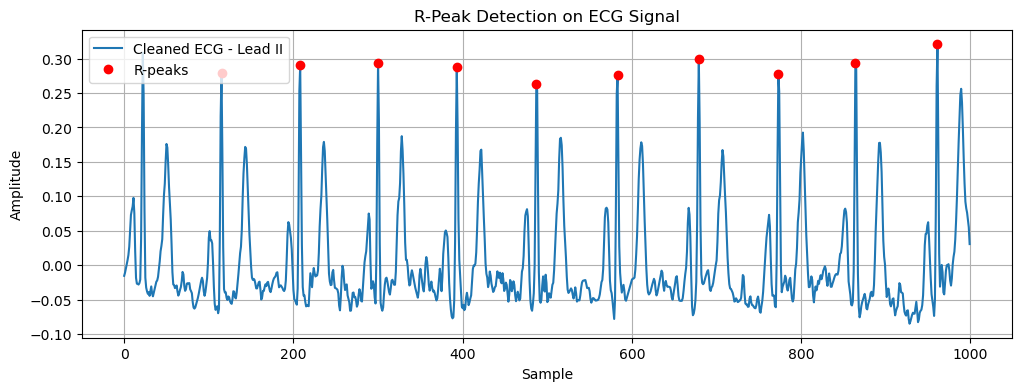

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(ecg_cleaned, label='Cleaned ECG - Lead II')
plt.plot(r_peaks, ecg_cleaned[r_peaks], 'ro', label='R-peaks')
plt.title("R-Peak Detection on ECG Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
all_r_peaks = []

for i in range(5):  # example: first 5 records
    sample_path = df.loc[i, 'filename_lr']
    record_path = os.path.join(data_folder, sample_path)
    signal, _ = wfdb.rdsamp(record_path)
    ecg_cleaned = nk.ecg_clean(signal[:, 1], sampling_rate=100)  # Lead II
    _, peak_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=100)
    r_peaks = peak_info["ECG_R_Peaks"]
    
    all_r_peaks.append({
        "ecg_id": df.loc[i, 'ecg_id'],
        "patient_id": df.loc[i, 'patient_id'],
        "num_r_peaks": len(r_peaks),
        "r_peak_indices": r_peaks
    })

# Convert to DataFrame
r_peaks_df = pd.DataFrame(all_r_peaks)
print(r_peaks_df.head())


   ecg_id  patient_id  num_r_peaks  \
0       1     15709.0           10   
1       2     13243.0            7   
2       3     20372.0           10   
3       4     17014.0           12   
4       5     17448.0           11   

                                      r_peak_indices  
0  [115, 208, 300, 393, 487, 583, 679, 773, 864, ...  
1                [100, 231, 368, 502, 627, 747, 863]  
2  [104, 202, 298, 394, 485, 577, 670, 764, 857, ...  
3  [108, 191, 279, 364, 446, 522, 601, 680, 762, ...  
4  [33, 123, 219, 313, 399, 482, 571, 669, 764, 8...  


In [15]:
sample_path = df.loc[0, 'filename_lr']
record_path = os.path.join(data_folder, sample_path)
signal, _ = wfdb.rdsamp(record_path)

# Use Lead II (index 1)
ecg_lead = signal[:, 1]

In [16]:
# Clean ECG (bandpass filter applied)
ecg_cleaned = nk.ecg_clean(ecg_lead, sampling_rate=100)


In [17]:
signals, wave_peaks = nk.ecg_delineate(ecg_cleaned, r_peaks, sampling_rate=100, method="peak")

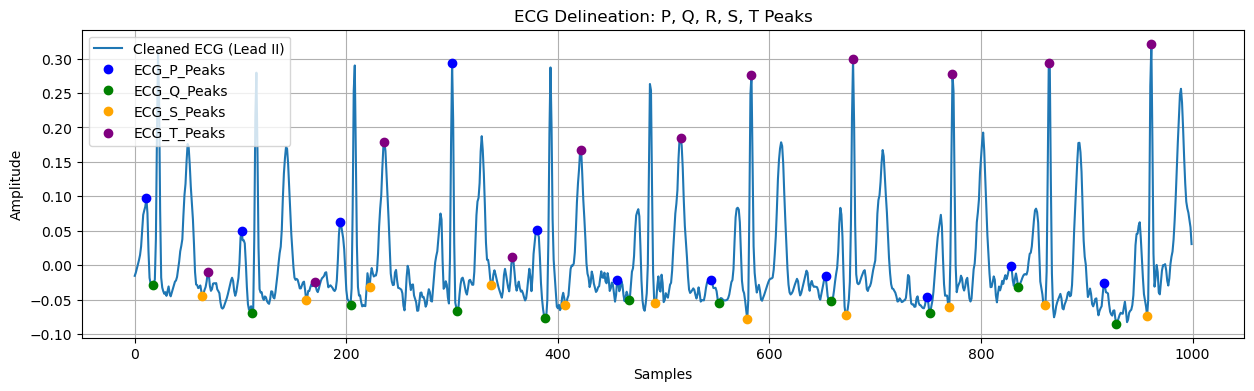

In [18]:
plt.figure(figsize=(15, 4))
plt.plot(ecg_cleaned, label="Cleaned ECG (Lead II)")

# Plot peaks if they exist
for label, color in zip(["ECG_P_Peaks", "ECG_Q_Peaks", "ECG_R_Peaks", "ECG_S_Peaks", "ECG_T_Peaks"],
                        ['blue', 'green', 'red', 'orange', 'purple']):
    indices = wave_peaks.get(label)
    if indices is not None:
        plt.plot(indices, ecg_cleaned[indices], 'o', label=label, color=color)

plt.legend()
plt.title("ECG Delineation: P, Q, R, S, T Peaks")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [19]:
for label in ["ECG_P_Peaks", "ECG_Q_Peaks", "ECG_R_Peaks", "ECG_S_Peaks", "ECG_T_Peaks"]:
    print(f"{label}: {wave_peaks.get(label)}")

ECG_P_Peaks: [11, 101, 194, 300, 380, 456, 545, 653, 749, 828, 916]
ECG_Q_Peaks: [17, 111, 204, 305, 388, 467, 552, 658, 752, 835, 928]
ECG_R_Peaks: None
ECG_S_Peaks: [64, 162, 222, 337, 407, 492, 579, 672, 770, 860, 957]
ECG_T_Peaks: [69, 170, 236, 357, 422, 516, 583, 679, 773, 864, 961]


In [ ]:

results = []

# Loop over all records
for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        ecg_id = row['ecg_id']
        patient_id = row['patient_id']
        record_path = os.path.join(data_folder, row['filename_lr'])

        # Load the ECG signal
        signal, _ = wfdb.rdsamp(record_path)

        # Use Lead II (index 1)
        ecg_lead = signal[:, 1]

        # Clean the ECG signal
        ecg_cleaned = nk.ecg_clean(ecg_lead, sampling_rate=100)

        # Detect R-peaks
        _, r_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=100)
        r_peaks = r_info["ECG_R_Peaks"]

        # Delineate ECG waves
        _, wave_peaks = nk.ecg_delineate(ecg_cleaned, r_peaks, sampling_rate=100, method="peak")

        # Extract average amplitudes at peak points
        result = {
            'ecg_id': ecg_id,
            'patient_id': patient_id,
            'num_beats': len(r_peaks),
        }
        for wave in ['P', 'Q', 'R', 'S', 'T']:
            peak_indices = wave_peaks.get(f'ECG_{wave}_Peaks')
            if peak_indices is not None and len(peak_indices) > 0:
                mean_amp = ecg_cleaned[peak_indices].mean()
            else:
                mean_amp = None
            result[f'{wave}_amp'] = mean_amp
            #amp = ecg_cleaned[peak_indices].mean() if peak_indices is not None else None

        results.append(result)

    except Exception as e:
        print(f"Error processing ecg_id {row['ecg_id']}: {e}")
        continue

# Save results to CSV
features_df = pd.DataFrame(results)
features_df.to_csv("ecg_peak_features.csv", index=False)
print("Saved features to ecg_peak_features.csv")

In [20]:
eh= pd.read_csv("ecg_peak_features.csv")
eh

,ecg_id,patient_id,num_beats,P_amp,Q_amp,R_amp,S_amp,T_amp
0,1,15709.0,10,0.070413,-0.066740,NaN,-0.052477,0.186288
1,2,13243.0,7,0.048388,-0.122452,NaN,-0.079138,0.373995
2,3,20372.0,10,0.064110,-0.067271,NaN,-0.051141,0.124201
3,5,17448.0,11,0.006767,-0.147861,NaN,-0.135138,0.323862
4,6,19005.0,13,0.121231,-0.082351,NaN,-0.186775,0.049683
...,...,...,...,...,...,...,...,...
14248,21831,11905.0,14,0.021868,-0.078339,NaN,-0.058602,0.181679
14249,21832,7954.0,15,0.090968,-0.008644,NaN,-0.137081,0.071360
14250,21834,20703.0,10,0.050764,-0.116813,NaN,-0.048473,0.164637
14251,21835,19311.0,9,0.097138,-0.067499,NaN,-0.087539,0.090974


In [24]:
from tqdm import tqdm
results = []

# Loop through each ECG record
for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        ecg_id = row['ecg_id']
        patient_id = row['patient_id']
        record_path = os.path.join(data_folder, row['filename_lr'])

        # Load ECG signal
        signal, _ = wfdb.rdsamp(record_path)

        # Use Lead II (index 1)
        ecg_lead = signal[:, 1]

        # Clean ECG signal
        ecg_cleaned = nk.ecg_clean(ecg_lead, sampling_rate=100)

        # Step 1: Detect R-peaks
        _, r_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=100)
        r_peaks = r_info["ECG_R_Peaks"]

        # Step 2: Store R-peak amplitudes now (before delineation)
        r_amplitudes = ecg_cleaned[r_peaks] if len(r_peaks) > 0 else []

        # Step 3: Delineate other wave peaks
        _, wave_peaks = nk.ecg_delineate(ecg_cleaned, r_peaks, sampling_rate=100, method="peak")

        # Step 4: Build result
        result = {
            'ecg_id': ecg_id,
            'patient_id': patient_id,
            'num_beats': len(r_peaks),
            'R_amp': r_amplitudes.mean() if len(r_amplitudes) > 0 else None
        }

        # Step 5: Extract amplitudes for P, Q, S, T
        for wave in ['P', 'Q', 'S', 'T']:
            peak_indices = wave_peaks.get(f'ECG_{wave}_Peaks')
            if peak_indices is not None and len(peak_indices) > 0:
                mean_amp = ecg_cleaned[peak_indices].mean()
            else:
                mean_amp = None
            result[f'{wave}_amp'] = mean_amp

        results.append(result)

    except Exception as e:
        print(f"Error processing ecg_id {row['ecg_id']}: {e}")
        continue

# Save to CSV
features_df = pd.DataFrame(results)
features_df.to_csv("ecg_peak_features.csv", index=False)
print(" Saved corrected features to ecg_peak_features.csv")

  0%|          | 5/21837 [00:01<1:19:50,  4.56it/s]

Error processing ecg_id 4: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 12/21837 [00:02<1:11:10,  5.11it/s]

Error processing ecg_id 11: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 14/21837 [00:03<1:15:20,  4.83it/s]

Error processing ecg_id 13: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 15/21837 [00:03<1:15:35,  4.81it/s]

Error processing ecg_id 15: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 16/21837 [00:03<1:19:05,  4.60it/s]

Error processing ecg_id 16: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 17/21837 [00:04<1:30:00,  4.04it/s]

Error processing ecg_id 17: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 18/21837 [00:04<1:30:51,  4.00it/s]

Error processing ecg_id 18: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 19/21837 [00:04<1:49:03,  3.33it/s]

Error processing ecg_id 19: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 21/21837 [00:05<1:30:27,  4.02it/s]

Error processing ecg_id 20: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 25/21837 [00:06<1:17:45,  4.68it/s]

Error processing ecg_id 24: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 27/21837 [00:06<1:06:51,  5.44it/s]

Error processing ecg_id 26: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 29/21837 [00:06<1:08:18,  5.32it/s]

Error processing ecg_id 28: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 35/21837 [00:07<1:04:46,  5.61it/s]

Error processing ecg_id 34: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 35: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 39/21837 [00:08<1:00:38,  5.99it/s]

Error processing ecg_id 38: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 41/21837 [00:08<59:16,  6.13it/s]  

Error processing ecg_id 40: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 41: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 45/21837 [00:09<1:02:12,  5.84it/s]

Error processing ecg_id 44: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 56/21837 [00:11<56:35,  6.41it/s]  

Error processing ecg_id 55: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 56: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 64/21837 [00:12<59:18,  6.12it/s]  

Error processing ecg_id 63: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 69/21837 [00:13<56:48,  6.39it/s]  

Error processing ecg_id 68: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 73/21837 [00:14<57:18,  6.33it/s]

Error processing ecg_id 72: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 83/21837 [00:15<56:35,  6.41it/s]

Error processing ecg_id 82: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 87/21837 [00:16<1:01:45,  5.87it/s]

Error processing ecg_id 86: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 87: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 90/21837 [00:16<51:35,  7.03it/s]  

Error processing ecg_id 89: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 96/21837 [00:17<55:04,  6.58it/s]  

Error processing ecg_id 95: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 102/21837 [00:18<49:31,  7.31it/s]

Error processing ecg_id 101: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  0%|          | 104/21837 [00:18<46:22,  7.81it/s]

Error processing ecg_id 103: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 112/21837 [00:19<45:24,  7.97it/s]

Error processing ecg_id 111: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 115/21837 [00:20<46:17,  7.82it/s]

Error processing ecg_id 114: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 129/21837 [00:21<53:29,  6.76it/s]

Error processing ecg_id 128: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 131/21837 [00:22<47:13,  7.66it/s]

Error processing ecg_id 130: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 135/21837 [00:22<48:49,  7.41it/s]

Error processing ecg_id 134: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 140/21837 [00:23<42:34,  8.49it/s]

Error processing ecg_id 139: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 142/21837 [00:23<43:23,  8.33it/s]

Error processing ecg_id 141: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 143: cannot convert float NaN to integer
Error processing ecg_id 144: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
  1%|          | 150/21837 [00:24<41:29,  8.71it/s]

Error processing ecg_id 149: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 156/21837 [00:25<43:49,  8.25it/s]

Error processing ecg_id 155: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 165/21837 [00:26<41:45,  8.65it/s]

Error processing ecg_id 164: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 166: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 169/21837 [00:26<40:33,  8.90it/s]

Error processing ecg_id 168: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 171/21837 [00:26<47:31,  7.60it/s]

Error processing ecg_id 170: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 176/21837 [00:27<51:26,  7.02it/s]

Error processing ecg_id 175: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 176: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 179/21837 [00:28<59:10,  6.10it/s]

Error processing ecg_id 178: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 182/21837 [00:28<58:18,  6.19it/s]  

Error processing ecg_id 181: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 185/21837 [00:29<57:54,  6.23it/s]  

Error processing ecg_id 184: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 191/21837 [00:30<47:44,  7.56it/s]

Error processing ecg_id 190: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 193/21837 [00:30<46:55,  7.69it/s]

Error processing ecg_id 192: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 196/21837 [00:30<43:51,  8.22it/s]

Error processing ecg_id 195: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 200/21837 [00:31<44:55,  8.03it/s]

Error processing ecg_id 199: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 215/21837 [00:32<38:41,  9.31it/s]

Error processing ecg_id 213: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 215: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 219/21837 [00:33<49:19,  7.30it/s]

Error processing ecg_id 219: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 224/21837 [00:34<44:32,  8.09it/s]

Error processing ecg_id 223: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 234/21837 [00:35<43:04,  8.36it/s]

Error processing ecg_id 233: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 234: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 243/21837 [00:36<51:24,  7.00it/s]

Error processing ecg_id 242: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 249/21837 [00:37<56:27,  6.37it/s]

Error processing ecg_id 248: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 254/21837 [00:38<1:02:14,  5.78it/s]

Error processing ecg_id 253: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 264/21837 [00:39<46:51,  7.67it/s]  

Error processing ecg_id 263: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 266/21837 [00:40<45:20,  7.93it/s]

Error processing ecg_id 265: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 266: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 269/21837 [00:40<47:35,  7.55it/s]

Error processing ecg_id 268: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 269: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 270/21837 [00:40<53:11,  6.76it/s]

Error processing ecg_id 270: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|          | 272/21837 [00:41<57:51,  6.21it/s]  

Error processing ecg_id 271: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|▏         | 274/21837 [00:41<1:08:49,  5.22it/s]

Error processing ecg_id 274: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|▏         | 278/21837 [00:42<56:42,  6.34it/s]  

Error processing ecg_id 277: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|▏         | 280/21837 [00:42<53:52,  6.67it/s]

Error processing ecg_id 279: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|▏         | 287/21837 [00:43<42:21,  8.48it/s]

Error processing ecg_id 286: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 287: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|▏         | 294/21837 [00:44<42:22,  8.47it/s]

Error processing ecg_id 293: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|▏         | 298/21837 [00:44<43:32,  8.24it/s]

Error processing ecg_id 298: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|▏         | 302/21837 [00:45<45:36,  7.87it/s]

Error processing ecg_id 301: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|▏         | 307/21837 [00:45<51:04,  7.03it/s]

Error processing ecg_id 306: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 307: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|▏         | 312/21837 [00:46<42:27,  8.45it/s]

Error processing ecg_id 311: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|▏         | 314/21837 [00:46<44:10,  8.12it/s]

Error processing ecg_id 313: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|▏         | 318/21837 [00:47<46:19,  7.74it/s]

Error processing ecg_id 317: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 318: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|▏         | 321/21837 [00:47<48:24,  7.41it/s]

Error processing ecg_id 320: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 321: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  1%|▏         | 326/21837 [00:48<51:48,  6.92it/s]

Error processing ecg_id 325: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 328/21837 [00:48<47:25,  7.56it/s]

Error processing ecg_id 327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 331/21837 [00:49<52:38,  6.81it/s]

Error processing ecg_id 330: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 337/21837 [00:49<54:15,  6.60it/s]

Error processing ecg_id 336: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 337: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 342/21837 [00:50<45:41,  7.84it/s]

Error processing ecg_id 341: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 342: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 347/21837 [00:51<47:19,  7.57it/s]

Error processing ecg_id 346: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 347: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 350/21837 [00:51<57:47,  6.20it/s]  

Error processing ecg_id 350: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 352/21837 [00:52<1:02:26,  5.73it/s]

Error processing ecg_id 351: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 354/21837 [00:52<58:11,  6.15it/s]  

Error processing ecg_id 353: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 356/21837 [00:52<54:14,  6.60it/s]

Error processing ecg_id 355: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 366/21837 [00:54<49:19,  7.25it/s]

Error processing ecg_id 365: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 376/21837 [00:55<50:01,  7.15it/s]

Error processing ecg_id 375: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 378/21837 [00:55<53:07,  6.73it/s]

Error processing ecg_id 377: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 385/21837 [00:56<47:16,  7.56it/s]

Error processing ecg_id 384: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 387/21837 [00:57<1:05:42,  5.44it/s]

Error processing ecg_id 386: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 392/21837 [00:58<59:40,  5.99it/s]  

Error processing ecg_id 391: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 394/21837 [00:58<54:13,  6.59it/s]

Error processing ecg_id 393: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 394: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 402/21837 [00:59<44:39,  8.00it/s]

Error processing ecg_id 400: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 405/21837 [01:00<45:04,  7.92it/s]

Error processing ecg_id 404: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 409/21837 [01:00<50:10,  7.12it/s]

Error processing ecg_id 408: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 409: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 411/21837 [01:00<47:15,  7.56it/s]

Error processing ecg_id 410: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 417/21837 [01:01<41:02,  8.70it/s]

Error processing ecg_id 416: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 417: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 426/21837 [01:02<52:11,  6.84it/s]

Error processing ecg_id 425: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 426: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 428/21837 [01:03<52:18,  6.82it/s]

Error processing ecg_id 427: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 431/21837 [01:03<53:24,  6.68it/s]

Error processing ecg_id 430: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 433/21837 [01:03<54:35,  6.53it/s]

Error processing ecg_id 432: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 433: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 437/21837 [01:04<49:10,  7.25it/s]

Error processing ecg_id 436: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 444/21837 [01:05<51:25,  6.93it/s]

Error processing ecg_id 443: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 444: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 447/21837 [01:06<59:42,  5.97it/s]  

Error processing ecg_id 446: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 448/21837 [01:06<54:48,  6.50it/s]

Error processing ecg_id 448: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 450/21837 [01:06<1:00:42,  5.87it/s]

Error processing ecg_id 449: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 450: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 453/21837 [01:07<55:13,  6.45it/s]  

Error processing ecg_id 452: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 457/21837 [01:07<47:23,  7.52it/s]

Error processing ecg_id 456: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 457: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 459/21837 [01:07<55:56,  6.37it/s]

Error processing ecg_id 458: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 462/21837 [01:08<55:47,  6.39it/s]

Error processing ecg_id 461: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 471/21837 [01:09<53:14,  6.69it/s]

Error processing ecg_id 470: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 474/21837 [01:10<54:19,  6.55it/s]

Error processing ecg_id 473: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 478/21837 [01:10<43:41,  8.15it/s]

Error processing ecg_id 476: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 477: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 481/21837 [01:11<48:54,  7.28it/s]

Error processing ecg_id 480: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 483/21837 [01:11<52:01,  6.84it/s]

Error processing ecg_id 482: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 483: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 488/21837 [01:12<56:35,  6.29it/s]  

Error processing ecg_id 487: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 491/21837 [01:12<58:41,  6.06it/s]

Error processing ecg_id 490: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 494/21837 [01:13<53:09,  6.69it/s]  

Error processing ecg_id 493: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 497/21837 [01:13<49:14,  7.22it/s]

Error processing ecg_id 496: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 501/21837 [01:14<53:39,  6.63it/s]

Error processing ecg_id 500: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 501: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 504/21837 [01:14<59:29,  5.98it/s]  

Error processing ecg_id 503: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 504: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 512/21837 [01:15<43:22,  8.20it/s]

Error processing ecg_id 511: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 514/21837 [01:15<46:25,  7.65it/s]

Error processing ecg_id 513: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 516/21837 [01:16<46:29,  7.64it/s]

Error processing ecg_id 515: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 516: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 517: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
  2%|▏         | 519/21837 [01:16<43:31,  8.16it/s]

Error processing ecg_id 518: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 522/21837 [01:17<47:28,  7.48it/s]

Error processing ecg_id 521: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 523/21837 [01:17<46:25,  7.65it/s]

Error processing ecg_id 523: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 525/21837 [01:17<55:43,  6.37it/s]

Error processing ecg_id 524: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 528/21837 [01:18<1:04:24,  5.51it/s]

Error processing ecg_id 527: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 534/21837 [01:18<46:22,  7.66it/s]  

Error processing ecg_id 533: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 536/21837 [01:19<47:39,  7.45it/s]

Error processing ecg_id 535: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  2%|▏         | 545/21837 [01:20<42:08,  8.42it/s]

Error processing ecg_id 544: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 545: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 548/21837 [01:20<52:18,  6.78it/s]

Error processing ecg_id 547: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 551/21837 [01:21<50:32,  7.02it/s]

Error processing ecg_id 550: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 551: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 553/21837 [01:21<48:37,  7.30it/s]

Error processing ecg_id 552: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 556/21837 [01:21<47:46,  7.42it/s]

Error processing ecg_id 555: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 559/21837 [01:22<49:05,  7.22it/s]

Error processing ecg_id 558: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 563/21837 [01:22<48:38,  7.29it/s]

Error processing ecg_id 562: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 563: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 568/21837 [01:23<52:50,  6.71it/s]  

Error processing ecg_id 567: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 570/21837 [01:24<50:30,  7.02it/s]

Error processing ecg_id 569: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 574/21837 [01:24<46:09,  7.68it/s]

Error processing ecg_id 573: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 576/21837 [01:24<50:55,  6.96it/s]

Error processing ecg_id 575: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 576: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 580/21837 [01:25<52:49,  6.71it/s]

Error processing ecg_id 579: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 590/21837 [01:26<44:47,  7.91it/s]  

Error processing ecg_id 589: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 595/21837 [01:27<50:00,  7.08it/s]

Error processing ecg_id 594: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 595: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 603/21837 [01:28<49:46,  7.11it/s]

Error processing ecg_id 602: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 608/21837 [01:29<53:08,  6.66it/s]

Error processing ecg_id 607: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 608: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 610/21837 [01:29<55:21,  6.39it/s]

Error processing ecg_id 609: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 610: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 616/21837 [01:30<54:23,  6.50it/s]

Error processing ecg_id 615: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 618/21837 [01:31<52:21,  6.76it/s]

Error processing ecg_id 617: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 620/21837 [01:31<49:20,  7.17it/s]

Error processing ecg_id 619: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 629/21837 [01:32<55:12,  6.40it/s]

Error processing ecg_id 628: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 635/21837 [01:33<50:39,  6.98it/s]

Error processing ecg_id 634: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 635: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 639/21837 [01:34<55:34,  6.36it/s]  

Error processing ecg_id 638: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 643/21837 [01:34<55:40,  6.34it/s]

Error processing ecg_id 642: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 646/21837 [01:35<51:43,  6.83it/s]

Error processing ecg_id 645: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 646: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 648/21837 [01:35<52:16,  6.76it/s]

Error processing ecg_id 647: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 651/21837 [01:36<54:35,  6.47it/s]

Error processing ecg_id 650: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 655/21837 [01:36<47:45,  7.39it/s]

Error processing ecg_id 654: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 657/21837 [01:37<59:29,  5.93it/s]

Error processing ecg_id 656: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 668/21837 [01:38<51:37,  6.83it/s]

Error processing ecg_id 667: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 672/21837 [01:39<56:43,  6.22it/s]

Error processing ecg_id 671: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 675/21837 [01:39<54:32,  6.47it/s]

Error processing ecg_id 674: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 675: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 678/21837 [01:40<55:21,  6.37it/s]

Error processing ecg_id 677: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 686/21837 [01:41<51:50,  6.80it/s]  

Error processing ecg_id 685: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 686: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 688/21837 [01:41<49:18,  7.15it/s]

Error processing ecg_id 688: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 692/21837 [01:42<1:01:47,  5.70it/s]

Error processing ecg_id 691: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 696/21837 [01:43<55:35,  6.34it/s]  

Error processing ecg_id 695: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 698/21837 [01:43<1:01:32,  5.72it/s]

Error processing ecg_id 697: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 700/21837 [01:43<1:02:06,  5.67it/s]

Error processing ecg_id 699: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 704/21837 [01:44<51:55,  6.78it/s]  

Error processing ecg_id 703: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 704: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 709/21837 [01:45<54:16,  6.49it/s]

Error processing ecg_id 708: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 712/21837 [01:45<52:46,  6.67it/s]

Error processing ecg_id 711: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 712: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 714/21837 [01:45<48:45,  7.22it/s]

Error processing ecg_id 714: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 717/21837 [01:46<1:02:52,  5.60it/s]

Error processing ecg_id 717: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 728/21837 [01:48<55:24,  6.35it/s]  

Error processing ecg_id 727: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 731/21837 [01:48<51:26,  6.84it/s]

Error processing ecg_id 730: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 731: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 735/21837 [01:49<50:05,  7.02it/s]

Error processing ecg_id 734: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 737/21837 [01:49<46:46,  7.52it/s]

Error processing ecg_id 736: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 739/21837 [01:49<51:15,  6.86it/s]

Error processing ecg_id 738: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 739: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 743/21837 [01:50<55:27,  6.34it/s]  

Error processing ecg_id 742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 747/21837 [01:51<55:43,  6.31it/s]  

Error processing ecg_id 746: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 747: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 752/21837 [01:51<42:07,  8.34it/s]

Error processing ecg_id 750: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 758/21837 [01:52<45:27,  7.73it/s]

Error processing ecg_id 757: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 760/21837 [01:52<50:14,  6.99it/s]

Error processing ecg_id 759: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 760: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 762/21837 [01:53<52:24,  6.70it/s]

Error processing ecg_id 761: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  3%|▎         | 764/21837 [01:53<59:51,  5.87it/s]  

Error processing ecg_id 763: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 764: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▎         | 767/21837 [01:53<56:20,  6.23it/s]  

Error processing ecg_id 766: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▎         | 776/21837 [01:55<46:53,  7.49it/s]

Error processing ecg_id 775: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 776: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▎         | 778/21837 [01:55<49:36,  7.07it/s]

Error processing ecg_id 777: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 778: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▎         | 787/21837 [01:57<54:07,  6.48it/s]

Error processing ecg_id 786: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▎         | 794/21837 [01:58<47:57,  7.31it/s]

Error processing ecg_id 793: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▎         | 797/21837 [01:58<50:46,  6.91it/s]

Error processing ecg_id 796: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 798: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
  4%|▎         | 808/21837 [01:59<46:53,  7.47it/s]

Error processing ecg_id 807: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▎         | 815/21837 [02:01<1:00:00,  5.84it/s]

Error processing ecg_id 814: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 819/21837 [02:01<1:02:39,  5.59it/s]

Error processing ecg_id 818: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 819: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 821/21837 [02:02<1:06:46,  5.24it/s]

Error processing ecg_id 820: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 823/21837 [02:02<1:01:16,  5.72it/s]

Error processing ecg_id 822: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 823: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 826/21837 [02:03<58:28,  5.99it/s]  

Error processing ecg_id 825: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 829/21837 [02:03<58:55,  5.94it/s]  

Error processing ecg_id 828: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 829: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 834/21837 [02:04<1:03:21,  5.52it/s]

Error processing ecg_id 833: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 837/21837 [02:04<52:16,  6.70it/s]  

Error processing ecg_id 836: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 846/21837 [02:06<42:54,  8.15it/s]

Error processing ecg_id 845: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 846: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 849/21837 [02:06<45:22,  7.71it/s]

Error processing ecg_id 848: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 852/21837 [02:06<45:34,  7.68it/s]

Error processing ecg_id 851: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 853: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
  4%|▍         | 854/21837 [02:07<38:33,  9.07it/s]

Error processing ecg_id 854: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 857/21837 [02:07<1:04:19,  5.44it/s]

Error processing ecg_id 857: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 859/21837 [02:08<1:07:59,  5.14it/s]

Error processing ecg_id 859: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 863/21837 [02:09<1:10:51,  4.93it/s]

Error processing ecg_id 863: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 865/21837 [02:09<1:14:52,  4.67it/s]

Error processing ecg_id 864: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 867/21837 [02:10<1:18:25,  4.46it/s]

Error processing ecg_id 866: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 868/21837 [02:10<1:28:51,  3.93it/s]

Error processing ecg_id 868: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 871/21837 [02:11<1:31:14,  3.83it/s]

Error processing ecg_id 871: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 874/21837 [02:12<1:30:51,  3.85it/s]

Error processing ecg_id 874: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 881/21837 [02:13<1:05:00,  5.37it/s]

Error processing ecg_id 880: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 883/21837 [02:13<1:05:04,  5.37it/s]

Error processing ecg_id 882: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 893/21837 [02:15<1:08:57,  5.06it/s]

Error processing ecg_id 892: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 893: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 895/21837 [02:16<1:07:57,  5.14it/s]

Error processing ecg_id 894: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 898/21837 [02:16<1:00:28,  5.77it/s]

Error processing ecg_id 897: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 906/21837 [02:18<1:02:41,  5.56it/s]

Error processing ecg_id 905: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 906: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 908/21837 [02:18<1:06:26,  5.25it/s]

Error processing ecg_id 907: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 915/21837 [02:20<1:06:03,  5.28it/s]

Error processing ecg_id 914: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 918/21837 [02:20<1:01:10,  5.70it/s]

Error processing ecg_id 917: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 921/21837 [02:21<1:08:07,  5.12it/s]

Error processing ecg_id 920: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 924/21837 [02:21<1:09:48,  4.99it/s]

Error processing ecg_id 923: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 924: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 928/21837 [02:22<1:08:44,  5.07it/s]

Error processing ecg_id 927: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 928: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 929/21837 [02:22<1:07:33,  5.16it/s]

Error processing ecg_id 929: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 933/21837 [02:23<1:00:00,  5.81it/s]

Error processing ecg_id 932: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 935/21837 [02:23<56:58,  6.11it/s]  

Error processing ecg_id 935: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 943/21837 [02:25<59:41,  5.83it/s]  

Error processing ecg_id 942: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 943: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 947/21837 [02:26<55:50,  6.24it/s]  

Error processing ecg_id 946: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 947: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 957/21837 [02:27<50:09,  6.94it/s]

Error processing ecg_id 956: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 957: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 960/21837 [02:27<54:57,  6.33it/s]

Error processing ecg_id 959: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 960: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 964/21837 [02:28<58:15,  5.97it/s]

Error processing ecg_id 963: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 966/21837 [02:28<56:17,  6.18it/s]

Error processing ecg_id 965: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 970/21837 [02:29<58:25,  5.95it/s]

Error processing ecg_id 970: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 973/21837 [02:30<1:06:48,  5.20it/s]

Error processing ecg_id 972: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 973: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  4%|▍         | 975/21837 [02:30<1:00:21,  5.76it/s]

Error processing ecg_id 974: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 975: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 986/21837 [02:32<45:53,  7.57it/s]  

Error processing ecg_id 985: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 988/21837 [02:32<51:57,  6.69it/s]

Error processing ecg_id 987: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 995/21837 [02:33<51:55,  6.69it/s]

Error processing ecg_id 994: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 995: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1004/21837 [02:34<45:51,  7.57it/s] 

Error processing ecg_id 1003: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1004: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1006/21837 [02:35<44:35,  7.79it/s]

Error processing ecg_id 1005: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1006: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1010/21837 [02:35<59:13,  5.86it/s]  

Error processing ecg_id 1009: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1011/21837 [02:35<56:37,  6.13it/s]

Error processing ecg_id 1011: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1013/21837 [02:36<59:32,  5.83it/s]  

Error processing ecg_id 1012: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1014/21837 [02:36<1:01:23,  5.65it/s]

Error processing ecg_id 1014: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1018/21837 [02:37<55:06,  6.30it/s]  

Error processing ecg_id 1017: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1018: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1020/21837 [02:37<55:14,  6.28it/s]

Error processing ecg_id 1019: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1020: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1023/21837 [02:37<52:03,  6.66it/s]

Error processing ecg_id 1022: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1031/21837 [02:39<51:11,  6.77it/s]  

Error processing ecg_id 1030: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1034/21837 [02:39<57:46,  6.00it/s]  

Error processing ecg_id 1033: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1036/21837 [02:40<59:24,  5.84it/s]

Error processing ecg_id 1035: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1036: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1039/21837 [02:40<1:01:40,  5.62it/s]

Error processing ecg_id 1038: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1045/21837 [02:41<55:29,  6.25it/s]  

Error processing ecg_id 1044: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1047/21837 [02:41<55:46,  6.21it/s]

Error processing ecg_id 1046: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1049/21837 [02:42<59:53,  5.78it/s]

Error processing ecg_id 1048: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1053/21837 [02:42<1:00:58,  5.68it/s]

Error processing ecg_id 1052: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1054/21837 [02:43<55:15,  6.27it/s]  

Error processing ecg_id 1054: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1060/21837 [02:44<1:19:29,  4.36it/s]

Error processing ecg_id 1060: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1061: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1064/21837 [02:45<55:16,  6.26it/s]  

Error processing ecg_id 1063: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1066/21837 [02:45<51:16,  6.75it/s]

Error processing ecg_id 1065: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1066: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1075/21837 [02:46<46:10,  7.49it/s]

Error processing ecg_id 1074: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1078/21837 [02:47<49:45,  6.95it/s]

Error processing ecg_id 1077: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1081/21837 [02:47<44:19,  7.81it/s]

Error processing ecg_id 1079: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1081: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▍         | 1085/21837 [02:48<48:48,  7.09it/s]

Error processing ecg_id 1084: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1085: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1093/21837 [02:49<49:08,  7.04it/s]

Error processing ecg_id 1092: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1093: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1096/21837 [02:49<45:36,  7.58it/s]

Error processing ecg_id 1095: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1098/21837 [02:49<44:27,  7.78it/s]

Error processing ecg_id 1097: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1098: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1100/21837 [02:50<46:46,  7.39it/s]

Error processing ecg_id 1099: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1105/21837 [02:50<43:01,  8.03it/s]

Error processing ecg_id 1104: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1105: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1109/21837 [02:51<51:10,  6.75it/s]

Error processing ecg_id 1108: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1109: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1112/21837 [02:51<48:32,  7.12it/s]

Error processing ecg_id 1111: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1117/21837 [02:52<46:46,  7.38it/s]

Error processing ecg_id 1116: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1117: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1122/21837 [02:53<42:06,  8.20it/s]

Error processing ecg_id 1121: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1122: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1124/21837 [02:53<46:17,  7.46it/s]

Error processing ecg_id 1123: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1133/21837 [02:54<50:07,  6.88it/s]

Error processing ecg_id 1132: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1144/21837 [02:56<44:03,  7.83it/s]

Error processing ecg_id 1143: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1153/21837 [02:57<47:19,  7.28it/s]

Error processing ecg_id 1152: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1155/21837 [02:57<49:03,  7.03it/s]

Error processing ecg_id 1154: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1157/21837 [02:58<54:48,  6.29it/s]

Error processing ecg_id 1156: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1157: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1159/21837 [02:58<57:51,  5.96it/s]

Error processing ecg_id 1158: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1159: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1162/21837 [02:58<56:41,  6.08it/s]

Error processing ecg_id 1163: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1167/21837 [02:59<49:40,  6.93it/s]

Error processing ecg_id 1166: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1169/21837 [02:59<45:08,  7.63it/s]

Error processing ecg_id 1168: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1172/21837 [03:00<47:06,  7.31it/s]

Error processing ecg_id 1171: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1174/21837 [03:00<50:59,  6.75it/s]

Error processing ecg_id 1173: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1176/21837 [03:00<48:55,  7.04it/s]

Error processing ecg_id 1175: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1179/21837 [03:01<56:45,  6.07it/s]

Error processing ecg_id 1178: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1182/21837 [03:01<52:46,  6.52it/s]  

Error processing ecg_id 1181: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1185/21837 [03:02<50:13,  6.85it/s]

Error processing ecg_id 1184: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1186/21837 [03:02<47:19,  7.27it/s]

Error processing ecg_id 1186: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1191/21837 [03:03<51:00,  6.75it/s]

Error processing ecg_id 1190: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  5%|▌         | 1193/21837 [03:03<48:46,  7.05it/s]

Error processing ecg_id 1192: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1193: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1203/21837 [03:04<45:33,  7.55it/s]

Error processing ecg_id 1202: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1203: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1209/21837 [03:05<44:57,  7.65it/s]

Error processing ecg_id 1208: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1212/21837 [03:05<45:46,  7.51it/s]

Error processing ecg_id 1211: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1222/21837 [03:07<47:28,  7.24it/s]

Error processing ecg_id 1221: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1222: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1225/21837 [03:07<45:31,  7.55it/s]

Error processing ecg_id 1225: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1226: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1228/21837 [03:08<45:00,  7.63it/s]

Error processing ecg_id 1227: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1228: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1232/21837 [03:08<45:10,  7.60it/s]

Error processing ecg_id 1231: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1232: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1234/21837 [03:09<43:53,  7.82it/s]

Error processing ecg_id 1233: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1234: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1236/21837 [03:09<43:42,  7.86it/s]

Error processing ecg_id 1235: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1239/21837 [03:09<38:49,  8.84it/s]

Error processing ecg_id 1237: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1242/21837 [03:10<46:11,  7.43it/s]

Error processing ecg_id 1241: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1242: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1250/21837 [03:11<40:21,  8.50it/s]

Error processing ecg_id 1249: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1261/21837 [03:12<38:56,  8.80it/s]

Error processing ecg_id 1260: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1261: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1263/21837 [03:12<39:28,  8.69it/s]

Error processing ecg_id 1262: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1265/21837 [03:12<39:36,  8.66it/s]

Error processing ecg_id 1264: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1274/21837 [03:13<40:31,  8.46it/s]

Error processing ecg_id 1273: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1274: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1276/21837 [03:14<41:36,  8.24it/s]

Error processing ecg_id 1275: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1283/21837 [03:15<45:22,  7.55it/s]

Error processing ecg_id 1282: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1283: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1290/21837 [03:15<39:28,  8.67it/s]

Error processing ecg_id 1289: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1291/21837 [03:16<40:30,  8.45it/s]

Error processing ecg_id 1291: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1292: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1300/21837 [03:17<47:09,  7.26it/s]

Error processing ecg_id 1299: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1302/21837 [03:17<43:33,  7.86it/s]

Error processing ecg_id 1301: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1304/21837 [03:17<40:35,  8.43it/s]

Error processing ecg_id 1303: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1307/21837 [03:17<39:42,  8.62it/s]

Error processing ecg_id 1306: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1311/21837 [03:18<41:17,  8.29it/s]

Error processing ecg_id 1310: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1313/21837 [03:18<39:20,  8.70it/s]

Error processing ecg_id 1313: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1318/21837 [03:19<39:09,  8.73it/s]

Error processing ecg_id 1317: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1320/21837 [03:19<40:27,  8.45it/s]

Error processing ecg_id 1319: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1320: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1323/21837 [03:19<37:44,  9.06it/s]

Error processing ecg_id 1321: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1325/21837 [03:20<38:16,  8.93it/s]

Error processing ecg_id 1324: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1325: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1328/21837 [03:20<51:29,  6.64it/s]

Error processing ecg_id 1327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1333/21837 [03:21<43:38,  7.83it/s]

Error processing ecg_id 1332: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1336/21837 [03:21<42:41,  8.00it/s]

Error processing ecg_id 1335: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1339/21837 [03:21<41:02,  8.32it/s]

Error processing ecg_id 1339: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1346/21837 [03:22<36:32,  9.35it/s]

Error processing ecg_id 1345: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1352/21837 [03:23<35:48,  9.53it/s]

Error processing ecg_id 1351: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1355/21837 [03:23<35:52,  9.51it/s]

Error processing ecg_id 1353: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1358/21837 [03:24<36:45,  9.28it/s]

Error processing ecg_id 1357: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▌         | 1363/21837 [03:24<42:52,  7.96it/s]

Error processing ecg_id 1362: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1367/21837 [03:25<43:29,  7.85it/s]

Error processing ecg_id 1366: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1367: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1369/21837 [03:25<45:48,  7.45it/s]

Error processing ecg_id 1368: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1369: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1372/21837 [03:25<49:18,  6.92it/s]

Error processing ecg_id 1371: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1376/21837 [03:26<46:56,  7.26it/s]

Error processing ecg_id 1375: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1378/21837 [03:26<44:46,  7.62it/s]

Error processing ecg_id 1377: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1381/21837 [03:27<40:04,  8.51it/s]

Error processing ecg_id 1380: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1384/21837 [03:27<39:36,  8.61it/s]

Error processing ecg_id 1383: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1386/21837 [03:27<37:31,  9.08it/s]

Error processing ecg_id 1385: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1388/21837 [03:27<38:37,  8.83it/s]

Error processing ecg_id 1387: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1395/21837 [03:28<47:57,  7.10it/s]

Error processing ecg_id 1394: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1398/21837 [03:29<44:06,  7.72it/s]

Error processing ecg_id 1397: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1404/21837 [03:29<40:01,  8.51it/s]

Error processing ecg_id 1403: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1404: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1407/21837 [03:30<39:28,  8.63it/s]

Error processing ecg_id 1406: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1407: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1413/21837 [03:30<43:01,  7.91it/s]

Error processing ecg_id 1412: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  6%|▋         | 1419/21837 [03:31<44:09,  7.71it/s]

Error processing ecg_id 1418: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1419: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1431/21837 [03:33<41:03,  8.28it/s]

Error processing ecg_id 1430: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1431: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1436/21837 [03:34<47:17,  7.19it/s]

Error processing ecg_id 1435: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1436: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1440/21837 [03:34<42:22,  8.02it/s]

Error processing ecg_id 1439: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1444/21837 [03:35<44:29,  7.64it/s]

Error processing ecg_id 1443: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1444: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1450/21837 [03:35<45:23,  7.48it/s]

Error processing ecg_id 1449: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1452/21837 [03:36<43:34,  7.80it/s]

Error processing ecg_id 1451: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1455/21837 [03:36<45:59,  7.39it/s]

Error processing ecg_id 1454: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1457/21837 [03:36<47:06,  7.21it/s]

Error processing ecg_id 1456: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1462/21837 [03:37<47:21,  7.17it/s]

Error processing ecg_id 1461: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1464/21837 [03:37<49:27,  6.87it/s]

Error processing ecg_id 1463: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1469/21837 [03:38<46:01,  7.37it/s]

Error processing ecg_id 1468: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1472/21837 [03:38<48:01,  7.07it/s]

Error processing ecg_id 1471: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1472: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1474/21837 [03:39<51:41,  6.57it/s]

Error processing ecg_id 1473: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1476/21837 [03:39<51:26,  6.60it/s]

Error processing ecg_id 1475: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1485/21837 [03:40<43:50,  7.74it/s]

Error processing ecg_id 1484: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1487/21837 [03:41<53:10,  6.38it/s]

Error processing ecg_id 1486: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1493/21837 [03:41<46:55,  7.22it/s]

Error processing ecg_id 1492: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1495/21837 [03:42<42:23,  8.00it/s]

Error processing ecg_id 1494: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1501/21837 [03:42<42:10,  8.04it/s]

Error processing ecg_id 1500: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1505/21837 [03:43<42:08,  8.04it/s]

Error processing ecg_id 1504: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1507/21837 [03:43<44:00,  7.70it/s]

Error processing ecg_id 1506: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1509/21837 [03:44<49:03,  6.91it/s]

Error processing ecg_id 1508: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1511/21837 [03:44<45:45,  7.40it/s]

Error processing ecg_id 1510: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1516/21837 [03:45<51:59,  6.51it/s]

Error processing ecg_id 1515: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1520/21837 [03:45<54:54,  6.17it/s]

Error processing ecg_id 1519: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1523/21837 [03:46<49:55,  6.78it/s]  

Error processing ecg_id 1522: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1525/21837 [03:46<45:12,  7.49it/s]

Error processing ecg_id 1524: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1531/21837 [03:47<51:48,  6.53it/s]

Error processing ecg_id 1531: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1537/21837 [03:48<44:17,  7.64it/s]

Error processing ecg_id 1536: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1552/21837 [03:50<47:21,  7.14it/s]

Error processing ecg_id 1551: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1552: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1554/21837 [03:50<47:19,  7.14it/s]

Error processing ecg_id 1554: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1555: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1559/21837 [03:51<49:50,  6.78it/s]

Error processing ecg_id 1558: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1565/21837 [03:51<40:24,  8.36it/s]

Error processing ecg_id 1564: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1565: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1568/21837 [03:52<36:05,  9.36it/s]

Error processing ecg_id 1566: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1568: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1571/21837 [03:52<35:37,  9.48it/s]

Error processing ecg_id 1569: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1574/21837 [03:52<39:25,  8.57it/s]

Error processing ecg_id 1573: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1578/21837 [03:53<35:13,  9.59it/s]

Error processing ecg_id 1577: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1584/21837 [03:53<30:56, 10.91it/s]

Error processing ecg_id 1582: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1586/21837 [03:54<31:22, 10.76it/s]

Error processing ecg_id 1586: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1590/21837 [03:54<32:17, 10.45it/s]

Error processing ecg_id 1589: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1594/21837 [03:54<37:19,  9.04it/s]

Error processing ecg_id 1593: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1598/21837 [03:55<35:08,  9.60it/s]

Error processing ecg_id 1596: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1604/21837 [03:56<37:56,  8.89it/s]

Error processing ecg_id 1604: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1605: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1610/21837 [03:56<37:34,  8.97it/s]

Error processing ecg_id 1609: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1617/21837 [03:57<39:12,  8.60it/s]

Error processing ecg_id 1616: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1623/21837 [03:58<35:20,  9.53it/s]

Error processing ecg_id 1621: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1622: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1625/21837 [03:58<38:55,  8.65it/s]

Error processing ecg_id 1624: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1625: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1634/21837 [03:59<39:14,  8.58it/s]

Error processing ecg_id 1633: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1634: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  7%|▋         | 1636/21837 [03:59<48:13,  6.98it/s]

Error processing ecg_id 1635: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1636: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1640/21837 [04:00<38:56,  8.65it/s]

Error processing ecg_id 1639: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1642/21837 [04:00<43:59,  7.65it/s]

Error processing ecg_id 1641: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1647/21837 [04:01<46:21,  7.26it/s]

Error processing ecg_id 1646: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1647: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1649/21837 [04:01<46:01,  7.31it/s]

Error processing ecg_id 1648: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1649: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1657/21837 [04:02<41:52,  8.03it/s]

Error processing ecg_id 1657: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1658: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1662/21837 [04:03<41:07,  8.18it/s]

Error processing ecg_id 1661: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1665/21837 [04:03<39:43,  8.46it/s]

Error processing ecg_id 1664: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1669/21837 [04:04<40:31,  8.30it/s]

Error processing ecg_id 1668: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1671/21837 [04:04<45:46,  7.34it/s]

Error processing ecg_id 1670: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1674/21837 [04:04<45:09,  7.44it/s]

Error processing ecg_id 1673: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1676/21837 [04:04<43:49,  7.67it/s]

Error processing ecg_id 1675: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1678/21837 [04:05<41:20,  8.13it/s]

Error processing ecg_id 1677: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1681/21837 [04:05<46:31,  7.22it/s]

Error processing ecg_id 1680: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1682/21837 [04:05<45:41,  7.35it/s]

Error processing ecg_id 1682: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1685/21837 [04:06<41:01,  8.19it/s]

Error processing ecg_id 1684: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1687/21837 [04:06<44:12,  7.60it/s]

Error processing ecg_id 1686: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1687: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1691/21837 [04:06<39:29,  8.50it/s]

Error processing ecg_id 1689: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1694/21837 [04:07<39:42,  8.45it/s]

Error processing ecg_id 1693: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1694: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1695/21837 [04:07<39:34,  8.48it/s]

Error processing ecg_id 1695: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1700/21837 [04:08<44:08,  7.60it/s]

Error processing ecg_id 1699: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1715/21837 [04:09<40:57,  8.19it/s]

Error processing ecg_id 1714: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1717/21837 [04:10<39:33,  8.48it/s]

Error processing ecg_id 1716: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1717: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1720/21837 [04:10<39:07,  8.57it/s]

Error processing ecg_id 1719: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1722/21837 [04:10<38:22,  8.73it/s]

Error processing ecg_id 1721: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1723/21837 [04:10<40:47,  8.22it/s]

Error processing ecg_id 1723: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1724: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1730/21837 [04:11<46:12,  7.25it/s]

Error processing ecg_id 1729: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1736/21837 [04:12<46:21,  7.23it/s]

Error processing ecg_id 1735: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1739/21837 [04:13<52:31,  6.38it/s]

Error processing ecg_id 1738: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1745/21837 [04:14<52:44,  6.35it/s]

Error processing ecg_id 1744: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1745: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1750/21837 [04:14<48:12,  6.94it/s]

Error processing ecg_id 1749: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1755/21837 [04:15<45:44,  7.32it/s]

Error processing ecg_id 1754: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1755: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1760/21837 [04:16<45:54,  7.29it/s]

Error processing ecg_id 1759: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1762/21837 [04:16<43:37,  7.67it/s]

Error processing ecg_id 1761: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1763/21837 [04:16<46:18,  7.22it/s]

Error processing ecg_id 1763: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1767/21837 [04:17<49:46,  6.72it/s]

Error processing ecg_id 1766: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1772/21837 [04:17<44:45,  7.47it/s]

Error processing ecg_id 1771: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1778/21837 [04:18<44:26,  7.52it/s]

Error processing ecg_id 1777: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1781/21837 [04:19<45:23,  7.36it/s]

Error processing ecg_id 1780: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1784/21837 [04:19<41:36,  8.03it/s]

Error processing ecg_id 1783: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1784: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1786/21837 [04:19<42:11,  7.92it/s]

Error processing ecg_id 1785: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1790/21837 [04:20<48:59,  6.82it/s]

Error processing ecg_id 1789: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1793/21837 [04:20<50:19,  6.64it/s]

Error processing ecg_id 1792: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1793: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1795/21837 [04:21<43:14,  7.72it/s]

Error processing ecg_id 1794: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1798/21837 [04:21<37:08,  8.99it/s]

Error processing ecg_id 1796: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1798: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1802/21837 [04:21<44:42,  7.47it/s]

Error processing ecg_id 1801: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1802: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1804/21837 [04:22<44:46,  7.46it/s]

Error processing ecg_id 1803: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1806/21837 [04:22<48:40,  6.86it/s]

Error processing ecg_id 1805: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1806: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1816/21837 [04:23<46:41,  7.15it/s]

Error processing ecg_id 1815: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1820/21837 [04:24<53:30,  6.24it/s]

Error processing ecg_id 1819: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1820: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1822/21837 [04:24<49:15,  6.77it/s]

Error processing ecg_id 1821: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1825/21837 [04:25<48:59,  6.81it/s]

Error processing ecg_id 1824: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1827/21837 [04:25<48:57,  6.81it/s]

Error processing ecg_id 1826: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1827: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1829/21837 [04:25<47:27,  7.03it/s]

Error processing ecg_id 1828: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1834/21837 [04:26<46:19,  7.20it/s]

Error processing ecg_id 1833: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1836/21837 [04:26<43:19,  7.70it/s]

Error processing ecg_id 1835: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1842/21837 [04:27<44:00,  7.57it/s]

Error processing ecg_id 1841: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1847/21837 [04:28<52:39,  6.33it/s]

Error processing ecg_id 1846: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1847: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  8%|▊         | 1850/21837 [04:28<54:40,  6.09it/s]

Error processing ecg_id 1849: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1850: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▊         | 1859/21837 [04:30<51:52,  6.42it/s]

Error processing ecg_id 1858: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1859: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▊         | 1864/21837 [04:30<42:04,  7.91it/s]

Error processing ecg_id 1863: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1864: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▊         | 1874/21837 [04:32<42:12,  7.88it/s]

Error processing ecg_id 1873: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1874: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▊         | 1881/21837 [04:33<43:54,  7.57it/s]

Error processing ecg_id 1880: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1881: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▊         | 1888/21837 [04:34<44:36,  7.45it/s]

Error processing ecg_id 1887: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▊         | 1891/21837 [04:34<40:01,  8.31it/s]

Error processing ecg_id 1889: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▊         | 1895/21837 [04:35<44:30,  7.47it/s]

Error processing ecg_id 1894: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▊         | 1899/21837 [04:35<44:11,  7.52it/s]

Error processing ecg_id 1898: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▊         | 1902/21837 [04:35<42:50,  7.76it/s]

Error processing ecg_id 1901: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▊         | 1908/21837 [04:36<47:07,  7.05it/s]

Error processing ecg_id 1907: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1913/21837 [04:37<42:23,  7.83it/s]

Error processing ecg_id 1912: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1913: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1915/21837 [04:37<48:50,  6.80it/s]

Error processing ecg_id 1914: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1918/21837 [04:38<50:13,  6.61it/s]

Error processing ecg_id 1917: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1918: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1920/21837 [04:38<55:52,  5.94it/s]

Error processing ecg_id 1919: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1926/21837 [04:39<46:16,  7.17it/s]

Error processing ecg_id 1925: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1928/21837 [04:39<46:55,  7.07it/s]

Error processing ecg_id 1927: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1928: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1931/21837 [04:40<46:35,  7.12it/s]

Error processing ecg_id 1930: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1938/21837 [04:41<47:07,  7.04it/s]

Error processing ecg_id 1937: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1942/21837 [04:41<46:14,  7.17it/s]

Error processing ecg_id 1941: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1942: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1951/21837 [04:42<48:58,  6.77it/s]

Error processing ecg_id 1950: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1951: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1955/21837 [04:43<49:36,  6.68it/s]

Error processing ecg_id 1954: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1955: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1959/21837 [04:44<48:48,  6.79it/s]

Error processing ecg_id 1958: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1960/21837 [04:44<45:59,  7.20it/s]

Error processing ecg_id 1960: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1965/21837 [04:45<47:26,  6.98it/s]

Error processing ecg_id 1964: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1965: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1967/21837 [04:45<50:19,  6.58it/s]

Error processing ecg_id 1966: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1972/21837 [04:46<1:01:41,  5.37it/s]

Error processing ecg_id 1971: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1975/21837 [04:46<1:08:15,  4.85it/s]

Error processing ecg_id 1974: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1978/21837 [04:47<55:19,  5.98it/s]  

Error processing ecg_id 1977: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1981/21837 [04:47<52:27,  6.31it/s]

Error processing ecg_id 1980: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1983/21837 [04:48<57:43,  5.73it/s]

Error processing ecg_id 1982: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1984/21837 [04:48<57:01,  5.80it/s]

Error processing ecg_id 1984: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1986/21837 [04:48<1:03:17,  5.23it/s]

Error processing ecg_id 1986: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 1996/21837 [04:50<56:32,  5.85it/s]  

Error processing ecg_id 1995: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 1996: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2002/21837 [04:52<1:11:06,  4.65it/s]

Error processing ecg_id 2001: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2005/21837 [04:52<1:03:53,  5.17it/s]

Error processing ecg_id 2004: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2010/21837 [04:53<56:13,  5.88it/s]  

Error processing ecg_id 2009: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2011/21837 [04:53<1:05:22,  5.05it/s]

Error processing ecg_id 2011: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2016/21837 [04:54<1:06:58,  4.93it/s]

Error processing ecg_id 2015: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2020/21837 [04:55<1:01:37,  5.36it/s]

Error processing ecg_id 2019: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2024/21837 [04:56<53:40,  6.15it/s]  

Error processing ecg_id 2024: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2027/21837 [04:56<1:04:43,  5.10it/s]

Error processing ecg_id 2026: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2027: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2030/21837 [04:57<1:08:12,  4.84it/s]

Error processing ecg_id 2029: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2030: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2034/21837 [04:58<1:06:27,  4.97it/s]

Error processing ecg_id 2033: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2036/21837 [04:58<1:03:38,  5.19it/s]

Error processing ecg_id 2035: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2036: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2040/21837 [04:59<57:54,  5.70it/s]  

Error processing ecg_id 2039: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2040: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2043/21837 [05:00<1:01:07,  5.40it/s]

Error processing ecg_id 2043: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2045/21837 [05:00<1:08:56,  4.78it/s]

Error processing ecg_id 2045: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2047/21837 [05:00<1:08:35,  4.81it/s]

Error processing ecg_id 2047: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2048/21837 [05:01<1:11:31,  4.61it/s]

Error processing ecg_id 2048: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2050/21837 [05:01<1:18:22,  4.21it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
  9%|▉         | 2052/21837 [05:01<57:57,  5.69it/s]  

Error processing ecg_id 2050: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2051: cannot convert float NaN to integer


  9%|▉         | 2056/21837 [05:02<51:51,  6.36it/s]

Error processing ecg_id 2055: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2059/21837 [05:03<54:15,  6.07it/s]

Error processing ecg_id 2058: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2059: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2063/21837 [05:03<52:47,  6.24it/s]  

Error processing ecg_id 2062: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2065/21837 [05:04<46:28,  7.09it/s]

Error processing ecg_id 2064: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2068/21837 [05:04<46:26,  7.09it/s]

Error processing ecg_id 2067: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


  9%|▉         | 2074/21837 [05:05<46:32,  7.08it/s]

Error processing ecg_id 2073: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2078/21837 [05:06<55:56,  5.89it/s]

Error processing ecg_id 2078: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2083/21837 [05:06<49:35,  6.64it/s]  

Error processing ecg_id 2082: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2086/21837 [05:07<51:02,  6.45it/s]

Error processing ecg_id 2085: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2088/21837 [05:07<47:02,  7.00it/s]

Error processing ecg_id 2087: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2088: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2091/21837 [05:08<48:02,  6.85it/s]

Error processing ecg_id 2091: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2094/21837 [05:08<53:19,  6.17it/s]  

Error processing ecg_id 2093: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2096/21837 [05:08<52:26,  6.27it/s]

Error processing ecg_id 2095: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2096: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2102/21837 [05:09<47:05,  6.99it/s]

Error processing ecg_id 2101: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2104/21837 [05:10<43:40,  7.53it/s]

Error processing ecg_id 2103: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2104: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2106/21837 [05:10<43:48,  7.51it/s]

Error processing ecg_id 2105: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2119/21837 [05:12<43:59,  7.47it/s]

Error processing ecg_id 2118: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2121/21837 [05:12<43:03,  7.63it/s]

Error processing ecg_id 2120: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2130/21837 [05:13<43:34,  7.54it/s]

Error processing ecg_id 2129: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2130: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2131/21837 [05:13<42:26,  7.74it/s]

Error processing ecg_id 2131: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2135/21837 [05:14<39:46,  8.25it/s]

Error processing ecg_id 2134: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2141/21837 [05:15<44:17,  7.41it/s]

Error processing ecg_id 2140: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2149/21837 [05:16<40:25,  8.12it/s]

Error processing ecg_id 2147: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2148: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2155/21837 [05:16<40:47,  8.04it/s]

Error processing ecg_id 2154: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2161/21837 [05:17<42:36,  7.70it/s]

Error processing ecg_id 2160: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2166/21837 [05:18<45:03,  7.28it/s]

Error processing ecg_id 2165: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2171/21837 [05:19<41:17,  7.94it/s]

Error processing ecg_id 2170: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2171: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2173/21837 [05:19<47:50,  6.85it/s]

Error processing ecg_id 2172: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2175/21837 [05:19<47:18,  6.93it/s]

Error processing ecg_id 2174: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2178/21837 [05:20<46:46,  7.00it/s]

Error processing ecg_id 2177: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|▉         | 2181/21837 [05:20<44:17,  7.40it/s]

Error processing ecg_id 2180: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2181: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2184/21837 [05:20<44:24,  7.38it/s]

Error processing ecg_id 2183: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2184: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2189/21837 [05:21<45:50,  7.14it/s]

Error processing ecg_id 2188: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2193/21837 [05:22<41:22,  7.91it/s]

Error processing ecg_id 2192: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2196/21837 [05:22<46:53,  6.98it/s]

Error processing ecg_id 2195: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2196: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2198/21837 [05:22<51:44,  6.33it/s]

Error processing ecg_id 2197: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2205/21837 [05:23<46:29,  7.04it/s]

Error processing ecg_id 2204: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2205: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2208/21837 [05:24<42:48,  7.64it/s]

Error processing ecg_id 2207: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2213/21837 [05:24<44:49,  7.30it/s]

Error processing ecg_id 2212: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2218/21837 [05:25<36:58,  8.84it/s]

Error processing ecg_id 2216: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2218: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2220/21837 [05:25<42:11,  7.75it/s]

Error processing ecg_id 2219: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2220: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2226/21837 [05:26<52:06,  6.27it/s]  

Error processing ecg_id 2225: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2226: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2229/21837 [05:27<48:27,  6.74it/s]

Error processing ecg_id 2228: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2230/21837 [05:27<49:32,  6.60it/s]

Error processing ecg_id 2230: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2234/21837 [05:28<45:34,  7.17it/s]

Error processing ecg_id 2233: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2237/21837 [05:28<44:18,  7.37it/s]

Error processing ecg_id 2236: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2237: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2241/21837 [05:29<48:07,  6.79it/s]

Error processing ecg_id 2240: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2244/21837 [05:29<53:42,  6.08it/s]

Error processing ecg_id 2243: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2244: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2246/21837 [05:29<48:42,  6.70it/s]

Error processing ecg_id 2245: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2248/21837 [05:30<45:18,  7.21it/s]

Error processing ecg_id 2247: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2248: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2250/21837 [05:30<47:06,  6.93it/s]

Error processing ecg_id 2249: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2255/21837 [05:31<46:43,  6.99it/s]

Error processing ecg_id 2254: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2257/21837 [05:31<47:05,  6.93it/s]

Error processing ecg_id 2256: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2260/21837 [05:31<45:52,  7.11it/s]

Error processing ecg_id 2259: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2263/21837 [05:32<43:53,  7.43it/s]

Error processing ecg_id 2262: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2263: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2267/21837 [05:32<42:34,  7.66it/s]

Error processing ecg_id 2266: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2277/21837 [05:34<1:00:44,  5.37it/s]

Error processing ecg_id 2276: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2288/21837 [05:36<47:07,  6.91it/s]  

Error processing ecg_id 2287: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 10%|█         | 2290/21837 [05:36<45:06,  7.22it/s]

Error processing ecg_id 2289: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2294/21837 [05:37<52:23,  6.22it/s]

Error processing ecg_id 2293: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2294: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2299/21837 [05:37<44:18,  7.35it/s]

Error processing ecg_id 2298: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2305/21837 [05:38<43:32,  7.47it/s]

Error processing ecg_id 2304: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2310/21837 [05:39<44:59,  7.23it/s]

Error processing ecg_id 2309: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2310: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2312/21837 [05:39<47:03,  6.92it/s]

Error processing ecg_id 2311: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2317/21837 [05:40<41:46,  7.79it/s]

Error processing ecg_id 2316: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2323/21837 [05:41<45:09,  7.20it/s]

Error processing ecg_id 2322: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2327/21837 [05:41<42:56,  7.57it/s]

Error processing ecg_id 2327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2347/21837 [05:44<46:38,  6.97it/s]

Error processing ecg_id 2346: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2350/21837 [05:44<54:49,  5.92it/s]

Error processing ecg_id 2350: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2362/21837 [05:47<56:00,  5.79it/s]  

Error processing ecg_id 2362: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2368/21837 [05:48<51:43,  6.27it/s]  

Error processing ecg_id 2367: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2368: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2373/21837 [05:48<51:20,  6.32it/s]

Error processing ecg_id 2372: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2380/21837 [05:50<56:49,  5.71it/s]

Error processing ecg_id 2379: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2385/21837 [05:50<45:26,  7.13it/s]

Error processing ecg_id 2384: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2389/21837 [05:51<53:13,  6.09it/s]

Error processing ecg_id 2388: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2391/21837 [05:51<49:35,  6.53it/s]

Error processing ecg_id 2390: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2391: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2395/21837 [05:52<52:03,  6.22it/s]

Error processing ecg_id 2395: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2398/21837 [05:53<58:19,  5.56it/s]  

Error processing ecg_id 2397: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2400/21837 [05:53<58:31,  5.54it/s]

Error processing ecg_id 2400: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2405/21837 [05:54<1:02:49,  5.15it/s]

Error processing ecg_id 2405: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2407/21837 [05:54<1:08:36,  4.72it/s]

Error processing ecg_id 2406: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2407: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2411/21837 [05:55<1:00:44,  5.33it/s]

Error processing ecg_id 2410: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2413/21837 [05:55<51:42,  6.26it/s]  

Error processing ecg_id 2412: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2418/21837 [05:56<50:02,  6.47it/s]

Error processing ecg_id 2417: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2426/21837 [05:57<49:01,  6.60it/s]

Error processing ecg_id 2425: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2430/21837 [05:58<43:30,  7.43it/s]

Error processing ecg_id 2429: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2430: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2432/21837 [05:58<43:08,  7.50it/s]

Error processing ecg_id 2431: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2435/21837 [05:59<42:34,  7.60it/s]

Error processing ecg_id 2434: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2440/21837 [05:59<44:20,  7.29it/s]

Error processing ecg_id 2439: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2442/21837 [06:00<41:32,  7.78it/s]

Error processing ecg_id 2441: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█         | 2455/21837 [06:01<49:59,  6.46it/s]

Error processing ecg_id 2454: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2457/21837 [06:02<55:16,  5.84it/s]

Error processing ecg_id 2456: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2459/21837 [06:02<55:49,  5.78it/s]

Error processing ecg_id 2458: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2464/21837 [06:03<53:40,  6.02it/s]

Error processing ecg_id 2463: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2467/21837 [06:03<50:41,  6.37it/s]

Error processing ecg_id 2466: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2471/21837 [06:04<49:16,  6.55it/s]

Error processing ecg_id 2470: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2476/21837 [06:04<45:04,  7.16it/s]

Error processing ecg_id 2475: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2476: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2479/21837 [06:05<40:19,  8.00it/s]

Error processing ecg_id 2478: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2479: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2482/21837 [06:05<44:29,  7.25it/s]

Error processing ecg_id 2481: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2486/21837 [06:06<45:43,  7.05it/s]

Error processing ecg_id 2485: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2486: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2488/21837 [06:06<51:39,  6.24it/s]

Error processing ecg_id 2487: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2490/21837 [06:06<48:15,  6.68it/s]

Error processing ecg_id 2489: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2492/21837 [06:07<47:53,  6.73it/s]

Error processing ecg_id 2491: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2500/21837 [06:08<42:22,  7.60it/s]

Error processing ecg_id 2499: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2500: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2504/21837 [06:08<46:55,  6.87it/s]

Error processing ecg_id 2503: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2507/21837 [06:09<42:01,  7.67it/s]

Error processing ecg_id 2506: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2507: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 11%|█▏        | 2510/21837 [06:09<41:01,  7.85it/s]

Error processing ecg_id 2509: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2513/21837 [06:10<43:18,  7.44it/s]

Error processing ecg_id 2512: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2518/21837 [06:10<36:41,  8.78it/s]

Error processing ecg_id 2516: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2517: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2522/21837 [06:11<42:17,  7.61it/s]

Error processing ecg_id 2522: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2527/21837 [06:11<46:43,  6.89it/s]

Error processing ecg_id 2526: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2527: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2530/21837 [06:12<56:40,  5.68it/s]

Error processing ecg_id 2530: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2534/21837 [06:13<48:16,  6.66it/s]

Error processing ecg_id 2533: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2538/21837 [06:13<46:11,  6.96it/s]

Error processing ecg_id 2537: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2546/21837 [06:14<37:26,  8.59it/s]

Error processing ecg_id 2544: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2547/21837 [06:14<38:27,  8.36it/s]

Error processing ecg_id 2547: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2551/21837 [06:15<35:35,  9.03it/s]

Error processing ecg_id 2549: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2554/21837 [06:15<38:55,  8.26it/s]

Error processing ecg_id 2553: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2554: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2555/21837 [06:15<39:07,  8.22it/s]

Error processing ecg_id 2555: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2559/21837 [06:16<39:11,  8.20it/s]

Error processing ecg_id 2558: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2568/21837 [06:17<42:46,  7.51it/s]

Error processing ecg_id 2567: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2575/21837 [06:18<35:39,  9.00it/s]

Error processing ecg_id 2573: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2575: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2577/21837 [06:18<35:44,  8.98it/s]

Error processing ecg_id 2576: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2580/21837 [06:18<37:31,  8.55it/s]

Error processing ecg_id 2579: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2581/21837 [06:18<41:26,  7.74it/s]

Error processing ecg_id 2581: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2584/21837 [06:19<40:45,  7.87it/s]

Error processing ecg_id 2583: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2586/21837 [06:19<45:31,  7.05it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 12%|█▏        | 2588/21837 [06:19<39:38,  8.09it/s]

Error processing ecg_id 2586: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2587: integer division or modulo by zero


 12%|█▏        | 2591/21837 [06:20<41:34,  7.71it/s]

Error processing ecg_id 2590: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2592: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 12%|█▏        | 2594/21837 [06:20<35:54,  8.93it/s]

Error processing ecg_id 2593: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2599/21837 [06:21<37:02,  8.66it/s]

Error processing ecg_id 2598: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2603/21837 [06:21<38:39,  8.29it/s]

Error processing ecg_id 2602: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2606/21837 [06:21<39:16,  8.16it/s]

Error processing ecg_id 2605: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2610/21837 [06:22<40:29,  7.92it/s]

Error processing ecg_id 2609: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2617/21837 [06:23<41:56,  7.64it/s]

Error processing ecg_id 2616: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2620/21837 [06:23<40:25,  7.92it/s]

Error processing ecg_id 2619: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2625/21837 [06:24<43:59,  7.28it/s]

Error processing ecg_id 2624: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2629/21837 [06:25<52:32,  6.09it/s]

Error processing ecg_id 2628: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2634/21837 [06:25<41:40,  7.68it/s]

Error processing ecg_id 2633: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2644/21837 [06:26<37:33,  8.52it/s]

Error processing ecg_id 2643: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2644: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2651/21837 [06:27<39:30,  8.10it/s]

Error processing ecg_id 2650: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2651: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2652: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2654/21837 [06:28<40:24,  7.91it/s]

Error processing ecg_id 2653: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2658/21837 [06:28<42:39,  7.49it/s]

Error processing ecg_id 2657: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2658: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2664/21837 [06:29<41:51,  7.63it/s]

Error processing ecg_id 2664: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2667/21837 [06:29<39:18,  8.13it/s]

Error processing ecg_id 2666: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2669/21837 [06:30<38:51,  8.22it/s]

Error processing ecg_id 2668: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2674/21837 [06:30<40:57,  7.80it/s]

Error processing ecg_id 2673: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2674: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2678/21837 [06:31<37:22,  8.54it/s]

Error processing ecg_id 2677: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2680/21837 [06:31<39:56,  7.99it/s]

Error processing ecg_id 2679: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2688/21837 [06:32<32:37,  9.78it/s]

Error processing ecg_id 2687: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2692/21837 [06:32<32:21,  9.86it/s]

Error processing ecg_id 2691: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2692: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2702/21837 [06:33<30:11, 10.57it/s]

Error processing ecg_id 2700: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2708/21837 [06:34<28:46, 11.08it/s]

Error processing ecg_id 2706: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2709: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 12%|█▏        | 2716/21837 [06:35<36:47,  8.66it/s]

Error processing ecg_id 2715: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2716: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2719/21837 [06:35<36:34,  8.71it/s]

Error processing ecg_id 2718: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2722/21837 [06:35<35:59,  8.85it/s]

Error processing ecg_id 2721: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2722: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2723: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2725/21837 [06:36<41:44,  7.63it/s]

Error processing ecg_id 2724: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2725: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 12%|█▏        | 2728/21837 [06:36<45:46,  6.96it/s]

Error processing ecg_id 2727: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2734/21837 [06:37<38:00,  8.38it/s]

Error processing ecg_id 2733: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2736/21837 [06:37<41:32,  7.66it/s]

Error processing ecg_id 2735: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2740/21837 [06:38<42:40,  7.46it/s]

Error processing ecg_id 2739: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2742/21837 [06:38<43:50,  7.26it/s]

Error processing ecg_id 2741: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2744/21837 [06:38<46:27,  6.85it/s]

Error processing ecg_id 2743: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2750/21837 [06:39<38:00,  8.37it/s]

Error processing ecg_id 2750: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2754/21837 [06:40<42:25,  7.50it/s]

Error processing ecg_id 2753: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2756/21837 [06:40<40:49,  7.79it/s]

Error processing ecg_id 2755: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2758/21837 [06:40<46:11,  6.88it/s]

Error processing ecg_id 2758: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2761/21837 [06:41<41:11,  7.72it/s]

Error processing ecg_id 2760: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2761: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2764/21837 [06:41<37:43,  8.43it/s]

Error processing ecg_id 2763: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2766/21837 [06:41<36:31,  8.70it/s]

Error processing ecg_id 2765: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2772/21837 [06:42<43:59,  7.22it/s]

Error processing ecg_id 2771: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2774/21837 [06:42<49:12,  6.46it/s]

Error processing ecg_id 2773: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2785/21837 [06:44<37:54,  8.38it/s]

Error processing ecg_id 2784: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2789/21837 [06:44<40:04,  7.92it/s]

Error processing ecg_id 2788: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2793/21837 [06:44<37:23,  8.49it/s]

Error processing ecg_id 2792: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2796/21837 [06:45<41:21,  7.67it/s]

Error processing ecg_id 2795: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2798/21837 [06:45<41:41,  7.61it/s]

Error processing ecg_id 2797: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2798: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2802/21837 [06:46<35:13,  9.01it/s]

Error processing ecg_id 2800: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2809/21837 [06:47<44:19,  7.16it/s]

Error processing ecg_id 2808: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2811/21837 [06:47<48:58,  6.47it/s]

Error processing ecg_id 2810: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2819/21837 [06:48<43:36,  7.27it/s]

Error processing ecg_id 2818: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2823/21837 [06:48<46:34,  6.80it/s]

Error processing ecg_id 2822: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2823: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2827/21837 [06:49<46:16,  6.85it/s]

Error processing ecg_id 2826: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2827: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2828/21837 [06:49<50:25,  6.28it/s]

Error processing ecg_id 2828: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2832/21837 [06:50<50:28,  6.28it/s]  

Error processing ecg_id 2831: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2832: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2833/21837 [06:50<49:41,  6.37it/s]

Error processing ecg_id 2833: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2839/21837 [06:51<52:21,  6.05it/s]  

Error processing ecg_id 2838: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2839: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2843/21837 [06:52<53:00,  5.97it/s]

Error processing ecg_id 2842: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2847/21837 [06:52<47:13,  6.70it/s]

Error processing ecg_id 2846: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2847: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2852/21837 [06:53<42:25,  7.46it/s]

Error processing ecg_id 2851: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2852: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2858/21837 [06:54<37:01,  8.54it/s]

Error processing ecg_id 2857: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2861/21837 [06:54<42:11,  7.50it/s]

Error processing ecg_id 2860: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2861: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2867/21837 [06:55<44:28,  7.11it/s]

Error processing ecg_id 2866: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2867: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2870/21837 [06:56<41:50,  7.56it/s]

Error processing ecg_id 2870: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2871: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2873/21837 [06:56<42:38,  7.41it/s]

Error processing ecg_id 2872: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2873: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2878/21837 [06:57<43:34,  7.25it/s]

Error processing ecg_id 2877: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2880/21837 [06:57<44:12,  7.15it/s]

Error processing ecg_id 2879: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2884/21837 [06:57<39:26,  8.01it/s]

Error processing ecg_id 2883: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2884: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2886/21837 [06:58<42:13,  7.48it/s]

Error processing ecg_id 2885: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2886: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2890/21837 [06:58<43:57,  7.18it/s]

Error processing ecg_id 2889: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2895/21837 [06:59<42:17,  7.46it/s]

Error processing ecg_id 2894: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2895: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2899/21837 [06:59<45:04,  7.00it/s]

Error processing ecg_id 2898: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2902/21837 [07:00<47:39,  6.62it/s]

Error processing ecg_id 2902: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2907/21837 [07:01<39:32,  7.98it/s]

Error processing ecg_id 2907: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2908: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2911/21837 [07:01<37:39,  8.38it/s]

Error processing ecg_id 2910: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2915/21837 [07:01<37:40,  8.37it/s]

Error processing ecg_id 2914: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2918/21837 [07:02<42:04,  7.50it/s]

Error processing ecg_id 2917: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2918: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2920/21837 [07:02<47:23,  6.65it/s]

Error processing ecg_id 2919: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2920: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2923/21837 [07:03<43:29,  7.25it/s]

Error processing ecg_id 2922: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2923: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2931/21837 [07:04<41:39,  7.56it/s]

Error processing ecg_id 2930: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2934/21837 [07:04<40:57,  7.69it/s]

Error processing ecg_id 2934: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2940/21837 [07:05<38:12,  8.24it/s]

Error processing ecg_id 2939: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 13%|█▎        | 2945/21837 [07:06<41:16,  7.63it/s]

Error processing ecg_id 2944: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2948/21837 [07:06<43:46,  7.19it/s]

Error processing ecg_id 2947: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2948: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2955/21837 [07:07<49:29,  6.36it/s]

Error processing ecg_id 2954: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2957/21837 [07:08<50:06,  6.28it/s]

Error processing ecg_id 2956: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2957: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2960/21837 [07:08<44:55,  7.00it/s]

Error processing ecg_id 2959: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2960: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2963/21837 [07:08<47:04,  6.68it/s]

Error processing ecg_id 2962: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2965/21837 [07:09<46:19,  6.79it/s]

Error processing ecg_id 2964: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2972/21837 [07:10<42:59,  7.31it/s]

Error processing ecg_id 2971: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2972: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2974/21837 [07:10<50:02,  6.28it/s]

Error processing ecg_id 2973: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2975/21837 [07:10<46:42,  6.73it/s]

Error processing ecg_id 2975: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2977/21837 [07:11<53:30,  5.87it/s]

Error processing ecg_id 2976: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2981/21837 [07:11<44:22,  7.08it/s]

Error processing ecg_id 2980: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2984/21837 [07:12<45:50,  6.85it/s]

Error processing ecg_id 2983: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2986/21837 [07:12<42:20,  7.42it/s]

Error processing ecg_id 2985: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2989/21837 [07:12<37:42,  8.33it/s]

Error processing ecg_id 2988: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2989: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2991/21837 [07:13<40:04,  7.84it/s]

Error processing ecg_id 2990: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2991: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2994/21837 [07:13<35:09,  8.93it/s]

Error processing ecg_id 2993: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2994: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 2995: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2997/21837 [07:13<37:44,  8.32it/s]

Error processing ecg_id 2997: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 2999/21837 [07:14<50:37,  6.20it/s]

Error processing ecg_id 2999: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▎        | 3002/21837 [07:14<44:29,  7.05it/s]

Error processing ecg_id 3001: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3002: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3007/21837 [07:15<39:35,  7.93it/s]

Error processing ecg_id 3006: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3014/21837 [07:16<41:47,  7.51it/s]

Error processing ecg_id 3013: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3017/21837 [07:16<47:30,  6.60it/s]

Error processing ecg_id 3016: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3017: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3019/21837 [07:16<47:56,  6.54it/s]

Error processing ecg_id 3018: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3019: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3023/21837 [07:17<49:04,  6.39it/s]

Error processing ecg_id 3022: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3025/21837 [07:17<47:02,  6.67it/s]

Error processing ecg_id 3024: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3025: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3033/21837 [07:18<37:09,  8.43it/s]

Error processing ecg_id 3032: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3038/21837 [07:19<42:45,  7.33it/s]

Error processing ecg_id 3037: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3042/21837 [07:19<38:19,  8.17it/s]

Error processing ecg_id 3041: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3046/21837 [07:20<39:16,  7.97it/s]

Error processing ecg_id 3045: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3052/21837 [07:21<40:07,  7.80it/s]

Error processing ecg_id 3051: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3052: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3056/21837 [07:21<42:14,  7.41it/s]

Error processing ecg_id 3055: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3056: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3059/21837 [07:22<40:35,  7.71it/s]

Error processing ecg_id 3058: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3059: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3063/21837 [07:22<47:36,  6.57it/s]

Error processing ecg_id 3062: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3063: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3066/21837 [07:23<44:08,  7.09it/s]

Error processing ecg_id 3065: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3067/21837 [07:23<44:34,  7.02it/s]

Error processing ecg_id 3067: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3069/21837 [07:23<51:28,  6.08it/s]

Error processing ecg_id 3068: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3073/21837 [07:24<44:50,  6.97it/s]

Error processing ecg_id 3072: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3076/21837 [07:24<49:39,  6.30it/s]

Error processing ecg_id 3075: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3078/21837 [07:25<47:08,  6.63it/s]

Error processing ecg_id 3077: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3081/21837 [07:25<51:29,  6.07it/s]

Error processing ecg_id 3080: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3081: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3088/21837 [07:26<55:28,  5.63it/s]

Error processing ecg_id 3087: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3090/21837 [07:27<51:59,  6.01it/s]

Error processing ecg_id 3090: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3093/21837 [07:27<52:46,  5.92it/s]

Error processing ecg_id 3092: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3102/21837 [07:29<53:44,  5.81it/s]  

Error processing ecg_id 3101: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3102: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3108/21837 [07:30<1:13:44,  4.23it/s]

Error processing ecg_id 3107: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3115/21837 [07:32<1:00:22,  5.17it/s]

Error processing ecg_id 3114: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3115: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3117/21837 [07:32<1:01:29,  5.07it/s]

Error processing ecg_id 3116: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3119/21837 [07:32<56:15,  5.54it/s]  

Error processing ecg_id 3118: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3119: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3121/21837 [07:33<56:52,  5.48it/s]  

Error processing ecg_id 3121: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3128/21837 [07:34<1:00:09,  5.18it/s]

Error processing ecg_id 3127: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3128: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3129/21837 [07:34<1:01:17,  5.09it/s]

Error processing ecg_id 3129: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3133/21837 [07:35<1:00:54,  5.12it/s]

Error processing ecg_id 3132: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3134/21837 [07:35<1:12:38,  4.29it/s]

Error processing ecg_id 3134: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3136/21837 [07:36<1:13:03,  4.27it/s]

Error processing ecg_id 3135: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3139/21837 [07:36<1:02:33,  4.98it/s]

Error processing ecg_id 3138: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3139: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3147/21837 [07:38<58:57,  5.28it/s]  

Error processing ecg_id 3147: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3152/21837 [07:39<1:00:37,  5.14it/s]

Error processing ecg_id 3151: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3161/21837 [07:41<1:11:53,  4.33it/s]

Error processing ecg_id 3161: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 14%|█▍        | 3165/21837 [07:42<1:05:22,  4.76it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 15%|█▍        | 3167/21837 [07:42<46:31,  6.69it/s]  

Error processing ecg_id 3166: integer division or modulo by zero
Error processing ecg_id 3167: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3176/21837 [07:43<39:38,  7.85it/s]

Error processing ecg_id 3175: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3179/21837 [07:44<42:59,  7.23it/s]

Error processing ecg_id 3178: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3179: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3182/21837 [07:44<43:51,  7.09it/s]

Error processing ecg_id 3181: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3184/21837 [07:45<52:34,  5.91it/s]

Error processing ecg_id 3184: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3190/21837 [07:45<44:04,  7.05it/s]

Error processing ecg_id 3189: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3190: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3192/21837 [07:46<44:14,  7.02it/s]

Error processing ecg_id 3192: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3194/21837 [07:46<49:31,  6.27it/s]

Error processing ecg_id 3193: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3196/21837 [07:46<49:11,  6.32it/s]

Error processing ecg_id 3195: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3198/21837 [07:47<49:03,  6.33it/s]

Error processing ecg_id 3197: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3200/21837 [07:47<46:33,  6.67it/s]

Error processing ecg_id 3199: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3208/21837 [07:48<48:09,  6.45it/s]

Error processing ecg_id 3207: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3211/21837 [07:49<41:33,  7.47it/s]

Error processing ecg_id 3210: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3213/21837 [07:49<40:09,  7.73it/s]

Error processing ecg_id 3212: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3216/21837 [07:49<53:00,  5.85it/s]

Error processing ecg_id 3215: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3217/21837 [07:50<48:35,  6.39it/s]

Error processing ecg_id 3217: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3218: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3220/21837 [07:50<45:53,  6.76it/s]

Error processing ecg_id 3219: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3220: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3225/21837 [07:51<44:43,  6.94it/s]

Error processing ecg_id 3224: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3232/21837 [07:52<50:57,  6.08it/s]

Error processing ecg_id 3231: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3232: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3234/21837 [07:52<43:22,  7.15it/s]

Error processing ecg_id 3233: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3236/21837 [07:52<38:53,  7.97it/s]

Error processing ecg_id 3235: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3238/21837 [07:53<42:43,  7.26it/s]

Error processing ecg_id 3237: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3238: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3240/21837 [07:53<40:46,  7.60it/s]

Error processing ecg_id 3239: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3242/21837 [07:53<41:10,  7.53it/s]

Error processing ecg_id 3241: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3242: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3247/21837 [07:54<48:06,  6.44it/s]

Error processing ecg_id 3246: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3249/21837 [07:54<41:08,  7.53it/s]

Error processing ecg_id 3248: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3255/21837 [07:55<39:52,  7.77it/s]

Error processing ecg_id 3254: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3261/21837 [07:56<38:33,  8.03it/s]

Error processing ecg_id 3260: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3265/21837 [07:56<38:45,  7.99it/s]

Error processing ecg_id 3264: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3265: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3267/21837 [07:56<41:40,  7.43it/s]

Error processing ecg_id 3266: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3267: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3270/21837 [07:57<43:06,  7.18it/s]

Error processing ecg_id 3269: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3270: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▍        | 3271/21837 [07:57<46:39,  6.63it/s]

Error processing ecg_id 3271: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3281/21837 [07:59<41:26,  7.46it/s]  

Error processing ecg_id 3280: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3281: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3285/21837 [07:59<41:16,  7.49it/s]

Error processing ecg_id 3284: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3285: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3291/21837 [08:00<39:26,  7.84it/s]

Error processing ecg_id 3290: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3296/21837 [08:01<41:39,  7.42it/s]

Error processing ecg_id 3295: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3296: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3300/21837 [08:01<40:20,  7.66it/s]

Error processing ecg_id 3299: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3300: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3302/21837 [08:02<46:54,  6.59it/s]

Error processing ecg_id 3301: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3307/21837 [08:02<39:50,  7.75it/s]

Error processing ecg_id 3306: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3309/21837 [08:02<39:26,  7.83it/s]

Error processing ecg_id 3309: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3311/21837 [08:03<44:57,  6.87it/s]

Error processing ecg_id 3310: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3320/21837 [08:04<38:53,  7.94it/s]

Error processing ecg_id 3319: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3323/21837 [08:04<39:37,  7.79it/s]

Error processing ecg_id 3322: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3328/21837 [08:05<37:53,  8.14it/s]

Error processing ecg_id 3327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3328: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3329/21837 [08:05<38:40,  7.98it/s]

Error processing ecg_id 3329: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3331/21837 [08:06<47:37,  6.48it/s]

Error processing ecg_id 3330: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3337/21837 [08:07<58:33,  5.27it/s]

Error processing ecg_id 3336: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3337: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3340/21837 [08:07<47:02,  6.55it/s]

Error processing ecg_id 3339: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3342/21837 [08:07<54:16,  5.68it/s]

Error processing ecg_id 3341: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3345/21837 [08:08<52:17,  5.89it/s]

Error processing ecg_id 3344: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3345: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3348/21837 [08:08<40:41,  7.57it/s]

Error processing ecg_id 3346: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3348: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3352/21837 [08:09<41:41,  7.39it/s]

Error processing ecg_id 3351: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3354/21837 [08:09<43:48,  7.03it/s]

Error processing ecg_id 3353: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3354: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3357/21837 [08:10<42:36,  7.23it/s]

Error processing ecg_id 3357: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3363/21837 [08:10<40:56,  7.52it/s]

Error processing ecg_id 3362: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3373/21837 [08:12<37:17,  8.25it/s]

Error processing ecg_id 3372: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3376/21837 [08:12<42:11,  7.29it/s]

Error processing ecg_id 3375: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3379/21837 [08:12<39:30,  7.79it/s]

Error processing ecg_id 3378: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 15%|█▌        | 3384/21837 [08:13<44:09,  6.97it/s]

Error processing ecg_id 3383: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3386/21837 [08:13<40:01,  7.68it/s]

Error processing ecg_id 3385: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3389/21837 [08:14<45:18,  6.79it/s]

Error processing ecg_id 3388: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3389: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3392/21837 [08:14<43:21,  7.09it/s]

Error processing ecg_id 3391: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3392: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3404/21837 [08:16<46:39,  6.58it/s]

Error processing ecg_id 3403: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3412/21837 [08:17<45:50,  6.70it/s]

Error processing ecg_id 3411: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3417/21837 [08:18<47:33,  6.46it/s]

Error processing ecg_id 3416: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3421/21837 [08:19<42:13,  7.27it/s]

Error processing ecg_id 3420: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3421: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3426/21837 [08:19<40:06,  7.65it/s]

Error processing ecg_id 3425: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3426: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3432/21837 [08:20<38:08,  8.04it/s]

Error processing ecg_id 3431: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3434/21837 [08:20<39:34,  7.75it/s]

Error processing ecg_id 3433: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3439/21837 [08:21<40:00,  7.66it/s]

Error processing ecg_id 3438: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3441/21837 [08:21<42:37,  7.19it/s]

Error processing ecg_id 3440: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3441: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3447/21837 [08:22<42:04,  7.29it/s]

Error processing ecg_id 3446: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3452/21837 [08:23<34:54,  8.78it/s]

Error processing ecg_id 3451: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3452: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3453/21837 [08:23<42:23,  7.23it/s]

Error processing ecg_id 3453: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3455/21837 [08:23<45:19,  6.76it/s]

Error processing ecg_id 3454: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3455: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3458/21837 [08:23<40:42,  7.53it/s]

Error processing ecg_id 3457: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3458: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3467/21837 [08:25<40:03,  7.64it/s]

Error processing ecg_id 3466: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3472/21837 [08:25<41:10,  7.43it/s]

Error processing ecg_id 3471: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3475/21837 [08:26<42:00,  7.29it/s]

Error processing ecg_id 3474: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3477/21837 [08:26<48:44,  6.28it/s]

Error processing ecg_id 3476: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3481/21837 [08:27<42:39,  7.17it/s]

Error processing ecg_id 3480: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3481: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3483/21837 [08:27<42:24,  7.21it/s]

Error processing ecg_id 3482: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3483: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3485/21837 [08:27<41:42,  7.33it/s]

Error processing ecg_id 3484: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3485: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3496/21837 [08:29<42:10,  7.25it/s]

Error processing ecg_id 3495: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3496: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3498/21837 [08:29<43:30,  7.02it/s]

Error processing ecg_id 3497: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3500/21837 [08:29<47:28,  6.44it/s]

Error processing ecg_id 3499: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3500: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3503/21837 [08:30<47:56,  6.37it/s]

Error processing ecg_id 3503: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3506/21837 [08:30<43:52,  6.96it/s]

Error processing ecg_id 3505: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3510/21837 [08:31<33:14,  9.19it/s]

Error processing ecg_id 3508: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3513/21837 [08:31<31:57,  9.56it/s]

Error processing ecg_id 3512: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3518/21837 [08:32<39:26,  7.74it/s]

Error processing ecg_id 3517: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3520/21837 [08:32<39:51,  7.66it/s]

Error processing ecg_id 3519: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3523/21837 [08:32<40:23,  7.56it/s]

Error processing ecg_id 3522: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3529/21837 [08:33<42:59,  7.10it/s]

Error processing ecg_id 3528: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3533/21837 [08:34<40:09,  7.60it/s]

Error processing ecg_id 3532: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3535/21837 [08:34<40:34,  7.52it/s]

Error processing ecg_id 3534: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3535: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3538/21837 [08:34<38:21,  7.95it/s]

Error processing ecg_id 3537: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3538: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3540/21837 [08:35<38:07,  8.00it/s]

Error processing ecg_id 3539: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3542/21837 [08:35<45:15,  6.74it/s]

Error processing ecg_id 3541: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3545/21837 [08:35<48:42,  6.26it/s]

Error processing ecg_id 3544: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▌        | 3548/21837 [08:36<43:41,  6.98it/s]

Error processing ecg_id 3547: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▋        | 3550/21837 [08:36<46:35,  6.54it/s]

Error processing ecg_id 3549: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3550: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▋        | 3556/21837 [08:37<45:08,  6.75it/s]

Error processing ecg_id 3555: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▋        | 3559/21837 [08:38<48:14,  6.31it/s]

Error processing ecg_id 3558: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▋        | 3561/21837 [08:38<42:06,  7.23it/s]

Error processing ecg_id 3561: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▋        | 3563/21837 [08:38<41:39,  7.31it/s]

Error processing ecg_id 3563: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▋        | 3574/21837 [08:39<36:39,  8.30it/s]

Error processing ecg_id 3573: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▋        | 3580/21837 [08:40<45:00,  6.76it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 16%|█▋        | 3583/21837 [08:41<37:17,  8.16it/s]

Error processing ecg_id 3581: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3582: cannot convert float NaN to integer


 16%|█▋        | 3587/21837 [08:41<39:25,  7.71it/s]

Error processing ecg_id 3586: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▋        | 3589/21837 [08:41<41:13,  7.38it/s]

Error processing ecg_id 3588: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▋        | 3593/21837 [08:42<42:51,  7.10it/s]

Error processing ecg_id 3592: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3593: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▋        | 3597/21837 [08:43<43:59,  6.91it/s]

Error processing ecg_id 3596: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 16%|█▋        | 3602/21837 [08:43<43:43,  6.95it/s]

Error processing ecg_id 3601: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3602: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3604/21837 [08:44<42:10,  7.20it/s]

Error processing ecg_id 3603: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3606/21837 [08:44<44:17,  6.86it/s]

Error processing ecg_id 3605: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3608/21837 [08:44<39:53,  7.62it/s]

Error processing ecg_id 3607: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3612/21837 [08:45<41:38,  7.29it/s]

Error processing ecg_id 3611: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3612: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3620/21837 [08:46<40:09,  7.56it/s]

Error processing ecg_id 3619: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3629/21837 [08:47<39:13,  7.74it/s]

Error processing ecg_id 3628: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3629: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3632/21837 [08:47<43:37,  6.96it/s]

Error processing ecg_id 3631: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3636/21837 [08:48<40:31,  7.49it/s]

Error processing ecg_id 3635: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3636: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3650/21837 [08:50<34:46,  8.72it/s]

Error processing ecg_id 3649: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3650: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3651/21837 [08:50<38:24,  7.89it/s]

Error processing ecg_id 3651: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3654/21837 [08:50<46:32,  6.51it/s]

Error processing ecg_id 3653: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3654: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3656/21837 [08:51<41:48,  7.25it/s]

Error processing ecg_id 3656: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3657: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3660/21837 [08:51<36:20,  8.34it/s]

Error processing ecg_id 3660: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3664/21837 [08:52<38:57,  7.77it/s]

Error processing ecg_id 3663: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3669/21837 [08:52<39:28,  7.67it/s]

Error processing ecg_id 3668: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3672/21837 [08:53<47:46,  6.34it/s]

Error processing ecg_id 3671: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3672: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3675/21837 [08:53<42:08,  7.18it/s]

Error processing ecg_id 3674: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3681/21837 [08:54<43:07,  7.02it/s]

Error processing ecg_id 3681: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3682: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3684/21837 [08:54<38:04,  7.95it/s]

Error processing ecg_id 3683: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3687/21837 [08:55<35:39,  8.48it/s]

Error processing ecg_id 3685: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3692/21837 [08:55<42:25,  7.13it/s]

Error processing ecg_id 3691: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3697/21837 [08:56<42:45,  7.07it/s]

Error processing ecg_id 3696: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3702/21837 [08:57<37:22,  8.09it/s]

Error processing ecg_id 3700: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3701: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3702: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3707/21837 [08:58<38:58,  7.75it/s]

Error processing ecg_id 3706: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3711/21837 [08:58<34:40,  8.71it/s]

Error processing ecg_id 3710: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3721/21837 [08:59<34:01,  8.88it/s]

Error processing ecg_id 3720: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3723/21837 [08:59<34:11,  8.83it/s]

Error processing ecg_id 3722: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3733/21837 [09:01<41:34,  7.26it/s]

Error processing ecg_id 3732: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3737/21837 [09:01<43:03,  7.01it/s]

Error processing ecg_id 3736: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3737: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3740/21837 [09:02<39:24,  7.65it/s]

Error processing ecg_id 3739: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3751/21837 [09:03<33:56,  8.88it/s]

Error processing ecg_id 3750: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3751: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3753/21837 [09:03<41:09,  7.32it/s]

Error processing ecg_id 3752: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3761/21837 [09:04<35:10,  8.56it/s]

Error processing ecg_id 3759: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3761: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3765/21837 [09:05<33:43,  8.93it/s]

Error processing ecg_id 3764: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3768/21837 [09:05<36:20,  8.28it/s]

Error processing ecg_id 3767: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3769/21837 [09:05<36:23,  8.27it/s]

Error processing ecg_id 3769: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3773/21837 [09:06<40:57,  7.35it/s]

Error processing ecg_id 3772: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3778/21837 [09:06<31:41,  9.50it/s]

Error processing ecg_id 3776: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3777: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3778: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3786/21837 [09:07<30:54,  9.73it/s]

Error processing ecg_id 3784: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3786: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3789/21837 [09:08<34:17,  8.77it/s]

Error processing ecg_id 3788: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3789: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3793/21837 [09:08<35:06,  8.57it/s]

Error processing ecg_id 3792: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3793: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3795/21837 [09:08<36:02,  8.34it/s]

Error processing ecg_id 3794: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3795: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3797/21837 [09:09<36:03,  8.34it/s]

Error processing ecg_id 3796: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3797: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3799/21837 [09:09<41:47,  7.19it/s]

Error processing ecg_id 3798: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3799: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3801/21837 [09:09<41:00,  7.33it/s]

Error processing ecg_id 3800: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3801: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3803/21837 [09:09<39:38,  7.58it/s]

Error processing ecg_id 3802: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3805/21837 [09:10<38:50,  7.74it/s]

Error processing ecg_id 3804: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3805: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3807/21837 [09:10<44:45,  6.71it/s]

Error processing ecg_id 3806: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3807: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 17%|█▋        | 3819/21837 [09:11<36:55,  8.13it/s]

Error processing ecg_id 3818: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3822/21837 [09:12<40:27,  7.42it/s]

Error processing ecg_id 3821: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3825/21837 [09:12<35:34,  8.44it/s]

Error processing ecg_id 3824: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3827/21837 [09:12<35:12,  8.53it/s]

Error processing ecg_id 3827: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3828: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3831/21837 [09:13<33:36,  8.93it/s]

Error processing ecg_id 3829: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3831: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3836/21837 [09:14<37:08,  8.08it/s]

Error processing ecg_id 3835: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3840/21837 [09:14<36:33,  8.21it/s]

Error processing ecg_id 3839: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3840: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3846/21837 [09:15<35:57,  8.34it/s]

Error processing ecg_id 3845: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3848/21837 [09:15<37:01,  8.10it/s]

Error processing ecg_id 3847: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3856/21837 [09:16<36:54,  8.12it/s]

Error processing ecg_id 3855: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3860/21837 [09:16<33:57,  8.82it/s]

Error processing ecg_id 3859: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3862/21837 [09:17<40:45,  7.35it/s]

Error processing ecg_id 3861: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3862: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3865/21837 [09:17<45:45,  6.55it/s]

Error processing ecg_id 3864: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3871/21837 [09:18<38:22,  7.80it/s]

Error processing ecg_id 3870: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3876/21837 [09:19<36:58,  8.10it/s]

Error processing ecg_id 3875: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3878/21837 [09:19<37:59,  7.88it/s]

Error processing ecg_id 3877: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3881/21837 [09:19<36:37,  8.17it/s]

Error processing ecg_id 3880: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3881: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3883/21837 [09:20<41:37,  7.19it/s]

Error processing ecg_id 3882: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3885/21837 [09:20<43:05,  6.94it/s]

Error processing ecg_id 3884: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3890/21837 [09:21<39:43,  7.53it/s]

Error processing ecg_id 3889: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3890: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3902/21837 [09:22<38:46,  7.71it/s]

Error processing ecg_id 3901: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3906/21837 [09:23<36:29,  8.19it/s]

Error processing ecg_id 3905: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3908/21837 [09:23<37:05,  8.06it/s]

Error processing ecg_id 3907: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3909/21837 [09:23<37:04,  8.06it/s]

Error processing ecg_id 3909: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3915/21837 [09:24<36:25,  8.20it/s]

Error processing ecg_id 3913: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3921/21837 [09:24<36:15,  8.23it/s]

Error processing ecg_id 3920: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3921: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3932/21837 [09:26<37:21,  7.99it/s]

Error processing ecg_id 3931: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3936/21837 [09:26<38:11,  7.81it/s]

Error processing ecg_id 3935: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3947/21837 [09:28<40:21,  7.39it/s]

Error processing ecg_id 3947: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3948: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3950/21837 [09:28<42:36,  7.00it/s]

Error processing ecg_id 3949: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3950: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3952/21837 [09:29<46:10,  6.46it/s]

Error processing ecg_id 3951: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3957/21837 [09:29<46:05,  6.47it/s]

Error processing ecg_id 3956: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3969/21837 [09:31<33:16,  8.95it/s]

Error processing ecg_id 3968: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3969: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3973/21837 [09:31<37:08,  8.02it/s]

Error processing ecg_id 3972: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3973: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3975/21837 [09:32<35:05,  8.48it/s]

Error processing ecg_id 3974: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3977/21837 [09:32<31:09,  9.55it/s]

Error processing ecg_id 3977: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3979/21837 [09:32<41:16,  7.21it/s]

Error processing ecg_id 3978: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3985/21837 [09:33<35:38,  8.35it/s]

Error processing ecg_id 3985: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3987: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3990/21837 [09:33<31:16,  9.51it/s]

Error processing ecg_id 3989: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 3990: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 3993/21837 [09:34<36:40,  8.11it/s]

Error processing ecg_id 3992: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 4000/21837 [09:35<36:22,  8.17it/s]

Error processing ecg_id 3999: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 4002/21837 [09:35<41:08,  7.22it/s]

Error processing ecg_id 4002: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 4004/21837 [09:35<40:42,  7.30it/s]

Error processing ecg_id 4004: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 4009/21837 [09:36<44:09,  6.73it/s]

Error processing ecg_id 4008: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4009: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 4012/21837 [09:37<40:02,  7.42it/s]

Error processing ecg_id 4011: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4012: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 4014/21837 [09:37<45:33,  6.52it/s]

Error processing ecg_id 4013: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4014: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 4018/21837 [09:37<40:49,  7.28it/s]

Error processing ecg_id 4017: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4018: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 4020/21837 [09:38<42:34,  6.97it/s]

Error processing ecg_id 4019: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4020: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 4023/21837 [09:38<39:05,  7.60it/s]

Error processing ecg_id 4022: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 4026/21837 [09:39<53:57,  5.50it/s]  

Error processing ecg_id 4025: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 4030/21837 [09:39<52:37,  5.64it/s]

Error processing ecg_id 4029: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 18%|█▊        | 4036/21837 [09:40<48:07,  6.17it/s]

Error processing ecg_id 4035: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▊        | 4040/21837 [09:41<47:39,  6.22it/s]

Error processing ecg_id 4039: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4040: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▊        | 4045/21837 [09:42<45:35,  6.50it/s]

Error processing ecg_id 4045: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▊        | 4046/21837 [09:42<50:54,  5.82it/s]

Error processing ecg_id 4046: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▊        | 4049/21837 [09:43<53:16,  5.57it/s]

Error processing ecg_id 4049: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4050: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▊        | 4054/21837 [09:43<42:15,  7.01it/s]

Error processing ecg_id 4053: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4054: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▊        | 4065/21837 [09:45<43:45,  6.77it/s]

Error processing ecg_id 4064: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▊        | 4067/21837 [09:45<48:28,  6.11it/s]

Error processing ecg_id 4066: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4067: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▊        | 4069/21837 [09:46<45:13,  6.55it/s]

Error processing ecg_id 4068: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4069: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▊        | 4073/21837 [09:46<44:45,  6.61it/s]

Error processing ecg_id 4072: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▊        | 4078/21837 [09:47<38:15,  7.74it/s]

Error processing ecg_id 4077: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▊        | 4081/21837 [09:47<36:55,  8.01it/s]

Error processing ecg_id 4080: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▊        | 4083/21837 [09:47<38:22,  7.71it/s]

Error processing ecg_id 4082: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▊        | 4085/21837 [09:48<38:07,  7.76it/s]

Error processing ecg_id 4084: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▊        | 4092/21837 [09:49<40:20,  7.33it/s]

Error processing ecg_id 4091: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4096/21837 [09:49<42:30,  6.95it/s]

Error processing ecg_id 4095: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4100/21837 [09:50<39:56,  7.40it/s]

Error processing ecg_id 4099: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4104/21837 [09:50<41:27,  7.13it/s]

Error processing ecg_id 4103: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4110/21837 [09:51<41:45,  7.07it/s]

Error processing ecg_id 4109: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4111/21837 [09:51<39:58,  7.39it/s]

Error processing ecg_id 4111: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4118/21837 [09:53<44:15,  6.67it/s]

Error processing ecg_id 4117: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4122/21837 [09:53<40:53,  7.22it/s]

Error processing ecg_id 4121: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4126/21837 [09:54<38:58,  7.57it/s]

Error processing ecg_id 4125: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4126: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4128/21837 [09:54<37:39,  7.84it/s]

Error processing ecg_id 4127: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4133/21837 [09:55<41:54,  7.04it/s]

Error processing ecg_id 4132: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4133: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4138/21837 [09:55<37:39,  7.83it/s]

Error processing ecg_id 4137: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4144/21837 [09:56<39:27,  7.47it/s]

Error processing ecg_id 4143: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4146/21837 [09:57<48:53,  6.03it/s]

Error processing ecg_id 4145: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4146: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4152/21837 [09:57<41:52,  7.04it/s]

Error processing ecg_id 4151: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4154/21837 [09:58<41:12,  7.15it/s]

Error processing ecg_id 4153: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4154: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4156/21837 [09:58<45:10,  6.52it/s]

Error processing ecg_id 4155: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4160/21837 [09:59<43:34,  6.76it/s]

Error processing ecg_id 4160: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4162/21837 [09:59<49:11,  5.99it/s]

Error processing ecg_id 4161: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4167/21837 [10:00<42:33,  6.92it/s]

Error processing ecg_id 4166: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4167: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4171/21837 [10:00<51:21,  5.73it/s]

Error processing ecg_id 4170: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4176/21837 [10:01<53:11,  5.53it/s]

Error processing ecg_id 4175: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4179/21837 [10:02<52:02,  5.66it/s]

Error processing ecg_id 4178: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4180/21837 [10:02<52:31,  5.60it/s]

Error processing ecg_id 4180: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4183/21837 [10:03<59:56,  4.91it/s]  

Error processing ecg_id 4182: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4189/21837 [10:04<52:23,  5.61it/s]  

Error processing ecg_id 4188: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4193/21837 [10:05<50:16,  5.85it/s]

Error processing ecg_id 4192: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4198/21837 [10:06<55:45,  5.27it/s]  

Error processing ecg_id 4197: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4201/21837 [10:06<59:52,  4.91it/s]

Error processing ecg_id 4201: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4203/21837 [10:07<59:15,  4.96it/s]  

Error processing ecg_id 4202: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4203: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4207/21837 [10:07<52:43,  5.57it/s]

Error processing ecg_id 4206: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4209/21837 [10:08<52:07,  5.64it/s]

Error processing ecg_id 4208: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4209: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4213/21837 [10:08<45:14,  6.49it/s]

Error processing ecg_id 4212: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4215/21837 [10:09<51:29,  5.70it/s]

Error processing ecg_id 4214: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4215: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4216/21837 [10:09<57:16,  5.13it/s]

Error processing ecg_id 4216: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4219/21837 [10:09<56:07,  5.23it/s]  

Error processing ecg_id 4218: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4219: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4222/21837 [10:10<56:10,  5.23it/s]

Error processing ecg_id 4221: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4224/21837 [10:10<51:35,  5.69it/s]

Error processing ecg_id 4223: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4228/21837 [10:11<53:22,  5.50it/s]

Error processing ecg_id 4227: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4232/21837 [10:12<54:33,  5.38it/s]

Error processing ecg_id 4231: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4232: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4235/21837 [10:12<52:49,  5.55it/s]

Error processing ecg_id 4234: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4235: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4237/21837 [10:13<46:58,  6.25it/s]

Error processing ecg_id 4236: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4237: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4242/21837 [10:13<48:15,  6.08it/s]

Error processing ecg_id 4241: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4242: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4246/21837 [10:14<45:54,  6.39it/s]

Error processing ecg_id 4245: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4246: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4248/21837 [10:14<42:35,  6.88it/s]

Error processing ecg_id 4248: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4249: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4251/21837 [10:15<45:18,  6.47it/s]

Error processing ecg_id 4250: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4254/21837 [10:15<40:08,  7.30it/s]

Error processing ecg_id 4253: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4254: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4255/21837 [10:15<42:02,  6.97it/s]

Error processing ecg_id 4255: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 19%|█▉        | 4256/21837 [10:16<49:55,  5.87it/s]

Error processing ecg_id 4256: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4265/21837 [10:17<39:35,  7.40it/s]

Error processing ecg_id 4264: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4267/21837 [10:17<38:59,  7.51it/s]

Error processing ecg_id 4266: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4267: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4271/21837 [10:18<37:40,  7.77it/s]

Error processing ecg_id 4270: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4275/21837 [10:18<37:26,  7.82it/s]

Error processing ecg_id 4274: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4277/21837 [10:18<40:21,  7.25it/s]

Error processing ecg_id 4276: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4277: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4280/21837 [10:19<41:38,  7.03it/s]

Error processing ecg_id 4279: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4280: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4285/21837 [10:19<40:53,  7.15it/s]

Error processing ecg_id 4284: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4289/21837 [10:20<36:34,  8.00it/s]

Error processing ecg_id 4288: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4292/21837 [10:20<36:30,  8.01it/s]

Error processing ecg_id 4291: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4292: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4300/21837 [10:21<40:38,  7.19it/s]

Error processing ecg_id 4299: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4303/21837 [10:22<36:55,  7.92it/s]

Error processing ecg_id 4302: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4306/21837 [10:22<39:20,  7.43it/s]

Error processing ecg_id 4305: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4306: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4313/21837 [10:23<35:10,  8.30it/s]

Error processing ecg_id 4311: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4313: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4318/21837 [10:24<35:55,  8.13it/s]

Error processing ecg_id 4317: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4321/21837 [10:24<47:09,  6.19it/s]

Error processing ecg_id 4320: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4321: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4324/21837 [10:25<41:02,  7.11it/s]

Error processing ecg_id 4323: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4324: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4327/21837 [10:25<43:44,  6.67it/s]

Error processing ecg_id 4326: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4330/21837 [10:26<38:58,  7.48it/s]

Error processing ecg_id 4329: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4330: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4332/21837 [10:26<35:36,  8.19it/s]

Error processing ecg_id 4331: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4332: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4334/21837 [10:26<37:23,  7.80it/s]

Error processing ecg_id 4333: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4336/21837 [10:26<38:13,  7.63it/s]

Error processing ecg_id 4335: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4336: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4339/21837 [10:27<39:14,  7.43it/s]

Error processing ecg_id 4338: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4339: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4344/21837 [10:27<43:15,  6.74it/s]

Error processing ecg_id 4343: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4349/21837 [10:28<45:53,  6.35it/s]

Error processing ecg_id 4349: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4353/21837 [10:29<45:37,  6.39it/s]

Error processing ecg_id 4352: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4357/21837 [10:29<42:27,  6.86it/s]

Error processing ecg_id 4356: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4357: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4359/21837 [10:30<38:46,  7.51it/s]

Error processing ecg_id 4358: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4359: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4361/21837 [10:30<46:17,  6.29it/s]

Error processing ecg_id 4360: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4365/21837 [10:30<35:27,  8.21it/s]

Error processing ecg_id 4364: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|█▉        | 4367/21837 [10:31<34:37,  8.41it/s]

Error processing ecg_id 4366: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4371/21837 [10:31<47:47,  6.09it/s]

Error processing ecg_id 4370: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4373/21837 [10:32<44:43,  6.51it/s]

Error processing ecg_id 4372: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4373: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4382/21837 [10:33<40:10,  7.24it/s]

Error processing ecg_id 4381: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4386/21837 [10:33<35:31,  8.19it/s]

Error processing ecg_id 4385: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4400/21837 [10:35<38:39,  7.52it/s]

Error processing ecg_id 4400: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4402/21837 [10:36<40:53,  7.11it/s]

Error processing ecg_id 4401: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4402: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4405/21837 [10:36<39:30,  7.35it/s]

Error processing ecg_id 4404: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4409/21837 [10:37<44:49,  6.48it/s]

Error processing ecg_id 4408: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4409: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4413/21837 [10:37<47:39,  6.09it/s]

Error processing ecg_id 4412: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4416/21837 [10:38<39:36,  7.33it/s]

Error processing ecg_id 4415: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4416: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4424/21837 [10:39<47:29,  6.11it/s]

Error processing ecg_id 4423: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4424: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4427/21837 [10:39<40:54,  7.09it/s]

Error processing ecg_id 4426: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4430/21837 [10:40<42:55,  6.76it/s]

Error processing ecg_id 4429: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4430: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4435/21837 [10:40<36:39,  7.91it/s]

Error processing ecg_id 4434: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4435: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4440/21837 [10:41<39:35,  7.32it/s]

Error processing ecg_id 4439: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4440: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4442/21837 [10:41<41:46,  6.94it/s]

Error processing ecg_id 4441: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4442: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4444/21837 [10:42<43:29,  6.67it/s]

Error processing ecg_id 4443: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4452/21837 [10:43<47:03,  6.16it/s]

Error processing ecg_id 4451: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4458/21837 [10:44<37:13,  7.78it/s]

Error processing ecg_id 4457: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4458: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4462/21837 [10:44<36:39,  7.90it/s]

Error processing ecg_id 4461: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4462: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4464/21837 [10:45<35:52,  8.07it/s]

Error processing ecg_id 4463: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4466/21837 [10:45<44:57,  6.44it/s]

Error processing ecg_id 4465: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4467/21837 [10:45<43:07,  6.71it/s]

Error processing ecg_id 4467: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 20%|██        | 4472/21837 [10:46<39:40,  7.29it/s]

Error processing ecg_id 4471: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4477/21837 [10:46<36:47,  7.86it/s]

Error processing ecg_id 4476: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4479/21837 [10:47<37:21,  7.75it/s]

Error processing ecg_id 4478: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4483/21837 [10:47<34:02,  8.50it/s]

Error processing ecg_id 4482: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4485/21837 [10:47<34:12,  8.45it/s]

Error processing ecg_id 4484: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4490/21837 [10:48<42:52,  6.74it/s]

Error processing ecg_id 4489: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4492/21837 [10:48<43:23,  6.66it/s]

Error processing ecg_id 4491: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4492: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4496/21837 [10:49<41:35,  6.95it/s]

Error processing ecg_id 4495: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4500/21837 [10:49<37:36,  7.68it/s]

Error processing ecg_id 4499: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4502/21837 [10:50<42:21,  6.82it/s]

Error processing ecg_id 4501: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4502: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4507/21837 [10:50<37:31,  7.70it/s]

Error processing ecg_id 4506: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4510/21837 [10:51<40:28,  7.13it/s]

Error processing ecg_id 4509: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4510: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4512/21837 [10:51<41:47,  6.91it/s]

Error processing ecg_id 4511: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4516/21837 [10:52<38:37,  7.47it/s]

Error processing ecg_id 4515: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4526/21837 [10:53<42:27,  6.80it/s]

Error processing ecg_id 4525: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4530/21837 [10:54<49:12,  5.86it/s]

Error processing ecg_id 4529: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4532/21837 [10:54<52:51,  5.46it/s]

Error processing ecg_id 4531: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4535/21837 [10:55<41:29,  6.95it/s]

Error processing ecg_id 4533: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4534: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4538/21837 [10:55<37:13,  7.75it/s]

Error processing ecg_id 4537: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4538: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4542/21837 [10:56<39:22,  7.32it/s]

Error processing ecg_id 4541: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4546/21837 [10:56<34:49,  8.27it/s]

Error processing ecg_id 4545: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4549/21837 [10:57<39:26,  7.31it/s]

Error processing ecg_id 4548: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4564/21837 [10:59<39:03,  7.37it/s]

Error processing ecg_id 4563: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4568/21837 [10:59<41:40,  6.91it/s]

Error processing ecg_id 4567: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4568: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4572/21837 [11:00<47:21,  6.08it/s]

Error processing ecg_id 4571: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4580/21837 [11:01<35:12,  8.17it/s]

Error processing ecg_id 4579: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4580: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4587/21837 [11:02<36:37,  7.85it/s]

Error processing ecg_id 4586: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4588: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4592/21837 [11:02<34:04,  8.43it/s]

Error processing ecg_id 4591: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4595/21837 [11:03<30:23,  9.46it/s]

Error processing ecg_id 4594: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4601/21837 [11:03<33:07,  8.67it/s]

Error processing ecg_id 4600: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4603/21837 [11:04<37:50,  7.59it/s]

Error processing ecg_id 4602: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4609/21837 [11:04<38:30,  7.45it/s]

Error processing ecg_id 4608: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4609: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4612/21837 [11:05<43:41,  6.57it/s]

Error processing ecg_id 4611: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4615/21837 [11:05<41:01,  7.00it/s]

Error processing ecg_id 4614: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4615: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4618/21837 [11:06<37:50,  7.59it/s]

Error processing ecg_id 4617: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4618: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4621/21837 [11:06<37:39,  7.62it/s]

Error processing ecg_id 4621: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4624/21837 [11:06<36:05,  7.95it/s]

Error processing ecg_id 4624: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4625: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4627/21837 [11:07<37:01,  7.75it/s]

Error processing ecg_id 4626: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4627: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4629/21837 [11:07<42:14,  6.79it/s]

Error processing ecg_id 4628: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4631/21837 [11:07<45:22,  6.32it/s]

Error processing ecg_id 4631: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4632: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4636/21837 [11:08<36:24,  7.87it/s]

Error processing ecg_id 4635: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██        | 4638/21837 [11:08<39:32,  7.25it/s]

Error processing ecg_id 4637: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4641/21837 [11:09<36:57,  7.76it/s]

Error processing ecg_id 4640: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4643/21837 [11:09<41:38,  6.88it/s]

Error processing ecg_id 4642: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4645/21837 [11:09<39:32,  7.25it/s]

Error processing ecg_id 4644: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4645: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4648/21837 [11:10<43:30,  6.59it/s]

Error processing ecg_id 4647: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4648: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4653/21837 [11:10<38:38,  7.41it/s]

Error processing ecg_id 4652: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4653: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4655/21837 [11:11<39:56,  7.17it/s]

Error processing ecg_id 4654: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4660/21837 [11:11<36:11,  7.91it/s]

Error processing ecg_id 4658: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4662/21837 [11:12<35:48,  7.99it/s]

Error processing ecg_id 4661: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4666/21837 [11:12<40:26,  7.08it/s]

Error processing ecg_id 4665: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4670/21837 [11:13<39:59,  7.15it/s]

Error processing ecg_id 4669: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4670: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4674/21837 [11:13<39:24,  7.26it/s]

Error processing ecg_id 4673: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4681/21837 [11:14<34:45,  8.23it/s]

Error processing ecg_id 4680: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4681: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4685/21837 [11:15<36:30,  7.83it/s]

Error processing ecg_id 4684: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4687/21837 [11:15<35:04,  8.15it/s]

Error processing ecg_id 4686: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4688/21837 [11:15<36:21,  7.86it/s]

Error processing ecg_id 4688: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4691/21837 [11:16<43:36,  6.55it/s]

Error processing ecg_id 4690: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 21%|██▏       | 4694/21837 [11:16<39:30,  7.23it/s]

Error processing ecg_id 4693: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4696/21837 [11:16<48:48,  5.85it/s]

Error processing ecg_id 4695: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4701/21837 [11:17<41:47,  6.83it/s]

Error processing ecg_id 4700: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4701: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4706/21837 [11:18<36:30,  7.82it/s]

Error processing ecg_id 4705: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4715/21837 [11:19<34:38,  8.24it/s]

Error processing ecg_id 4714: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4723/21837 [11:20<39:29,  7.22it/s]

Error processing ecg_id 4723: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4724: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4729/21837 [11:21<43:31,  6.55it/s]

Error processing ecg_id 4728: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4733/21837 [11:21<40:00,  7.12it/s]

Error processing ecg_id 4732: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4737/21837 [11:22<39:06,  7.29it/s]

Error processing ecg_id 4736: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4741/21837 [11:23<35:38,  7.99it/s]

Error processing ecg_id 4740: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4745/21837 [11:23<35:09,  8.10it/s]

Error processing ecg_id 4744: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4745: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4750/21837 [11:24<38:35,  7.38it/s]

Error processing ecg_id 4749: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4750: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4753/21837 [11:24<40:59,  6.95it/s]

Error processing ecg_id 4752: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4755/21837 [11:24<37:19,  7.63it/s]

Error processing ecg_id 4754: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4755: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4757/21837 [11:25<39:18,  7.24it/s]

Error processing ecg_id 4756: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4762/21837 [11:26<45:04,  6.31it/s]

Error processing ecg_id 4761: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4764/21837 [11:26<42:14,  6.74it/s]

Error processing ecg_id 4763: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4770/21837 [11:27<38:09,  7.45it/s]

Error processing ecg_id 4769: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4772/21837 [11:27<36:52,  7.71it/s]

Error processing ecg_id 4771: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4772: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4777/21837 [11:27<35:01,  8.12it/s]

Error processing ecg_id 4777: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4785/21837 [11:29<38:13,  7.43it/s]

Error processing ecg_id 4784: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4785: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4787/21837 [11:29<36:42,  7.74it/s]

Error processing ecg_id 4786: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4790/21837 [11:29<38:46,  7.33it/s]

Error processing ecg_id 4790: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4795/21837 [11:30<34:10,  8.31it/s]

Error processing ecg_id 4794: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4795: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4798/21837 [11:30<36:39,  7.75it/s]

Error processing ecg_id 4797: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4809/21837 [11:32<40:22,  7.03it/s]

Error processing ecg_id 4808: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4813/21837 [11:32<38:26,  7.38it/s]

Error processing ecg_id 4812: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4813: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4816/21837 [11:33<38:37,  7.34it/s]

Error processing ecg_id 4815: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4824/21837 [11:34<37:30,  7.56it/s]

Error processing ecg_id 4823: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4827/21837 [11:34<42:05,  6.74it/s]

Error processing ecg_id 4826: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4827: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4830/21837 [11:35<38:02,  7.45it/s]

Error processing ecg_id 4829: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4835/21837 [11:35<37:53,  7.48it/s]

Error processing ecg_id 4834: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4838/21837 [11:36<34:53,  8.12it/s]

Error processing ecg_id 4837: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4838: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4840/21837 [11:36<33:26,  8.47it/s]

Error processing ecg_id 4839: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4844/21837 [11:36<39:18,  7.20it/s]

Error processing ecg_id 4843: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4844: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4849/21837 [11:37<30:32,  9.27it/s]

Error processing ecg_id 4847: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4848: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4856/21837 [11:38<28:58,  9.77it/s]

Error processing ecg_id 4854: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4855: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4860/21837 [11:38<27:29, 10.29it/s]

Error processing ecg_id 4859: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4860: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4863/21837 [11:39<33:07,  8.54it/s]

Error processing ecg_id 4862: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4863: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4875/21837 [11:40<30:21,  9.31it/s]

Error processing ecg_id 4874: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4884/21837 [11:41<36:41,  7.70it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 22%|██▏       | 4886/21837 [11:41<28:09, 10.03it/s]

Error processing ecg_id 4884: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4885: cannot convert float NaN to integer


 22%|██▏       | 4894/21837 [11:42<38:16,  7.38it/s]

Error processing ecg_id 4893: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4894: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4899/21837 [11:43<39:38,  7.12it/s]

Error processing ecg_id 4898: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4899: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4905/21837 [11:44<34:06,  8.27it/s]

Error processing ecg_id 4904: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4908/21837 [11:44<38:58,  7.24it/s]

Error processing ecg_id 4907: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4908: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4910/21837 [11:45<44:23,  6.35it/s]

Error processing ecg_id 4909: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 22%|██▏       | 4912/21837 [11:45<39:37,  7.12it/s]

Error processing ecg_id 4911: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4912: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4915/21837 [11:45<38:36,  7.30it/s]

Error processing ecg_id 4914: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4917/21837 [11:46<40:50,  6.90it/s]

Error processing ecg_id 4916: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4919/21837 [11:46<36:18,  7.77it/s]

Error processing ecg_id 4918: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4919: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4921/21837 [11:46<33:59,  8.29it/s]

Error processing ecg_id 4920: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4921: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4924/21837 [11:46<32:01,  8.80it/s]

Error processing ecg_id 4922: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4925/21837 [11:47<36:37,  7.70it/s]

Error processing ecg_id 4925: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4929/21837 [11:47<43:07,  6.53it/s]

Error processing ecg_id 4928: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4936/21837 [11:48<35:39,  7.90it/s]

Error processing ecg_id 4935: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4939/21837 [11:49<35:19,  7.97it/s]

Error processing ecg_id 4938: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4941/21837 [11:49<38:51,  7.25it/s]

Error processing ecg_id 4940: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4942/21837 [11:49<43:11,  6.52it/s]

Error processing ecg_id 4942: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4943: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4946/21837 [11:50<42:21,  6.65it/s]

Error processing ecg_id 4945: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4948/21837 [11:50<41:42,  6.75it/s]

Error processing ecg_id 4947: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4954/21837 [11:51<36:38,  7.68it/s]

Error processing ecg_id 4953: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4956/21837 [11:51<34:01,  8.27it/s]

Error processing ecg_id 4955: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4958/21837 [11:51<39:32,  7.11it/s]

Error processing ecg_id 4957: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4958: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4961/21837 [11:52<44:09,  6.37it/s]

Error processing ecg_id 4960: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4966/21837 [11:53<45:55,  6.12it/s]

Error processing ecg_id 4965: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4969/21837 [11:53<45:49,  6.14it/s]

Error processing ecg_id 4969: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4973/21837 [11:54<53:08,  5.29it/s]

Error processing ecg_id 4972: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4973: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4975/21837 [11:54<48:49,  5.76it/s]

Error processing ecg_id 4975: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4978/21837 [11:55<46:28,  6.05it/s]

Error processing ecg_id 4977: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4978: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4982/21837 [11:55<49:49,  5.64it/s]

Error processing ecg_id 4981: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4984/21837 [11:56<45:33,  6.16it/s]

Error processing ecg_id 4983: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4986/21837 [11:56<46:59,  5.98it/s]

Error processing ecg_id 4985: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4990/21837 [11:57<47:12,  5.95it/s]

Error processing ecg_id 4989: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4992/21837 [11:57<49:23,  5.68it/s]

Error processing ecg_id 4991: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 4992: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 4994/21837 [11:58<51:03,  5.50it/s]

Error processing ecg_id 4993: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5005/21837 [11:59<37:29,  7.48it/s]

Error processing ecg_id 5005: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5012/21837 [12:00<35:59,  7.79it/s]

Error processing ecg_id 5011: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5018/21837 [12:01<41:54,  6.69it/s]

Error processing ecg_id 5017: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5018: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5021/21837 [12:01<42:57,  6.53it/s]

Error processing ecg_id 5020: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5021: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5022/21837 [12:02<41:40,  6.72it/s]

Error processing ecg_id 5022: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5023/21837 [12:02<48:18,  5.80it/s]

Error processing ecg_id 5023: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5026/21837 [12:02<46:04,  6.08it/s]

Error processing ecg_id 5025: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5028/21837 [12:03<48:04,  5.83it/s]

Error processing ecg_id 5027: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5028: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5033/21837 [12:03<44:22,  6.31it/s]

Error processing ecg_id 5032: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5038/21837 [12:04<40:51,  6.85it/s]

Error processing ecg_id 5037: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5041/21837 [12:05<50:08,  5.58it/s]

Error processing ecg_id 5040: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5043/21837 [12:05<43:26,  6.44it/s]

Error processing ecg_id 5042: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5043: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5049/21837 [12:06<39:55,  7.01it/s]

Error processing ecg_id 5048: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5052/21837 [12:06<41:38,  6.72it/s]

Error processing ecg_id 5051: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5054/21837 [12:07<39:13,  7.13it/s]

Error processing ecg_id 5053: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5055/21837 [12:07<38:53,  7.19it/s]

Error processing ecg_id 5055: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5063/21837 [12:08<48:47,  5.73it/s]

Error processing ecg_id 5062: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5065/21837 [12:09<48:50,  5.72it/s]

Error processing ecg_id 5064: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5068/21837 [12:09<46:58,  5.95it/s]

Error processing ecg_id 5067: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5071/21837 [12:10<47:01,  5.94it/s]

Error processing ecg_id 5070: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5073/21837 [12:10<54:30,  5.13it/s]

Error processing ecg_id 5072: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5073: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5075/21837 [12:10<48:05,  5.81it/s]

Error processing ecg_id 5074: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5075: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5078/21837 [12:11<49:32,  5.64it/s]

Error processing ecg_id 5077: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5078: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5082/21837 [12:12<50:36,  5.52it/s]  

Error processing ecg_id 5081: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5084/21837 [12:12<48:34,  5.75it/s]

Error processing ecg_id 5083: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5084: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5086/21837 [12:12<43:32,  6.41it/s]

Error processing ecg_id 5085: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5089/21837 [12:13<44:33,  6.26it/s]

Error processing ecg_id 5088: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5093/21837 [12:13<45:02,  6.20it/s]

Error processing ecg_id 5092: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5093: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5097/21837 [12:14<43:47,  6.37it/s]

Error processing ecg_id 5096: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5102/21837 [12:15<44:59,  6.20it/s]

Error processing ecg_id 5101: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5106/21837 [12:15<41:46,  6.68it/s]

Error processing ecg_id 5105: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5108/21837 [12:16<45:45,  6.09it/s]

Error processing ecg_id 5108: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5110/21837 [12:16<54:34,  5.11it/s]

Error processing ecg_id 5109: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5113/21837 [12:17<45:48,  6.08it/s]

Error processing ecg_id 5112: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5116/21837 [12:17<42:04,  6.62it/s]

Error processing ecg_id 5115: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5116: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5119/21837 [12:18<50:05,  5.56it/s]

Error processing ecg_id 5118: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5125/21837 [12:19<51:15,  5.43it/s]

Error processing ecg_id 5124: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5125: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 23%|██▎       | 5129/21837 [12:20<49:40,  5.61it/s]

Error processing ecg_id 5128: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5132/21837 [12:20<45:51,  6.07it/s]

Error processing ecg_id 5131: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5132: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5134/21837 [12:20<40:12,  6.92it/s]

Error processing ecg_id 5133: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5134: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5136/21837 [12:21<46:42,  5.96it/s]

Error processing ecg_id 5135: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5136: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5138/21837 [12:21<45:59,  6.05it/s]

Error processing ecg_id 5137: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5138: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5139/21837 [12:21<52:56,  5.26it/s]

Error processing ecg_id 5139: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5144/21837 [12:22<48:36,  5.72it/s]

Error processing ecg_id 5143: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5149/21837 [12:23<46:08,  6.03it/s]

Error processing ecg_id 5148: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5149: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5152/21837 [12:24<49:41,  5.60it/s]

Error processing ecg_id 5151: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5154/21837 [12:24<45:51,  6.06it/s]

Error processing ecg_id 5153: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5155/21837 [12:24<47:23,  5.87it/s]

Error processing ecg_id 5155: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5159/21837 [12:25<48:39,  5.71it/s]

Error processing ecg_id 5158: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5159: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5161/21837 [12:25<46:46,  5.94it/s]

Error processing ecg_id 5160: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5165/21837 [12:26<44:56,  6.18it/s]

Error processing ecg_id 5164: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5166/21837 [12:26<50:44,  5.48it/s]

Error processing ecg_id 5166: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5167: integer division or modulo by zero


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 24%|██▎       | 5169/21837 [12:26<42:03,  6.61it/s]

Error processing ecg_id 5168: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5169: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▎       | 5173/21837 [12:27<45:21,  6.12it/s]

Error processing ecg_id 5172: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5173: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5188/21837 [12:29<40:44,  6.81it/s]

Error processing ecg_id 5187: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5188: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5192/21837 [12:30<40:42,  6.81it/s]

Error processing ecg_id 5191: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5192: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5195/21837 [12:31<40:46,  6.80it/s]

Error processing ecg_id 5194: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5197/21837 [12:31<45:08,  6.14it/s]

Error processing ecg_id 5196: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5205/21837 [12:32<49:09,  5.64it/s]

Error processing ecg_id 5205: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5209/21837 [12:33<51:52,  5.34it/s]

Error processing ecg_id 5208: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5209: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5211/21837 [12:33<50:55,  5.44it/s]

Error processing ecg_id 5210: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5219/21837 [12:35<43:06,  6.43it/s]

Error processing ecg_id 5218: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5219: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5221/21837 [12:35<42:01,  6.59it/s]

Error processing ecg_id 5220: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5227/21837 [12:36<42:42,  6.48it/s]

Error processing ecg_id 5226: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5227: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5232/21837 [12:37<47:31,  5.82it/s]

Error processing ecg_id 5231: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5242/21837 [12:39<49:03,  5.64it/s]

Error processing ecg_id 5241: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5251/21837 [12:40<1:00:42,  4.55it/s]

Error processing ecg_id 5251: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5253/21837 [12:41<59:07,  4.68it/s]  

Error processing ecg_id 5252: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5254/21837 [12:41<58:12,  4.75it/s]

Error processing ecg_id 5254: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5256/21837 [12:42<1:07:52,  4.07it/s]

Error processing ecg_id 5256: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5261/21837 [12:43<58:08,  4.75it/s]  

Error processing ecg_id 5260: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5261: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5274/21837 [12:45<50:35,  5.46it/s]  

Error processing ecg_id 5274: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5277/21837 [12:46<1:03:47,  4.33it/s]

Error processing ecg_id 5277: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5280/21837 [12:47<58:46,  4.69it/s]  

Error processing ecg_id 5279: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5284/21837 [12:47<53:18,  5.18it/s]  

Error processing ecg_id 5283: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5284: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5287/21837 [12:48<46:49,  5.89it/s]

Error processing ecg_id 5286: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5290/21837 [12:49<48:57,  5.63it/s]

Error processing ecg_id 5289: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5292/21837 [12:49<56:40,  4.87it/s]

Error processing ecg_id 5292: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5293: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5305/21837 [12:52<53:23,  5.16it/s]  

Error processing ecg_id 5304: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5305: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5310/21837 [12:53<52:28,  5.25it/s]  

Error processing ecg_id 5310: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5311/21837 [12:53<55:37,  4.95it/s]

Error processing ecg_id 5311: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5316/21837 [12:54<49:43,  5.54it/s]

Error processing ecg_id 5315: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5318/21837 [12:54<48:19,  5.70it/s]

Error processing ecg_id 5317: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5320/21837 [12:54<46:16,  5.95it/s]

Error processing ecg_id 5319: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5322/21837 [12:55<44:43,  6.15it/s]

Error processing ecg_id 5321: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5322: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5328/21837 [12:56<48:49,  5.63it/s]

Error processing ecg_id 5327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5328: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5331/21837 [12:56<44:56,  6.12it/s]

Error processing ecg_id 5330: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5337/21837 [12:57<44:07,  6.23it/s]

Error processing ecg_id 5336: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5341/21837 [12:58<40:59,  6.71it/s]

Error processing ecg_id 5340: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5343/21837 [12:58<42:00,  6.54it/s]

Error processing ecg_id 5342: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5346/21837 [12:59<41:49,  6.57it/s]

Error processing ecg_id 5345: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5346: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 24%|██▍       | 5350/21837 [12:59<40:30,  6.78it/s]

Error processing ecg_id 5349: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5353/21837 [13:00<53:20,  5.15it/s]

Error processing ecg_id 5352: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5356/21837 [13:01<46:14,  5.94it/s]

Error processing ecg_id 5355: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5357/21837 [13:01<45:23,  6.05it/s]

Error processing ecg_id 5357: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5359/21837 [13:01<48:18,  5.68it/s]

Error processing ecg_id 5358: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5361/21837 [13:01<46:45,  5.87it/s]

Error processing ecg_id 5360: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5364/21837 [13:02<44:35,  6.16it/s]

Error processing ecg_id 5364: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5366/21837 [13:02<48:16,  5.69it/s]

Error processing ecg_id 5365: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5368/21837 [13:03<48:36,  5.65it/s]

Error processing ecg_id 5367: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5368: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5370/21837 [13:03<53:15,  5.15it/s]

Error processing ecg_id 5369: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5370: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5373/21837 [13:04<45:32,  6.03it/s]

Error processing ecg_id 5372: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5375/21837 [13:04<42:32,  6.45it/s]

Error processing ecg_id 5374: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5383/21837 [13:05<47:53,  5.73it/s]

Error processing ecg_id 5383: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5385/21837 [13:06<55:46,  4.92it/s]

Error processing ecg_id 5385: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5387/21837 [13:07<1:25:31,  3.21it/s]

Error processing ecg_id 5387: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5389/21837 [13:07<1:19:13,  3.46it/s]

Error processing ecg_id 5388: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5389: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5391/21837 [13:08<1:10:17,  3.90it/s]

Error processing ecg_id 5390: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5403/21837 [13:09<34:52,  7.85it/s]  

Error processing ecg_id 5402: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5407/21837 [13:10<35:42,  7.67it/s]

Error processing ecg_id 5406: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5409/21837 [13:10<43:50,  6.24it/s]

Error processing ecg_id 5408: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5409: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5414/21837 [13:11<45:04,  6.07it/s]

Error processing ecg_id 5413: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5420/21837 [13:12<40:13,  6.80it/s]

Error processing ecg_id 5419: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5423/21837 [13:12<37:23,  7.32it/s]

Error processing ecg_id 5422: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5429/21837 [13:13<39:16,  6.96it/s]

Error processing ecg_id 5428: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5429: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5440/21837 [13:15<39:49,  6.86it/s]

Error processing ecg_id 5439: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5440: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5448/21837 [13:16<36:22,  7.51it/s]

Error processing ecg_id 5447: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▍       | 5454/21837 [13:17<34:23,  7.94it/s]

Error processing ecg_id 5453: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5454: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5462/21837 [13:18<45:54,  5.94it/s]

Error processing ecg_id 5461: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5463/21837 [13:19<44:56,  6.07it/s]

Error processing ecg_id 5463: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5465/21837 [13:19<50:27,  5.41it/s]

Error processing ecg_id 5464: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5469/21837 [13:20<44:33,  6.12it/s]

Error processing ecg_id 5469: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5473/21837 [13:20<43:15,  6.31it/s]

Error processing ecg_id 5472: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5473: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5475/21837 [13:21<51:13,  5.32it/s]

Error processing ecg_id 5475: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5483/21837 [13:23<56:51,  4.79it/s]  

Error processing ecg_id 5482: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5485/21837 [13:23<54:36,  4.99it/s]

Error processing ecg_id 5485: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5491/21837 [13:24<1:02:17,  4.37it/s]

Error processing ecg_id 5490: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5495/21837 [13:25<1:00:06,  4.53it/s]

Error processing ecg_id 5495: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5498/21837 [13:26<54:54,  4.96it/s]  

Error processing ecg_id 5497: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5501/21837 [13:27<54:11,  5.02it/s]

Error processing ecg_id 5500: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5507/21837 [13:28<46:55,  5.80it/s]

Error processing ecg_id 5506: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5507: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5510/21837 [13:28<38:13,  7.12it/s]

Error processing ecg_id 5509: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5514/21837 [13:28<35:34,  7.65it/s]

Error processing ecg_id 5513: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5514: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5519/21837 [13:29<36:00,  7.55it/s]

Error processing ecg_id 5518: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5519: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5521/21837 [13:29<35:46,  7.60it/s]

Error processing ecg_id 5520: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5521: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5523/21837 [13:30<38:10,  7.12it/s]

Error processing ecg_id 5522: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5525/21837 [13:30<36:31,  7.44it/s]

Error processing ecg_id 5524: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5525: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5536/21837 [13:31<31:46,  8.55it/s]

Error processing ecg_id 5535: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5537: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5541/21837 [13:32<32:34,  8.34it/s]

Error processing ecg_id 5540: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5541: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5544/21837 [13:32<36:16,  7.49it/s]

Error processing ecg_id 5543: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5546/21837 [13:33<34:24,  7.89it/s]

Error processing ecg_id 5546: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5547: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5557/21837 [13:34<33:16,  8.15it/s]

Error processing ecg_id 5556: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5559/21837 [13:34<36:13,  7.49it/s]

Error processing ecg_id 5558: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5563/21837 [13:35<35:12,  7.71it/s]

Error processing ecg_id 5562: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5565/21837 [13:35<36:22,  7.45it/s]

Error processing ecg_id 5564: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5567/21837 [13:35<36:00,  7.53it/s]

Error processing ecg_id 5566: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5567: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 25%|██▌       | 5568/21837 [13:36<34:26,  7.87it/s]

Error processing ecg_id 5568: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5569/21837 [13:36<48:48,  5.55it/s]

Error processing ecg_id 5569: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5572/21837 [13:36<50:55,  5.32it/s]

Error processing ecg_id 5571: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5578/21837 [13:37<37:42,  7.19it/s]

Error processing ecg_id 5577: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5583/21837 [13:38<36:29,  7.42it/s]

Error processing ecg_id 5582: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5590/21837 [13:39<31:12,  8.68it/s]

Error processing ecg_id 5589: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5593/21837 [13:39<37:50,  7.15it/s]

Error processing ecg_id 5592: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5593: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5595/21837 [13:40<46:26,  5.83it/s]

Error processing ecg_id 5594: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5598/21837 [13:40<40:06,  6.75it/s]

Error processing ecg_id 5597: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5604/21837 [13:41<39:14,  6.89it/s]

Error processing ecg_id 5603: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5607/21837 [13:41<36:38,  7.38it/s]

Error processing ecg_id 5606: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5611/21837 [13:42<38:48,  6.97it/s]

Error processing ecg_id 5610: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5611: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5615/21837 [13:43<35:14,  7.67it/s]

Error processing ecg_id 5614: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5617/21837 [13:43<35:35,  7.60it/s]

Error processing ecg_id 5616: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5624/21837 [13:44<34:34,  7.81it/s]

Error processing ecg_id 5623: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5631/21837 [13:45<34:28,  7.83it/s]

Error processing ecg_id 5630: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5631: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5644/21837 [13:46<35:04,  7.69it/s]

Error processing ecg_id 5643: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5644: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5651/21837 [13:47<34:19,  7.86it/s]

Error processing ecg_id 5650: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5651: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5658/21837 [13:48<32:49,  8.22it/s]

Error processing ecg_id 5658: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5662/21837 [13:49<32:11,  8.38it/s]

Error processing ecg_id 5661: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5664/21837 [13:49<36:02,  7.48it/s]

Error processing ecg_id 5663: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5666/21837 [13:49<35:37,  7.56it/s]

Error processing ecg_id 5665: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5668/21837 [13:50<35:17,  7.64it/s]

Error processing ecg_id 5667: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5671/21837 [13:50<32:54,  8.19it/s]

Error processing ecg_id 5669: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5670: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5673/21837 [13:50<34:34,  7.79it/s]

Error processing ecg_id 5672: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5684/21837 [13:52<33:59,  7.92it/s]

Error processing ecg_id 5683: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5684: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5686/21837 [13:52<32:52,  8.19it/s]

Error processing ecg_id 5685: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5686: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5695/21837 [13:53<33:09,  8.12it/s]

Error processing ecg_id 5694: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5697/21837 [13:53<32:53,  8.18it/s]

Error processing ecg_id 5696: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5699/21837 [13:54<38:42,  6.95it/s]

Error processing ecg_id 5699: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5704/21837 [13:54<39:51,  6.75it/s]

Error processing ecg_id 5703: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5709/21837 [13:55<35:21,  7.60it/s]

Error processing ecg_id 5708: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5709: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5713/21837 [13:55<36:09,  7.43it/s]

Error processing ecg_id 5712: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5713: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5715/21837 [13:56<37:44,  7.12it/s]

Error processing ecg_id 5714: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5719/21837 [13:56<34:54,  7.69it/s]

Error processing ecg_id 5718: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5721/21837 [13:57<31:51,  8.43it/s]

Error processing ecg_id 5720: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▌       | 5729/21837 [13:58<34:54,  7.69it/s]

Error processing ecg_id 5728: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▋       | 5735/21837 [13:58<35:13,  7.62it/s]

Error processing ecg_id 5734: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▋       | 5738/21837 [13:59<34:18,  7.82it/s]

Error processing ecg_id 5737: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▋       | 5740/21837 [13:59<33:42,  7.96it/s]

Error processing ecg_id 5739: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▋       | 5742/21837 [13:59<32:58,  8.14it/s]

Error processing ecg_id 5741: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▋       | 5748/21837 [14:00<39:23,  6.81it/s]

Error processing ecg_id 5747: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▋       | 5753/21837 [14:01<33:38,  7.97it/s]

Error processing ecg_id 5752: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5753: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▋       | 5756/21837 [14:01<37:10,  7.21it/s]

Error processing ecg_id 5755: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▋       | 5759/21837 [14:02<37:13,  7.20it/s]

Error processing ecg_id 5758: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▋       | 5766/21837 [14:03<36:05,  7.42it/s]

Error processing ecg_id 5765: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▋       | 5772/21837 [14:04<36:35,  7.32it/s]

Error processing ecg_id 5771: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▋       | 5777/21837 [14:04<37:47,  7.08it/s]

Error processing ecg_id 5777: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 26%|██▋       | 5785/21837 [14:05<33:55,  7.89it/s]

Error processing ecg_id 5784: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5788/21837 [14:06<34:59,  7.64it/s]

Error processing ecg_id 5787: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5791/21837 [14:06<43:15,  6.18it/s]

Error processing ecg_id 5790: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5791: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5793/21837 [14:06<38:45,  6.90it/s]

Error processing ecg_id 5792: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5793: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5796/21837 [14:07<39:59,  6.68it/s]

Error processing ecg_id 5795: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5800/21837 [14:08<43:30,  6.14it/s]

Error processing ecg_id 5799: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5800: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5803/21837 [14:08<38:04,  7.02it/s]

Error processing ecg_id 5802: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5803: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5805/21837 [14:08<37:06,  7.20it/s]

Error processing ecg_id 5804: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5818/21837 [14:10<31:32,  8.46it/s]

Error processing ecg_id 5817: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5825/21837 [14:11<37:49,  7.06it/s]

Error processing ecg_id 5824: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5828/21837 [14:11<40:45,  6.55it/s]

Error processing ecg_id 5827: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5828: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5830/21837 [14:12<41:06,  6.49it/s]

Error processing ecg_id 5829: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5834/21837 [14:12<40:05,  6.65it/s]

Error processing ecg_id 5833: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5836/21837 [14:13<37:42,  7.07it/s]

Error processing ecg_id 5835: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5841/21837 [14:13<39:49,  6.69it/s]

Error processing ecg_id 5840: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5845/21837 [14:14<35:23,  7.53it/s]

Error processing ecg_id 5844: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5846/21837 [14:14<34:35,  7.71it/s]

Error processing ecg_id 5846: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5849/21837 [14:15<39:17,  6.78it/s]

Error processing ecg_id 5848: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5849: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5854/21837 [14:15<40:07,  6.64it/s]

Error processing ecg_id 5853: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5858/21837 [14:16<35:19,  7.54it/s]

Error processing ecg_id 5857: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5858: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5860/21837 [14:16<36:55,  7.21it/s]

Error processing ecg_id 5859: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5863/21837 [14:17<40:22,  6.59it/s]

Error processing ecg_id 5862: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5868/21837 [14:17<33:00,  8.06it/s]

Error processing ecg_id 5867: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5871/21837 [14:18<31:26,  8.47it/s]

Error processing ecg_id 5870: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5871: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5875/21837 [14:18<29:14,  9.10it/s]

Error processing ecg_id 5874: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5877/21837 [14:18<35:43,  7.45it/s]

Error processing ecg_id 5876: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5881/21837 [14:19<33:55,  7.84it/s]

Error processing ecg_id 5880: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5881: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5884/21837 [14:19<39:33,  6.72it/s]

Error processing ecg_id 5883: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5884: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5886/21837 [14:20<36:49,  7.22it/s]

Error processing ecg_id 5885: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5889/21837 [14:20<35:08,  7.56it/s]

Error processing ecg_id 5888: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5891/21837 [14:20<36:36,  7.26it/s]

Error processing ecg_id 5890: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5893/21837 [14:21<39:02,  6.81it/s]

Error processing ecg_id 5892: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5895/21837 [14:21<37:50,  7.02it/s]

Error processing ecg_id 5894: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5899/21837 [14:21<37:32,  7.08it/s]

Error processing ecg_id 5898: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5899: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5902/21837 [14:22<39:50,  6.67it/s]

Error processing ecg_id 5901: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5908/21837 [14:23<34:17,  7.74it/s]

Error processing ecg_id 5907: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5912/21837 [14:23<37:16,  7.12it/s]

Error processing ecg_id 5911: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5912: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5914/21837 [14:23<34:44,  7.64it/s]

Error processing ecg_id 5913: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5914: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5916/21837 [14:24<31:32,  8.41it/s]

Error processing ecg_id 5915: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5916: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5921/21837 [14:24<34:11,  7.76it/s]

Error processing ecg_id 5920: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5925/21837 [14:25<31:18,  8.47it/s]

Error processing ecg_id 5924: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5925: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5927/21837 [14:25<30:10,  8.79it/s]

Error processing ecg_id 5926: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5932/21837 [14:26<27:40,  9.58it/s]

Error processing ecg_id 5930: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5934/21837 [14:26<33:09,  7.99it/s]

Error processing ecg_id 5934: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5938/21837 [14:26<28:12,  9.39it/s]

Error processing ecg_id 5936: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5937: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5938: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5943/21837 [14:27<30:12,  8.77it/s]

Error processing ecg_id 5941: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5945/21837 [14:27<27:55,  9.48it/s]

Error processing ecg_id 5944: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5951/21837 [14:28<27:47,  9.53it/s]

Error processing ecg_id 5949: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5951: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5953/21837 [14:28<28:29,  9.29it/s]

Error processing ecg_id 5952: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5957/21837 [14:28<32:41,  8.10it/s]

Error processing ecg_id 5956: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5959/21837 [14:29<36:20,  7.28it/s]

Error processing ecg_id 5958: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5963/21837 [14:29<30:55,  8.55it/s]

Error processing ecg_id 5962: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5968/21837 [14:30<26:49,  9.86it/s]

Error processing ecg_id 5967: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5972/21837 [14:30<34:14,  7.72it/s]

Error processing ecg_id 5971: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5972: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5974/21837 [14:31<33:21,  7.93it/s]

Error processing ecg_id 5973: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5980/21837 [14:31<34:28,  7.67it/s]

Error processing ecg_id 5979: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5982/21837 [14:32<32:47,  8.06it/s]

Error processing ecg_id 5981: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5982: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5984/21837 [14:32<33:31,  7.88it/s]

Error processing ecg_id 5983: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5990/21837 [14:33<31:27,  8.39it/s]

Error processing ecg_id 5989: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5990: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5994/21837 [14:33<36:07,  7.31it/s]

Error processing ecg_id 5993: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5994: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5996/21837 [14:33<32:59,  8.00it/s]

Error processing ecg_id 5995: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 5998/21837 [14:34<30:50,  8.56it/s]

Error processing ecg_id 5997: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 5998: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 27%|██▋       | 6002/21837 [14:34<34:11,  7.72it/s]

Error processing ecg_id 6001: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6002: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6008/21837 [14:35<32:06,  8.22it/s]

Error processing ecg_id 6007: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6013/21837 [14:35<30:31,  8.64it/s]

Error processing ecg_id 6012: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6013: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6015/21837 [14:36<32:52,  8.02it/s]

Error processing ecg_id 6015: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6019/21837 [14:36<42:01,  6.27it/s]

Error processing ecg_id 6018: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6021/21837 [14:37<38:51,  6.78it/s]

Error processing ecg_id 6020: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6027/21837 [14:38<34:34,  7.62it/s]

Error processing ecg_id 6026: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6027: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6029/21837 [14:38<35:14,  7.48it/s]

Error processing ecg_id 6028: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6029: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6034/21837 [14:38<30:23,  8.67it/s]

Error processing ecg_id 6032: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6033: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6034: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6036/21837 [14:39<33:13,  7.92it/s]

Error processing ecg_id 6035: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6039/21837 [14:39<32:23,  8.13it/s]

Error processing ecg_id 6038: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6044/21837 [14:40<32:09,  8.18it/s]

Error processing ecg_id 6043: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6047/21837 [14:40<30:51,  8.53it/s]

Error processing ecg_id 6046: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6049/21837 [14:40<34:18,  7.67it/s]

Error processing ecg_id 6048: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6049: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6059/21837 [14:42<34:08,  7.70it/s]

Error processing ecg_id 6058: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6064/21837 [14:42<30:02,  8.75it/s]

Error processing ecg_id 6063: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6066/21837 [14:42<30:02,  8.75it/s]

Error processing ecg_id 6065: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6069/21837 [14:43<31:18,  8.40it/s]

Error processing ecg_id 6068: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6071/21837 [14:43<35:07,  7.48it/s]

Error processing ecg_id 6070: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6074/21837 [14:44<35:56,  7.31it/s]

Error processing ecg_id 6073: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6076/21837 [14:44<34:18,  7.66it/s]

Error processing ecg_id 6076: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6085/21837 [14:45<32:20,  8.12it/s]

Error processing ecg_id 6084: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6089/21837 [14:46<36:09,  7.26it/s]

Error processing ecg_id 6088: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6092/21837 [14:46<35:36,  7.37it/s]

Error processing ecg_id 6091: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6097/21837 [14:47<37:01,  7.08it/s]

Error processing ecg_id 6096: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6097: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6099/21837 [14:47<35:13,  7.45it/s]

Error processing ecg_id 6098: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6105/21837 [14:48<32:10,  8.15it/s]

Error processing ecg_id 6104: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6107/21837 [14:48<31:48,  8.24it/s]

Error processing ecg_id 6106: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6110/21837 [14:48<33:00,  7.94it/s]

Error processing ecg_id 6109: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6115/21837 [14:49<34:20,  7.63it/s]

Error processing ecg_id 6115: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6119/21837 [14:50<31:42,  8.26it/s]

Error processing ecg_id 6118: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6121/21837 [14:50<34:23,  7.61it/s]

Error processing ecg_id 6120: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6124/21837 [14:50<37:18,  7.02it/s]

Error processing ecg_id 6123: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6127/21837 [14:51<41:05,  6.37it/s]

Error processing ecg_id 6126: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6127: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6131/21837 [14:51<36:45,  7.12it/s]

Error processing ecg_id 6130: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6145/21837 [14:53<37:26,  6.99it/s]

Error processing ecg_id 6144: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6154/21837 [14:54<32:05,  8.14it/s]

Error processing ecg_id 6154: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6158/21837 [14:55<31:41,  8.25it/s]

Error processing ecg_id 6157: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6163/21837 [14:55<33:12,  7.86it/s]

Error processing ecg_id 6162: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6165/21837 [14:56<32:07,  8.13it/s]

Error processing ecg_id 6164: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6168/21837 [14:56<30:05,  8.68it/s]

Error processing ecg_id 6167: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6168: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6171/21837 [14:56<37:39,  6.93it/s]

Error processing ecg_id 6170: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6174/21837 [14:57<36:00,  7.25it/s]

Error processing ecg_id 6173: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6176/21837 [14:57<33:31,  7.79it/s]

Error processing ecg_id 6175: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6178/21837 [14:57<36:09,  7.22it/s]

Error processing ecg_id 6177: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6180/21837 [14:58<36:01,  7.24it/s]

Error processing ecg_id 6179: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6186/21837 [14:59<38:32,  6.77it/s]

Error processing ecg_id 6185: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6192/21837 [14:59<36:03,  7.23it/s]

Error processing ecg_id 6191: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6196/21837 [15:00<34:02,  7.66it/s]

Error processing ecg_id 6195: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6198/21837 [15:00<33:51,  7.70it/s]

Error processing ecg_id 6197: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6200/21837 [15:01<38:13,  6.82it/s]

Error processing ecg_id 6199: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6200: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6202/21837 [15:01<36:42,  7.10it/s]

Error processing ecg_id 6201: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6202: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6204/21837 [15:01<34:43,  7.50it/s]

Error processing ecg_id 6203: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6204: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6206/21837 [15:02<45:57,  5.67it/s]

Error processing ecg_id 6205: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6206: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6209/21837 [15:02<39:09,  6.65it/s]

Error processing ecg_id 6208: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6214/21837 [15:03<38:50,  6.70it/s]

Error processing ecg_id 6213: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6216/21837 [15:03<44:17,  5.88it/s]

Error processing ecg_id 6215: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6219/21837 [15:04<44:49,  5.81it/s]

Error processing ecg_id 6218: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 28%|██▊       | 6222/21837 [15:04<37:00,  7.03it/s]

Error processing ecg_id 6221: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▊       | 6225/21837 [15:04<42:50,  6.07it/s]

Error processing ecg_id 6224: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▊       | 6227/21837 [15:05<41:21,  6.29it/s]

Error processing ecg_id 6226: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▊       | 6229/21837 [15:05<45:11,  5.76it/s]

Error processing ecg_id 6228: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6229: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▊       | 6239/21837 [15:07<35:08,  7.40it/s]

Error processing ecg_id 6238: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▊       | 6241/21837 [15:07<32:17,  8.05it/s]

Error processing ecg_id 6240: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▊       | 6247/21837 [15:08<33:08,  7.84it/s]

Error processing ecg_id 6246: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6247: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▊       | 6249/21837 [15:08<39:49,  6.52it/s]

Error processing ecg_id 6248: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▊       | 6252/21837 [15:08<37:41,  6.89it/s]

Error processing ecg_id 6251: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6252: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▊       | 6258/21837 [15:09<34:20,  7.56it/s]

Error processing ecg_id 6257: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6258: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▊       | 6266/21837 [15:10<33:59,  7.63it/s]

Error processing ecg_id 6265: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6282/21837 [15:12<32:01,  8.10it/s]

Error processing ecg_id 6281: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6286/21837 [15:13<30:20,  8.54it/s]

Error processing ecg_id 6285: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6288/21837 [15:13<34:59,  7.41it/s]

Error processing ecg_id 6287: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6288: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6289/21837 [15:13<42:50,  6.05it/s]

Error processing ecg_id 6289: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6297/21837 [15:14<34:20,  7.54it/s]

Error processing ecg_id 6297: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6304/21837 [15:15<38:07,  6.79it/s]

Error processing ecg_id 6303: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6305/21837 [15:16<39:05,  6.62it/s]

Error processing ecg_id 6305: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6307/21837 [15:16<45:15,  5.72it/s]

Error processing ecg_id 6306: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6312/21837 [15:17<35:51,  7.22it/s]

Error processing ecg_id 6311: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6314/21837 [15:17<36:33,  7.08it/s]

Error processing ecg_id 6313: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6314: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6316/21837 [15:17<41:38,  6.21it/s]

Error processing ecg_id 6315: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6318/21837 [15:18<42:58,  6.02it/s]

Error processing ecg_id 6317: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6318: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6321/21837 [15:18<35:24,  7.30it/s]

Error processing ecg_id 6320: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6321: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6323/21837 [15:18<36:51,  7.02it/s]

Error processing ecg_id 6322: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6329/21837 [15:19<35:14,  7.34it/s]

Error processing ecg_id 6329: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6331/21837 [15:19<32:12,  8.02it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 29%|██▉       | 6333/21837 [15:20<27:15,  9.48it/s]

Error processing ecg_id 6332: integer division or modulo by zero


 29%|██▉       | 6335/21837 [15:20<32:03,  8.06it/s]

Error processing ecg_id 6335: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6336: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6345/21837 [15:21<32:51,  7.86it/s]

Error processing ecg_id 6344: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6345: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6349/21837 [15:22<38:38,  6.68it/s]

Error processing ecg_id 6348: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6352/21837 [15:22<41:11,  6.26it/s]

Error processing ecg_id 6351: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6352: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6356/21837 [15:23<47:03,  5.48it/s]

Error processing ecg_id 6355: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6359/21837 [15:24<44:33,  5.79it/s]

Error processing ecg_id 6358: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6361/21837 [15:24<43:16,  5.96it/s]

Error processing ecg_id 6360: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6362/21837 [15:24<46:29,  5.55it/s]

Error processing ecg_id 6362: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6363/21837 [15:24<51:35,  5.00it/s]

Error processing ecg_id 6363: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6366/21837 [15:25<53:43,  4.80it/s]

Error processing ecg_id 6365: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6368/21837 [15:26<49:21,  5.22it/s]

Error processing ecg_id 6368: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6370/21837 [15:26<48:08,  5.36it/s]

Error processing ecg_id 6369: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6380/21837 [15:28<46:12,  5.57it/s]

Error processing ecg_id 6379: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6380: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6383/21837 [15:28<43:30,  5.92it/s]

Error processing ecg_id 6382: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6387/21837 [15:29<46:34,  5.53it/s]

Error processing ecg_id 6386: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6387: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6389/21837 [15:29<47:43,  5.39it/s]

Error processing ecg_id 6388: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6389: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6391/21837 [15:30<44:31,  5.78it/s]

Error processing ecg_id 6390: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6391: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6395/21837 [15:30<41:03,  6.27it/s]

Error processing ecg_id 6394: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6396/21837 [15:31<47:04,  5.47it/s]

Error processing ecg_id 6396: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6399/21837 [15:31<51:38,  4.98it/s]

Error processing ecg_id 6398: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6399: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6405/21837 [15:32<49:55,  5.15it/s]

Error processing ecg_id 6404: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6405: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6410/21837 [15:33<43:49,  5.87it/s]

Error processing ecg_id 6409: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6413/21837 [15:34<47:59,  5.36it/s]

Error processing ecg_id 6412: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6417/21837 [15:35<51:55,  4.95it/s]

Error processing ecg_id 6416: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6417: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6421/21837 [15:35<43:02,  5.97it/s]

Error processing ecg_id 6420: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6421: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 29%|██▉       | 6430/21837 [15:37<39:51,  6.44it/s]

Error processing ecg_id 6429: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6445/21837 [15:39<32:38,  7.86it/s]

Error processing ecg_id 6443: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6447/21837 [15:39<32:10,  7.97it/s]

Error processing ecg_id 6446: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6452/21837 [15:40<39:13,  6.54it/s]

Error processing ecg_id 6451: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6452: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6455/21837 [15:40<40:28,  6.33it/s]

Error processing ecg_id 6454: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6455: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6460/21837 [15:41<39:12,  6.54it/s]

Error processing ecg_id 6459: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6460: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6467/21837 [15:42<34:37,  7.40it/s]

Error processing ecg_id 6466: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6467: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6471/21837 [15:43<35:29,  7.21it/s]

Error processing ecg_id 6470: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6474/21837 [15:43<32:06,  7.98it/s]

Error processing ecg_id 6473: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6475/21837 [15:43<34:05,  7.51it/s]

Error processing ecg_id 6475: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6481/21837 [15:44<38:35,  6.63it/s]

Error processing ecg_id 6480: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6484/21837 [15:45<38:45,  6.60it/s]

Error processing ecg_id 6483: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6490/21837 [15:45<34:18,  7.46it/s]

Error processing ecg_id 6491: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6495/21837 [15:46<40:41,  6.28it/s]

Error processing ecg_id 6494: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6499/21837 [15:47<40:09,  6.37it/s]

Error processing ecg_id 6498: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6504/21837 [15:48<37:04,  6.89it/s]

Error processing ecg_id 6503: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6504: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6515/21837 [15:49<36:28,  7.00it/s]

Error processing ecg_id 6514: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6515: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6521/21837 [15:50<35:04,  7.28it/s]

Error processing ecg_id 6520: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6521: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6532/21837 [15:52<33:01,  7.73it/s]

Error processing ecg_id 6530: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6531: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6532: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6534/21837 [15:52<37:12,  6.85it/s]

Error processing ecg_id 6533: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6538/21837 [15:53<40:45,  6.26it/s]

Error processing ecg_id 6537: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6543/21837 [15:53<37:49,  6.74it/s]

Error processing ecg_id 6542: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6543: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6545/21837 [15:54<34:46,  7.33it/s]

Error processing ecg_id 6544: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6546/21837 [15:54<35:39,  7.15it/s]

Error processing ecg_id 6546: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|██▉       | 6550/21837 [15:54<38:21,  6.64it/s]

Error processing ecg_id 6549: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6552/21837 [15:55<38:20,  6.64it/s]

Error processing ecg_id 6551: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6552: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6558/21837 [15:56<38:52,  6.55it/s]

Error processing ecg_id 6557: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6561/21837 [15:56<35:27,  7.18it/s]

Error processing ecg_id 6560: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6561: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6563/21837 [15:56<38:38,  6.59it/s]

Error processing ecg_id 6562: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6566/21837 [15:57<46:33,  5.47it/s]

Error processing ecg_id 6565: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6569/21837 [15:58<41:54,  6.07it/s]

Error processing ecg_id 6568: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6569: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6572/21837 [15:58<33:51,  7.52it/s]

Error processing ecg_id 6571: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6572: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6578/21837 [15:59<37:17,  6.82it/s]

Error processing ecg_id 6577: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6580/21837 [15:59<39:17,  6.47it/s]

Error processing ecg_id 6579: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6580: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6583/21837 [16:00<37:58,  6.69it/s]

Error processing ecg_id 6582: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6583: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6586/21837 [16:00<38:33,  6.59it/s]

Error processing ecg_id 6585: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6586: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6589/21837 [16:00<35:01,  7.26it/s]

Error processing ecg_id 6588: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6592/21837 [16:01<32:44,  7.76it/s]

Error processing ecg_id 6591: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6592: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6594/21837 [16:01<36:16,  7.00it/s]

Error processing ecg_id 6594: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6596/21837 [16:01<32:18,  7.86it/s]

Error processing ecg_id 6596: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6603/21837 [16:02<35:10,  7.22it/s]

Error processing ecg_id 6602: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6603: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6606/21837 [16:03<32:19,  7.85it/s]

Error processing ecg_id 6605: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6606: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6613/21837 [16:04<39:23,  6.44it/s]

Error processing ecg_id 6612: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6628/21837 [16:06<38:01,  6.67it/s]

Error processing ecg_id 6627: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6630/21837 [16:06<35:23,  7.16it/s]

Error processing ecg_id 6629: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6631/21837 [16:06<38:17,  6.62it/s]

Error processing ecg_id 6631: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6636/21837 [16:07<38:01,  6.66it/s]

Error processing ecg_id 6635: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6636: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6638/21837 [16:07<34:42,  7.30it/s]

Error processing ecg_id 6637: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6638: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6642/21837 [16:08<34:03,  7.44it/s]

Error processing ecg_id 6641: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6644/21837 [16:08<40:49,  6.20it/s]

Error processing ecg_id 6643: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6650/21837 [16:09<34:35,  7.32it/s]

Error processing ecg_id 6649: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6650: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 30%|███       | 6653/21837 [16:09<30:51,  8.20it/s]

Error processing ecg_id 6651: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6666/21837 [16:11<33:17,  7.60it/s]

Error processing ecg_id 6665: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6666: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6670/21837 [16:12<33:30,  7.55it/s]

Error processing ecg_id 6669: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6674/21837 [16:12<39:16,  6.43it/s]

Error processing ecg_id 6673: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6674: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6676/21837 [16:13<40:57,  6.17it/s]

Error processing ecg_id 6675: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6676: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6679/21837 [16:13<37:13,  6.79it/s]

Error processing ecg_id 6678: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6681/21837 [16:13<39:05,  6.46it/s]

Error processing ecg_id 6680: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6681: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6683/21837 [16:14<36:38,  6.89it/s]

Error processing ecg_id 6683: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6684: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6686/21837 [16:14<32:04,  7.87it/s]

Error processing ecg_id 6685: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6686: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6689/21837 [16:15<40:47,  6.19it/s]

Error processing ecg_id 6688: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6689: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6692/21837 [16:15<41:06,  6.14it/s]

Error processing ecg_id 6691: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6692: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6696/21837 [16:16<37:07,  6.80it/s]

Error processing ecg_id 6695: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6698/21837 [16:16<40:57,  6.16it/s]

Error processing ecg_id 6697: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6702/21837 [16:16<34:20,  7.34it/s]

Error processing ecg_id 6701: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6702: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6705/21837 [16:17<37:18,  6.76it/s]

Error processing ecg_id 6704: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6709/21837 [16:18<37:38,  6.70it/s]

Error processing ecg_id 6708: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6712/21837 [16:18<39:43,  6.35it/s]

Error processing ecg_id 6711: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6714/21837 [16:18<40:32,  6.22it/s]

Error processing ecg_id 6713: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6715/21837 [16:19<39:19,  6.41it/s]

Error processing ecg_id 6715: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6718/21837 [16:19<38:48,  6.49it/s]

Error processing ecg_id 6717: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6718: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6723/21837 [16:20<33:44,  7.46it/s]

Error processing ecg_id 6722: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6724/21837 [16:20<36:17,  6.94it/s]

Error processing ecg_id 6724: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6730/21837 [16:21<30:00,  8.39it/s]

Error processing ecg_id 6729: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6733/21837 [16:21<32:05,  7.84it/s]

Error processing ecg_id 6732: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6736/21837 [16:22<39:48,  6.32it/s]

Error processing ecg_id 6735: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6736: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6743/21837 [16:23<35:15,  7.14it/s]

Error processing ecg_id 6742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6748/21837 [16:23<32:41,  7.69it/s]

Error processing ecg_id 6747: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6751/21837 [16:24<35:24,  7.10it/s]

Error processing ecg_id 6750: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6757/21837 [16:25<31:20,  8.02it/s]

Error processing ecg_id 6756: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6757: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6760/21837 [16:25<31:41,  7.93it/s]

Error processing ecg_id 6759: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6763/21837 [16:25<30:38,  8.20it/s]

Error processing ecg_id 6762: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6768/21837 [16:26<47:10,  5.32it/s]

Error processing ecg_id 6767: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6770/21837 [16:27<41:06,  6.11it/s]

Error processing ecg_id 6769: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6772/21837 [16:27<36:48,  6.82it/s]

Error processing ecg_id 6771: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6772: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6780/21837 [16:28<35:11,  7.13it/s]

Error processing ecg_id 6779: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6782/21837 [16:28<35:51,  7.00it/s]

Error processing ecg_id 6781: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6785/21837 [16:29<35:43,  7.02it/s]

Error processing ecg_id 6784: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6789/21837 [16:29<40:46,  6.15it/s]

Error processing ecg_id 6788: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6794/21837 [16:30<34:24,  7.29it/s]

Error processing ecg_id 6793: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6796/21837 [16:30<34:22,  7.29it/s]

Error processing ecg_id 6795: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6796: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6798/21837 [16:31<35:16,  7.11it/s]

Error processing ecg_id 6797: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6798: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6800/21837 [16:31<33:58,  7.38it/s]

Error processing ecg_id 6799: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6805/21837 [16:32<38:57,  6.43it/s]

Error processing ecg_id 6804: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6809/21837 [16:32<36:19,  6.90it/s]

Error processing ecg_id 6808: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6809: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6811/21837 [16:32<34:21,  7.29it/s]

Error processing ecg_id 6810: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6811: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6819/21837 [16:33<35:22,  7.08it/s]

Error processing ecg_id 6818: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6819: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███       | 6823/21837 [16:34<39:37,  6.32it/s]

Error processing ecg_id 6822: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6823: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6826/21837 [16:35<34:12,  7.31it/s]

Error processing ecg_id 6825: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6828/21837 [16:35<37:15,  6.71it/s]

Error processing ecg_id 6827: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6828: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6830/21837 [16:35<40:21,  6.20it/s]

Error processing ecg_id 6829: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6833/21837 [16:36<36:08,  6.92it/s]

Error processing ecg_id 6833: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6836/21837 [16:36<34:40,  7.21it/s]

Error processing ecg_id 6835: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6837/21837 [16:36<37:34,  6.65it/s]

Error processing ecg_id 6837: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6840/21837 [16:37<40:09,  6.22it/s]

Error processing ecg_id 6839: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6840: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6842/21837 [16:37<36:26,  6.86it/s]

Error processing ecg_id 6841: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6845/21837 [16:38<36:57,  6.76it/s]

Error processing ecg_id 6844: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6847/21837 [16:38<42:06,  5.93it/s]

Error processing ecg_id 6846: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6847: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6852/21837 [16:39<33:50,  7.38it/s]

Error processing ecg_id 6851: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6854/21837 [16:39<35:23,  7.05it/s]

Error processing ecg_id 6853: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6857/21837 [16:39<34:44,  7.19it/s]

Error processing ecg_id 6856: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6861/21837 [16:40<36:30,  6.84it/s]

Error processing ecg_id 6860: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6868/21837 [16:41<30:21,  8.22it/s]

Error processing ecg_id 6867: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 31%|███▏      | 6870/21837 [16:41<30:26,  8.19it/s]

Error processing ecg_id 6869: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6870: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6884/21837 [16:43<29:20,  8.49it/s]

Error processing ecg_id 6883: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6888/21837 [16:43<32:49,  7.59it/s]

Error processing ecg_id 6887: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6888: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6891/21837 [16:44<28:06,  8.86it/s]

Error processing ecg_id 6889: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6893/21837 [16:44<35:18,  7.05it/s]

Error processing ecg_id 6892: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6896/21837 [16:45<36:31,  6.82it/s]

Error processing ecg_id 6895: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6896: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6898/21837 [16:45<34:03,  7.31it/s]

Error processing ecg_id 6897: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6898: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6902/21837 [16:45<39:24,  6.32it/s]

Error processing ecg_id 6901: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6904/21837 [16:46<38:39,  6.44it/s]

Error processing ecg_id 6903: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6909/21837 [16:46<31:31,  7.89it/s]

Error processing ecg_id 6908: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6914/21837 [16:47<34:08,  7.29it/s]

Error processing ecg_id 6913: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6916/21837 [16:47<31:58,  7.78it/s]

Error processing ecg_id 6915: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6916: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6917/21837 [16:48<32:45,  7.59it/s]

Error processing ecg_id 6917: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6918: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6923/21837 [16:48<35:43,  6.96it/s]

Error processing ecg_id 6922: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6925/21837 [16:49<35:25,  7.02it/s]

Error processing ecg_id 6924: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6929/21837 [16:49<36:25,  6.82it/s]

Error processing ecg_id 6928: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6929: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6933/21837 [16:50<35:52,  6.92it/s]

Error processing ecg_id 6932: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6937/21837 [16:50<33:06,  7.50it/s]

Error processing ecg_id 6936: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6942/21837 [16:51<43:10,  5.75it/s]

Error processing ecg_id 6941: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6948/21837 [16:52<31:39,  7.84it/s]

Error processing ecg_id 6947: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6951/21837 [16:52<33:24,  7.43it/s]

Error processing ecg_id 6950: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6954/21837 [16:53<38:50,  6.39it/s]

Error processing ecg_id 6953: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6954: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6957/21837 [16:53<38:02,  6.52it/s]

Error processing ecg_id 6956: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6958/21837 [16:54<35:16,  7.03it/s]

Error processing ecg_id 6958: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6959: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6961/21837 [16:54<33:08,  7.48it/s]

Error processing ecg_id 6961: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6966/21837 [16:55<37:02,  6.69it/s]

Error processing ecg_id 6965: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6968/21837 [16:55<34:36,  7.16it/s]

Error processing ecg_id 6967: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6973/21837 [16:56<34:44,  7.13it/s]

Error processing ecg_id 6972: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6973: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6975/21837 [16:56<34:24,  7.20it/s]

Error processing ecg_id 6975: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6976: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6980/21837 [16:57<31:31,  7.86it/s]

Error processing ecg_id 6979: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6984/21837 [16:57<36:35,  6.76it/s]

Error processing ecg_id 6983: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6987/21837 [16:58<38:22,  6.45it/s]

Error processing ecg_id 6986: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6992/21837 [16:59<34:41,  7.13it/s]

Error processing ecg_id 6991: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6992: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6994/21837 [16:59<34:13,  7.23it/s]

Error processing ecg_id 6993: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6994: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 6996/21837 [16:59<40:39,  6.08it/s]

Error processing ecg_id 6995: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 6996: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7002/21837 [17:00<35:52,  6.89it/s]

Error processing ecg_id 7001: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7002: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7004/21837 [17:00<33:40,  7.34it/s]

Error processing ecg_id 7003: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7006/21837 [17:01<37:26,  6.60it/s]

Error processing ecg_id 7005: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7006: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7008/21837 [17:01<35:23,  6.98it/s]

Error processing ecg_id 7007: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7010/21837 [17:01<36:54,  6.70it/s]

Error processing ecg_id 7009: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7013/21837 [17:02<39:52,  6.20it/s]

Error processing ecg_id 7012: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7013: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7021/21837 [17:03<30:57,  7.98it/s]

Error processing ecg_id 7020: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7021: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7026/21837 [17:03<32:09,  7.68it/s]

Error processing ecg_id 7025: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7032/21837 [17:04<28:45,  8.58it/s]

Error processing ecg_id 7031: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7036/21837 [17:05<30:49,  8.00it/s]

Error processing ecg_id 7035: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7036: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7038/21837 [17:05<36:53,  6.69it/s]

Error processing ecg_id 7037: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7038: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7044/21837 [17:06<27:15,  9.04it/s]

Error processing ecg_id 7042: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7043: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7046/21837 [17:06<29:11,  8.44it/s]

Error processing ecg_id 7045: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7046: '[1000] not in index'


 32%|███▏      | 7047/21837 [17:06<28:49,  8.55it/s]

Error processing ecg_id 7047: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7052/21837 [17:07<33:26,  7.37it/s]

Error processing ecg_id 7052: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7056/21837 [17:07<33:13,  7.41it/s]

Error processing ecg_id 7055: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7060/21837 [17:08<33:06,  7.44it/s]

Error processing ecg_id 7059: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7060: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7064/21837 [17:09<34:35,  7.12it/s]

Error processing ecg_id 7063: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7068/21837 [17:09<32:36,  7.55it/s]

Error processing ecg_id 7067: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7073/21837 [17:10<36:21,  6.77it/s]

Error processing ecg_id 7072: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7073: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7076/21837 [17:10<37:01,  6.64it/s]

Error processing ecg_id 7075: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7078/21837 [17:11<35:48,  6.87it/s]

Error processing ecg_id 7077: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7080/21837 [17:11<39:49,  6.17it/s]

Error processing ecg_id 7079: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7080: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7082/21837 [17:11<40:49,  6.02it/s]

Error processing ecg_id 7081: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7088/21837 [17:12<33:22,  7.37it/s]

Error processing ecg_id 7087: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7090/21837 [17:12<37:34,  6.54it/s]

Error processing ecg_id 7089: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7090: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 32%|███▏      | 7096/21837 [17:13<31:09,  7.88it/s]

Error processing ecg_id 7095: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7098/21837 [17:14<40:35,  6.05it/s]

Error processing ecg_id 7097: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7098: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7102/21837 [17:14<35:16,  6.96it/s]

Error processing ecg_id 7101: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7102: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7104/21837 [17:15<33:20,  7.37it/s]

Error processing ecg_id 7103: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7104: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7106/21837 [17:15<31:45,  7.73it/s]

Error processing ecg_id 7105: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7108/21837 [17:15<36:22,  6.75it/s]

Error processing ecg_id 7107: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7112/21837 [17:16<34:57,  7.02it/s]

Error processing ecg_id 7111: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7115/21837 [17:16<39:03,  6.28it/s]

Error processing ecg_id 7115: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7119/21837 [17:17<34:36,  7.09it/s]

Error processing ecg_id 7118: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7119: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7124/21837 [17:18<40:12,  6.10it/s]

Error processing ecg_id 7123: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7127/21837 [17:18<38:11,  6.42it/s]

Error processing ecg_id 7126: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7129/21837 [17:18<35:03,  6.99it/s]

Error processing ecg_id 7128: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7131/21837 [17:19<36:03,  6.80it/s]

Error processing ecg_id 7130: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7137/21837 [17:19<32:01,  7.65it/s]

Error processing ecg_id 7136: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7139/21837 [17:20<35:09,  6.97it/s]

Error processing ecg_id 7138: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7141/21837 [17:20<33:03,  7.41it/s]

Error processing ecg_id 7140: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7144/21837 [17:21<41:44,  5.87it/s]

Error processing ecg_id 7143: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7144: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7146/21837 [17:21<36:49,  6.65it/s]

Error processing ecg_id 7145: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7150/21837 [17:22<35:54,  6.82it/s]

Error processing ecg_id 7149: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7151/21837 [17:22<35:27,  6.90it/s]

Error processing ecg_id 7151: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7152/21837 [17:22<41:14,  5.93it/s]

Error processing ecg_id 7152: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7156/21837 [17:22<35:37,  6.87it/s]

Error processing ecg_id 7155: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7160/21837 [17:23<36:30,  6.70it/s]

Error processing ecg_id 7159: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7160: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7163/21837 [17:24<38:26,  6.36it/s]

Error processing ecg_id 7162: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7166/21837 [17:24<36:42,  6.66it/s]

Error processing ecg_id 7165: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7166: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7169/21837 [17:24<35:45,  6.84it/s]

Error processing ecg_id 7168: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7176/21837 [17:25<32:35,  7.50it/s]

Error processing ecg_id 7175: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7181/21837 [17:26<30:26,  8.02it/s]

Error processing ecg_id 7181: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7182: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7188/21837 [17:27<32:53,  7.42it/s]

Error processing ecg_id 7187: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7188: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7193/21837 [17:28<35:18,  6.91it/s]

Error processing ecg_id 7192: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7193: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7196/21837 [17:28<35:06,  6.95it/s]

Error processing ecg_id 7195: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7196: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7201/21837 [17:29<32:53,  7.42it/s]

Error processing ecg_id 7200: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7205/21837 [17:29<34:23,  7.09it/s]

Error processing ecg_id 7204: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7216/21837 [17:31<32:25,  7.51it/s]

Error processing ecg_id 7215: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7222/21837 [17:31<31:07,  7.83it/s]

Error processing ecg_id 7221: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7223/21837 [17:32<33:19,  7.31it/s]

Error processing ecg_id 7223: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7227/21837 [17:32<36:43,  6.63it/s]

Error processing ecg_id 7226: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7227: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7231/21837 [17:33<30:48,  7.90it/s]

Error processing ecg_id 7230: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7232/21837 [17:33<32:48,  7.42it/s]

Error processing ecg_id 7232: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7234/21837 [17:33<34:58,  6.96it/s]

Error processing ecg_id 7233: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7234: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7237/21837 [17:34<33:15,  7.32it/s]

Error processing ecg_id 7236: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7240/21837 [17:34<38:28,  6.32it/s]

Error processing ecg_id 7239: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7242/21837 [17:34<37:01,  6.57it/s]

Error processing ecg_id 7241: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7249/21837 [17:36<37:20,  6.51it/s]

Error processing ecg_id 7248: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7253/21837 [17:36<38:06,  6.38it/s]

Error processing ecg_id 7252: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7253: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7260/21837 [17:37<31:45,  7.65it/s]

Error processing ecg_id 7259: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7262/21837 [17:37<32:02,  7.58it/s]

Error processing ecg_id 7261: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7265/21837 [17:38<33:00,  7.36it/s]

Error processing ecg_id 7264: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7268/21837 [17:38<32:53,  7.38it/s]

Error processing ecg_id 7267: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7271/21837 [17:39<32:57,  7.37it/s]

Error processing ecg_id 7270: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7271: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7273/21837 [17:39<34:17,  7.08it/s]

Error processing ecg_id 7272: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7277/21837 [17:40<36:21,  6.67it/s]

Error processing ecg_id 7276: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7285/21837 [17:41<38:15,  6.34it/s]

Error processing ecg_id 7284: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7288/21837 [17:41<39:38,  6.12it/s]

Error processing ecg_id 7287: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7296/21837 [17:43<36:39,  6.61it/s]

Error processing ecg_id 7295: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7296: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7298/21837 [17:43<38:02,  6.37it/s]

Error processing ecg_id 7297: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7300/21837 [17:43<38:07,  6.36it/s]

Error processing ecg_id 7299: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7303/21837 [17:44<36:13,  6.69it/s]

Error processing ecg_id 7302: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7303: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7305/21837 [17:44<38:47,  6.24it/s]

Error processing ecg_id 7304: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7307/21837 [17:44<39:15,  6.17it/s]

Error processing ecg_id 7306: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7307: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7310/21837 [17:45<36:54,  6.56it/s]

Error processing ecg_id 7309: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7310: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 33%|███▎      | 7315/21837 [17:45<35:40,  6.78it/s]

Error processing ecg_id 7314: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7315: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▎      | 7317/21837 [17:46<34:37,  6.99it/s]

Error processing ecg_id 7316: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▎      | 7323/21837 [17:47<30:38,  7.89it/s]

Error processing ecg_id 7322: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7323: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▎      | 7327/21837 [17:47<32:48,  7.37it/s]

Error processing ecg_id 7326: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▎      | 7334/21837 [17:48<32:33,  7.43it/s]

Error processing ecg_id 7333: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▎      | 7337/21837 [17:48<29:18,  8.25it/s]

Error processing ecg_id 7336: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7337: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▎      | 7340/21837 [17:49<34:38,  6.97it/s]

Error processing ecg_id 7339: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▎      | 7345/21837 [17:50<33:43,  7.16it/s]

Error processing ecg_id 7344: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7345: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▎      | 7347/21837 [17:50<34:11,  7.06it/s]

Error processing ecg_id 7346: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▎      | 7350/21837 [17:50<41:01,  5.88it/s]

Error processing ecg_id 7349: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7350: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▎      | 7357/21837 [17:51<32:12,  7.49it/s]

Error processing ecg_id 7356: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▎      | 7360/21837 [17:52<27:45,  8.69it/s]

Error processing ecg_id 7358: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▎      | 7369/21837 [17:53<30:55,  7.80it/s]

Error processing ecg_id 7368: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7390/21837 [17:55<33:13,  7.25it/s]

Error processing ecg_id 7389: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7394/21837 [17:56<33:36,  7.16it/s]

Error processing ecg_id 7393: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7394: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7398/21837 [17:57<32:36,  7.38it/s]

Error processing ecg_id 7397: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7400/21837 [17:57<32:37,  7.37it/s]

Error processing ecg_id 7399: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7404/21837 [17:58<39:18,  6.12it/s]

Error processing ecg_id 7403: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7404: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7408/21837 [17:58<34:13,  7.03it/s]

Error processing ecg_id 7407: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7413/21837 [17:59<38:50,  6.19it/s]

Error processing ecg_id 7412: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7417/21837 [18:00<37:31,  6.41it/s]

Error processing ecg_id 7416: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7425/21837 [18:01<39:57,  6.01it/s]

Error processing ecg_id 7424: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7428/21837 [18:02<39:58,  6.01it/s]

Error processing ecg_id 7427: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7428: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7431/21837 [18:02<45:27,  5.28it/s]

Error processing ecg_id 7430: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7431: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7432/21837 [18:02<44:56,  5.34it/s]

Error processing ecg_id 7432: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7434/21837 [18:03<46:51,  5.12it/s]

Error processing ecg_id 7433: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7439/21837 [18:04<47:53,  5.01it/s]

Error processing ecg_id 7438: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7444/21837 [18:05<36:43,  6.53it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 34%|███▍      | 7446/21837 [18:05<29:05,  8.25it/s]

Error processing ecg_id 7444: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7445: cannot convert float NaN to integer


 34%|███▍      | 7449/21837 [18:05<35:22,  6.78it/s]

Error processing ecg_id 7448: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7451/21837 [18:06<51:19,  4.67it/s]

Error processing ecg_id 7451: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7457/21837 [18:07<38:28,  6.23it/s]

Error processing ecg_id 7456: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7457: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7459/21837 [18:07<39:04,  6.13it/s]

Error processing ecg_id 7458: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7468/21837 [18:09<39:10,  6.11it/s]

Error processing ecg_id 7467: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7475/21837 [18:10<41:37,  5.75it/s]

Error processing ecg_id 7474: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7475: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7480/21837 [18:11<39:43,  6.02it/s]

Error processing ecg_id 7479: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7480: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7483/21837 [18:11<36:02,  6.64it/s]

Error processing ecg_id 7482: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7485/21837 [18:11<38:55,  6.14it/s]

Error processing ecg_id 7484: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7486/21837 [18:12<53:50,  4.44it/s]

Error processing ecg_id 7486: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7489/21837 [18:12<48:27,  4.94it/s]

Error processing ecg_id 7488: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7489: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7493/21837 [18:13<40:31,  5.90it/s]

Error processing ecg_id 7492: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7496/21837 [18:14<35:59,  6.64it/s]

Error processing ecg_id 7495: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7498/21837 [18:14<37:17,  6.41it/s]

Error processing ecg_id 7497: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7498: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7502/21837 [18:14<33:20,  7.17it/s]

Error processing ecg_id 7501: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7505/21837 [18:15<38:36,  6.19it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 34%|███▍      | 7507/21837 [18:15<28:56,  8.25it/s]

Error processing ecg_id 7505: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7506: cannot convert float NaN to integer


 34%|███▍      | 7509/21837 [18:15<35:25,  6.74it/s]

Error processing ecg_id 7508: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7509: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7511/21837 [18:16<33:43,  7.08it/s]

Error processing ecg_id 7510: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7511: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7513/21837 [18:16<39:43,  6.01it/s]

Error processing ecg_id 7512: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7515/21837 [18:16<40:35,  5.88it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 34%|███▍      | 7517/21837 [18:17<29:09,  8.18it/s]

Error processing ecg_id 7515: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7516: cannot convert float NaN to integer


 34%|███▍      | 7519/21837 [18:17<29:14,  8.16it/s]

Error processing ecg_id 7518: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7519: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7526/21837 [18:18<34:14,  6.96it/s]

Error processing ecg_id 7525: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7526: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 34%|███▍      | 7528/21837 [18:18<31:31,  7.56it/s]

Error processing ecg_id 7527: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7528: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7536/21837 [18:19<31:07,  7.66it/s]

Error processing ecg_id 7536: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7542/21837 [18:20<29:47,  8.00it/s]

Error processing ecg_id 7541: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7545/21837 [18:21<37:57,  6.28it/s]

Error processing ecg_id 7544: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7548/21837 [18:21<38:37,  6.17it/s]

Error processing ecg_id 7547: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7548: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7551/21837 [18:22<37:51,  6.29it/s]

Error processing ecg_id 7550: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7553/21837 [18:22<38:37,  6.16it/s]

Error processing ecg_id 7552: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7565/21837 [18:24<32:33,  7.31it/s]

Error processing ecg_id 7564: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7567/21837 [18:24<33:00,  7.20it/s]

Error processing ecg_id 7566: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7567: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7571/21837 [18:25<32:43,  7.26it/s]

Error processing ecg_id 7570: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7571: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7574/21837 [18:25<32:21,  7.34it/s]

Error processing ecg_id 7573: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7577/21837 [18:25<33:33,  7.08it/s]

Error processing ecg_id 7576: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7577: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7582/21837 [18:26<34:13,  6.94it/s]

Error processing ecg_id 7581: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7587/21837 [18:27<34:05,  6.97it/s]

Error processing ecg_id 7586: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7589/21837 [18:27<36:08,  6.57it/s]

Error processing ecg_id 7588: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7591/21837 [18:27<41:41,  5.70it/s]

Error processing ecg_id 7591: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7597/21837 [18:29<44:34,  5.32it/s]

Error processing ecg_id 7596: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7597: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7601/21837 [18:29<37:48,  6.27it/s]

Error processing ecg_id 7600: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7601: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7604/21837 [18:30<39:28,  6.01it/s]

Error processing ecg_id 7603: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7606/21837 [18:30<35:56,  6.60it/s]

Error processing ecg_id 7605: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7608/21837 [18:30<35:40,  6.65it/s]

Error processing ecg_id 7607: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7610/21837 [18:31<45:30,  5.21it/s]

Error processing ecg_id 7609: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7610: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7613/21837 [18:31<40:29,  5.86it/s]

Error processing ecg_id 7612: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7614/21837 [18:31<38:32,  6.15it/s]

Error processing ecg_id 7614: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7621/21837 [18:33<40:59,  5.78it/s]

Error processing ecg_id 7620: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7627/21837 [18:34<36:19,  6.52it/s]

Error processing ecg_id 7626: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7627: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7634/21837 [18:35<32:31,  7.28it/s]

Error processing ecg_id 7633: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7636/21837 [18:35<33:03,  7.16it/s]

Error processing ecg_id 7635: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7638/21837 [18:35<36:39,  6.45it/s]

Error processing ecg_id 7637: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▍      | 7641/21837 [18:36<35:37,  6.64it/s]

Error processing ecg_id 7640: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7647/21837 [18:37<36:17,  6.52it/s]

Error processing ecg_id 7646: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7651/21837 [18:37<35:00,  6.75it/s]

Error processing ecg_id 7650: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7655/21837 [18:38<37:13,  6.35it/s]

Error processing ecg_id 7654: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7655: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7659/21837 [18:39<31:10,  7.58it/s]

Error processing ecg_id 7658: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7662/21837 [18:39<41:07,  5.75it/s]

Error processing ecg_id 7661: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7662: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7664/21837 [18:39<37:33,  6.29it/s]

Error processing ecg_id 7663: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7665/21837 [18:40<38:14,  6.18it/s]

Error processing ecg_id 7665: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7689/21837 [18:43<32:34,  7.24it/s]

Error processing ecg_id 7688: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7689: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7691/21837 [18:43<32:46,  7.19it/s]

Error processing ecg_id 7690: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7694/21837 [18:44<34:37,  6.81it/s]

Error processing ecg_id 7693: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7700/21837 [18:45<29:56,  7.87it/s]

Error processing ecg_id 7699: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7706/21837 [18:46<35:27,  6.64it/s]

Error processing ecg_id 7705: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7706: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7710/21837 [18:46<33:51,  6.95it/s]

Error processing ecg_id 7709: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7714/21837 [18:47<30:44,  7.66it/s]

Error processing ecg_id 7713: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7719/21837 [18:47<30:41,  7.66it/s]

Error processing ecg_id 7718: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7721/21837 [18:48<31:19,  7.51it/s]

Error processing ecg_id 7720: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7722/21837 [18:48<39:46,  5.91it/s]

Error processing ecg_id 7722: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7725/21837 [18:48<43:57,  5.35it/s]

Error processing ecg_id 7724: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7727/21837 [18:49<45:42,  5.15it/s]

Error processing ecg_id 7727: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7732/21837 [18:50<37:15,  6.31it/s]

Error processing ecg_id 7731: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7736/21837 [18:50<35:01,  6.71it/s]

Error processing ecg_id 7735: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7736: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7738/21837 [18:51<39:10,  6.00it/s]

Error processing ecg_id 7737: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7743/21837 [18:52<39:53,  5.89it/s]

Error processing ecg_id 7742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7747/21837 [18:52<43:25,  5.41it/s]

Error processing ecg_id 7746: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7747: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 35%|███▌      | 7752/21837 [18:53<34:32,  6.79it/s]

Error processing ecg_id 7751: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7753/21837 [18:53<36:02,  6.51it/s]

Error processing ecg_id 7753: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7758/21837 [18:54<37:05,  6.33it/s]

Error processing ecg_id 7757: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7758: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7761/21837 [18:54<32:37,  7.19it/s]

Error processing ecg_id 7760: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7761: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7764/21837 [18:55<32:03,  7.32it/s]

Error processing ecg_id 7763: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7768/21837 [18:55<33:42,  6.96it/s]

Error processing ecg_id 7767: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7768: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7772/21837 [18:56<32:38,  7.18it/s]

Error processing ecg_id 7771: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7775/21837 [18:56<33:40,  6.96it/s]

Error processing ecg_id 7774: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7777/21837 [18:57<33:14,  7.05it/s]

Error processing ecg_id 7776: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7777: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7779/21837 [18:57<34:49,  6.73it/s]

Error processing ecg_id 7778: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7779: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7781/21837 [18:58<44:54,  5.22it/s]

Error processing ecg_id 7780: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7781: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7787/21837 [18:59<52:19,  4.47it/s]

Error processing ecg_id 7786: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7789/21837 [18:59<46:34,  5.03it/s]

Error processing ecg_id 7788: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7795/21837 [19:00<40:00,  5.85it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 36%|███▌      | 7797/21837 [19:01<31:07,  7.52it/s]

Error processing ecg_id 7795: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7796: integer division or modulo by zero
Error processing ecg_id 7797: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7799/21837 [19:01<30:36,  7.64it/s]

Error processing ecg_id 7798: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7799: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7802/21837 [19:01<32:04,  7.29it/s]

Error processing ecg_id 7801: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7804/21837 [19:02<35:08,  6.65it/s]

Error processing ecg_id 7804: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7807/21837 [19:02<30:55,  7.56it/s]

Error processing ecg_id 7806: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7807: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7817/21837 [19:03<36:31,  6.40it/s]

Error processing ecg_id 7816: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7817: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7820/21837 [19:04<37:45,  6.19it/s]

Error processing ecg_id 7819: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7828/21837 [19:05<43:50,  5.33it/s]

Error processing ecg_id 7827: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7828: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7830/21837 [19:06<37:04,  6.30it/s]

Error processing ecg_id 7829: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7830: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7838/21837 [19:07<41:22,  5.64it/s]

Error processing ecg_id 7837: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7838: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7840/21837 [19:07<39:55,  5.84it/s]

Error processing ecg_id 7840: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7852/21837 [19:09<36:21,  6.41it/s]

Error processing ecg_id 7851: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7858/21837 [19:10<33:54,  6.87it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 36%|███▌      | 7860/21837 [19:10<29:53,  7.80it/s]

Error processing ecg_id 7859: cannot convert float NaN to integer


 36%|███▌      | 7863/21837 [19:11<37:57,  6.14it/s]

Error processing ecg_id 7862: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7863: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7865/21837 [19:11<40:09,  5.80it/s]

Error processing ecg_id 7865: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7866: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7868/21837 [19:12<36:01,  6.46it/s]

Error processing ecg_id 7867: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7868: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7870/21837 [19:12<36:27,  6.38it/s]

Error processing ecg_id 7869: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7870: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7873/21837 [19:13<45:00,  5.17it/s]

Error processing ecg_id 7872: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7873: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7877/21837 [19:14<44:08,  5.27it/s]

Error processing ecg_id 7876: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7882/21837 [19:14<40:51,  5.69it/s]

Error processing ecg_id 7881: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7884/21837 [19:15<39:18,  5.92it/s]

Error processing ecg_id 7883: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7888/21837 [19:15<39:58,  5.82it/s]

Error processing ecg_id 7887: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7888: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7890/21837 [19:16<47:41,  4.87it/s]

Error processing ecg_id 7889: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7893/21837 [19:16<44:13,  5.25it/s]

Error processing ecg_id 7892: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7893: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7897/21837 [19:17<40:10,  5.78it/s]

Error processing ecg_id 7896: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7902/21837 [19:18<36:00,  6.45it/s]

Error processing ecg_id 7901: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7905/21837 [19:18<39:43,  5.85it/s]

Error processing ecg_id 7904: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7905: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7907/21837 [19:19<36:22,  6.38it/s]

Error processing ecg_id 7906: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▌      | 7910/21837 [19:19<45:09,  5.14it/s]

Error processing ecg_id 7909: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▋      | 7929/21837 [19:22<35:25,  6.54it/s]

Error processing ecg_id 7928: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▋      | 7931/21837 [19:23<35:50,  6.47it/s]

Error processing ecg_id 7930: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▋      | 7934/21837 [19:23<37:48,  6.13it/s]

Error processing ecg_id 7933: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7934: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▋      | 7948/21837 [19:26<45:33,  5.08it/s]

Error processing ecg_id 7947: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▋      | 7953/21837 [19:27<50:39,  4.57it/s]

Error processing ecg_id 7953: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▋      | 7958/21837 [19:28<40:24,  5.72it/s]

Error processing ecg_id 7957: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▋      | 7961/21837 [19:28<36:53,  6.27it/s]

Error processing ecg_id 7960: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 36%|███▋      | 7968/21837 [19:29<30:43,  7.52it/s]

Error processing ecg_id 7967: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 7971/21837 [19:30<29:06,  7.94it/s]

Error processing ecg_id 7970: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7971: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 7976/21837 [19:30<34:12,  6.75it/s]

Error processing ecg_id 7975: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7976: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 7978/21837 [19:31<35:57,  6.42it/s]

Error processing ecg_id 7977: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 7985/21837 [19:31<28:40,  8.05it/s]

Error processing ecg_id 7984: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7985: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 7987/21837 [19:32<30:35,  7.55it/s]

Error processing ecg_id 7986: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 7992/21837 [19:32<31:26,  7.34it/s]

Error processing ecg_id 7991: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 7995/21837 [19:33<33:46,  6.83it/s]

Error processing ecg_id 7994: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 7995: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 7997/21837 [19:33<29:52,  7.72it/s]

Error processing ecg_id 7996: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8000/21837 [19:34<39:38,  5.82it/s]

Error processing ecg_id 7999: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8000: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8001/21837 [19:34<35:34,  6.48it/s]

Error processing ecg_id 8001: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8003/21837 [19:34<43:45,  5.27it/s]

Error processing ecg_id 8002: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8005/21837 [19:35<38:56,  5.92it/s]

Error processing ecg_id 8004: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8005: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8010/21837 [19:35<31:17,  7.36it/s]

Error processing ecg_id 8009: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8013/21837 [19:36<39:24,  5.85it/s]

Error processing ecg_id 8012: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8013: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8015/21837 [19:36<35:03,  6.57it/s]

Error processing ecg_id 8014: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8019/21837 [19:37<36:28,  6.31it/s]

Error processing ecg_id 8018: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8021/21837 [19:37<38:06,  6.04it/s]

Error processing ecg_id 8020: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8021: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8022/21837 [19:37<35:13,  6.54it/s]

Error processing ecg_id 8022: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8024/21837 [19:38<37:21,  6.16it/s]

Error processing ecg_id 8023: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8024: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8027/21837 [19:38<40:33,  5.67it/s]

Error processing ecg_id 8027: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8028: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8030/21837 [19:38<33:51,  6.80it/s]

Error processing ecg_id 8029: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8039/21837 [19:40<30:45,  7.48it/s]

Error processing ecg_id 8038: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8039: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8042/21837 [19:40<34:48,  6.60it/s]

Error processing ecg_id 8041: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8044/21837 [19:41<33:48,  6.80it/s]

Error processing ecg_id 8043: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8044: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8049/21837 [19:41<31:03,  7.40it/s]

Error processing ecg_id 8048: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8054/21837 [19:42<40:17,  5.70it/s]

Error processing ecg_id 8053: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8056/21837 [19:42<33:29,  6.86it/s]

Error processing ecg_id 8055: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8059/21837 [19:43<45:47,  5.02it/s]

Error processing ecg_id 8058: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8059: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8061/21837 [19:43<41:50,  5.49it/s]

Error processing ecg_id 8060: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8063/21837 [19:44<42:23,  5.42it/s]

Error processing ecg_id 8062: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8066/21837 [19:44<44:08,  5.20it/s]

Error processing ecg_id 8065: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8070/21837 [19:45<33:41,  6.81it/s]

Error processing ecg_id 8069: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8070: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8074/21837 [19:46<37:58,  6.04it/s]

Error processing ecg_id 8073: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8074: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8076/21837 [19:46<35:30,  6.46it/s]

Error processing ecg_id 8075: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8078/21837 [19:46<36:33,  6.27it/s]

Error processing ecg_id 8077: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8078: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8087/21837 [19:48<30:40,  7.47it/s]

Error processing ecg_id 8086: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8087: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8093/21837 [19:49<33:44,  6.79it/s]

Error processing ecg_id 8092: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8099/21837 [19:49<33:04,  6.92it/s]

Error processing ecg_id 8098: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8099: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8107/21837 [19:50<25:23,  9.01it/s]

Error processing ecg_id 8105: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8109/21837 [19:51<25:16,  9.05it/s]

Error processing ecg_id 8108: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8122/21837 [19:52<25:12,  9.07it/s]

Error processing ecg_id 8121: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8124/21837 [19:53<26:42,  8.56it/s]

Error processing ecg_id 8123: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8126/21837 [19:53<27:59,  8.16it/s]

Error processing ecg_id 8125: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8129/21837 [19:53<32:25,  7.05it/s]

Error processing ecg_id 8128: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8129: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8131/21837 [19:54<30:06,  7.59it/s]

Error processing ecg_id 8130: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8131: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8137/21837 [19:54<32:36,  7.00it/s]

Error processing ecg_id 8136: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8140/21837 [19:55<36:07,  6.32it/s]

Error processing ecg_id 8139: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8140: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8153/21837 [19:57<29:37,  7.70it/s]

Error processing ecg_id 8152: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8154/21837 [19:57<31:04,  7.34it/s]

Error processing ecg_id 8154: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8161/21837 [19:58<34:00,  6.70it/s]

Error processing ecg_id 8160: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8161: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8163/21837 [19:58<32:14,  7.07it/s]

Error processing ecg_id 8162: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8167/21837 [19:59<36:31,  6.24it/s]

Error processing ecg_id 8166: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8170/21837 [20:00<40:57,  5.56it/s]

Error processing ecg_id 8169: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8172/21837 [20:00<38:57,  5.85it/s]

Error processing ecg_id 8172: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8173: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8174/21837 [20:00<33:34,  6.78it/s]

Error processing ecg_id 8174: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8175/21837 [20:00<37:18,  6.10it/s]

Error processing ecg_id 8175: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8181/21837 [20:02<43:35,  5.22it/s]

Error processing ecg_id 8181: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 37%|███▋      | 8186/21837 [20:02<34:20,  6.63it/s]

Error processing ecg_id 8185: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8186: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8189/21837 [20:03<29:16,  7.77it/s]

Error processing ecg_id 8189: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8192/21837 [20:03<36:31,  6.23it/s]

Error processing ecg_id 8191: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8192: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8199/21837 [20:04<30:18,  7.50it/s]

Error processing ecg_id 8198: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8201/21837 [20:04<29:32,  7.69it/s]

Error processing ecg_id 8200: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8208/21837 [20:06<32:16,  7.04it/s]

Error processing ecg_id 8207: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8208: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8210/21837 [20:06<33:05,  6.86it/s]

Error processing ecg_id 8209: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8210: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8215/21837 [20:07<34:09,  6.65it/s]

Error processing ecg_id 8214: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8223/21837 [20:08<32:51,  6.91it/s]

Error processing ecg_id 8222: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8223: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8225/21837 [20:08<31:21,  7.24it/s]

Error processing ecg_id 8224: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8225: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8228/21837 [20:09<31:58,  7.09it/s]

Error processing ecg_id 8227: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8234/21837 [20:10<33:34,  6.75it/s]

Error processing ecg_id 8233: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8236/21837 [20:10<32:39,  6.94it/s]

Error processing ecg_id 8235: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8238/21837 [20:10<32:20,  7.01it/s]

Error processing ecg_id 8237: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8238: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8247/21837 [20:11<31:12,  7.26it/s]

Error processing ecg_id 8246: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8249/21837 [20:12<30:41,  7.38it/s]

Error processing ecg_id 8248: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8253/21837 [20:12<36:44,  6.16it/s]

Error processing ecg_id 8252: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8255/21837 [20:13<41:34,  5.45it/s]

Error processing ecg_id 8255: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8262/21837 [20:14<33:03,  6.85it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 38%|███▊      | 8264/21837 [20:14<27:37,  8.19it/s]

Error processing ecg_id 8262: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8263: integer division or modulo by zero


 38%|███▊      | 8266/21837 [20:14<31:12,  7.25it/s]

Error processing ecg_id 8265: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8266: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8270/21837 [20:15<30:53,  7.32it/s]

Error processing ecg_id 8269: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8272/21837 [20:15<34:53,  6.48it/s]

Error processing ecg_id 8271: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8274/21837 [20:16<41:03,  5.50it/s]

Error processing ecg_id 8274: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8277/21837 [20:16<40:40,  5.56it/s]

Error processing ecg_id 8276: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8277: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8279/21837 [20:17<38:53,  5.81it/s]

Error processing ecg_id 8278: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8284/21837 [20:18<37:36,  6.01it/s]

Error processing ecg_id 8283: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8288/21837 [20:18<34:37,  6.52it/s]

Error processing ecg_id 8287: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8291/21837 [20:19<32:40,  6.91it/s]

Error processing ecg_id 8290: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8291: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8295/21837 [20:19<35:23,  6.38it/s]

Error processing ecg_id 8294: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8295: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8300/21837 [20:20<31:01,  7.27it/s]

Error processing ecg_id 8299: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8300: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8302/21837 [20:20<31:43,  7.11it/s]

Error processing ecg_id 8301: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8302: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8309/21837 [20:21<34:24,  6.55it/s]

Error processing ecg_id 8308: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8316/21837 [20:22<35:01,  6.43it/s]

Error processing ecg_id 8315: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8319/21837 [20:23<37:29,  6.01it/s]

Error processing ecg_id 8318: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8319: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8322/21837 [20:23<38:32,  5.84it/s]

Error processing ecg_id 8321: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8324/21837 [20:24<37:40,  5.98it/s]

Error processing ecg_id 8323: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8325/21837 [20:24<33:59,  6.63it/s]

Error processing ecg_id 8325: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8330/21837 [20:25<35:10,  6.40it/s]

Error processing ecg_id 8329: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8330: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8333/21837 [20:25<35:37,  6.32it/s]

Error processing ecg_id 8332: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8343/21837 [20:27<41:55,  5.37it/s]

Error processing ecg_id 8343: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8344/21837 [20:27<48:31,  4.63it/s]

Error processing ecg_id 8344: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8345/21837 [20:28<50:58,  4.41it/s]

Error processing ecg_id 8345: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8347/21837 [20:28<47:32,  4.73it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 38%|███▊      | 8349/21837 [20:28<40:06,  5.61it/s]

Error processing ecg_id 8348: integer division or modulo by zero


 38%|███▊      | 8354/21837 [20:29<45:01,  4.99it/s]

Error processing ecg_id 8354: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8356/21837 [20:30<44:50,  5.01it/s]

Error processing ecg_id 8355: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8363/21837 [20:31<36:30,  6.15it/s]

Error processing ecg_id 8363: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8368/21837 [20:32<35:18,  6.36it/s]

Error processing ecg_id 8367: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8370/21837 [20:32<35:52,  6.26it/s]

Error processing ecg_id 8369: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8370: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8373/21837 [20:33<43:24,  5.17it/s]

Error processing ecg_id 8372: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8374/21837 [20:33<43:35,  5.15it/s]

Error processing ecg_id 8374: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8376/21837 [20:34<47:45,  4.70it/s]

Error processing ecg_id 8375: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8376: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8377/21837 [20:34<48:01,  4.67it/s]

Error processing ecg_id 8377: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8380/21837 [20:34<42:59,  5.22it/s]

Error processing ecg_id 8379: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8382/21837 [20:35<57:19,  3.91it/s]

Error processing ecg_id 8382: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8391/21837 [20:37<38:12,  5.87it/s]

Error processing ecg_id 8390: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8391: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8393/21837 [20:37<32:32,  6.88it/s]

Error processing ecg_id 8392: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8393: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8397/21837 [20:38<32:18,  6.93it/s]

Error processing ecg_id 8396: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8397: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8400/21837 [20:38<32:17,  6.93it/s]

Error processing ecg_id 8399: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8402/21837 [20:38<33:43,  6.64it/s]

Error processing ecg_id 8401: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8405/21837 [20:39<36:15,  6.17it/s]

Error processing ecg_id 8404: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8405: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 38%|███▊      | 8407/21837 [20:39<32:00,  6.99it/s]

Error processing ecg_id 8406: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8407: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8409/21837 [20:39<33:46,  6.63it/s]

Error processing ecg_id 8408: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8413/21837 [20:40<33:54,  6.60it/s]

Error processing ecg_id 8412: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8413: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8416/21837 [20:40<28:38,  7.81it/s]

Error processing ecg_id 8415: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8420/21837 [20:41<30:41,  7.29it/s]

Error processing ecg_id 8419: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8425/21837 [20:42<35:02,  6.38it/s]

Error processing ecg_id 8424: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8427/21837 [20:42<31:07,  7.18it/s]

Error processing ecg_id 8426: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8433/21837 [20:43<29:05,  7.68it/s]

Error processing ecg_id 8432: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8436/21837 [20:43<26:49,  8.33it/s]

Error processing ecg_id 8435: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8436: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8440/21837 [20:44<28:40,  7.79it/s]

Error processing ecg_id 8439: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8442/21837 [20:44<29:04,  7.68it/s]

Error processing ecg_id 8441: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8444/21837 [20:44<33:00,  6.76it/s]

Error processing ecg_id 8443: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8446/21837 [20:45<30:17,  7.37it/s]

Error processing ecg_id 8445: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8446: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8449/21837 [20:45<33:04,  6.75it/s]

Error processing ecg_id 8448: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8449: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8453/21837 [20:46<31:12,  7.15it/s]

Error processing ecg_id 8452: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8458/21837 [20:46<33:14,  6.71it/s]

Error processing ecg_id 8457: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▊      | 8460/21837 [20:47<33:12,  6.71it/s]

Error processing ecg_id 8459: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8462/21837 [20:47<31:45,  7.02it/s]

Error processing ecg_id 8461: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8462: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8466/21837 [20:48<38:44,  5.75it/s]

Error processing ecg_id 8465: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8468/21837 [20:48<41:46,  5.33it/s]

Error processing ecg_id 8468: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8471/21837 [20:49<46:08,  4.83it/s]

Error processing ecg_id 8470: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8471: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8474/21837 [20:49<37:34,  5.93it/s]

Error processing ecg_id 8473: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8476/21837 [20:50<34:39,  6.42it/s]

Error processing ecg_id 8475: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8479/21837 [20:50<38:03,  5.85it/s]

Error processing ecg_id 8478: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8481/21837 [20:50<35:39,  6.24it/s]

Error processing ecg_id 8480: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8483/21837 [20:51<39:23,  5.65it/s]

Error processing ecg_id 8482: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8483: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8488/21837 [20:52<40:35,  5.48it/s]

Error processing ecg_id 8487: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8488: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8492/21837 [20:53<39:46,  5.59it/s]

Error processing ecg_id 8491: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8494/21837 [20:53<38:37,  5.76it/s]

Error processing ecg_id 8493: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8500/21837 [20:54<30:43,  7.23it/s]

Error processing ecg_id 8499: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8504/21837 [20:54<30:49,  7.21it/s]

Error processing ecg_id 8503: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8508/21837 [20:55<33:52,  6.56it/s]

Error processing ecg_id 8507: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8508: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8510/21837 [20:55<33:05,  6.71it/s]

Error processing ecg_id 8509: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8512/21837 [20:55<33:31,  6.62it/s]

Error processing ecg_id 8511: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8516/21837 [20:56<40:02,  5.55it/s]

Error processing ecg_id 8515: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8519/21837 [20:57<37:14,  5.96it/s]

Error processing ecg_id 8518: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8520/21837 [20:57<43:15,  5.13it/s]

Error processing ecg_id 8520: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8521/21837 [20:57<47:25,  4.68it/s]

Error processing ecg_id 8521: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8528/21837 [20:59<39:57,  5.55it/s]

Error processing ecg_id 8527: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8532/21837 [20:59<44:58,  4.93it/s]

Error processing ecg_id 8532: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8534/21837 [21:00<48:57,  4.53it/s]

Error processing ecg_id 8534: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8536/21837 [21:00<44:49,  4.95it/s]

Error processing ecg_id 8535: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8540/21837 [21:01<44:00,  5.03it/s]

Error processing ecg_id 8540: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8542/21837 [21:02<44:09,  5.02it/s]

Error processing ecg_id 8541: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8544/21837 [21:02<40:12,  5.51it/s]

Error processing ecg_id 8543: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8545/21837 [21:02<37:46,  5.87it/s]

Error processing ecg_id 8545: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8550/21837 [21:03<38:53,  5.69it/s]

Error processing ecg_id 8549: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8550: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8559/21837 [21:05<43:58,  5.03it/s]

Error processing ecg_id 8558: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8561/21837 [21:05<42:45,  5.18it/s]

Error processing ecg_id 8560: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8562/21837 [21:05<41:56,  5.28it/s]

Error processing ecg_id 8562: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8570/21837 [21:07<39:58,  5.53it/s]

Error processing ecg_id 8569: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8575/21837 [21:08<35:03,  6.30it/s]

Error processing ecg_id 8574: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8575: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8576/21837 [21:08<38:46,  5.70it/s]

Error processing ecg_id 8576: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8580/21837 [21:09<42:20,  5.22it/s]

Error processing ecg_id 8579: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8585/21837 [21:10<37:06,  5.95it/s]

Error processing ecg_id 8584: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8593/21837 [21:11<28:29,  7.75it/s]

Error processing ecg_id 8592: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8595/21837 [21:11<31:04,  7.10it/s]

Error processing ecg_id 8594: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8596/21837 [21:11<38:31,  5.73it/s]

Error processing ecg_id 8596: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8602/21837 [21:12<34:45,  6.35it/s]

Error processing ecg_id 8601: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8602: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8603/21837 [21:12<34:07,  6.46it/s]

Error processing ecg_id 8603: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8605/21837 [21:13<39:47,  5.54it/s]

Error processing ecg_id 8604: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8607/21837 [21:13<38:13,  5.77it/s]

Error processing ecg_id 8606: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8609/21837 [21:14<37:35,  5.87it/s]

Error processing ecg_id 8608: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8613/21837 [21:14<34:02,  6.47it/s]

Error processing ecg_id 8612: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8613: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8615/21837 [21:14<29:57,  7.35it/s]

Error processing ecg_id 8615: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8616: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8619/21837 [21:15<28:11,  7.82it/s]

Error processing ecg_id 8618: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8619: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8620/21837 [21:15<30:27,  7.23it/s]

Error processing ecg_id 8620: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 39%|███▉      | 8624/21837 [21:16<42:10,  5.22it/s]

Error processing ecg_id 8623: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8629/21837 [21:17<42:56,  5.13it/s]

Error processing ecg_id 8629: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8632/21837 [21:18<43:34,  5.05it/s]

Error processing ecg_id 8631: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8634/21837 [21:18<49:17,  4.46it/s]

Error processing ecg_id 8634: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8640/21837 [21:20<50:58,  4.32it/s]  

Error processing ecg_id 8639: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8640: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8641/21837 [21:20<55:09,  3.99it/s]

Error processing ecg_id 8641: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8643/21837 [21:20<50:48,  4.33it/s]

Error processing ecg_id 8642: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8653/21837 [21:22<38:28,  5.71it/s]

Error processing ecg_id 8652: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8655/21837 [21:23<43:51,  5.01it/s]

Error processing ecg_id 8655: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8658/21837 [21:23<44:46,  4.91it/s]

Error processing ecg_id 8657: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8658: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8660/21837 [21:24<51:04,  4.30it/s]

Error processing ecg_id 8660: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8663/21837 [21:24<44:10,  4.97it/s]

Error processing ecg_id 8662: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8664/21837 [21:25<43:08,  5.09it/s]

Error processing ecg_id 8664: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8667/21837 [21:25<42:34,  5.16it/s]

Error processing ecg_id 8666: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8668/21837 [21:25<41:09,  5.33it/s]

Error processing ecg_id 8668: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8671/21837 [21:26<40:09,  5.46it/s]

Error processing ecg_id 8670: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8675/21837 [21:27<46:14,  4.74it/s]

Error processing ecg_id 8674: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8679/21837 [21:28<39:31,  5.55it/s]

Error processing ecg_id 8678: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8679: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8682/21837 [21:28<51:46,  4.23it/s]

Error processing ecg_id 8682: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8684/21837 [21:29<49:16,  4.45it/s]

Error processing ecg_id 8683: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8684: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8693/21837 [21:30<39:01,  5.61it/s]

Error processing ecg_id 8692: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8697/21837 [21:31<37:47,  5.79it/s]

Error processing ecg_id 8696: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8698/21837 [21:31<39:18,  5.57it/s]

Error processing ecg_id 8698: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8699/21837 [21:32<42:38,  5.14it/s]

Error processing ecg_id 8699: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8701/21837 [21:32<50:29,  4.34it/s]

Error processing ecg_id 8700: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8701: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8705/21837 [21:33<43:53,  4.99it/s]

Error processing ecg_id 8704: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8707/21837 [21:34<52:37,  4.16it/s]

Error processing ecg_id 8707: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8709/21837 [21:34<49:45,  4.40it/s]

Error processing ecg_id 8708: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8711/21837 [21:34<54:03,  4.05it/s]

Error processing ecg_id 8711: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8713/21837 [21:35<56:23,  3.88it/s]

Error processing ecg_id 8713: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8714: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 40%|███▉      | 8716/21837 [21:35<40:05,  5.45it/s]

Error processing ecg_id 8715: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8721/21837 [21:36<42:29,  5.14it/s]

Error processing ecg_id 8721: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8723/21837 [21:37<48:29,  4.51it/s]

Error processing ecg_id 8722: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8729/21837 [21:38<42:47,  5.10it/s]

Error processing ecg_id 8728: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|███▉      | 8732/21837 [21:39<47:37,  4.59it/s]

Error processing ecg_id 8732: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8738/21837 [21:40<43:32,  5.01it/s]

Error processing ecg_id 8737: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8742/21837 [21:41<43:22,  5.03it/s]

Error processing ecg_id 8742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8745/21837 [21:42<44:32,  4.90it/s]

Error processing ecg_id 8745: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8747/21837 [21:42<42:32,  5.13it/s]

Error processing ecg_id 8746: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8748/21837 [21:42<45:22,  4.81it/s]

Error processing ecg_id 8748: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8749/21837 [21:43<49:53,  4.37it/s]

Error processing ecg_id 8749: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8753/21837 [21:43<45:06,  4.83it/s]

Error processing ecg_id 8752: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8753: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8758/21837 [21:44<45:40,  4.77it/s]

Error processing ecg_id 8757: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8763/21837 [21:46<43:55,  4.96it/s]

Error processing ecg_id 8762: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8766/21837 [21:46<47:30,  4.59it/s]

Error processing ecg_id 8765: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8770/21837 [21:47<42:54,  5.08it/s]

Error processing ecg_id 8769: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8772/21837 [21:47<46:39,  4.67it/s]

Error processing ecg_id 8772: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8776/21837 [21:48<49:30,  4.40it/s]

Error processing ecg_id 8776: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8778/21837 [21:49<49:22,  4.41it/s]

Error processing ecg_id 8778: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8779/21837 [21:49<50:57,  4.27it/s]

Error processing ecg_id 8779: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8782/21837 [21:50<50:02,  4.35it/s]

Error processing ecg_id 8781: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8782: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8789/21837 [21:51<43:59,  4.94it/s]

Error processing ecg_id 8788: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8790/21837 [21:51<42:43,  5.09it/s]

Error processing ecg_id 8790: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8791/21837 [21:52<44:45,  4.86it/s]

Error processing ecg_id 8791: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8792/21837 [21:52<49:06,  4.43it/s]

Error processing ecg_id 8792: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8797/21837 [21:53<52:13,  4.16it/s]

Error processing ecg_id 8797: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8798/21837 [21:53<52:28,  4.14it/s]

Error processing ecg_id 8798: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8803/21837 [21:54<44:47,  4.85it/s]

Error processing ecg_id 8802: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8803: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8812/21837 [21:56<42:45,  5.08it/s]

Error processing ecg_id 8812: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8814/21837 [21:57<42:12,  5.14it/s]

Error processing ecg_id 8813: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8814: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8817/21837 [21:57<45:13,  4.80it/s]

Error processing ecg_id 8817: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8819/21837 [21:58<47:54,  4.53it/s]

Error processing ecg_id 8818: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8819: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8820/21837 [21:58<45:04,  4.81it/s]

Error processing ecg_id 8820: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8821/21837 [21:58<51:52,  4.18it/s]

Error processing ecg_id 8821: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8823/21837 [21:59<50:41,  4.28it/s]

Error processing ecg_id 8822: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8831/21837 [22:00<40:00,  5.42it/s]

Error processing ecg_id 8830: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8833/21837 [22:01<41:12,  5.26it/s]

Error processing ecg_id 8832: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8834/21837 [22:01<39:46,  5.45it/s]

Error processing ecg_id 8834: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8836/21837 [22:01<48:31,  4.47it/s]

Error processing ecg_id 8836: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 40%|████      | 8840/21837 [22:02<47:14,  4.58it/s]

Error processing ecg_id 8840: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8844/21837 [22:03<46:40,  4.64it/s]

Error processing ecg_id 8844: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8847/21837 [22:04<45:17,  4.78it/s]

Error processing ecg_id 8846: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8854/21837 [22:05<42:53,  5.04it/s]

Error processing ecg_id 8853: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8854: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8855/21837 [22:06<47:06,  4.59it/s]

Error processing ecg_id 8855: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8857/21837 [22:06<50:23,  4.29it/s]

Error processing ecg_id 8857: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8861/21837 [22:07<45:10,  4.79it/s]

Error processing ecg_id 8860: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8861: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8862/21837 [22:07<56:25,  3.83it/s]

Error processing ecg_id 8862: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8866/21837 [22:08<46:48,  4.62it/s]

Error processing ecg_id 8865: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8866: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8868/21837 [22:09<44:51,  4.82it/s]

Error processing ecg_id 8867: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8873/21837 [22:10<39:05,  5.53it/s]

Error processing ecg_id 8872: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8882/21837 [22:11<39:54,  5.41it/s]

Error processing ecg_id 8881: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8882: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8883/21837 [22:11<43:14,  4.99it/s]

Error processing ecg_id 8883: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8887/21837 [22:12<45:49,  4.71it/s]

Error processing ecg_id 8887: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8902/21837 [22:15<36:07,  5.97it/s]

Error processing ecg_id 8901: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8902: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8903/21837 [22:15<36:50,  5.85it/s]

Error processing ecg_id 8903: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8904/21837 [22:16<45:44,  4.71it/s]

Error processing ecg_id 8904: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8908/21837 [22:16<40:00,  5.39it/s]

Error processing ecg_id 8907: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8909/21837 [22:16<42:44,  5.04it/s]

Error processing ecg_id 8909: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8912/21837 [22:17<49:36,  4.34it/s]

Error processing ecg_id 8911: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8914/21837 [22:18<46:31,  4.63it/s]

Error processing ecg_id 8913: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8919/21837 [22:19<42:23,  5.08it/s]

Error processing ecg_id 8918: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8921/21837 [22:19<38:26,  5.60it/s]

Error processing ecg_id 8920: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8922/21837 [22:19<39:25,  5.46it/s]

Error processing ecg_id 8922: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8928/21837 [22:21<42:10,  5.10it/s]

Error processing ecg_id 8927: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8929/21837 [22:21<38:03,  5.65it/s]

Error processing ecg_id 8929: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8932/21837 [22:21<39:36,  5.43it/s]

Error processing ecg_id 8931: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8937/21837 [22:22<43:25,  4.95it/s]

Error processing ecg_id 8937: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8940/21837 [22:23<1:04:06,  3.35it/s]

Error processing ecg_id 8940: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8946/21837 [22:25<51:16,  4.19it/s]  

Error processing ecg_id 8946: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8947/21837 [22:25<52:07,  4.12it/s]

Error processing ecg_id 8947: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8953/21837 [22:26<52:29,  4.09it/s]

Error processing ecg_id 8953: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8954/21837 [22:27<57:25,  3.74it/s]

Error processing ecg_id 8954: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8957/21837 [22:27<49:15,  4.36it/s]  

Error processing ecg_id 8956: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8957: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8961/21837 [22:28<40:06,  5.35it/s]

Error processing ecg_id 8960: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8961: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8962/21837 [22:28<39:54,  5.38it/s]

Error processing ecg_id 8962: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8964/21837 [22:29<41:18,  5.19it/s]

Error processing ecg_id 8964: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8965: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8967/21837 [22:29<35:03,  6.12it/s]

Error processing ecg_id 8967: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8970/21837 [22:30<35:49,  5.99it/s]

Error processing ecg_id 8969: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8973/21837 [22:30<41:13,  5.20it/s]

Error processing ecg_id 8973: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8976/21837 [22:31<41:55,  5.11it/s]

Error processing ecg_id 8975: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 8976: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8981/21837 [22:32<42:02,  5.10it/s]

Error processing ecg_id 8981: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8986/21837 [22:33<39:40,  5.40it/s]

Error processing ecg_id 8985: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8991/21837 [22:34<38:17,  5.59it/s]

Error processing ecg_id 8990: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8993/21837 [22:34<35:46,  5.98it/s]

Error processing ecg_id 8992: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8994/21837 [22:34<40:09,  5.33it/s]

Error processing ecg_id 8994: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8998/21837 [22:35<41:34,  5.15it/s]

Error processing ecg_id 8998: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 8999/21837 [22:35<51:15,  4.17it/s]

Error processing ecg_id 8999: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 9000/21837 [22:36<50:05,  4.27it/s]

Error processing ecg_id 9000: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 9004/21837 [22:37<43:38,  4.90it/s]

Error processing ecg_id 9003: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9004: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████      | 9007/21837 [22:37<38:56,  5.49it/s]

Error processing ecg_id 9006: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9008/21837 [22:37<39:40,  5.39it/s]

Error processing ecg_id 9008: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9011/21837 [22:38<50:32,  4.23it/s]

Error processing ecg_id 9011: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9014/21837 [22:39<46:36,  4.59it/s]

Error processing ecg_id 9014: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9016/21837 [22:39<52:16,  4.09it/s]

Error processing ecg_id 9016: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9020/21837 [22:40<44:16,  4.83it/s]

Error processing ecg_id 9020: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9022/21837 [22:40<45:42,  4.67it/s]

Error processing ecg_id 9021: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9022: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9026/21837 [22:41<41:39,  5.12it/s]

Error processing ecg_id 9025: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9026: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9029/21837 [22:42<40:42,  5.24it/s]

Error processing ecg_id 9028: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9033/21837 [22:43<42:52,  4.98it/s]

Error processing ecg_id 9032: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9035/21837 [22:43<46:03,  4.63it/s]

Error processing ecg_id 9034: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9035: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9039/21837 [22:44<37:17,  5.72it/s]

Error processing ecg_id 9039: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9047/21837 [22:45<39:13,  5.43it/s]

Error processing ecg_id 9046: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9052/21837 [22:46<42:31,  5.01it/s]

Error processing ecg_id 9052: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9054/21837 [22:47<44:07,  4.83it/s]

Error processing ecg_id 9054: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9055/21837 [22:47<46:22,  4.59it/s]

Error processing ecg_id 9055: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9058/21837 [22:48<49:53,  4.27it/s]

Error processing ecg_id 9058: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 41%|████▏     | 9062/21837 [22:49<39:59,  5.32it/s]

Error processing ecg_id 9061: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9065/21837 [22:49<43:17,  4.92it/s]

Error processing ecg_id 9064: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9069/21837 [22:50<31:56,  6.66it/s]

Error processing ecg_id 9068: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9078/21837 [22:51<32:39,  6.51it/s]

Error processing ecg_id 9077: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9081/21837 [22:52<31:18,  6.79it/s]

Error processing ecg_id 9080: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9081: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9082/21837 [22:52<35:49,  5.93it/s]

Error processing ecg_id 9082: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9085/21837 [22:53<40:04,  5.30it/s]

Error processing ecg_id 9084: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9085: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9087/21837 [22:53<37:48,  5.62it/s]

Error processing ecg_id 9086: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9087: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9094/21837 [22:54<36:22,  5.84it/s]

Error processing ecg_id 9093: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9096/21837 [22:55<39:02,  5.44it/s]

Error processing ecg_id 9095: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9099/21837 [22:55<43:01,  4.94it/s]

Error processing ecg_id 9098: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9099: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9109/21837 [22:57<36:44,  5.77it/s]

Error processing ecg_id 9108: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9112/21837 [22:58<37:30,  5.65it/s]

Error processing ecg_id 9111: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9112: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9115/21837 [22:58<36:34,  5.80it/s]

Error processing ecg_id 9114: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9117/21837 [22:58<34:40,  6.11it/s]

Error processing ecg_id 9116: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9120/21837 [22:59<34:15,  6.19it/s]

Error processing ecg_id 9119: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9126/21837 [23:00<28:39,  7.39it/s]

Error processing ecg_id 9125: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9130/21837 [23:00<31:55,  6.63it/s]

Error processing ecg_id 9129: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9132/21837 [23:01<33:09,  6.39it/s]

Error processing ecg_id 9131: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9137/21837 [23:02<35:19,  5.99it/s]

Error processing ecg_id 9136: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9137: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9139/21837 [23:02<35:17,  6.00it/s]

Error processing ecg_id 9138: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9144/21837 [23:03<38:24,  5.51it/s]

Error processing ecg_id 9143: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9144: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9147/21837 [23:03<34:27,  6.14it/s]

Error processing ecg_id 9146: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9152/21837 [23:04<33:31,  6.31it/s]

Error processing ecg_id 9151: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9157/21837 [23:05<31:18,  6.75it/s]

Error processing ecg_id 9156: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9159/21837 [23:05<36:03,  5.86it/s]

Error processing ecg_id 9159: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9166/21837 [23:07<39:33,  5.34it/s]

Error processing ecg_id 9165: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9166: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9167/21837 [23:07<38:15,  5.52it/s]

Error processing ecg_id 9167: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9169/21837 [23:07<39:08,  5.39it/s]

Error processing ecg_id 9168: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9171/21837 [23:07<37:44,  5.59it/s]

Error processing ecg_id 9170: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9171: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9175/21837 [23:08<42:26,  4.97it/s]

Error processing ecg_id 9175: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9179/21837 [23:09<33:10,  6.36it/s]

Error processing ecg_id 9178: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9179: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9183/21837 [23:10<35:41,  5.91it/s]

Error processing ecg_id 9182: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9185/21837 [23:10<45:04,  4.68it/s]

Error processing ecg_id 9185: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9187/21837 [23:11<43:21,  4.86it/s]

Error processing ecg_id 9186: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9189/21837 [23:11<42:00,  5.02it/s]

Error processing ecg_id 9188: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9191/21837 [23:11<45:43,  4.61it/s]

Error processing ecg_id 9190: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9195/21837 [23:12<36:43,  5.74it/s]

Error processing ecg_id 9194: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9199/21837 [23:13<46:42,  4.51it/s]

Error processing ecg_id 9199: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9202/21837 [23:14<45:45,  4.60it/s]

Error processing ecg_id 9202: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9206/21837 [23:15<42:26,  4.96it/s]

Error processing ecg_id 9205: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9206: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9207/21837 [23:15<43:24,  4.85it/s]

Error processing ecg_id 9207: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9208/21837 [23:15<47:25,  4.44it/s]

Error processing ecg_id 9208: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9209/21837 [23:15<46:55,  4.49it/s]

Error processing ecg_id 9209: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9211/21837 [23:16<43:51,  4.80it/s]

Error processing ecg_id 9210: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9211: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9212/21837 [23:16<53:50,  3.91it/s]

Error processing ecg_id 9212: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9216/21837 [23:17<42:28,  4.95it/s]

Error processing ecg_id 9215: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9221/21837 [23:18<39:59,  5.26it/s]

Error processing ecg_id 9220: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9224/21837 [23:18<34:28,  6.10it/s]

Error processing ecg_id 9223: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9224: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9226/21837 [23:19<30:41,  6.85it/s]

Error processing ecg_id 9225: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9226: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9228/21837 [23:19<34:11,  6.15it/s]

Error processing ecg_id 9227: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9236/21837 [23:20<28:58,  7.25it/s]

Error processing ecg_id 9235: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9237/21837 [23:20<29:53,  7.03it/s]

Error processing ecg_id 9237: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9242/21837 [23:21<32:11,  6.52it/s]

Error processing ecg_id 9241: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9242: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9244/21837 [23:21<33:48,  6.21it/s]

Error processing ecg_id 9243: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9244: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9247/21837 [23:22<31:10,  6.73it/s]

Error processing ecg_id 9246: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9266/21837 [23:25<34:02,  6.16it/s]

Error processing ecg_id 9265: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9266: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9269/21837 [23:25<36:12,  5.79it/s]

Error processing ecg_id 9268: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9269: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9270/21837 [23:26<34:22,  6.09it/s]

Error processing ecg_id 9270: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9273/21837 [23:26<37:30,  5.58it/s]

Error processing ecg_id 9272: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9273: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 42%|████▏     | 9276/21837 [23:27<33:32,  6.24it/s]

Error processing ecg_id 9275: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9281/21837 [23:27<34:32,  6.06it/s]

Error processing ecg_id 9280: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9284/21837 [23:28<29:58,  6.98it/s]

Error processing ecg_id 9283: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9284: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9288/21837 [23:28<30:00,  6.97it/s]

Error processing ecg_id 9288: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9290/21837 [23:29<34:59,  5.98it/s]

Error processing ecg_id 9289: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9292/21837 [23:29<29:36,  7.06it/s]

Error processing ecg_id 9291: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9303/21837 [23:30<24:51,  8.40it/s]

Error processing ecg_id 9303: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9307/21837 [23:31<24:25,  8.55it/s]

Error processing ecg_id 9306: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9308: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9313/21837 [23:32<32:21,  6.45it/s]

Error processing ecg_id 9312: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9315/21837 [23:32<33:47,  6.18it/s]

Error processing ecg_id 9314: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9315: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9323/21837 [23:34<32:04,  6.50it/s]

Error processing ecg_id 9322: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9325/21837 [23:34<27:45,  7.51it/s]

Error processing ecg_id 9324: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9325: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9328/21837 [23:34<28:43,  7.26it/s]

Error processing ecg_id 9327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9328: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9334/21837 [23:35<31:18,  6.65it/s]

Error processing ecg_id 9333: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9337/21837 [23:36<30:42,  6.79it/s]

Error processing ecg_id 9336: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9337: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9339/21837 [23:36<31:52,  6.53it/s]

Error processing ecg_id 9338: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9341/21837 [23:36<31:13,  6.67it/s]

Error processing ecg_id 9340: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9341: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9360/21837 [23:39<28:59,  7.17it/s]

Error processing ecg_id 9359: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9365/21837 [23:40<32:54,  6.32it/s]

Error processing ecg_id 9364: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9367/21837 [23:40<30:07,  6.90it/s]

Error processing ecg_id 9366: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9368/21837 [23:40<39:48,  5.22it/s]

Error processing ecg_id 9368: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9371/21837 [23:41<40:16,  5.16it/s]

Error processing ecg_id 9370: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9371: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9372/21837 [23:41<39:15,  5.29it/s]

Error processing ecg_id 9372: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9375/21837 [23:42<41:02,  5.06it/s]

Error processing ecg_id 9374: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9377/21837 [23:42<42:06,  4.93it/s]

Error processing ecg_id 9377: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9382/21837 [23:43<35:13,  5.89it/s]

Error processing ecg_id 9381: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9385/21837 [23:44<35:53,  5.78it/s]

Error processing ecg_id 9385: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9386/21837 [23:44<37:56,  5.47it/s]

Error processing ecg_id 9386: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9389/21837 [23:45<41:55,  4.95it/s]

Error processing ecg_id 9388: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9389: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9395/21837 [23:45<33:21,  6.22it/s]

Error processing ecg_id 9394: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9397/21837 [23:46<38:13,  5.42it/s]

Error processing ecg_id 9396: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9397: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9403/21837 [23:47<31:27,  6.59it/s]

Error processing ecg_id 9402: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9405/21837 [23:47<33:04,  6.27it/s]

Error processing ecg_id 9404: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9409/21837 [23:48<32:50,  6.31it/s]

Error processing ecg_id 9408: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9413/21837 [23:48<31:24,  6.59it/s]

Error processing ecg_id 9412: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9417/21837 [23:49<32:00,  6.47it/s]

Error processing ecg_id 9416: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9421/21837 [23:50<36:05,  5.73it/s]

Error processing ecg_id 9420: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9429/21837 [23:51<28:24,  7.28it/s]

Error processing ecg_id 9429: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9430: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9433/21837 [23:51<28:39,  7.21it/s]

Error processing ecg_id 9432: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9433: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9434/21837 [23:52<30:06,  6.87it/s]

Error processing ecg_id 9434: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9437/21837 [23:52<32:23,  6.38it/s]

Error processing ecg_id 9436: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9438/21837 [23:52<31:27,  6.57it/s]

Error processing ecg_id 9438: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9443/21837 [23:53<34:48,  5.93it/s]

Error processing ecg_id 9442: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9443: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9447/21837 [23:54<27:23,  7.54it/s]

Error processing ecg_id 9446: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9447: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9450/21837 [23:54<30:16,  6.82it/s]

Error processing ecg_id 9449: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9450: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9459/21837 [23:55<27:30,  7.50it/s]

Error processing ecg_id 9458: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9461/21837 [23:56<32:15,  6.39it/s]

Error processing ecg_id 9460: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9461: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9463/21837 [23:56<34:10,  6.03it/s]

Error processing ecg_id 9462: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9465/21837 [23:56<34:35,  5.96it/s]

Error processing ecg_id 9464: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9465: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9468/21837 [23:57<37:09,  5.55it/s]

Error processing ecg_id 9467: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9472/21837 [23:58<41:25,  4.97it/s]

Error processing ecg_id 9471: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9487/21837 [24:00<29:50,  6.90it/s]

Error processing ecg_id 9486: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9487: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9489/21837 [24:00<28:14,  7.29it/s]

Error processing ecg_id 9488: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9495/21837 [24:01<30:39,  6.71it/s]

Error processing ecg_id 9494: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 43%|████▎     | 9499/21837 [24:02<27:42,  7.42it/s]

Error processing ecg_id 9498: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9499: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9500/21837 [24:02<27:36,  7.45it/s]

Error processing ecg_id 9500: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9501: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9503/21837 [24:02<29:40,  6.93it/s]

Error processing ecg_id 9502: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9505/21837 [24:03<30:33,  6.73it/s]

Error processing ecg_id 9504: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9508/21837 [24:03<28:35,  7.19it/s]

Error processing ecg_id 9507: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9508: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9509/21837 [24:03<34:59,  5.87it/s]

Error processing ecg_id 9509: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9512/21837 [24:04<34:54,  5.89it/s]

Error processing ecg_id 9511: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9515/21837 [24:04<33:45,  6.08it/s]

Error processing ecg_id 9515: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9517/21837 [24:05<37:52,  5.42it/s]

Error processing ecg_id 9516: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9519/21837 [24:05<35:58,  5.71it/s]

Error processing ecg_id 9518: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9522/21837 [24:06<36:37,  5.60it/s]

Error processing ecg_id 9521: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9522: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9526/21837 [24:06<32:37,  6.29it/s]

Error processing ecg_id 9525: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9527/21837 [24:06<33:01,  6.21it/s]

Error processing ecg_id 9527: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9529/21837 [24:07<37:02,  5.54it/s]

Error processing ecg_id 9528: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9539/21837 [24:08<29:15,  7.01it/s]

Error processing ecg_id 9538: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9541/21837 [24:09<36:14,  5.66it/s]

Error processing ecg_id 9540: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9541: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9543/21837 [24:09<36:58,  5.54it/s]

Error processing ecg_id 9542: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9544/21837 [24:09<34:44,  5.90it/s]

Error processing ecg_id 9544: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9548/21837 [24:10<33:29,  6.12it/s]

Error processing ecg_id 9547: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▎     | 9550/21837 [24:10<32:43,  6.26it/s]

Error processing ecg_id 9549: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9550: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9556/21837 [24:11<30:57,  6.61it/s]

Error processing ecg_id 9555: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9558/21837 [24:11<28:25,  7.20it/s]

Error processing ecg_id 9557: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9562/21837 [24:12<32:20,  6.33it/s]

Error processing ecg_id 9561: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9562: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9564/21837 [24:12<30:34,  6.69it/s]

Error processing ecg_id 9563: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9564: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9568/21837 [24:13<30:39,  6.67it/s]

Error processing ecg_id 9567: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9568: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9571/21837 [24:13<32:03,  6.38it/s]

Error processing ecg_id 9570: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9575/21837 [24:14<39:02,  5.23it/s]

Error processing ecg_id 9575: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9576: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9579/21837 [24:15<29:50,  6.84it/s]

Error processing ecg_id 9578: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9581/21837 [24:15<30:25,  6.71it/s]

Error processing ecg_id 9580: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9583/21837 [24:15<33:38,  6.07it/s]

Error processing ecg_id 9582: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9583: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9585/21837 [24:16<31:24,  6.50it/s]

Error processing ecg_id 9585: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9588/21837 [24:16<33:52,  6.03it/s]

Error processing ecg_id 9587: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9596/21837 [24:17<26:56,  7.57it/s]

Error processing ecg_id 9595: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9601/21837 [24:18<29:34,  6.90it/s]

Error processing ecg_id 9600: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9605/21837 [24:19<29:44,  6.85it/s]

Error processing ecg_id 9604: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9614/21837 [24:20<28:23,  7.18it/s]

Error processing ecg_id 9613: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9616/21837 [24:20<28:56,  7.04it/s]

Error processing ecg_id 9615: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9617/21837 [24:21<34:13,  5.95it/s]

Error processing ecg_id 9617: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9620/21837 [24:21<31:24,  6.48it/s]

Error processing ecg_id 9619: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9623/21837 [24:22<36:33,  5.57it/s]

Error processing ecg_id 9622: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9632/21837 [24:23<24:17,  8.37it/s]

Error processing ecg_id 9630: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9638/21837 [24:24<29:54,  6.80it/s]

Error processing ecg_id 9637: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9640/21837 [24:24<29:48,  6.82it/s]

Error processing ecg_id 9639: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9640: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9643/21837 [24:24<30:10,  6.73it/s]

Error processing ecg_id 9642: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9646/21837 [24:25<29:37,  6.86it/s]

Error processing ecg_id 9645: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9647/21837 [24:25<31:17,  6.49it/s]

Error processing ecg_id 9647: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9655/21837 [24:26<27:09,  7.48it/s]

Error processing ecg_id 9654: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9655: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9660/21837 [24:27<24:23,  8.32it/s]

Error processing ecg_id 9659: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9660: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9662/21837 [24:27<30:00,  6.76it/s]

Error processing ecg_id 9661: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9662: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9666/21837 [24:28<31:20,  6.47it/s]

Error processing ecg_id 9665: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9673/21837 [24:29<36:58,  5.48it/s]

Error processing ecg_id 9672: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9673: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9675/21837 [24:30<41:55,  4.84it/s]

Error processing ecg_id 9675: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9676/21837 [24:30<44:54,  4.51it/s]

Error processing ecg_id 9676: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9678/21837 [24:30<46:40,  4.34it/s]

Error processing ecg_id 9677: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9681/21837 [24:31<43:37,  4.64it/s]

Error processing ecg_id 9680: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9687/21837 [24:32<34:45,  5.83it/s]

Error processing ecg_id 9686: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9691/21837 [24:33<44:26,  4.56it/s]

Error processing ecg_id 9690: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9693/21837 [24:34<47:10,  4.29it/s]

Error processing ecg_id 9692: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9693: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9696/21837 [24:34<46:02,  4.40it/s]

Error processing ecg_id 9696: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9699/21837 [24:35<38:01,  5.32it/s]

Error processing ecg_id 9698: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9699: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9700/21837 [24:35<38:45,  5.22it/s]

Error processing ecg_id 9700: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9703/21837 [24:36<51:07,  3.96it/s]

Error processing ecg_id 9702: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9703: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9704/21837 [24:36<45:32,  4.44it/s]

Error processing ecg_id 9704: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9706/21837 [24:37<58:38,  3.45it/s]  

Error processing ecg_id 9705: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9706: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9709/21837 [24:37<47:15,  4.28it/s]

Error processing ecg_id 9708: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9710/21837 [24:38<45:51,  4.41it/s]

Error processing ecg_id 9710: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9713/21837 [24:38<42:25,  4.76it/s]

Error processing ecg_id 9713: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 44%|████▍     | 9716/21837 [24:39<40:58,  4.93it/s]

Error processing ecg_id 9715: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9718/21837 [24:39<41:58,  4.81it/s]

Error processing ecg_id 9717: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9721/21837 [24:40<34:11,  5.91it/s]

Error processing ecg_id 9720: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9737/21837 [24:42<31:26,  6.41it/s]

Error processing ecg_id 9737: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9743/21837 [24:43<30:19,  6.65it/s]

Error processing ecg_id 9742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9743: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9746/21837 [24:44<36:33,  5.51it/s]

Error processing ecg_id 9745: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9748/21837 [24:44<34:47,  5.79it/s]

Error processing ecg_id 9747: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9753/21837 [24:45<35:08,  5.73it/s]

Error processing ecg_id 9752: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9753: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9754/21837 [24:45<33:51,  5.95it/s]

Error processing ecg_id 9754: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9756/21837 [24:46<44:41,  4.50it/s]

Error processing ecg_id 9756: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9759/21837 [24:47<40:56,  4.92it/s]

Error processing ecg_id 9758: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9759: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9762/21837 [24:47<35:25,  5.68it/s]

Error processing ecg_id 9761: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9763/21837 [24:47<35:13,  5.71it/s]

Error processing ecg_id 9763: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9765/21837 [24:48<41:05,  4.90it/s]

Error processing ecg_id 9764: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9765: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9768/21837 [24:48<41:40,  4.83it/s]

Error processing ecg_id 9767: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9768: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9770/21837 [24:49<35:00,  5.74it/s]

Error processing ecg_id 9769: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9774/21837 [24:49<39:38,  5.07it/s]

Error processing ecg_id 9773: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9779/21837 [24:50<33:10,  6.06it/s]

Error processing ecg_id 9778: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9779: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9781/21837 [24:51<30:46,  6.53it/s]

Error processing ecg_id 9781: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9785/21837 [24:51<34:27,  5.83it/s]

Error processing ecg_id 9784: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9790/21837 [24:52<36:53,  5.44it/s]

Error processing ecg_id 9789: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9792/21837 [24:53<37:39,  5.33it/s]

Error processing ecg_id 9791: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9797/21837 [24:54<34:18,  5.85it/s]

Error processing ecg_id 9796: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9803/21837 [24:55<33:31,  5.98it/s]

Error processing ecg_id 9802: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9813/21837 [24:56<33:54,  5.91it/s]

Error processing ecg_id 9812: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9819/21837 [24:58<32:21,  6.19it/s]

Error processing ecg_id 9818: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9822/21837 [24:58<38:47,  5.16it/s]

Error processing ecg_id 9821: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9822: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▍     | 9824/21837 [24:59<37:29,  5.34it/s]

Error processing ecg_id 9823: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9824: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9828/21837 [24:59<35:33,  5.63it/s]

Error processing ecg_id 9827: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9828: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9832/21837 [25:00<30:54,  6.47it/s]

Error processing ecg_id 9831: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9832: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9834/21837 [25:00<38:05,  5.25it/s]

Error processing ecg_id 9834: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9836/21837 [25:01<41:49,  4.78it/s]

Error processing ecg_id 9835: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9836: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9838/21837 [25:01<45:39,  4.38it/s]

Error processing ecg_id 9838: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9841/21837 [25:02<39:27,  5.07it/s]

Error processing ecg_id 9840: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9844/21837 [25:02<44:03,  4.54it/s]

Error processing ecg_id 9843: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9847/21837 [25:03<42:20,  4.72it/s]

Error processing ecg_id 9846: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9848/21837 [25:03<44:17,  4.51it/s]

Error processing ecg_id 9848: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9855/21837 [25:05<43:59,  4.54it/s]  

Error processing ecg_id 9854: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9855: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9858/21837 [25:06<41:17,  4.84it/s]

Error processing ecg_id 9857: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9860/21837 [25:06<52:58,  3.77it/s]

Error processing ecg_id 9860: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9866/21837 [25:08<1:00:40,  3.29it/s]

Error processing ecg_id 9866: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9876/21837 [25:11<53:42,  3.71it/s]  

Error processing ecg_id 9876: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9877/21837 [25:11<57:27,  3.47it/s]

Error processing ecg_id 9877: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9888/21837 [25:16<1:21:45,  2.44it/s]

Error processing ecg_id 9888: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9889/21837 [25:16<1:26:16,  2.31it/s]

Error processing ecg_id 9889: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9890/21837 [25:17<1:42:46,  1.94it/s]

Error processing ecg_id 9890: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9895/21837 [25:18<59:21,  3.35it/s]  

Error processing ecg_id 9895: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9897/21837 [25:19<1:09:57,  2.84it/s]

Error processing ecg_id 9897: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9899/21837 [25:20<1:14:10,  2.68it/s]

Error processing ecg_id 9899: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9902/21837 [25:21<1:08:23,  2.91it/s]

Error processing ecg_id 9902: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9904/21837 [25:21<1:01:11,  3.25it/s]

Error processing ecg_id 9904: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9905/21837 [25:21<1:03:06,  3.15it/s]

Error processing ecg_id 9905: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9908/21837 [25:23<1:09:52,  2.85it/s]

Error processing ecg_id 9908: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9911/21837 [25:24<1:07:57,  2.92it/s]

Error processing ecg_id 9911: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9912/21837 [25:24<1:02:30,  3.18it/s]

Error processing ecg_id 9912: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9920/21837 [25:26<47:14,  4.20it/s]  

Error processing ecg_id 9920: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9921/21837 [25:26<48:35,  4.09it/s]

Error processing ecg_id 9921: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9923/21837 [25:27<56:58,  3.49it/s]

Error processing ecg_id 9923: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9924/21837 [25:27<54:45,  3.63it/s]

Error processing ecg_id 9924: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9926/21837 [25:28<58:10,  3.41it/s]

Error processing ecg_id 9926: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9927/21837 [25:28<1:02:16,  3.19it/s]

Error processing ecg_id 9927: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9929/21837 [25:29<57:56,  3.43it/s]  

Error processing ecg_id 9929: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9933/21837 [25:30<56:08,  3.53it/s]  

Error processing ecg_id 9932: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 45%|████▌     | 9935/21837 [25:30<50:17,  3.94it/s]

Error processing ecg_id 9934: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9935: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 9940/21837 [25:31<44:32,  4.45it/s]

Error processing ecg_id 9939: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9940: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 9944/21837 [25:32<47:47,  4.15it/s]

Error processing ecg_id 9944: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 9947/21837 [25:33<52:54,  3.75it/s]

Error processing ecg_id 9947: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 9953/21837 [25:35<48:09,  4.11it/s]

Error processing ecg_id 9953: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 9954/21837 [25:35<48:08,  4.11it/s]

Error processing ecg_id 9954: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 9965/21837 [25:38<41:09,  4.81it/s]  

Error processing ecg_id 9965: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 9967/21837 [25:38<40:11,  4.92it/s]

Error processing ecg_id 9966: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 9968/21837 [25:38<43:06,  4.59it/s]

Error processing ecg_id 9968: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 9979/21837 [25:41<38:16,  5.16it/s]

Error processing ecg_id 9978: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 9979: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 9997/21837 [25:44<37:20,  5.29it/s]

Error processing ecg_id 9997: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10002/21837 [25:45<39:58,  4.93it/s]

Error processing ecg_id 10001: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10009/21837 [25:47<35:40,  5.53it/s]

Error processing ecg_id 10009: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10010/21837 [25:47<38:02,  5.18it/s]

Error processing ecg_id 10010: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10013/21837 [25:47<36:58,  5.33it/s]

Error processing ecg_id 10012: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10013: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10017/21837 [25:48<44:22,  4.44it/s]

Error processing ecg_id 10016: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10017: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10023/21837 [25:50<38:39,  5.09it/s]

Error processing ecg_id 10022: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10027/21837 [25:50<37:30,  5.25it/s]

Error processing ecg_id 10026: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10030/21837 [25:51<35:03,  5.61it/s]

Error processing ecg_id 10029: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10031/21837 [25:51<33:08,  5.94it/s]

Error processing ecg_id 10031: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10033/21837 [25:51<38:35,  5.10it/s]

Error processing ecg_id 10033: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10034/21837 [25:52<45:48,  4.29it/s]

Error processing ecg_id 10034: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10039/21837 [25:53<44:17,  4.44it/s]

Error processing ecg_id 10038: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10040/21837 [25:53<40:06,  4.90it/s]

Error processing ecg_id 10040: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10045/21837 [25:54<38:22,  5.12it/s]

Error processing ecg_id 10044: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10047/21837 [25:55<41:11,  4.77it/s]

Error processing ecg_id 10047: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10050/21837 [25:55<37:44,  5.20it/s]

Error processing ecg_id 10050: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10051/21837 [25:55<42:49,  4.59it/s]

Error processing ecg_id 10051: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10052/21837 [25:56<46:21,  4.24it/s]

Error processing ecg_id 10052: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10054/21837 [25:56<44:06,  4.45it/s]

Error processing ecg_id 10054: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10059/21837 [25:57<40:02,  4.90it/s]

Error processing ecg_id 10059: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10060/21837 [25:58<47:12,  4.16it/s]

Error processing ecg_id 10060: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10065/21837 [25:59<52:43,  3.72it/s]

Error processing ecg_id 10065: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10066/21837 [25:59<51:38,  3.80it/s]

Error processing ecg_id 10066: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10070/21837 [26:00<38:59,  5.03it/s]

Error processing ecg_id 10069: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10070: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10071/21837 [26:00<39:11,  5.00it/s]

Error processing ecg_id 10071: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10076/21837 [26:01<38:40,  5.07it/s]

Error processing ecg_id 10075: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10084/21837 [26:03<36:18,  5.39it/s]

Error processing ecg_id 10083: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10093/21837 [26:04<37:33,  5.21it/s]

Error processing ecg_id 10092: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▌     | 10099/21837 [26:06<36:38,  5.34it/s]

Error processing ecg_id 10098: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10102/21837 [26:08<1:54:08,  1.71it/s]

Error processing ecg_id 10102: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10104/21837 [26:08<1:21:08,  2.41it/s]

Error processing ecg_id 10103: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10104: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10107/21837 [26:09<1:08:03,  2.87it/s]

Error processing ecg_id 10106: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10107: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10108/21837 [26:09<1:00:55,  3.21it/s]

Error processing ecg_id 10108: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10112/21837 [26:10<49:31,  3.95it/s]  

Error processing ecg_id 10111: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10116/21837 [26:11<45:44,  4.27it/s]

Error processing ecg_id 10116: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10118/21837 [26:12<42:22,  4.61it/s]

Error processing ecg_id 10118: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10122/21837 [26:13<39:34,  4.93it/s]

Error processing ecg_id 10121: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10123/21837 [26:13<40:42,  4.80it/s]

Error processing ecg_id 10123: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10125/21837 [26:13<47:06,  4.14it/s]

Error processing ecg_id 10125: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10127/21837 [26:14<44:24,  4.40it/s]

Error processing ecg_id 10127: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10132/21837 [26:15<37:29,  5.20it/s]

Error processing ecg_id 10131: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10135/21837 [26:15<38:43,  5.04it/s]

Error processing ecg_id 10135: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10142/21837 [26:17<36:14,  5.38it/s]

Error processing ecg_id 10141: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10144/21837 [26:17<34:38,  5.63it/s]

Error processing ecg_id 10143: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 46%|████▋     | 10148/21837 [26:18<32:17,  6.03it/s]

Error processing ecg_id 10147: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10155/21837 [26:19<32:24,  6.01it/s]

Error processing ecg_id 10154: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10156/21837 [26:19<32:04,  6.07it/s]

Error processing ecg_id 10156: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10157/21837 [26:20<34:59,  5.56it/s]

Error processing ecg_id 10157: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10159/21837 [26:20<38:24,  5.07it/s]

Error processing ecg_id 10158: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10161/21837 [26:20<40:08,  4.85it/s]

Error processing ecg_id 10160: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10170/21837 [26:22<36:04,  5.39it/s]

Error processing ecg_id 10169: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10176/21837 [26:23<36:30,  5.32it/s]

Error processing ecg_id 10175: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10178/21837 [26:24<35:22,  5.49it/s]

Error processing ecg_id 10177: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10180/21837 [26:24<34:13,  5.68it/s]

Error processing ecg_id 10179: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10183/21837 [26:25<37:56,  5.12it/s]

Error processing ecg_id 10182: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10189/21837 [26:26<38:18,  5.07it/s]

Error processing ecg_id 10188: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10189: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10195/21837 [26:27<40:12,  4.83it/s]

Error processing ecg_id 10194: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10195: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10196/21837 [26:27<41:40,  4.66it/s]

Error processing ecg_id 10196: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10206/21837 [26:29<35:08,  5.52it/s]

Error processing ecg_id 10206: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10208/21837 [26:30<37:22,  5.18it/s]

Error processing ecg_id 10207: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10208: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10210/21837 [26:30<36:37,  5.29it/s]

Error processing ecg_id 10210: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10217/21837 [26:31<32:34,  5.94it/s]

Error processing ecg_id 10216: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10220/21837 [26:32<36:39,  5.28it/s]

Error processing ecg_id 10219: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10221/21837 [26:32<36:31,  5.30it/s]

Error processing ecg_id 10221: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10223/21837 [26:32<40:22,  4.79it/s]

Error processing ecg_id 10223: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10224/21837 [26:33<44:21,  4.36it/s]

Error processing ecg_id 10224: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10225/21837 [26:33<44:43,  4.33it/s]

Error processing ecg_id 10225: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10227/21837 [26:33<43:58,  4.40it/s]

Error processing ecg_id 10226: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10227: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10230/21837 [26:34<38:24,  5.04it/s]

Error processing ecg_id 10229: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10230: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10231/21837 [26:34<44:45,  4.32it/s]

Error processing ecg_id 10231: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10232/21837 [26:35<44:07,  4.38it/s]

Error processing ecg_id 10232: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10236/21837 [26:36<44:30,  4.34it/s]

Error processing ecg_id 10236: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10241/21837 [26:36<34:52,  5.54it/s]

Error processing ecg_id 10240: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10241: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10242/21837 [26:37<34:40,  5.57it/s]

Error processing ecg_id 10242: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10246/21837 [26:37<31:20,  6.16it/s]

Error processing ecg_id 10245: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10246: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10249/21837 [26:38<35:57,  5.37it/s]

Error processing ecg_id 10248: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10251/21837 [26:38<33:29,  5.76it/s]

Error processing ecg_id 10250: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10257/21837 [26:39<31:58,  6.04it/s]

Error processing ecg_id 10256: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10259/21837 [26:39<29:15,  6.59it/s]

Error processing ecg_id 10258: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10261/21837 [26:40<31:00,  6.22it/s]

Error processing ecg_id 10260: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10261: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10263/21837 [26:40<27:10,  7.10it/s]

Error processing ecg_id 10262: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10265/21837 [26:40<28:11,  6.84it/s]

Error processing ecg_id 10264: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10268/21837 [26:41<29:20,  6.57it/s]

Error processing ecg_id 10267: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10270/21837 [26:41<28:44,  6.71it/s]

Error processing ecg_id 10269: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10274/21837 [26:42<29:28,  6.54it/s]

Error processing ecg_id 10273: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10274: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10276/21837 [26:42<28:23,  6.79it/s]

Error processing ecg_id 10275: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10276: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10279/21837 [26:43<32:13,  5.98it/s]

Error processing ecg_id 10278: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10288/21837 [26:44<27:43,  6.94it/s]

Error processing ecg_id 10287: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10295/21837 [26:45<27:54,  6.89it/s]

Error processing ecg_id 10294: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10297/21837 [26:45<32:08,  5.98it/s]

Error processing ecg_id 10296: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10300/21837 [26:46<30:35,  6.29it/s]

Error processing ecg_id 10300: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10302/21837 [26:46<29:04,  6.61it/s]

Error processing ecg_id 10301: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10305/21837 [26:47<29:17,  6.56it/s]

Error processing ecg_id 10304: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10307/21837 [26:47<29:14,  6.57it/s]

Error processing ecg_id 10306: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10314/21837 [26:48<28:21,  6.77it/s]

Error processing ecg_id 10313: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10314: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10319/21837 [26:49<28:33,  6.72it/s]

Error processing ecg_id 10318: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10319: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10325/21837 [26:50<27:28,  6.98it/s]

Error processing ecg_id 10324: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10326/21837 [26:50<29:08,  6.58it/s]

Error processing ecg_id 10326: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10328/21837 [26:50<33:26,  5.74it/s]

Error processing ecg_id 10327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10328: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10332/21837 [26:51<32:42,  5.86it/s]

Error processing ecg_id 10331: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10336/21837 [26:51<31:43,  6.04it/s]

Error processing ecg_id 10335: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10339/21837 [26:52<26:55,  7.12it/s]

Error processing ecg_id 10338: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10341/21837 [26:52<26:43,  7.17it/s]

Error processing ecg_id 10340: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10341: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10342/21837 [26:52<28:07,  6.81it/s]

Error processing ecg_id 10342: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10345/21837 [26:53<33:46,  5.67it/s]

Error processing ecg_id 10344: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10345: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10349/21837 [26:54<32:40,  5.86it/s]

Error processing ecg_id 10348: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10349: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10353/21837 [26:54<27:28,  6.97it/s]

Error processing ecg_id 10352: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10353: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10355/21837 [26:55<28:33,  6.70it/s]

Error processing ecg_id 10355: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10357/21837 [26:55<32:10,  5.95it/s]

Error processing ecg_id 10356: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10359/21837 [26:55<30:58,  6.18it/s]

Error processing ecg_id 10358: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10360/21837 [26:55<30:35,  6.25it/s]

Error processing ecg_id 10360: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10363/21837 [26:56<37:23,  5.11it/s]

Error processing ecg_id 10362: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10363: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 47%|████▋     | 10366/21837 [26:57<35:22,  5.40it/s]

Error processing ecg_id 10365: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10373/21837 [26:58<32:19,  5.91it/s]

Error processing ecg_id 10372: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10378/21837 [26:59<29:52,  6.39it/s]

Error processing ecg_id 10377: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10378: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10380/21837 [26:59<27:44,  6.88it/s]

Error processing ecg_id 10379: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10382/21837 [26:59<27:57,  6.83it/s]

Error processing ecg_id 10381: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10387/21837 [27:00<31:32,  6.05it/s]

Error processing ecg_id 10386: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10387: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10391/21837 [27:01<30:33,  6.24it/s]

Error processing ecg_id 10390: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10391: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10397/21837 [27:01<26:04,  7.31it/s]

Error processing ecg_id 10396: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10400/21837 [27:02<30:54,  6.17it/s]

Error processing ecg_id 10399: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10403/21837 [27:02<33:04,  5.76it/s]

Error processing ecg_id 10402: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10403: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10408/21837 [27:03<32:13,  5.91it/s]

Error processing ecg_id 10407: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10414/21837 [27:04<28:22,  6.71it/s]

Error processing ecg_id 10413: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10414: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10416/21837 [27:04<31:21,  6.07it/s]

Error processing ecg_id 10415: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10418/21837 [27:05<27:38,  6.88it/s]

Error processing ecg_id 10417: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10421/21837 [27:05<29:53,  6.36it/s]

Error processing ecg_id 10420: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10430/21837 [27:07<29:55,  6.35it/s]

Error processing ecg_id 10429: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10430: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10433/21837 [27:07<24:53,  7.64it/s]

Error processing ecg_id 10432: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10439/21837 [27:08<29:22,  6.47it/s]

Error processing ecg_id 10438: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10439: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10442/21837 [27:09<30:34,  6.21it/s]

Error processing ecg_id 10441: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10442: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10444/21837 [27:09<28:44,  6.61it/s]

Error processing ecg_id 10443: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10447/21837 [27:09<27:02,  7.02it/s]

Error processing ecg_id 10446: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10447: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10451/21837 [27:10<33:14,  5.71it/s]

Error processing ecg_id 10450: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10455/21837 [27:11<29:47,  6.37it/s]

Error processing ecg_id 10454: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10462/21837 [27:11<23:44,  7.98it/s]

Error processing ecg_id 10461: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10462: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10464/21837 [27:12<28:33,  6.64it/s]

Error processing ecg_id 10463: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10468/21837 [27:13<30:51,  6.14it/s]

Error processing ecg_id 10467: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10470/21837 [27:13<30:06,  6.29it/s]

Error processing ecg_id 10469: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10470: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10474/21837 [27:13<32:05,  5.90it/s]

Error processing ecg_id 10473: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10479/21837 [27:14<29:15,  6.47it/s]

Error processing ecg_id 10478: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10482/21837 [27:15<29:42,  6.37it/s]

Error processing ecg_id 10481: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10485/21837 [27:15<28:52,  6.55it/s]

Error processing ecg_id 10484: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10487/21837 [27:15<30:21,  6.23it/s]

Error processing ecg_id 10486: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10489/21837 [27:16<27:33,  6.86it/s]

Error processing ecg_id 10488: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10491/21837 [27:16<25:26,  7.43it/s]

Error processing ecg_id 10490: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10491: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10494/21837 [27:16<27:11,  6.95it/s]

Error processing ecg_id 10493: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10494: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10497/21837 [27:17<30:07,  6.27it/s]

Error processing ecg_id 10496: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10497: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10499/21837 [27:17<26:59,  7.00it/s]

Error processing ecg_id 10498: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10499: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10501/21837 [27:17<25:45,  7.34it/s]

Error processing ecg_id 10500: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10505/21837 [27:18<28:08,  6.71it/s]

Error processing ecg_id 10505: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10507/21837 [27:18<31:31,  5.99it/s]

Error processing ecg_id 10506: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10510/21837 [27:19<30:42,  6.15it/s]

Error processing ecg_id 10509: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10514/21837 [27:20<30:23,  6.21it/s]

Error processing ecg_id 10513: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10516/21837 [27:20<26:55,  7.01it/s]

Error processing ecg_id 10515: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10518/21837 [27:20<28:24,  6.64it/s]

Error processing ecg_id 10517: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10523/21837 [27:21<29:03,  6.49it/s]

Error processing ecg_id 10522: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10527/21837 [27:21<29:12,  6.45it/s]

Error processing ecg_id 10526: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10530/21837 [27:22<26:48,  7.03it/s]

Error processing ecg_id 10529: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10530: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10536/21837 [27:23<29:46,  6.33it/s]

Error processing ecg_id 10535: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10540/21837 [27:24<30:48,  6.11it/s]

Error processing ecg_id 10539: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10543/21837 [27:24<33:00,  5.70it/s]

Error processing ecg_id 10542: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10549/21837 [27:25<28:24,  6.62it/s]

Error processing ecg_id 10548: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10554/21837 [27:26<27:58,  6.72it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 48%|████▊     | 10558/21837 [27:26<19:02,  9.87it/s]

Error processing ecg_id 10556: cannot convert float NaN to integer


 48%|████▊     | 10562/21837 [27:27<18:22, 10.22it/s]

Error processing ecg_id 10562: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10567/21837 [27:28<30:45,  6.11it/s]

Error processing ecg_id 10566: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10573/21837 [27:28<25:48,  7.28it/s]

Error processing ecg_id 10572: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10573: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10579/21837 [27:29<28:26,  6.60it/s]

Error processing ecg_id 10578: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10579: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10586/21837 [27:30<25:56,  7.23it/s]

Error processing ecg_id 10585: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 48%|████▊     | 10587/21837 [27:30<30:52,  6.07it/s]

Error processing ecg_id 10587: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10595/21837 [27:32<28:00,  6.69it/s]

Error processing ecg_id 10594: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10598/21837 [27:32<25:29,  7.35it/s]

Error processing ecg_id 10597: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10601/21837 [27:33<36:49,  5.09it/s]

Error processing ecg_id 10600: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10604/21837 [27:33<29:32,  6.34it/s]

Error processing ecg_id 10603: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10609/21837 [27:34<30:49,  6.07it/s]

Error processing ecg_id 10608: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10609: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10614/21837 [27:35<30:43,  6.09it/s]

Error processing ecg_id 10613: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10614: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10620/21837 [27:36<29:15,  6.39it/s]

Error processing ecg_id 10619: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10620: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10624/21837 [27:37<29:50,  6.26it/s]

Error processing ecg_id 10623: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10625/21837 [27:37<29:50,  6.26it/s]

Error processing ecg_id 10625: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10628/21837 [27:37<30:56,  6.04it/s]

Error processing ecg_id 10627: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10628: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10630/21837 [27:38<30:29,  6.13it/s]

Error processing ecg_id 10629: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10630: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10631/21837 [27:38<29:53,  6.25it/s]

Error processing ecg_id 10631: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10633/21837 [27:38<31:47,  5.87it/s]

Error processing ecg_id 10632: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10633: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10636/21837 [27:39<28:16,  6.60it/s]

Error processing ecg_id 10635: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10636: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▊     | 10642/21837 [27:40<27:37,  6.76it/s]

Error processing ecg_id 10641: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10642: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10650/21837 [27:41<28:40,  6.50it/s]

Error processing ecg_id 10649: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10657/21837 [27:42<28:00,  6.65it/s]

Error processing ecg_id 10657: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10674/21837 [27:44<24:42,  7.53it/s]

Error processing ecg_id 10673: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10674: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10683/21837 [27:45<21:14,  8.75it/s]

Error processing ecg_id 10682: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10683: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10686/21837 [27:46<25:36,  7.26it/s]

Error processing ecg_id 10685: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10690/21837 [27:46<24:25,  7.61it/s]

Error processing ecg_id 10689: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10692/21837 [27:47<23:36,  7.87it/s]

Error processing ecg_id 10691: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10692: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10699/21837 [27:48<25:47,  7.20it/s]

Error processing ecg_id 10698: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10701/21837 [27:48<25:56,  7.16it/s]

Error processing ecg_id 10700: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10702/21837 [27:48<24:40,  7.52it/s]

Error processing ecg_id 10702: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10704/21837 [27:48<27:03,  6.86it/s]

Error processing ecg_id 10704: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10707/21837 [27:49<26:10,  7.09it/s]

Error processing ecg_id 10706: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10707: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10709/21837 [27:49<25:18,  7.33it/s]

Error processing ecg_id 10708: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10715/21837 [27:50<28:10,  6.58it/s]

Error processing ecg_id 10714: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10715: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10720/21837 [27:51<25:34,  7.25it/s]

Error processing ecg_id 10719: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10720: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10724/21837 [27:51<28:42,  6.45it/s]

Error processing ecg_id 10723: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10724: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10726/21837 [27:52<28:25,  6.52it/s]

Error processing ecg_id 10725: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10737/21837 [27:53<28:44,  6.43it/s]

Error processing ecg_id 10736: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10739/21837 [27:54<28:56,  6.39it/s]

Error processing ecg_id 10738: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10741/21837 [27:54<25:54,  7.14it/s]

Error processing ecg_id 10740: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10743/21837 [27:54<28:57,  6.39it/s]

Error processing ecg_id 10742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10743: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10745/21837 [27:55<30:10,  6.13it/s]

Error processing ecg_id 10745: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10751/21837 [27:56<26:01,  7.10it/s]

Error processing ecg_id 10750: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10751: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10753/21837 [27:56<30:52,  5.98it/s]

Error processing ecg_id 10752: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10756/21837 [27:57<33:54,  5.45it/s]

Error processing ecg_id 10755: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10760/21837 [27:57<29:11,  6.33it/s]

Error processing ecg_id 10759: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10761/21837 [27:57<28:04,  6.57it/s]

Error processing ecg_id 10761: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10766/21837 [27:58<33:11,  5.56it/s]

Error processing ecg_id 10765: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10766: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10773/21837 [27:59<25:26,  7.25it/s]

Error processing ecg_id 10772: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10775/21837 [28:00<27:23,  6.73it/s]

Error processing ecg_id 10774: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10782/21837 [28:01<27:11,  6.78it/s]

Error processing ecg_id 10781: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10782: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10786/21837 [28:01<32:20,  5.70it/s]

Error processing ecg_id 10785: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10786: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10791/21837 [28:02<28:46,  6.40it/s]

Error processing ecg_id 10790: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10793/21837 [28:02<27:52,  6.60it/s]

Error processing ecg_id 10792: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10793: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10802/21837 [28:04<26:45,  6.87it/s]

Error processing ecg_id 10801: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10802: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10806/21837 [28:05<27:10,  6.77it/s]

Error processing ecg_id 10805: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 49%|████▉     | 10807/21837 [28:05<25:18,  7.26it/s]

Error processing ecg_id 10807: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10808: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10810/21837 [28:05<26:03,  7.05it/s]

Error processing ecg_id 10809: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10817/21837 [28:06<30:36,  6.00it/s]

Error processing ecg_id 10816: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10817: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10822/21837 [28:07<29:24,  6.24it/s]

Error processing ecg_id 10821: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10822: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10832/21837 [28:09<27:14,  6.73it/s]

Error processing ecg_id 10832: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10836/21837 [28:09<25:50,  7.09it/s]

Error processing ecg_id 10835: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10841/21837 [28:10<26:57,  6.80it/s]

Error processing ecg_id 10840: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10845/21837 [28:11<28:33,  6.42it/s]

Error processing ecg_id 10844: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10847/21837 [28:11<28:09,  6.51it/s]

Error processing ecg_id 10846: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10850/21837 [28:12<30:18,  6.04it/s]

Error processing ecg_id 10849: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10854/21837 [28:12<28:31,  6.42it/s]

Error processing ecg_id 10853: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10854: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10858/21837 [28:13<29:32,  6.19it/s]

Error processing ecg_id 10857: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10862/21837 [28:13<27:54,  6.55it/s]

Error processing ecg_id 10861: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10864/21837 [28:14<25:31,  7.16it/s]

Error processing ecg_id 10863: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10868/21837 [28:15<37:56,  4.82it/s]

Error processing ecg_id 10867: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10869: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10879/21837 [28:16<24:07,  7.57it/s]

Error processing ecg_id 10878: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10879: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10882/21837 [28:17<27:32,  6.63it/s]

Error processing ecg_id 10881: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10885/21837 [28:17<24:14,  7.53it/s]

Error processing ecg_id 10884: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10887/21837 [28:17<26:42,  6.84it/s]

Error processing ecg_id 10886: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10889/21837 [28:18<30:28,  5.99it/s]

Error processing ecg_id 10888: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10891/21837 [28:18<27:10,  6.71it/s]

Error processing ecg_id 10890: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10895/21837 [28:18<25:40,  7.10it/s]

Error processing ecg_id 10894: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10895: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10896/21837 [28:19<26:01,  7.01it/s]

Error processing ecg_id 10896: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10897: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10900/21837 [28:19<27:30,  6.63it/s]

Error processing ecg_id 10900: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10903/21837 [28:20<28:15,  6.45it/s]

Error processing ecg_id 10902: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10910/21837 [28:21<26:16,  6.93it/s]

Error processing ecg_id 10909: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10914/21837 [28:21<28:00,  6.50it/s]

Error processing ecg_id 10913: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|████▉     | 10917/21837 [28:22<26:53,  6.77it/s]

Error processing ecg_id 10916: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10920/21837 [28:22<27:38,  6.58it/s]

Error processing ecg_id 10919: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10927/21837 [28:23<29:27,  6.17it/s]

Error processing ecg_id 10927: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10929/21837 [28:24<29:01,  6.26it/s]

Error processing ecg_id 10928: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10929: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10934/21837 [28:25<31:58,  5.68it/s]

Error processing ecg_id 10933: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10934: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10935/21837 [28:25<30:58,  5.87it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing ecg_id 10936: cannot convert float NaN to integer


 50%|█████     | 10938/21837 [28:25<26:34,  6.83it/s]

Error processing ecg_id 10937: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10938: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10944/21837 [28:26<28:30,  6.37it/s]

Error processing ecg_id 10943: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10944: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10951/21837 [28:27<26:02,  6.97it/s]

Error processing ecg_id 10950: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10951: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10954/21837 [28:28<26:16,  6.90it/s]

Error processing ecg_id 10953: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10957/21837 [28:28<28:33,  6.35it/s]

Error processing ecg_id 10956: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10961/21837 [28:29<31:02,  5.84it/s]

Error processing ecg_id 10960: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10961: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10965/21837 [28:29<32:29,  5.58it/s]

Error processing ecg_id 10965: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10968/21837 [28:30<28:48,  6.29it/s]

Error processing ecg_id 10967: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10968: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10971/21837 [28:30<26:11,  6.92it/s]

Error processing ecg_id 10970: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10971: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10975/21837 [28:31<26:02,  6.95it/s]

Error processing ecg_id 10974: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10980/21837 [28:32<30:37,  5.91it/s]

Error processing ecg_id 10979: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10981/21837 [28:32<30:53,  5.86it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 50%|█████     | 10983/21837 [28:32<25:12,  7.17it/s]

Error processing ecg_id 10982: cannot convert float NaN to integer


 50%|█████     | 10985/21837 [28:33<34:43,  5.21it/s]

Error processing ecg_id 10985: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10986/21837 [28:33<36:39,  4.93it/s]

Error processing ecg_id 10986: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10990/21837 [28:34<34:11,  5.29it/s]

Error processing ecg_id 10989: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10990: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10991/21837 [28:34<37:23,  4.83it/s]

Error processing ecg_id 10991: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 10995/21837 [28:35<40:33,  4.45it/s]

Error processing ecg_id 10994: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 10995: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 11003/21837 [28:36<36:05,  5.00it/s]

Error processing ecg_id 11003: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 11004/21837 [28:37<39:46,  4.54it/s]

Error processing ecg_id 11004: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 11007/21837 [28:38<45:17,  3.99it/s]

Error processing ecg_id 11006: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11007: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 11008/21837 [28:38<42:02,  4.29it/s]

Error processing ecg_id 11008: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 11014/21837 [28:39<37:32,  4.80it/s]

Error processing ecg_id 11013: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 11017/21837 [28:40<41:36,  4.33it/s]

Error processing ecg_id 11017: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 11019/21837 [28:40<38:02,  4.74it/s]

Error processing ecg_id 11018: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11019: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 11021/21837 [28:41<37:20,  4.83it/s]

Error processing ecg_id 11021: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 11023/21837 [28:41<40:54,  4.41it/s]

Error processing ecg_id 11023: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 50%|█████     | 11027/21837 [28:42<41:23,  4.35it/s]

Error processing ecg_id 11026: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11029/21837 [28:43<44:32,  4.04it/s]

Error processing ecg_id 11029: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11031/21837 [28:43<44:01,  4.09it/s]

Error processing ecg_id 11031: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11035/21837 [28:44<37:43,  4.77it/s]

Error processing ecg_id 11034: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11035: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11037/21837 [28:44<38:10,  4.71it/s]

Error processing ecg_id 11037: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11038/21837 [28:45<39:30,  4.56it/s]

Error processing ecg_id 11038: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11039/21837 [28:45<38:41,  4.65it/s]

Error processing ecg_id 11039: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11042/21837 [28:46<42:10,  4.27it/s]

Error processing ecg_id 11041: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11042: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11045/21837 [28:46<42:10,  4.27it/s]

Error processing ecg_id 11045: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11046/21837 [28:46<40:38,  4.43it/s]

Error processing ecg_id 11046: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11049/21837 [28:47<38:02,  4.73it/s]

Error processing ecg_id 11048: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11059/21837 [28:49<27:20,  6.57it/s]

Error processing ecg_id 11059: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11060/21837 [28:49<35:29,  5.06it/s]

Error processing ecg_id 11060: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11061/21837 [28:49<37:26,  4.80it/s]

Error processing ecg_id 11061: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11063/21837 [28:50<38:56,  4.61it/s]

Error processing ecg_id 11062: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11065/21837 [28:50<41:17,  4.35it/s]

Error processing ecg_id 11065: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11069/21837 [28:51<34:34,  5.19it/s]

Error processing ecg_id 11068: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11074/21837 [28:52<29:31,  6.08it/s]

Error processing ecg_id 11073: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11074: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11079/21837 [28:53<30:24,  5.90it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 51%|█████     | 11081/21837 [28:53<24:58,  7.18it/s]

Error processing ecg_id 11080: integer division or modulo by zero


 51%|█████     | 11083/21837 [28:53<26:06,  6.87it/s]

Error processing ecg_id 11082: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11085/21837 [28:53<25:18,  7.08it/s]

Error processing ecg_id 11084: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11088/21837 [28:54<29:11,  6.14it/s]

Error processing ecg_id 11087: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11098/21837 [28:55<24:00,  7.46it/s]

Error processing ecg_id 11097: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11102/21837 [28:56<27:12,  6.58it/s]

Error processing ecg_id 11101: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11102: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11105/21837 [28:56<30:13,  5.92it/s]

Error processing ecg_id 11104: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11109/21837 [28:57<29:05,  6.14it/s]

Error processing ecg_id 11108: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11114/21837 [28:58<32:18,  5.53it/s]

Error processing ecg_id 11113: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11117/21837 [28:58<25:54,  6.90it/s]

Error processing ecg_id 11116: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11119/21837 [28:59<27:39,  6.46it/s]

Error processing ecg_id 11119: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11123/21837 [28:59<28:53,  6.18it/s]

Error processing ecg_id 11122: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11126/21837 [29:00<27:50,  6.41it/s]

Error processing ecg_id 11125: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11138/21837 [29:02<29:09,  6.12it/s]

Error processing ecg_id 11137: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11150/21837 [29:04<26:15,  6.78it/s]

Error processing ecg_id 11149: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11150: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11152/21837 [29:04<25:39,  6.94it/s]

Error processing ecg_id 11151: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11157/21837 [29:05<27:55,  6.37it/s]

Error processing ecg_id 11156: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11157: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11160/21837 [29:05<28:29,  6.25it/s]

Error processing ecg_id 11159: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11160: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11163/21837 [29:06<29:02,  6.13it/s]

Error processing ecg_id 11162: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11165/21837 [29:06<27:54,  6.37it/s]

Error processing ecg_id 11164: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11165: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11169/21837 [29:07<29:07,  6.10it/s]

Error processing ecg_id 11168: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11172/21837 [29:07<26:22,  6.74it/s]

Error processing ecg_id 11171: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11173/21837 [29:07<24:44,  7.18it/s]

Error processing ecg_id 11173: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11174: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11176/21837 [29:08<29:19,  6.06it/s]

Error processing ecg_id 11175: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11176: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11182/21837 [29:09<31:04,  5.72it/s]

Error processing ecg_id 11182: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11183/21837 [29:09<36:24,  4.88it/s]

Error processing ecg_id 11183: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11186/21837 [29:10<32:34,  5.45it/s]

Error processing ecg_id 11185: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11186: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11188/21837 [29:10<31:53,  5.56it/s]

Error processing ecg_id 11188: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████     | 11191/21837 [29:10<31:59,  5.55it/s]

Error processing ecg_id 11190: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████▏    | 11193/21837 [29:11<27:31,  6.44it/s]

Error processing ecg_id 11192: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████▏    | 11198/21837 [29:12<30:09,  5.88it/s]

Error processing ecg_id 11197: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████▏    | 11201/21837 [29:12<29:53,  5.93it/s]

Error processing ecg_id 11200: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████▏    | 11203/21837 [29:12<30:12,  5.87it/s]

Error processing ecg_id 11202: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████▏    | 11205/21837 [29:13<28:32,  6.21it/s]

Error processing ecg_id 11204: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████▏    | 11208/21837 [29:13<28:30,  6.21it/s]

Error processing ecg_id 11207: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████▏    | 11210/21837 [29:14<29:38,  5.98it/s]

Error processing ecg_id 11209: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████▏    | 11212/21837 [29:14<30:31,  5.80it/s]

Error processing ecg_id 11212: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████▏    | 11219/21837 [29:15<30:25,  5.82it/s]

Error processing ecg_id 11218: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████▏    | 11221/21837 [29:16<29:36,  5.98it/s]

Error processing ecg_id 11220: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████▏    | 11226/21837 [29:17<30:31,  5.79it/s]

Error processing ecg_id 11225: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████▏    | 11238/21837 [29:19<27:28,  6.43it/s]

Error processing ecg_id 11237: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████▏    | 11242/21837 [29:19<25:24,  6.95it/s]

Error processing ecg_id 11241: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11242: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 51%|█████▏    | 11244/21837 [29:19<26:12,  6.74it/s]

Error processing ecg_id 11243: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11244: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11252/21837 [29:21<27:24,  6.44it/s]

Error processing ecg_id 11251: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11270/21837 [29:24<25:24,  6.93it/s]

Error processing ecg_id 11269: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11276/21837 [29:24<23:45,  7.41it/s]

Error processing ecg_id 11275: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11279/21837 [29:25<27:26,  6.41it/s]

Error processing ecg_id 11278: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11279: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11283/21837 [29:26<28:32,  6.16it/s]

Error processing ecg_id 11282: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11283: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11284/21837 [29:26<37:21,  4.71it/s]

Error processing ecg_id 11284: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11289/21837 [29:27<35:25,  4.96it/s]

Error processing ecg_id 11288: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11290/21837 [29:27<40:27,  4.34it/s]

Error processing ecg_id 11290: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11298/21837 [29:29<35:27,  4.95it/s]

Error processing ecg_id 11297: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11302/21837 [29:30<37:03,  4.74it/s]

Error processing ecg_id 11301: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11304/21837 [29:30<35:23,  4.96it/s]

Error processing ecg_id 11303: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11305/21837 [29:31<34:02,  5.16it/s]

Error processing ecg_id 11305: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11307/21837 [29:31<33:53,  5.18it/s]

Error processing ecg_id 11306: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11307: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11315/21837 [29:32<28:56,  6.06it/s]

Error processing ecg_id 11314: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11319/21837 [29:33<41:24,  4.23it/s]

Error processing ecg_id 11319: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11321/21837 [29:34<37:40,  4.65it/s]

Error processing ecg_id 11320: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11322/21837 [29:34<39:17,  4.46it/s]

Error processing ecg_id 11322: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11325/21837 [29:35<42:21,  4.14it/s]

Error processing ecg_id 11324: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11329/21837 [29:36<37:03,  4.73it/s]

Error processing ecg_id 11328: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11329: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11332/21837 [29:36<32:38,  5.36it/s]

Error processing ecg_id 11331: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11332: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11336/21837 [29:37<28:16,  6.19it/s]

Error processing ecg_id 11335: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11338/21837 [29:37<28:25,  6.16it/s]

Error processing ecg_id 11337: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11340/21837 [29:37<30:43,  5.69it/s]

Error processing ecg_id 11339: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11344/21837 [29:38<29:09,  6.00it/s]

Error processing ecg_id 11343: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11344: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11348/21837 [29:39<27:16,  6.41it/s]

Error processing ecg_id 11347: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11350/21837 [29:39<31:38,  5.52it/s]

Error processing ecg_id 11349: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11351/21837 [29:39<30:25,  5.74it/s]

Error processing ecg_id 11351: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11353/21837 [29:40<32:02,  5.45it/s]

Error processing ecg_id 11352: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11355/21837 [29:40<28:25,  6.15it/s]

Error processing ecg_id 11354: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11359/21837 [29:41<28:57,  6.03it/s]

Error processing ecg_id 11358: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11361/21837 [29:41<30:48,  5.67it/s]

Error processing ecg_id 11360: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11363/21837 [29:42<31:21,  5.57it/s]

Error processing ecg_id 11362: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11366/21837 [29:42<26:44,  6.53it/s]

Error processing ecg_id 11365: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11368/21837 [29:42<23:44,  7.35it/s]

Error processing ecg_id 11367: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11375/21837 [29:43<25:37,  6.81it/s]

Error processing ecg_id 11374: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11375: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11377/21837 [29:44<27:38,  6.31it/s]

Error processing ecg_id 11376: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11378/21837 [29:44<31:16,  5.57it/s]

Error processing ecg_id 11378: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11382/21837 [29:45<33:02,  5.27it/s]

Error processing ecg_id 11381: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11383/21837 [29:45<32:32,  5.35it/s]

Error processing ecg_id 11383: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11385/21837 [29:45<34:45,  5.01it/s]

Error processing ecg_id 11384: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11390/21837 [29:46<33:26,  5.21it/s]

Error processing ecg_id 11389: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11390: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11392/21837 [29:47<29:35,  5.88it/s]

Error processing ecg_id 11391: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11392: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11396/21837 [29:47<30:50,  5.64it/s]

Error processing ecg_id 11395: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11399/21837 [29:48<30:26,  5.71it/s]

Error processing ecg_id 11398: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11399: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11401/21837 [29:48<30:41,  5.67it/s]

Error processing ecg_id 11400: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11401: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11406/21837 [29:49<28:45,  6.05it/s]

Error processing ecg_id 11406: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11410/21837 [29:50<32:37,  5.33it/s]

Error processing ecg_id 11409: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11410: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11412/21837 [29:50<30:52,  5.63it/s]

Error processing ecg_id 11412: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11414/21837 [29:50<28:53,  6.01it/s]

Error processing ecg_id 11413: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11414: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11416/21837 [29:51<28:40,  6.06it/s]

Error processing ecg_id 11415: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11417/21837 [29:51<27:24,  6.34it/s]

Error processing ecg_id 11417: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11421/21837 [29:52<31:31,  5.51it/s]

Error processing ecg_id 11420: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11425/21837 [29:52<29:02,  5.98it/s]

Error processing ecg_id 11424: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11428/21837 [29:53<27:22,  6.34it/s]

Error processing ecg_id 11427: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11428: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11431/21837 [29:53<28:22,  6.11it/s]

Error processing ecg_id 11430: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11435/21837 [29:54<26:09,  6.63it/s]

Error processing ecg_id 11434: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11442/21837 [29:55<34:53,  4.96it/s]

Error processing ecg_id 11441: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11445/21837 [29:56<30:02,  5.77it/s]

Error processing ecg_id 11444: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11446/21837 [29:56<28:07,  6.16it/s]

Error processing ecg_id 11446: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11448/21837 [29:56<32:04,  5.40it/s]

Error processing ecg_id 11447: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11452/21837 [29:57<36:06,  4.79it/s]

Error processing ecg_id 11451: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11456/21837 [29:58<25:32,  6.78it/s]

Error processing ecg_id 11455: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11456: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11458/21837 [29:58<28:41,  6.03it/s]

Error processing ecg_id 11457: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11458: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 52%|█████▏    | 11462/21837 [29:59<27:29,  6.29it/s]

Error processing ecg_id 11461: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11469/21837 [30:00<24:46,  6.98it/s]

Error processing ecg_id 11468: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11476/21837 [30:01<23:48,  7.25it/s]

Error processing ecg_id 11475: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11478/21837 [30:01<25:27,  6.78it/s]

Error processing ecg_id 11477: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11480/21837 [30:02<28:01,  6.16it/s]

Error processing ecg_id 11479: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11480: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11482/21837 [30:02<30:34,  5.64it/s]

Error processing ecg_id 11481: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11488/21837 [30:03<23:48,  7.24it/s]

Error processing ecg_id 11487: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11488: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11492/21837 [30:03<20:36,  8.36it/s]

Error processing ecg_id 11491: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11496/21837 [30:04<21:34,  7.99it/s]

Error processing ecg_id 11495: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11496: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11498/21837 [30:04<20:03,  8.59it/s]

Error processing ecg_id 11497: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11498: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11503/21837 [30:05<26:37,  6.47it/s]

Error processing ecg_id 11502: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11505/21837 [30:05<26:41,  6.45it/s]

Error processing ecg_id 11504: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11507/21837 [30:06<28:45,  5.99it/s]

Error processing ecg_id 11506: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11509/21837 [30:06<30:42,  5.61it/s]

Error processing ecg_id 11509: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11512/21837 [30:07<29:25,  5.85it/s]

Error processing ecg_id 11511: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11512: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11514/21837 [30:07<27:39,  6.22it/s]

Error processing ecg_id 11513: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11514: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11518/21837 [30:07<25:33,  6.73it/s]

Error processing ecg_id 11517: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11520/21837 [30:08<24:53,  6.91it/s]

Error processing ecg_id 11519: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11522/21837 [30:08<24:45,  6.94it/s]

Error processing ecg_id 11521: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11525/21837 [30:09<29:48,  5.77it/s]

Error processing ecg_id 11524: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11528/21837 [30:09<25:00,  6.87it/s]

Error processing ecg_id 11527: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11529/21837 [30:09<26:44,  6.43it/s]

Error processing ecg_id 11529: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11531/21837 [30:10<28:57,  5.93it/s]

Error processing ecg_id 11530: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11534/21837 [30:10<25:38,  6.70it/s]

Error processing ecg_id 11533: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11537/21837 [30:10<29:17,  5.86it/s]

Error processing ecg_id 11536: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11537: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11539/21837 [30:11<26:40,  6.43it/s]

Error processing ecg_id 11538: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11547/21837 [30:12<25:25,  6.75it/s]

Error processing ecg_id 11546: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11547: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11549/21837 [30:12<24:50,  6.90it/s]

Error processing ecg_id 11548: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11551/21837 [30:13<24:24,  7.03it/s]

Error processing ecg_id 11550: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11553/21837 [30:13<29:38,  5.78it/s]

Error processing ecg_id 11552: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11559/21837 [30:14<23:45,  7.21it/s]

Error processing ecg_id 11558: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11567/21837 [30:15<29:34,  5.79it/s]

Error processing ecg_id 11566: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11569/21837 [30:16<29:42,  5.76it/s]

Error processing ecg_id 11568: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11575/21837 [30:17<29:39,  5.77it/s]

Error processing ecg_id 11574: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11579/21837 [30:17<29:54,  5.72it/s]

Error processing ecg_id 11578: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11583/21837 [30:18<29:20,  5.82it/s]

Error processing ecg_id 11582: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11583: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11584/21837 [30:18<26:24,  6.47it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 53%|█████▎    | 11586/21837 [30:18<20:49,  8.20it/s]

Error processing ecg_id 11585: cannot convert float NaN to integer


 53%|█████▎    | 11592/21837 [30:20<27:10,  6.28it/s]

Error processing ecg_id 11591: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11595/21837 [30:20<30:08,  5.66it/s]

Error processing ecg_id 11595: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11598/21837 [30:21<28:15,  6.04it/s]

Error processing ecg_id 11597: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11601/21837 [30:21<29:38,  5.76it/s]

Error processing ecg_id 11600: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11603/21837 [30:21<27:02,  6.31it/s]

Error processing ecg_id 11602: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11605/21837 [30:22<34:28,  4.95it/s]

Error processing ecg_id 11605: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11607/21837 [30:22<38:50,  4.39it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 53%|█████▎    | 11609/21837 [30:23<27:54,  6.11it/s]

Error processing ecg_id 11607: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11608: cannot convert float NaN to integer


 53%|█████▎    | 11611/21837 [30:23<25:40,  6.64it/s]

Error processing ecg_id 11610: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11613/21837 [30:23<24:02,  7.09it/s]

Error processing ecg_id 11612: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11613: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11619/21837 [30:24<24:00,  7.10it/s]

Error processing ecg_id 11618: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11621/21837 [30:24<30:14,  5.63it/s]

Error processing ecg_id 11620: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11621: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11626/21837 [30:25<29:24,  5.79it/s]

Error processing ecg_id 11626: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11628/21837 [30:26<42:47,  3.98it/s]

Error processing ecg_id 11628: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11640/21837 [30:28<33:50,  5.02it/s]

Error processing ecg_id 11639: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11640: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11642/21837 [30:29<32:15,  5.27it/s]

Error processing ecg_id 11641: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11642: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11647/21837 [30:30<29:50,  5.69it/s]

Error processing ecg_id 11646: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11650/21837 [30:30<31:05,  5.46it/s]

Error processing ecg_id 11649: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11650: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11652/21837 [30:31<30:17,  5.60it/s]

Error processing ecg_id 11651: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11654/21837 [30:31<26:39,  6.37it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 53%|█████▎    | 11656/21837 [30:31<24:05,  7.04it/s]

Error processing ecg_id 11655: cannot convert float NaN to integer
Error processing ecg_id 11656: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11660/21837 [30:32<24:27,  6.93it/s]

Error processing ecg_id 11659: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11661/21837 [30:32<30:44,  5.52it/s]

Error processing ecg_id 11661: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11662/21837 [30:32<35:21,  4.80it/s]

Error processing ecg_id 11662: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11664/21837 [30:33<48:08,  3.52it/s]

Error processing ecg_id 11664: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11666/21837 [30:34<52:34,  3.22it/s]

Error processing ecg_id 11666: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11670/21837 [30:35<41:17,  4.10it/s]

Error processing ecg_id 11670: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11675/21837 [30:36<37:08,  4.56it/s]

Error processing ecg_id 11674: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11677/21837 [30:36<34:56,  4.85it/s]

Error processing ecg_id 11676: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 53%|█████▎    | 11679/21837 [30:36<36:35,  4.63it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 53%|█████▎    | 11681/21837 [30:37<26:02,  6.50it/s]

Error processing ecg_id 11679: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11680: cannot convert float NaN to integer
Error processing ecg_id 11681: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▎    | 11688/21837 [30:38<21:35,  7.83it/s]

Error processing ecg_id 11687: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▎    | 11690/21837 [30:38<20:49,  8.12it/s]

Error processing ecg_id 11689: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11690: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▎    | 11698/21837 [30:39<21:08,  7.99it/s]

Error processing ecg_id 11697: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▎    | 11701/21837 [30:39<22:26,  7.53it/s]

Error processing ecg_id 11700: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▎    | 11707/21837 [30:40<26:21,  6.40it/s]

Error processing ecg_id 11706: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▎    | 11710/21837 [30:41<26:21,  6.40it/s]

Error processing ecg_id 11709: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▎    | 11712/21837 [30:41<26:32,  6.36it/s]

Error processing ecg_id 11711: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11712: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▎    | 11717/21837 [30:42<29:27,  5.73it/s]

Error processing ecg_id 11716: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▎    | 11721/21837 [30:43<28:18,  5.96it/s]

Error processing ecg_id 11720: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▎    | 11725/21837 [30:43<32:03,  5.26it/s]

Error processing ecg_id 11724: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11725: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▎    | 11729/21837 [30:44<24:25,  6.90it/s]

Error processing ecg_id 11728: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11729: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▎    | 11733/21837 [30:45<30:09,  5.58it/s]

Error processing ecg_id 11732: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11733: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▎    | 11737/21837 [30:46<30:14,  5.57it/s]

Error processing ecg_id 11736: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11738/21837 [30:46<30:14,  5.57it/s]

Error processing ecg_id 11738: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11742/21837 [30:46<27:36,  6.09it/s]

Error processing ecg_id 11741: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11748/21837 [30:47<27:43,  6.06it/s]

Error processing ecg_id 11747: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11750/21837 [30:48<29:06,  5.77it/s]

Error processing ecg_id 11749: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11750: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11752/21837 [30:48<29:34,  5.68it/s]

Error processing ecg_id 11751: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11753/21837 [30:48<28:31,  5.89it/s]

Error processing ecg_id 11753: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11756/21837 [30:49<34:36,  4.85it/s]

Error processing ecg_id 11755: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11756: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11760/21837 [30:50<32:33,  5.16it/s]

Error processing ecg_id 11759: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11762/21837 [30:50<28:17,  5.93it/s]

Error processing ecg_id 11761: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11762: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11764/21837 [30:50<25:43,  6.52it/s]

Error processing ecg_id 11763: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11771/21837 [30:51<24:11,  6.94it/s]

Error processing ecg_id 11770: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11772/21837 [30:52<26:00,  6.45it/s]

Error processing ecg_id 11772: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11778/21837 [30:53<28:46,  5.83it/s]

Error processing ecg_id 11777: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11783/21837 [30:53<23:59,  6.98it/s]

Error processing ecg_id 11782: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11786/21837 [30:54<25:08,  6.66it/s]

Error processing ecg_id 11785: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11786: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11793/21837 [30:55<22:54,  7.31it/s]

Error processing ecg_id 11792: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11793: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11796/21837 [30:55<19:59,  8.37it/s]

Error processing ecg_id 11795: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11799/21837 [30:56<22:51,  7.32it/s]

Error processing ecg_id 11798: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11805/21837 [30:56<23:03,  7.25it/s]

Error processing ecg_id 11804: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11807/21837 [30:57<25:50,  6.47it/s]

Error processing ecg_id 11806: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11810/21837 [30:57<26:02,  6.42it/s]

Error processing ecg_id 11809: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11815/21837 [30:58<23:02,  7.25it/s]

Error processing ecg_id 11814: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11815: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11817/21837 [30:58<25:30,  6.54it/s]

Error processing ecg_id 11816: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11819/21837 [30:59<23:41,  7.05it/s]

Error processing ecg_id 11818: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11819: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11823/21837 [30:59<31:19,  5.33it/s]

Error processing ecg_id 11822: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11829/21837 [31:00<25:04,  6.65it/s]

Error processing ecg_id 11828: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11829: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11833/21837 [31:01<28:23,  5.87it/s]

Error processing ecg_id 11832: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11833: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11837/21837 [31:02<26:45,  6.23it/s]

Error processing ecg_id 11836: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11837: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11841/21837 [31:02<28:32,  5.84it/s]

Error processing ecg_id 11840: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11843/21837 [31:03<25:52,  6.44it/s]

Error processing ecg_id 11842: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11844/21837 [31:03<27:12,  6.12it/s]

Error processing ecg_id 11844: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11850/21837 [31:04<23:48,  6.99it/s]

Error processing ecg_id 11849: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11856/21837 [31:05<28:39,  5.81it/s]

Error processing ecg_id 11855: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11859/21837 [31:05<27:50,  5.97it/s]

Error processing ecg_id 11858: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11862/21837 [31:06<24:36,  6.75it/s]

Error processing ecg_id 11861: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11864/21837 [31:06<27:29,  6.05it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 54%|█████▍    | 11866/21837 [31:06<20:28,  8.12it/s]

Error processing ecg_id 11865: cannot convert float NaN to integer


 54%|█████▍    | 11868/21837 [31:06<21:39,  7.67it/s]

Error processing ecg_id 11867: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11869/21837 [31:07<24:01,  6.92it/s]

Error processing ecg_id 11869: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11872/21837 [31:07<29:10,  5.69it/s]

Error processing ecg_id 11871: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11874/21837 [31:08<29:03,  5.71it/s]

Error processing ecg_id 11873: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11876/21837 [31:08<27:46,  5.98it/s]

Error processing ecg_id 11875: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11880/21837 [31:09<27:44,  5.98it/s]

Error processing ecg_id 11879: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11885/21837 [31:09<25:59,  6.38it/s]

Error processing ecg_id 11884: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11887/21837 [31:10<24:31,  6.76it/s]

Error processing ecg_id 11886: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11887: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11890/21837 [31:10<25:50,  6.42it/s]

Error processing ecg_id 11889: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11893/21837 [31:11<25:22,  6.53it/s]

Error processing ecg_id 11892: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11893: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11894/21837 [31:11<26:16,  6.31it/s]

Error processing ecg_id 11894: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11895/21837 [31:11<29:41,  5.58it/s]

Error processing ecg_id 11895: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 54%|█████▍    | 11897/21837 [31:11<29:26,  5.63it/s]

Error processing ecg_id 11896: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11904/21837 [31:13<27:31,  6.01it/s]

Error processing ecg_id 11903: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11912/21837 [31:14<22:36,  7.32it/s]

Error processing ecg_id 11911: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11914/21837 [31:14<25:22,  6.52it/s]

Error processing ecg_id 11913: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11914: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11916/21837 [31:14<27:15,  6.07it/s]

Error processing ecg_id 11915: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11919/21837 [31:15<30:05,  5.49it/s]

Error processing ecg_id 11918: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11919: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11924/21837 [31:16<22:40,  7.28it/s]

Error processing ecg_id 11923: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11927/21837 [31:16<27:01,  6.11it/s]

Error processing ecg_id 11926: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11927: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11933/21837 [31:17<21:10,  7.80it/s]

Error processing ecg_id 11932: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11936/21837 [31:17<25:39,  6.43it/s]

Error processing ecg_id 11935: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11936: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11937/21837 [31:18<27:51,  5.92it/s]

Error processing ecg_id 11937: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11945/21837 [31:19<21:48,  7.56it/s]

Error processing ecg_id 11944: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11949/21837 [31:19<24:12,  6.81it/s]

Error processing ecg_id 11948: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11949: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11955/21837 [31:20<27:33,  5.98it/s]

Error processing ecg_id 11954: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11962/21837 [31:21<24:15,  6.79it/s]

Error processing ecg_id 11961: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11971/21837 [31:23<26:50,  6.13it/s]

Error processing ecg_id 11970: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11981/21837 [31:24<20:27,  8.03it/s]

Error processing ecg_id 11980: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11986/21837 [31:25<25:34,  6.42it/s]

Error processing ecg_id 11985: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11988/21837 [31:25<22:25,  7.32it/s]

Error processing ecg_id 11987: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11990/21837 [31:26<25:02,  6.56it/s]

Error processing ecg_id 11989: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11990: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11992/21837 [31:26<26:21,  6.23it/s]

Error processing ecg_id 11991: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11995/21837 [31:26<29:08,  5.63it/s]

Error processing ecg_id 11994: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 11999/21837 [31:27<22:56,  7.14it/s]

Error processing ecg_id 11998: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 11999: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 12001/21837 [31:27<20:06,  8.15it/s]

Error processing ecg_id 12000: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 12004/21837 [31:28<25:44,  6.37it/s]

Error processing ecg_id 12003: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 12008/21837 [31:28<24:02,  6.81it/s]

Error processing ecg_id 12007: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12008: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▍    | 12010/21837 [31:29<21:32,  7.60it/s]

Error processing ecg_id 12009: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12013/21837 [31:29<24:52,  6.58it/s]

Error processing ecg_id 12012: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12019/21837 [31:30<23:47,  6.88it/s]

Error processing ecg_id 12018: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12023/21837 [31:30<22:17,  7.34it/s]

Error processing ecg_id 12022: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12028/21837 [31:31<25:22,  6.44it/s]

Error processing ecg_id 12027: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12031/21837 [31:32<27:24,  5.96it/s]

Error processing ecg_id 12030: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12041/21837 [31:34<28:10,  5.80it/s]

Error processing ecg_id 12041: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12044/21837 [31:34<25:56,  6.29it/s]

Error processing ecg_id 12044: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12047/21837 [31:35<25:48,  6.32it/s]

Error processing ecg_id 12046: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12047: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12049/21837 [31:35<23:02,  7.08it/s]

Error processing ecg_id 12049: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12053/21837 [31:35<24:59,  6.53it/s]

Error processing ecg_id 12052: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12053: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12057/21837 [31:36<21:32,  7.57it/s]

Error processing ecg_id 12056: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12057: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12064/21837 [31:37<26:17,  6.20it/s]

Error processing ecg_id 12063: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12067/21837 [31:38<22:20,  7.29it/s]

Error processing ecg_id 12066: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12070/21837 [31:38<27:44,  5.87it/s]

Error processing ecg_id 12069: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12070: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12072/21837 [31:38<25:03,  6.49it/s]

Error processing ecg_id 12071: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12074/21837 [31:39<22:58,  7.08it/s]

Error processing ecg_id 12074: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12082/21837 [31:40<22:09,  7.34it/s]

Error processing ecg_id 12081: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12084/21837 [31:40<21:14,  7.65it/s]

Error processing ecg_id 12083: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12086/21837 [31:40<21:25,  7.59it/s]

Error processing ecg_id 12085: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12091/21837 [31:41<29:04,  5.59it/s]

Error processing ecg_id 12090: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12091: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12093/21837 [31:42<24:08,  6.73it/s]

Error processing ecg_id 12092: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12093: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12100/21837 [31:44<46:35,  3.48it/s]

Error processing ecg_id 12100: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12103/21837 [31:44<39:56,  4.06it/s]

Error processing ecg_id 12102: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12104/21837 [31:44<38:10,  4.25it/s]

Error processing ecg_id 12104: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12106/21837 [31:45<40:56,  3.96it/s]

Error processing ecg_id 12106: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12108/21837 [31:45<36:45,  4.41it/s]

Error processing ecg_id 12107: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12108: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12114/21837 [31:47<34:55,  4.64it/s]

Error processing ecg_id 12114: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12115/21837 [31:47<37:20,  4.34it/s]

Error processing ecg_id 12115: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 55%|█████▌    | 12119/21837 [31:48<41:03,  3.95it/s]

Error processing ecg_id 12118: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12119: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12121/21837 [31:49<41:11,  3.93it/s]

Error processing ecg_id 12121: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12126/21837 [31:50<32:41,  4.95it/s]

Error processing ecg_id 12125: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12131/21837 [31:51<30:41,  5.27it/s]

Error processing ecg_id 12130: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12131: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12135/21837 [31:51<31:27,  5.14it/s]

Error processing ecg_id 12134: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12136/21837 [31:52<32:22,  5.00it/s]

Error processing ecg_id 12136: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12139/21837 [31:52<33:46,  4.78it/s]

Error processing ecg_id 12138: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12139: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12144/21837 [31:53<32:43,  4.94it/s]

Error processing ecg_id 12143: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12147/21837 [31:54<32:57,  4.90it/s]

Error processing ecg_id 12147: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12151/21837 [31:55<34:43,  4.65it/s]

Error processing ecg_id 12150: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12153/21837 [31:55<32:47,  4.92it/s]

Error processing ecg_id 12152: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12155/21837 [31:56<32:29,  4.97it/s]

Error processing ecg_id 12155: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12157/21837 [31:56<32:23,  4.98it/s]

Error processing ecg_id 12156: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12163/21837 [31:57<29:35,  5.45it/s]

Error processing ecg_id 12162: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12168/21837 [31:58<28:30,  5.65it/s]

Error processing ecg_id 12168: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12172/21837 [31:59<26:47,  6.01it/s]

Error processing ecg_id 12172: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12174/21837 [31:59<28:21,  5.68it/s]

Error processing ecg_id 12173: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12174: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12175/21837 [32:00<33:05,  4.87it/s]

Error processing ecg_id 12175: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12177/21837 [32:00<34:29,  4.67it/s]

Error processing ecg_id 12176: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12177: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12180/21837 [32:00<28:29,  5.65it/s]

Error processing ecg_id 12179: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12183/21837 [32:01<29:45,  5.41it/s]

Error processing ecg_id 12182: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12185/21837 [32:01<25:11,  6.39it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 56%|█████▌    | 12187/21837 [32:01<20:50,  7.72it/s]

Error processing ecg_id 12185: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12186: cannot convert float NaN to integer
Error processing ecg_id 12187: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12189/21837 [32:02<23:38,  6.80it/s]

Error processing ecg_id 12189: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12196/21837 [32:03<29:27,  5.45it/s]

Error processing ecg_id 12195: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12196: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12199/21837 [32:04<30:52,  5.20it/s]

Error processing ecg_id 12198: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12199: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12203/21837 [32:04<29:48,  5.39it/s]

Error processing ecg_id 12202: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12205/21837 [32:05<28:45,  5.58it/s]

Error processing ecg_id 12204: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12205: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12207/21837 [32:05<28:23,  5.65it/s]

Error processing ecg_id 12206: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12207: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12210/21837 [32:06<28:22,  5.65it/s]

Error processing ecg_id 12209: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12210: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12212/21837 [32:06<25:47,  6.22it/s]

Error processing ecg_id 12211: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12215/21837 [32:06<27:03,  5.93it/s]

Error processing ecg_id 12214: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12216/21837 [32:07<26:15,  6.10it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 56%|█████▌    | 12218/21837 [32:07<20:19,  7.89it/s]

Error processing ecg_id 12217: cannot convert float NaN to integer


 56%|█████▌    | 12220/21837 [32:07<19:47,  8.10it/s]

Error processing ecg_id 12219: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12223/21837 [32:07<21:07,  7.58it/s]

Error processing ecg_id 12222: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12223: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12226/21837 [32:08<22:31,  7.11it/s]

Error processing ecg_id 12225: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12227/21837 [32:08<27:14,  5.88it/s]

Error processing ecg_id 12227: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12235/21837 [32:10<24:40,  6.49it/s]

Error processing ecg_id 12234: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12238/21837 [32:10<29:07,  5.49it/s]

Error processing ecg_id 12237: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12238: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12240/21837 [32:10<27:11,  5.88it/s]

Error processing ecg_id 12239: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12240: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12243/21837 [32:11<29:21,  5.45it/s]

Error processing ecg_id 12242: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12252/21837 [32:12<23:15,  6.87it/s]

Error processing ecg_id 12251: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12252: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12255/21837 [32:13<24:23,  6.55it/s]

Error processing ecg_id 12254: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12255: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12257/21837 [32:13<22:53,  6.97it/s]

Error processing ecg_id 12256: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12259/21837 [32:14<28:11,  5.66it/s]

Error processing ecg_id 12258: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12259: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12270/21837 [32:15<24:02,  6.63it/s]

Error processing ecg_id 12269: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12273/21837 [32:16<23:18,  6.84it/s]

Error processing ecg_id 12272: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▌    | 12282/21837 [32:17<22:48,  6.98it/s]

Error processing ecg_id 12281: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12282: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▋    | 12286/21837 [32:18<24:45,  6.43it/s]

Error processing ecg_id 12285: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12286: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▋    | 12293/21837 [32:19<23:45,  6.69it/s]

Error processing ecg_id 12292: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▋    | 12305/21837 [32:21<26:49,  5.92it/s]

Error processing ecg_id 12305: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▋    | 12309/21837 [32:22<20:39,  7.68it/s]

Error processing ecg_id 12308: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▋    | 12326/21837 [32:24<20:43,  7.65it/s]

Error processing ecg_id 12325: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▋    | 12329/21837 [32:25<20:31,  7.72it/s]

Error processing ecg_id 12328: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 56%|█████▋    | 12334/21837 [32:26<27:35,  5.74it/s]

Error processing ecg_id 12333: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12334: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12341/21837 [32:27<26:45,  5.91it/s]

Error processing ecg_id 12340: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12344/21837 [32:27<24:24,  6.48it/s]

Error processing ecg_id 12343: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12345/21837 [32:27<24:26,  6.47it/s]

Error processing ecg_id 12345: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12347/21837 [32:28<28:14,  5.60it/s]

Error processing ecg_id 12346: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12353/21837 [32:29<29:50,  5.30it/s]

Error processing ecg_id 12352: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12353: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12355/21837 [32:29<27:09,  5.82it/s]

Error processing ecg_id 12354: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12358/21837 [32:30<27:43,  5.70it/s]

Error processing ecg_id 12357: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12361/21837 [32:30<27:02,  5.84it/s]

Error processing ecg_id 12360: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12364/21837 [32:31<28:25,  5.56it/s]

Error processing ecg_id 12363: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12368/21837 [32:31<27:06,  5.82it/s]

Error processing ecg_id 12367: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12368: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12374/21837 [32:32<23:49,  6.62it/s]

Error processing ecg_id 12373: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12375/21837 [32:32<24:37,  6.41it/s]

Error processing ecg_id 12375: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12378/21837 [32:33<30:26,  5.18it/s]

Error processing ecg_id 12378: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12383/21837 [32:34<31:39,  4.98it/s]

Error processing ecg_id 12382: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12383: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12387/21837 [32:35<26:43,  5.89it/s]

Error processing ecg_id 12386: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12390/21837 [32:35<27:33,  5.71it/s]

Error processing ecg_id 12389: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12390: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12395/21837 [32:36<23:40,  6.65it/s]

Error processing ecg_id 12394: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12395: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12396/21837 [32:36<22:25,  7.02it/s]

Error processing ecg_id 12396: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12399/21837 [32:37<25:50,  6.09it/s]

Error processing ecg_id 12398: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12399: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12403/21837 [32:37<23:09,  6.79it/s]

Error processing ecg_id 12402: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12403: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12406/21837 [32:38<23:17,  6.75it/s]

Error processing ecg_id 12405: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12406: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12408/21837 [32:38<23:59,  6.55it/s]

Error processing ecg_id 12407: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12411/21837 [32:39<23:14,  6.76it/s]

Error processing ecg_id 12410: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12418/21837 [32:40<23:53,  6.57it/s]

Error processing ecg_id 12417: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12418: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12420/21837 [32:40<23:41,  6.63it/s]

Error processing ecg_id 12419: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12420: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12422/21837 [32:40<22:13,  7.06it/s]

Error processing ecg_id 12421: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12424/21837 [32:40<20:07,  7.80it/s]

Error processing ecg_id 12424: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12427/21837 [32:41<22:55,  6.84it/s]

Error processing ecg_id 12426: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12430/21837 [32:41<23:04,  6.79it/s]

Error processing ecg_id 12430: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12432/21837 [32:42<20:32,  7.63it/s]

Error processing ecg_id 12432: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12433/21837 [32:42<24:34,  6.38it/s]

Error processing ecg_id 12433: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12443/21837 [32:43<22:15,  7.03it/s]

Error processing ecg_id 12442: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12443: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12451/21837 [32:44<22:39,  6.90it/s]

Error processing ecg_id 12450: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12453/21837 [32:45<20:27,  7.65it/s]

Error processing ecg_id 12452: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12453: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12456/21837 [32:45<22:36,  6.92it/s]

Error processing ecg_id 12455: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12456: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12464/21837 [32:46<20:49,  7.50it/s]

Error processing ecg_id 12463: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12467/21837 [32:47<25:18,  6.17it/s]

Error processing ecg_id 12466: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12469/21837 [32:47<23:31,  6.64it/s]

Error processing ecg_id 12468: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12469: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12471/21837 [32:47<23:05,  6.76it/s]

Error processing ecg_id 12471: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12474/21837 [32:48<28:48,  5.42it/s]

Error processing ecg_id 12473: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12477/21837 [32:48<23:15,  6.71it/s]

Error processing ecg_id 12476: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12486/21837 [32:50<19:43,  7.90it/s]

Error processing ecg_id 12485: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12490/21837 [32:50<23:48,  6.54it/s]

Error processing ecg_id 12489: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12490: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12495/21837 [32:51<24:50,  6.27it/s]

Error processing ecg_id 12494: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12497/21837 [32:51<25:05,  6.20it/s]

Error processing ecg_id 12496: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12497: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12503/21837 [32:52<25:40,  6.06it/s]

Error processing ecg_id 12502: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12508/21837 [32:53<25:28,  6.10it/s]

Error processing ecg_id 12507: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12509/21837 [32:53<24:20,  6.39it/s]

Error processing ecg_id 12509: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12510/21837 [32:54<31:04,  5.00it/s]

Error processing ecg_id 12510: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12517/21837 [32:55<22:59,  6.76it/s]

Error processing ecg_id 12515: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12517: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12522/21837 [32:56<25:20,  6.13it/s]

Error processing ecg_id 12521: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12522: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12526/21837 [32:56<22:37,  6.86it/s]

Error processing ecg_id 12525: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12529/21837 [32:57<19:46,  7.85it/s]

Error processing ecg_id 12528: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12531/21837 [32:57<19:32,  7.94it/s]

Error processing ecg_id 12530: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12535/21837 [32:58<26:17,  5.90it/s]

Error processing ecg_id 12534: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12538/21837 [32:58<23:00,  6.74it/s]

Error processing ecg_id 12537: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12539/21837 [32:58<21:33,  7.19it/s]

Error processing ecg_id 12539: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12543/21837 [32:59<22:12,  6.97it/s]

Error processing ecg_id 12542: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12547/21837 [32:59<22:21,  6.93it/s]

Error processing ecg_id 12546: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12547: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12550/21837 [33:00<20:12,  7.66it/s]

Error processing ecg_id 12549: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12553/21837 [33:00<23:30,  6.58it/s]

Error processing ecg_id 12553: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 57%|█████▋    | 12556/21837 [33:01<22:09,  6.98it/s]

Error processing ecg_id 12555: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12556: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12560/21837 [33:01<21:03,  7.34it/s]

Error processing ecg_id 12559: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12560: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12562/21837 [33:01<19:06,  8.09it/s]

Error processing ecg_id 12561: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12570/21837 [33:03<21:29,  7.18it/s]

Error processing ecg_id 12569: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12574/21837 [33:03<20:30,  7.52it/s]

Error processing ecg_id 12573: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12577/21837 [33:04<22:39,  6.81it/s]

Error processing ecg_id 12576: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12581/21837 [33:04<22:07,  6.97it/s]

Error processing ecg_id 12580: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12581: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12583/21837 [33:05<21:33,  7.15it/s]

Error processing ecg_id 12582: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12583: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12584/21837 [33:05<23:48,  6.48it/s]

Error processing ecg_id 12584: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12602/21837 [33:08<26:05,  5.90it/s]

Error processing ecg_id 12601: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12602: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12604/21837 [33:08<25:50,  5.95it/s]

Error processing ecg_id 12603: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12615/21837 [33:10<20:11,  7.61it/s]

Error processing ecg_id 12614: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12615: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12617/21837 [33:10<22:50,  6.73it/s]

Error processing ecg_id 12616: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12623/21837 [33:11<20:25,  7.52it/s]

Error processing ecg_id 12622: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12629/21837 [33:12<21:25,  7.16it/s]

Error processing ecg_id 12629: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12631/21837 [33:12<21:15,  7.22it/s]

Error processing ecg_id 12631: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12633/21837 [33:12<23:08,  6.63it/s]

Error processing ecg_id 12632: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12633: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12645/21837 [33:14<19:35,  7.82it/s]

Error processing ecg_id 12644: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12646/21837 [33:14<20:21,  7.52it/s]

Error processing ecg_id 12646: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12648/21837 [33:14<25:14,  6.07it/s]

Error processing ecg_id 12647: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12650/21837 [33:15<23:21,  6.56it/s]

Error processing ecg_id 12649: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12653/21837 [33:15<26:52,  5.69it/s]

Error processing ecg_id 12652: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12659/21837 [33:16<21:14,  7.20it/s]

Error processing ecg_id 12658: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12659: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12662/21837 [33:16<19:31,  7.83it/s]

Error processing ecg_id 12661: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12672/21837 [33:18<23:05,  6.62it/s]

Error processing ecg_id 12671: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12674/21837 [33:18<21:52,  6.98it/s]

Error processing ecg_id 12673: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12676/21837 [33:18<21:30,  7.10it/s]

Error processing ecg_id 12676: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12677: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12681/21837 [33:19<21:04,  7.24it/s]

Error processing ecg_id 12680: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12681: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12686/21837 [33:20<18:39,  8.17it/s]

Error processing ecg_id 12685: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12690/21837 [33:20<23:00,  6.63it/s]

Error processing ecg_id 12689: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12694/21837 [33:21<21:20,  7.14it/s]

Error processing ecg_id 12693: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12702/21837 [33:22<19:31,  7.80it/s]

Error processing ecg_id 12701: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12706/21837 [33:23<21:16,  7.15it/s]

Error processing ecg_id 12706: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12708/21837 [33:23<21:32,  7.06it/s]

Error processing ecg_id 12708: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12712/21837 [33:24<21:50,  6.96it/s]

Error processing ecg_id 12711: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12719/21837 [33:25<21:03,  7.22it/s]

Error processing ecg_id 12718: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12719: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12722/21837 [33:25<21:55,  6.93it/s]

Error processing ecg_id 12721: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12729/21837 [33:26<22:28,  6.75it/s]

Error processing ecg_id 12728: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12732/21837 [33:27<25:29,  5.95it/s]

Error processing ecg_id 12731: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12733/21837 [33:27<23:23,  6.48it/s]

Error processing ecg_id 12733: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12738/21837 [33:28<21:27,  7.07it/s]

Error processing ecg_id 12737: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12740/21837 [33:28<24:07,  6.28it/s]

Error processing ecg_id 12740: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12745/21837 [33:29<24:40,  6.14it/s]

Error processing ecg_id 12744: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12750/21837 [33:30<24:04,  6.29it/s]

Error processing ecg_id 12749: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12750: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12754/21837 [33:30<23:46,  6.37it/s]

Error processing ecg_id 12753: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12757/21837 [33:31<26:59,  5.61it/s]

Error processing ecg_id 12756: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12759/21837 [33:31<24:47,  6.10it/s]

Error processing ecg_id 12758: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12764/21837 [33:32<24:52,  6.08it/s]

Error processing ecg_id 12763: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12766/21837 [33:32<21:54,  6.90it/s]

Error processing ecg_id 12765: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12767/21837 [33:33<32:38,  4.63it/s]

Error processing ecg_id 12767: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 58%|█████▊    | 12770/21837 [33:33<32:19,  4.68it/s]

Error processing ecg_id 12769: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▊    | 12775/21837 [33:34<29:23,  5.14it/s]

Error processing ecg_id 12774: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▊    | 12777/21837 [33:35<24:29,  6.17it/s]

Error processing ecg_id 12776: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▊    | 12783/21837 [33:36<24:04,  6.27it/s]

Error processing ecg_id 12782: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▊    | 12786/21837 [33:36<20:19,  7.42it/s]

Error processing ecg_id 12785: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12786: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▊    | 12790/21837 [33:37<26:23,  5.71it/s]

Error processing ecg_id 12789: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▊    | 12793/21837 [33:37<24:56,  6.04it/s]

Error processing ecg_id 12792: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▊    | 12800/21837 [33:38<17:37,  8.54it/s]

Error processing ecg_id 12799: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12800: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12801: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▊    | 12804/21837 [33:39<15:53,  9.48it/s]

Error processing ecg_id 12802: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12803: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12804: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▊    | 12806/21837 [33:39<17:52,  8.42it/s]

Error processing ecg_id 12805: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▊    | 12809/21837 [33:39<18:50,  7.99it/s]

Error processing ecg_id 12808: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▊    | 12814/21837 [33:40<21:24,  7.02it/s]

Error processing ecg_id 12813: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▊    | 12817/21837 [33:41<20:39,  7.28it/s]

Error processing ecg_id 12816: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▊    | 12824/21837 [33:42<18:51,  7.97it/s]

Error processing ecg_id 12823: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▊    | 12826/21837 [33:42<17:47,  8.44it/s]

Error processing ecg_id 12825: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12826: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12831/21837 [33:43<22:25,  6.69it/s]

Error processing ecg_id 12830: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12831: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12837/21837 [33:43<17:53,  8.39it/s]

Error processing ecg_id 12835: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12839/21837 [33:44<18:24,  8.14it/s]

Error processing ecg_id 12838: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12841/21837 [33:44<19:24,  7.73it/s]

Error processing ecg_id 12840: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12846/21837 [33:45<21:02,  7.12it/s]

Error processing ecg_id 12845: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12849/21837 [33:45<20:43,  7.23it/s]

Error processing ecg_id 12848: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12850/21837 [33:45<19:52,  7.54it/s]

Error processing ecg_id 12850: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12852/21837 [33:46<24:42,  6.06it/s]

Error processing ecg_id 12851: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12852: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12855/21837 [33:46<21:41,  6.90it/s]

Error processing ecg_id 12854: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12855: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12858/21837 [33:46<20:28,  7.31it/s]

Error processing ecg_id 12857: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12858: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12861/21837 [33:47<18:56,  7.90it/s]

Error processing ecg_id 12860: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12863/21837 [33:47<23:26,  6.38it/s]

Error processing ecg_id 12862: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12863: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12865/21837 [33:47<23:15,  6.43it/s]

Error processing ecg_id 12865: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12869/21837 [33:48<21:16,  7.03it/s]

Error processing ecg_id 12868: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12873/21837 [33:49<24:09,  6.18it/s]

Error processing ecg_id 12872: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12877/21837 [33:49<20:42,  7.21it/s]

Error processing ecg_id 12876: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12880/21837 [33:50<22:25,  6.66it/s]

Error processing ecg_id 12879: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12880: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12885/21837 [33:50<23:19,  6.40it/s]

Error processing ecg_id 12884: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12888/21837 [33:51<24:19,  6.13it/s]

Error processing ecg_id 12887: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12888: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12890/21837 [33:51<22:45,  6.55it/s]

Error processing ecg_id 12889: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12890: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12892/21837 [33:52<25:25,  5.86it/s]

Error processing ecg_id 12891: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12902/21837 [33:53<18:23,  8.10it/s]

Error processing ecg_id 12902: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12906/21837 [33:53<21:16,  6.99it/s]

Error processing ecg_id 12905: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12907/21837 [33:54<22:53,  6.50it/s]

Error processing ecg_id 12907: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12908: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12915/21837 [33:55<20:18,  7.32it/s]

Error processing ecg_id 12914: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12915: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12924/21837 [33:56<22:50,  6.51it/s]

Error processing ecg_id 12923: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12924: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12927/21837 [33:57<26:48,  5.54it/s]

Error processing ecg_id 12926: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12929/21837 [33:57<23:54,  6.21it/s]

Error processing ecg_id 12928: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12933/21837 [33:58<27:23,  5.42it/s]

Error processing ecg_id 12932: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12935/21837 [33:58<25:10,  5.89it/s]

Error processing ecg_id 12934: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12938/21837 [33:58<24:29,  6.06it/s]

Error processing ecg_id 12937: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12938: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12940/21837 [33:59<23:09,  6.40it/s]

Error processing ecg_id 12939: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12942/21837 [33:59<22:39,  6.54it/s]

Error processing ecg_id 12941: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12942: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12944/21837 [33:59<20:51,  7.11it/s]

Error processing ecg_id 12944: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12946/21837 [34:00<23:00,  6.44it/s]

Error processing ecg_id 12945: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12946: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12949/21837 [34:00<24:46,  5.98it/s]

Error processing ecg_id 12948: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12949: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12951/21837 [34:00<22:11,  6.67it/s]

Error processing ecg_id 12950: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12953/21837 [34:01<23:48,  6.22it/s]

Error processing ecg_id 12952: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12953: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12957/21837 [34:01<24:51,  5.96it/s]

Error processing ecg_id 12956: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12959/21837 [34:02<22:57,  6.44it/s]

Error processing ecg_id 12958: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12962/21837 [34:02<22:11,  6.66it/s]

Error processing ecg_id 12961: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12962: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12964/21837 [34:03<21:43,  6.81it/s]

Error processing ecg_id 12963: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12964: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12969/21837 [34:03<19:25,  7.61it/s]

Error processing ecg_id 12968: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12972/21837 [34:04<22:26,  6.59it/s]

Error processing ecg_id 12971: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12974/21837 [34:04<20:58,  7.04it/s]

Error processing ecg_id 12973: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12974: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12979/21837 [34:05<23:39,  6.24it/s]

Error processing ecg_id 12978: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12979: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12983/21837 [34:05<24:32,  6.01it/s]

Error processing ecg_id 12982: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12985/21837 [34:06<22:18,  6.62it/s]

Error processing ecg_id 12984: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 59%|█████▉    | 12989/21837 [34:06<23:54,  6.17it/s]

Error processing ecg_id 12988: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12989: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 12994/21837 [34:07<20:06,  7.33it/s]

Error processing ecg_id 12993: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 12996/21837 [34:07<18:22,  8.02it/s]

Error processing ecg_id 12995: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 12998/21837 [34:08<21:14,  6.93it/s]

Error processing ecg_id 12997: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 12998: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13001/21837 [34:08<20:33,  7.17it/s]

Error processing ecg_id 13000: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13008/21837 [34:09<21:07,  6.96it/s]

Error processing ecg_id 13007: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13008: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13010/21837 [34:09<22:24,  6.57it/s]

Error processing ecg_id 13009: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13021/21837 [34:11<19:51,  7.40it/s]

Error processing ecg_id 13021: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13025/21837 [34:11<19:22,  7.58it/s]

Error processing ecg_id 13024: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13031/21837 [34:12<21:39,  6.78it/s]

Error processing ecg_id 13030: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13039/21837 [34:13<22:06,  6.63it/s]

Error processing ecg_id 13038: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13042/21837 [34:14<22:04,  6.64it/s]

Error processing ecg_id 13041: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13044/21837 [34:14<22:38,  6.47it/s]

Error processing ecg_id 13043: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13050/21837 [34:15<21:03,  6.96it/s]

Error processing ecg_id 13049: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13058/21837 [34:16<20:46,  7.04it/s]

Error processing ecg_id 13057: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13058: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13061/21837 [34:17<22:14,  6.58it/s]

Error processing ecg_id 13060: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13065/21837 [34:17<19:56,  7.33it/s]

Error processing ecg_id 13064: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13067/21837 [34:18<18:50,  7.76it/s]

Error processing ecg_id 13066: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13072/21837 [34:18<22:03,  6.62it/s]

Error processing ecg_id 13071: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13077/21837 [34:19<22:53,  6.38it/s]

Error processing ecg_id 13076: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13077: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13078/21837 [34:19<21:49,  6.69it/s]

Error processing ecg_id 13078: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13083/21837 [34:20<24:24,  5.98it/s]

Error processing ecg_id 13082: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13087/21837 [34:21<22:48,  6.39it/s]

Error processing ecg_id 13086: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13087: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13093/21837 [34:22<27:19,  5.33it/s]

Error processing ecg_id 13092: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13095/21837 [34:22<27:02,  5.39it/s]

Error processing ecg_id 13094: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13096/21837 [34:22<25:11,  5.78it/s]

Error processing ecg_id 13096: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13098/21837 [34:23<25:32,  5.70it/s]

Error processing ecg_id 13097: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|█████▉    | 13102/21837 [34:24<25:33,  5.70it/s]

Error processing ecg_id 13101: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13102: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13104/21837 [34:24<21:22,  6.81it/s]

Error processing ecg_id 13103: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13107/21837 [34:24<25:42,  5.66it/s]

Error processing ecg_id 13106: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13110/21837 [34:25<24:24,  5.96it/s]

Error processing ecg_id 13109: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13113/21837 [34:25<27:07,  5.36it/s]

Error processing ecg_id 13112: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13117/21837 [34:26<20:36,  7.05it/s]

Error processing ecg_id 13116: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13119/21837 [34:26<23:58,  6.06it/s]

Error processing ecg_id 13118: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13128/21837 [34:28<20:58,  6.92it/s]

Error processing ecg_id 13127: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13128: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13130/21837 [34:28<27:05,  5.36it/s]

Error processing ecg_id 13130: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13131: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 60%|██████    | 13135/21837 [34:29<23:03,  6.29it/s]

Error processing ecg_id 13134: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13138/21837 [34:29<22:08,  6.55it/s]

Error processing ecg_id 13137: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13138: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13140/21837 [34:30<20:40,  7.01it/s]

Error processing ecg_id 13139: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13143/21837 [34:30<20:28,  7.08it/s]

Error processing ecg_id 13142: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13143: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13145/21837 [34:30<20:02,  7.23it/s]

Error processing ecg_id 13144: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13147/21837 [34:31<20:13,  7.16it/s]

Error processing ecg_id 13146: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13147: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13148/21837 [34:31<19:41,  7.35it/s]

Error processing ecg_id 13148: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13152/21837 [34:32<27:56,  5.18it/s]

Error processing ecg_id 13151: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13152: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13153/21837 [34:32<26:41,  5.42it/s]

Error processing ecg_id 13153: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13154/21837 [34:32<29:10,  4.96it/s]

Error processing ecg_id 13154: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13155/21837 [34:32<30:51,  4.69it/s]

Error processing ecg_id 13155: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13156/21837 [34:32<31:59,  4.52it/s]

Error processing ecg_id 13156: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13157/21837 [34:33<37:36,  3.85it/s]

Error processing ecg_id 13157: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13159/21837 [34:33<30:31,  4.74it/s]

Error processing ecg_id 13158: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13159: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13164/21837 [34:34<28:27,  5.08it/s]

Error processing ecg_id 13163: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13164: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13166/21837 [34:35<26:58,  5.36it/s]

Error processing ecg_id 13165: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13171/21837 [34:36<25:56,  5.57it/s]

Error processing ecg_id 13170: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13171: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13174/21837 [34:36<32:44,  4.41it/s]

Error processing ecg_id 13174: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13176/21837 [34:37<31:14,  4.62it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 60%|██████    | 13178/21837 [34:37<22:19,  6.46it/s]

Error processing ecg_id 13177: integer division or modulo by zero


 60%|██████    | 13179/21837 [34:37<27:03,  5.33it/s]

Error processing ecg_id 13179: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13182/21837 [34:38<26:59,  5.34it/s]

Error processing ecg_id 13181: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13183/21837 [34:38<26:15,  5.49it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 60%|██████    | 13185/21837 [34:38<23:32,  6.12it/s]

Error processing ecg_id 13184: integer division or modulo by zero


 60%|██████    | 13187/21837 [34:39<24:26,  5.90it/s]

Error processing ecg_id 13186: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13189/21837 [34:39<30:53,  4.67it/s]

Error processing ecg_id 13189: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13192/21837 [34:40<27:15,  5.28it/s]

Error processing ecg_id 13191: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13193/21837 [34:40<29:48,  4.83it/s]

Error processing ecg_id 13193: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13194/21837 [34:40<33:53,  4.25it/s]

Error processing ecg_id 13194: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13196/21837 [34:41<40:35,  3.55it/s]

Error processing ecg_id 13196: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13200/21837 [34:42<30:44,  4.68it/s]

Error processing ecg_id 13199: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13200: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13201/21837 [34:42<32:24,  4.44it/s]

Error processing ecg_id 13201: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 60%|██████    | 13210/21837 [34:44<36:49,  3.90it/s]

Error processing ecg_id 13210: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13220/21837 [34:46<28:48,  4.98it/s]

Error processing ecg_id 13219: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13220: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13221/21837 [34:47<32:34,  4.41it/s]

Error processing ecg_id 13221: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13222/21837 [34:47<35:38,  4.03it/s]

Error processing ecg_id 13222: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13224/21837 [34:47<35:46,  4.01it/s]

Error processing ecg_id 13223: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13230/21837 [34:49<33:57,  4.22it/s]

Error processing ecg_id 13229: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13230: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13234/21837 [34:50<28:32,  5.02it/s]

Error processing ecg_id 13234: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13237/21837 [34:50<29:05,  4.93it/s]

Error processing ecg_id 13236: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13238/21837 [34:51<30:11,  4.75it/s]

Error processing ecg_id 13238: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13239/21837 [34:51<30:37,  4.68it/s]

Error processing ecg_id 13239: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13242/21837 [34:51<30:58,  4.63it/s]

Error processing ecg_id 13241: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13243/21837 [34:52<33:42,  4.25it/s]

Error processing ecg_id 13243: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13247/21837 [34:53<31:20,  4.57it/s]

Error processing ecg_id 13247: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13249/21837 [34:53<30:36,  4.68it/s]

Error processing ecg_id 13248: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13249: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13267/21837 [34:56<20:45,  6.88it/s]

Error processing ecg_id 13266: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13269/21837 [34:57<20:13,  7.06it/s]

Error processing ecg_id 13268: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13269: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13276/21837 [34:58<27:18,  5.22it/s]

Error processing ecg_id 13275: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13276: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13281/21837 [34:59<20:17,  7.03it/s]

Error processing ecg_id 13280: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13281: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13282: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13289/21837 [35:00<20:53,  6.82it/s]

Error processing ecg_id 13288: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13291/21837 [35:00<19:00,  7.49it/s]

Error processing ecg_id 13290: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13291: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13294/21837 [35:01<22:04,  6.45it/s]

Error processing ecg_id 13293: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13294: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13295: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13304/21837 [35:02<20:22,  6.98it/s]

Error processing ecg_id 13303: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13307/21837 [35:02<21:48,  6.52it/s]

Error processing ecg_id 13306: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13314/21837 [35:03<19:17,  7.36it/s]

Error processing ecg_id 13313: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13314: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13316/21837 [35:04<23:35,  6.02it/s]

Error processing ecg_id 13315: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13321/21837 [35:05<20:22,  6.96it/s]

Error processing ecg_id 13320: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13321: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13324/21837 [35:05<23:05,  6.14it/s]

Error processing ecg_id 13323: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13326/21837 [35:05<22:28,  6.31it/s]

Error processing ecg_id 13325: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13328/21837 [35:06<20:36,  6.88it/s]

Error processing ecg_id 13327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13335/21837 [35:07<23:27,  6.04it/s]

Error processing ecg_id 13334: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13337/21837 [35:07<21:31,  6.58it/s]

Error processing ecg_id 13336: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13337: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13340/21837 [35:08<26:29,  5.35it/s]

Error processing ecg_id 13339: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13343/21837 [35:08<25:53,  5.47it/s]

Error processing ecg_id 13342: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13346/21837 [35:09<30:50,  4.59it/s]

Error processing ecg_id 13346: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13348/21837 [35:09<32:43,  4.32it/s]

Error processing ecg_id 13347: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13348: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13349/21837 [35:10<30:38,  4.62it/s]

Error processing ecg_id 13349: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13353/21837 [35:11<35:38,  3.97it/s]

Error processing ecg_id 13352: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13354/21837 [35:11<36:05,  3.92it/s]

Error processing ecg_id 13354: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13360/21837 [35:12<23:01,  6.14it/s]

Error processing ecg_id 13359: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13362/21837 [35:13<33:12,  4.25it/s]

Error processing ecg_id 13362: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13368/21837 [35:14<25:51,  5.46it/s]

Error processing ecg_id 13367: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████    | 13374/21837 [35:15<34:37,  4.07it/s]

Error processing ecg_id 13374: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████▏   | 13384/21837 [35:18<28:30,  4.94it/s]

Error processing ecg_id 13383: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████▏   | 13388/21837 [35:19<31:33,  4.46it/s]

Error processing ecg_id 13387: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13388: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████▏   | 13390/21837 [35:19<28:14,  4.98it/s]

Error processing ecg_id 13389: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████▏   | 13399/21837 [35:21<26:12,  5.37it/s]

Error processing ecg_id 13398: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13399: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████▏   | 13403/21837 [35:21<26:48,  5.24it/s]

Error processing ecg_id 13402: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13403: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████▏   | 13405/21837 [35:22<25:34,  5.49it/s]

Error processing ecg_id 13404: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████▏   | 13409/21837 [35:23<26:50,  5.23it/s]

Error processing ecg_id 13408: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████▏   | 13413/21837 [35:24<28:06,  4.99it/s]

Error processing ecg_id 13412: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████▏   | 13417/21837 [35:24<25:22,  5.53it/s]

Error processing ecg_id 13416: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████▏   | 13419/21837 [35:25<27:47,  5.05it/s]

Error processing ecg_id 13418: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13419: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████▏   | 13420/21837 [35:25<28:51,  4.86it/s]

Error processing ecg_id 13420: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████▏   | 13424/21837 [35:26<29:51,  4.70it/s]

Error processing ecg_id 13423: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 61%|██████▏   | 13428/21837 [35:27<27:19,  5.13it/s]

Error processing ecg_id 13427: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13433/21837 [35:28<23:11,  6.04it/s]

Error processing ecg_id 13432: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13433: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13436/21837 [35:28<28:22,  4.94it/s]

Error processing ecg_id 13435: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13441/21837 [35:29<23:47,  5.88it/s]

Error processing ecg_id 13440: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13442/21837 [35:29<23:23,  5.98it/s]

Error processing ecg_id 13442: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13448/21837 [35:30<28:19,  4.94it/s]

Error processing ecg_id 13448: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13456/21837 [35:32<22:17,  6.27it/s]

Error processing ecg_id 13455: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13456: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13458/21837 [35:32<20:48,  6.71it/s]

Error processing ecg_id 13457: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13458: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13459/21837 [35:33<26:24,  5.29it/s]

Error processing ecg_id 13459: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13463/21837 [35:33<24:29,  5.70it/s]

Error processing ecg_id 13462: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13463: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13475/21837 [35:35<22:53,  6.09it/s]

Error processing ecg_id 13474: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13475: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13481/21837 [35:37<28:12,  4.94it/s]

Error processing ecg_id 13481: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13485/21837 [35:37<24:30,  5.68it/s]

Error processing ecg_id 13485: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13489/21837 [35:38<27:16,  5.10it/s]

Error processing ecg_id 13489: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13499/21837 [35:40<22:39,  6.13it/s]

Error processing ecg_id 13498: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13499: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13502/21837 [35:41<25:21,  5.48it/s]

Error processing ecg_id 13501: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13504/21837 [35:41<23:08,  6.00it/s]

Error processing ecg_id 13504: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13508/21837 [35:42<22:02,  6.30it/s]

Error processing ecg_id 13507: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13514/21837 [35:43<22:49,  6.08it/s]

Error processing ecg_id 13513: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13515/21837 [35:43<24:22,  5.69it/s]

Error processing ecg_id 13515: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13517/21837 [35:43<27:02,  5.13it/s]

Error processing ecg_id 13516: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13517: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13519/21837 [35:44<25:34,  5.42it/s]

Error processing ecg_id 13518: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13523/21837 [35:45<25:37,  5.41it/s]

Error processing ecg_id 13522: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13525/21837 [35:45<27:22,  5.06it/s]

Error processing ecg_id 13525: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13528/21837 [35:46<28:10,  4.91it/s]

Error processing ecg_id 13528: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13531/21837 [35:46<31:02,  4.46it/s]

Error processing ecg_id 13530: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13534/21837 [35:47<32:05,  4.31it/s]

Error processing ecg_id 13534: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13537/21837 [35:48<29:43,  4.65it/s]

Error processing ecg_id 13536: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13537: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13548/21837 [35:50<23:24,  5.90it/s]

Error processing ecg_id 13547: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13554/21837 [35:51<26:48,  5.15it/s]

Error processing ecg_id 13553: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13558/21837 [35:52<24:04,  5.73it/s]

Error processing ecg_id 13557: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13560/21837 [35:52<28:42,  4.80it/s]

Error processing ecg_id 13559: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13565/21837 [35:53<28:04,  4.91it/s]

Error processing ecg_id 13564: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13568/21837 [35:54<25:28,  5.41it/s]

Error processing ecg_id 13567: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13573/21837 [35:55<27:04,  5.09it/s]

Error processing ecg_id 13572: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13573: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13576/21837 [35:56<28:28,  4.84it/s]

Error processing ecg_id 13575: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13578/21837 [35:56<28:53,  4.76it/s]

Error processing ecg_id 13577: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13578: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13582/21837 [35:57<20:55,  6.57it/s]

Error processing ecg_id 13581: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13584/21837 [35:57<26:32,  5.18it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 62%|██████▏   | 13586/21837 [35:57<20:49,  6.61it/s]

Error processing ecg_id 13585: cannot convert float NaN to integer


 62%|██████▏   | 13587/21837 [35:57<21:56,  6.27it/s]

Error processing ecg_id 13588: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13591/21837 [35:58<25:36,  5.37it/s]

Error processing ecg_id 13590: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13596/21837 [35:59<22:02,  6.23it/s]

Error processing ecg_id 13595: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13605/21837 [36:01<27:30,  4.99it/s]

Error processing ecg_id 13604: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13617/21837 [36:03<22:25,  6.11it/s]

Error processing ecg_id 13616: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13618/21837 [36:03<23:08,  5.92it/s]

Error processing ecg_id 13618: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13619/21837 [36:04<25:21,  5.40it/s]

Error processing ecg_id 13619: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13620/21837 [36:04<26:38,  5.14it/s]

Error processing ecg_id 13620: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13625/21837 [36:05<24:32,  5.58it/s]

Error processing ecg_id 13624: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13631/21837 [36:06<25:55,  5.28it/s]

Error processing ecg_id 13630: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13641/21837 [36:08<24:12,  5.64it/s]

Error processing ecg_id 13640: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 62%|██████▏   | 13646/21837 [36:09<23:42,  5.76it/s]

Error processing ecg_id 13645: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13646: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13649/21837 [36:09<27:48,  4.91it/s]

Error processing ecg_id 13649: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13652/21837 [36:10<26:11,  5.21it/s]

Error processing ecg_id 13651: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13655/21837 [36:10<25:19,  5.39it/s]

Error processing ecg_id 13654: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13655: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13658/21837 [36:11<26:35,  5.13it/s]

Error processing ecg_id 13657: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13662/21837 [36:12<23:25,  5.82it/s]

Error processing ecg_id 13661: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13667/21837 [36:13<21:57,  6.20it/s]

Error processing ecg_id 13666: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13667: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13669/21837 [36:13<22:13,  6.12it/s]

Error processing ecg_id 13668: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13671/21837 [36:13<24:51,  5.48it/s]

Error processing ecg_id 13670: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13671: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13676/21837 [36:14<22:01,  6.17it/s]

Error processing ecg_id 13675: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13678/21837 [36:15<23:47,  5.72it/s]

Error processing ecg_id 13677: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13678: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13684/21837 [36:16<27:45,  4.89it/s]

Error processing ecg_id 13683: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13684: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13685/21837 [36:16<27:49,  4.88it/s]

Error processing ecg_id 13685: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13692/21837 [36:18<25:01,  5.42it/s]

Error processing ecg_id 13691: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13696/21837 [36:18<25:05,  5.41it/s]

Error processing ecg_id 13695: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13696: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13701/21837 [36:20<28:27,  4.76it/s]

Error processing ecg_id 13700: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13701: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13702/21837 [36:20<29:20,  4.62it/s]

Error processing ecg_id 13702: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13703: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13705/21837 [36:20<27:51,  4.86it/s]

Error processing ecg_id 13704: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13707/21837 [36:21<25:25,  5.33it/s]

Error processing ecg_id 13706: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13708/21837 [36:21<24:52,  5.45it/s]

Error processing ecg_id 13708: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13711/21837 [36:22<28:18,  4.78it/s]

Error processing ecg_id 13710: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13716/21837 [36:23<26:07,  5.18it/s]

Error processing ecg_id 13715: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13716: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13718/21837 [36:23<28:51,  4.69it/s]

Error processing ecg_id 13717: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13718: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13719/21837 [36:23<27:46,  4.87it/s]

Error processing ecg_id 13719: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13725/21837 [36:24<23:16,  5.81it/s]

Error processing ecg_id 13724: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13725: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13738/21837 [36:27<20:48,  6.49it/s]

Error processing ecg_id 13737: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13743/21837 [36:28<24:58,  5.40it/s]

Error processing ecg_id 13742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13745/21837 [36:28<23:38,  5.70it/s]

Error processing ecg_id 13744: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13745: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13751/21837 [36:29<22:24,  6.02it/s]

Error processing ecg_id 13750: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13751: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13756/21837 [36:30<20:40,  6.51it/s]

Error processing ecg_id 13755: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13757/21837 [36:30<22:33,  5.97it/s]

Error processing ecg_id 13757: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13759/21837 [36:30<22:17,  6.04it/s]

Error processing ecg_id 13758: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13762/21837 [36:31<23:25,  5.74it/s]

Error processing ecg_id 13761: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13762: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13764/21837 [36:31<22:16,  6.04it/s]

Error processing ecg_id 13763: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13764: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13769/21837 [36:32<17:38,  7.62it/s]

Error processing ecg_id 13768: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13772/21837 [36:32<19:41,  6.83it/s]

Error processing ecg_id 13771: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13778/21837 [36:33<16:30,  8.14it/s]

Error processing ecg_id 13777: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13785/21837 [36:34<14:40,  9.14it/s]

Error processing ecg_id 13785: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13788/21837 [36:34<14:53,  9.01it/s]

Error processing ecg_id 13787: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13791/21837 [36:35<16:08,  8.31it/s]

Error processing ecg_id 13790: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13796/21837 [36:35<16:15,  8.24it/s]

Error processing ecg_id 13795: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13796: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13814/21837 [36:37<15:18,  8.73it/s]

Error processing ecg_id 13813: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13818/21837 [36:38<16:42,  8.00it/s]

Error processing ecg_id 13817: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13819/21837 [36:38<16:29,  8.10it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 63%|██████▎   | 13821/21837 [36:38<14:44,  9.06it/s]

Error processing ecg_id 13820: cannot convert float NaN to integer


 63%|██████▎   | 13823/21837 [36:39<16:58,  7.87it/s]

Error processing ecg_id 13822: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13833/21837 [36:40<18:12,  7.33it/s]

Error processing ecg_id 13832: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13838/21837 [36:41<23:32,  5.66it/s]

Error processing ecg_id 13837: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13839/21837 [36:41<24:55,  5.35it/s]

Error processing ecg_id 13839: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13842/21837 [36:42<24:01,  5.55it/s]

Error processing ecg_id 13841: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13850/21837 [36:43<17:09,  7.75it/s]

Error processing ecg_id 13849: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13850: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13853/21837 [36:43<20:30,  6.49it/s]

Error processing ecg_id 13852: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 63%|██████▎   | 13858/21837 [36:44<15:08,  8.79it/s]

Error processing ecg_id 13857: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13869/21837 [36:45<17:05,  7.77it/s]

Error processing ecg_id 13868: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13871/21837 [36:46<17:50,  7.44it/s]

Error processing ecg_id 13870: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13874/21837 [36:46<17:43,  7.49it/s]

Error processing ecg_id 13873: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13876/21837 [36:46<15:35,  8.51it/s]

Error processing ecg_id 13875: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13878/21837 [36:47<18:37,  7.12it/s]

Error processing ecg_id 13877: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13884/21837 [36:47<15:26,  8.58it/s]

Error processing ecg_id 13884: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13885: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13895/21837 [36:49<15:19,  8.64it/s]

Error processing ecg_id 13894: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13897/21837 [36:49<15:27,  8.56it/s]

Error processing ecg_id 13896: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13902/21837 [36:49<16:31,  8.00it/s]

Error processing ecg_id 13901: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13905/21837 [36:50<18:00,  7.34it/s]

Error processing ecg_id 13904: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13907/21837 [36:50<17:57,  7.36it/s]

Error processing ecg_id 13906: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13907: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13909/21837 [36:50<18:51,  7.01it/s]

Error processing ecg_id 13908: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13909: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13911/21837 [36:51<20:35,  6.42it/s]

Error processing ecg_id 13910: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13911: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13913/21837 [36:51<22:03,  5.99it/s]

Error processing ecg_id 13912: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13913: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▎   | 13920/21837 [36:52<15:18,  8.62it/s]

Error processing ecg_id 13918: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13923/21837 [36:52<17:43,  7.44it/s]

Error processing ecg_id 13922: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13923: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13930/21837 [36:53<14:53,  8.85it/s]

Error processing ecg_id 13929: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13936/21837 [36:54<14:15,  9.24it/s]

Error processing ecg_id 13935: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13939/21837 [36:54<14:54,  8.83it/s]

Error processing ecg_id 13939: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13944/21837 [36:55<17:15,  7.62it/s]

Error processing ecg_id 13943: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13948/21837 [36:56<19:27,  6.76it/s]

Error processing ecg_id 13947: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13948: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13950/21837 [36:56<18:04,  7.27it/s]

Error processing ecg_id 13949: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13950: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13955/21837 [36:57<17:35,  7.46it/s]

Error processing ecg_id 13954: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13957/21837 [36:57<18:16,  7.19it/s]

Error processing ecg_id 13956: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13959/21837 [36:57<19:45,  6.64it/s]

Error processing ecg_id 13958: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13963/21837 [36:58<20:36,  6.37it/s]

Error processing ecg_id 13962: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13963: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13970/21837 [36:59<15:55,  8.23it/s]

Error processing ecg_id 13969: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13977/21837 [36:59<14:25,  9.08it/s]

Error processing ecg_id 13976: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13977: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13978/21837 [37:00<16:21,  8.01it/s]

Error processing ecg_id 13978: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13981/21837 [37:00<16:50,  7.77it/s]

Error processing ecg_id 13979: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13980: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13983/21837 [37:00<16:36,  7.88it/s]

Error processing ecg_id 13982: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13983: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13985/21837 [37:00<14:57,  8.75it/s]

Error processing ecg_id 13984: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13985: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13986: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13988/21837 [37:01<15:30,  8.44it/s]

Error processing ecg_id 13987: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13997/21837 [37:02<16:17,  8.02it/s]

Error processing ecg_id 13996: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13997: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 13999/21837 [37:02<15:46,  8.28it/s]

Error processing ecg_id 13998: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 13999: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14001/21837 [37:03<18:01,  7.25it/s]

Error processing ecg_id 14001: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14005/21837 [37:03<17:39,  7.40it/s]

Error processing ecg_id 14004: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14007/21837 [37:03<17:31,  7.45it/s]

Error processing ecg_id 14006: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14010/21837 [37:04<18:52,  6.91it/s]

Error processing ecg_id 14009: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14022/21837 [37:06<16:23,  7.94it/s]

Error processing ecg_id 14021: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14031/21837 [37:07<14:14,  9.13it/s]

Error processing ecg_id 14030: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14037/21837 [37:07<15:35,  8.34it/s]

Error processing ecg_id 14036: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14037: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14039/21837 [37:08<15:06,  8.61it/s]

Error processing ecg_id 14038: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14039: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14042/21837 [37:08<16:27,  7.90it/s]

Error processing ecg_id 14041: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14049/21837 [37:09<17:26,  7.44it/s]

Error processing ecg_id 14048: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14053/21837 [37:09<15:31,  8.36it/s]

Error processing ecg_id 14052: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14061/21837 [37:10<14:55,  8.68it/s]

Error processing ecg_id 14060: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14069/21837 [37:12<17:20,  7.46it/s]

Error processing ecg_id 14068: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14071/21837 [37:12<17:15,  7.50it/s]

Error processing ecg_id 14070: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14074/21837 [37:12<15:53,  8.14it/s]

Error processing ecg_id 14073: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14074: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14078/21837 [37:13<18:29,  7.00it/s]

Error processing ecg_id 14078: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14083/21837 [37:14<18:13,  7.09it/s]

Error processing ecg_id 14082: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14083: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 64%|██████▍   | 14084/21837 [37:14<16:53,  7.65it/s]

Error processing ecg_id 14084: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14086/21837 [37:14<19:18,  6.69it/s]

Error processing ecg_id 14085: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14087: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14089/21837 [37:14<19:40,  6.57it/s]

Error processing ecg_id 14088: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14093/21837 [37:15<16:10,  7.98it/s]

Error processing ecg_id 14092: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14096/21837 [37:15<17:40,  7.30it/s]

Error processing ecg_id 14095: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14101/21837 [37:16<19:07,  6.74it/s]

Error processing ecg_id 14100: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14103/21837 [37:16<19:23,  6.65it/s]

Error processing ecg_id 14102: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14104/21837 [37:17<19:30,  6.61it/s]

Error processing ecg_id 14104: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14110/21837 [37:17<16:16,  7.91it/s]

Error processing ecg_id 14109: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14113/21837 [37:18<19:43,  6.53it/s]

Error processing ecg_id 14112: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14120/21837 [37:19<16:51,  7.63it/s]

Error processing ecg_id 14119: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14129/21837 [37:20<14:24,  8.91it/s]

Error processing ecg_id 14127: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14129: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14131/21837 [37:20<17:41,  7.26it/s]

Error processing ecg_id 14130: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14131: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14136/21837 [37:21<16:26,  7.81it/s]

Error processing ecg_id 14135: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14146/21837 [37:22<14:32,  8.82it/s]

Error processing ecg_id 14144: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14145: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14148/21837 [37:22<16:13,  7.89it/s]

Error processing ecg_id 14147: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14148: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14154/21837 [37:23<13:32,  9.46it/s]

Error processing ecg_id 14153: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14159/21837 [37:24<19:06,  6.69it/s]

Error processing ecg_id 14158: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14159: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14176/21837 [37:26<16:33,  7.71it/s]

Error processing ecg_id 14176: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14181/21837 [37:27<14:46,  8.64it/s]

Error processing ecg_id 14180: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▍   | 14191/21837 [37:28<14:45,  8.64it/s]

Error processing ecg_id 14190: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14199/21837 [37:29<17:07,  7.43it/s]

Error processing ecg_id 14198: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14202/21837 [37:29<16:06,  7.90it/s]

Error processing ecg_id 14201: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14204/21837 [37:30<18:11,  6.99it/s]

Error processing ecg_id 14203: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14207/21837 [37:30<18:31,  6.86it/s]

Error processing ecg_id 14206: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14218/21837 [37:31<17:05,  7.43it/s]

Error processing ecg_id 14217: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14225/21837 [37:32<15:31,  8.17it/s]

Error processing ecg_id 14224: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14229/21837 [37:33<16:51,  7.52it/s]

Error processing ecg_id 14228: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14231/21837 [37:33<15:44,  8.05it/s]

Error processing ecg_id 14230: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14231: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14239/21837 [37:34<19:10,  6.61it/s]

Error processing ecg_id 14238: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14242/21837 [37:35<16:11,  7.82it/s]

Error processing ecg_id 14241: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14244/21837 [37:35<16:44,  7.56it/s]

Error processing ecg_id 14243: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14247/21837 [37:35<15:41,  8.07it/s]

Error processing ecg_id 14246: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14247: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14251/21837 [37:36<15:28,  8.17it/s]

Error processing ecg_id 14250: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14254/21837 [37:36<16:09,  7.82it/s]

Error processing ecg_id 14253: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14258/21837 [37:37<15:45,  8.02it/s]

Error processing ecg_id 14257: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14258: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14262/21837 [37:37<15:34,  8.10it/s]

Error processing ecg_id 14261: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14262: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14264/21837 [37:38<16:52,  7.48it/s]

Error processing ecg_id 14263: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14266/21837 [37:38<17:55,  7.04it/s]

Error processing ecg_id 14265: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14271/21837 [37:39<16:51,  7.48it/s]

Error processing ecg_id 14270: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14274/21837 [37:39<15:39,  8.05it/s]

Error processing ecg_id 14273: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14276/21837 [37:39<15:18,  8.23it/s]

Error processing ecg_id 14275: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14276: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14277/21837 [37:39<16:33,  7.61it/s]

Error processing ecg_id 14277: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14279/21837 [37:40<18:39,  6.75it/s]

Error processing ecg_id 14278: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14279: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14281/21837 [37:40<19:25,  6.48it/s]

Error processing ecg_id 14280: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14281: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14286/21837 [37:41<20:51,  6.03it/s]

Error processing ecg_id 14285: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14292/21837 [37:42<17:28,  7.19it/s]

Error processing ecg_id 14291: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14292: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 65%|██████▌   | 14295/21837 [37:42<19:41,  6.38it/s]

Error processing ecg_id 14295: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14296: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14306/21837 [37:44<15:12,  8.25it/s]

Error processing ecg_id 14305: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14309/21837 [37:44<18:05,  6.93it/s]

Error processing ecg_id 14308: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14311/21837 [37:44<17:01,  7.37it/s]

Error processing ecg_id 14310: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14311: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14313/21837 [37:45<21:09,  5.93it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 66%|██████▌   | 14315/21837 [37:45<16:25,  7.63it/s]

Error processing ecg_id 14314: cannot convert float NaN to integer
Error processing ecg_id 14315: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14318/21837 [37:45<17:37,  7.11it/s]

Error processing ecg_id 14317: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14331/21837 [37:47<15:52,  7.88it/s]

Error processing ecg_id 14330: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14331: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14334/21837 [37:47<19:12,  6.51it/s]

Error processing ecg_id 14334: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14337/21837 [37:48<15:59,  7.82it/s]

Error processing ecg_id 14336: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14338/21837 [37:48<16:08,  7.74it/s]

Error processing ecg_id 14338: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14344/21837 [37:49<16:16,  7.67it/s]

Error processing ecg_id 14343: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14344: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14348/21837 [37:49<17:31,  7.12it/s]

Error processing ecg_id 14347: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14348: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14349/21837 [37:49<20:43,  6.02it/s]

Error processing ecg_id 14349: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14352/21837 [37:50<20:33,  6.07it/s]

Error processing ecg_id 14351: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14361/21837 [37:51<15:59,  7.80it/s]

Error processing ecg_id 14360: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14361: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14365/21837 [37:52<15:00,  8.30it/s]

Error processing ecg_id 14364: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14367/21837 [37:52<17:29,  7.12it/s]

Error processing ecg_id 14366: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14367: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14368/21837 [37:52<17:19,  7.18it/s]

Error processing ecg_id 14368: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14371/21837 [37:53<18:32,  6.71it/s]

Error processing ecg_id 14370: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14371: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14375/21837 [37:53<18:14,  6.82it/s]

Error processing ecg_id 14374: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14379/21837 [37:54<15:50,  7.85it/s]

Error processing ecg_id 14378: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14379: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14384/21837 [37:54<14:44,  8.42it/s]

Error processing ecg_id 14382: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14384: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14391/21837 [37:55<14:51,  8.35it/s]

Error processing ecg_id 14390: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14391: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14397/21837 [37:56<14:07,  8.78it/s]

Error processing ecg_id 14396: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14397: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14400/21837 [37:56<17:26,  7.11it/s]

Error processing ecg_id 14399: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14406/21837 [37:57<19:34,  6.33it/s]

Error processing ecg_id 14405: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14406: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14414/21837 [37:58<16:10,  7.65it/s]

Error processing ecg_id 14413: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14416/21837 [37:59<15:07,  8.18it/s]

Error processing ecg_id 14415: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14420/21837 [37:59<15:09,  8.15it/s]

Error processing ecg_id 14419: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14422/21837 [37:59<15:26,  8.00it/s]

Error processing ecg_id 14421: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14422: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14426/21837 [38:00<17:42,  6.98it/s]

Error processing ecg_id 14425: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14433/21837 [38:01<18:03,  6.83it/s]

Error processing ecg_id 14432: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14433: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14436/21837 [38:01<19:15,  6.40it/s]

Error processing ecg_id 14435: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14436: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14442/21837 [38:02<21:09,  5.82it/s]

Error processing ecg_id 14441: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14446/21837 [38:03<19:49,  6.21it/s]

Error processing ecg_id 14445: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14446: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14449/21837 [38:04<21:21,  5.76it/s]

Error processing ecg_id 14448: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14450/21837 [38:04<23:47,  5.17it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 66%|██████▌   | 14452/21837 [38:04<17:49,  6.91it/s]

Error processing ecg_id 14450: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14451: cannot convert float NaN to integer


 66%|██████▌   | 14455/21837 [38:05<20:24,  6.03it/s]

Error processing ecg_id 14454: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14455: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14458/21837 [38:05<20:55,  5.88it/s]

Error processing ecg_id 14457: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14458: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14460/21837 [38:06<22:09,  5.55it/s]

Error processing ecg_id 14459: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▌   | 14463/21837 [38:06<23:39,  5.19it/s]

Error processing ecg_id 14462: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▋   | 14468/21837 [38:07<18:01,  6.82it/s]

Error processing ecg_id 14467: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14468: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▋   | 14473/21837 [38:08<23:00,  5.33it/s]

Error processing ecg_id 14472: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14473: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▋   | 14481/21837 [38:09<19:25,  6.31it/s]

Error processing ecg_id 14480: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▋   | 14483/21837 [38:10<22:12,  5.52it/s]

Error processing ecg_id 14482: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14483: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▋   | 14486/21837 [38:10<22:03,  5.55it/s]

Error processing ecg_id 14485: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14486: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▋   | 14492/21837 [38:11<21:54,  5.59it/s]

Error processing ecg_id 14491: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14492: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▋   | 14495/21837 [38:12<22:04,  5.54it/s]

Error processing ecg_id 14494: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▋   | 14499/21837 [38:13<21:31,  5.68it/s]

Error processing ecg_id 14498: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▋   | 14501/21837 [38:13<24:24,  5.01it/s]

Error processing ecg_id 14500: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14501: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▋   | 14504/21837 [38:14<21:01,  5.81it/s]

Error processing ecg_id 14503: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▋   | 14508/21837 [38:14<20:09,  6.06it/s]

Error processing ecg_id 14508: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▋   | 14512/21837 [38:15<21:25,  5.70it/s]

Error processing ecg_id 14511: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14512: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 66%|██████▋   | 14518/21837 [38:16<17:30,  6.97it/s]

Error processing ecg_id 14517: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14524/21837 [38:17<22:15,  5.47it/s]

Error processing ecg_id 14523: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14531/21837 [38:19<21:22,  5.70it/s]

Error processing ecg_id 14530: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14531: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14534/21837 [38:19<23:04,  5.27it/s]

Error processing ecg_id 14534: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14535/21837 [38:19<24:06,  5.05it/s]

Error processing ecg_id 14535: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14536: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14538/21837 [38:20<25:34,  4.76it/s]

Error processing ecg_id 14537: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14541/21837 [38:21<25:12,  4.82it/s]

Error processing ecg_id 14540: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14545/21837 [38:22<24:36,  4.94it/s]

Error processing ecg_id 14544: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14546/21837 [38:22<24:06,  5.04it/s]

Error processing ecg_id 14546: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14549/21837 [38:22<24:26,  4.97it/s]

Error processing ecg_id 14548: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14552/21837 [38:23<22:14,  5.46it/s]

Error processing ecg_id 14551: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14554/21837 [38:23<21:24,  5.67it/s]

Error processing ecg_id 14554: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14555/21837 [38:23<22:13,  5.46it/s]

Error processing ecg_id 14555: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14559/21837 [38:24<21:38,  5.60it/s]

Error processing ecg_id 14558: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14563/21837 [38:25<23:17,  5.21it/s]

Error processing ecg_id 14563: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14564/21837 [38:25<24:05,  5.03it/s]

Error processing ecg_id 14564: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14575/21837 [38:27<19:48,  6.11it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 67%|██████▋   | 14577/21837 [38:27<16:19,  7.41it/s]

Error processing ecg_id 14576: integer division or modulo by zero


 67%|██████▋   | 14579/21837 [38:28<21:13,  5.70it/s]

Error processing ecg_id 14578: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14580/21837 [38:28<20:38,  5.86it/s]

Error processing ecg_id 14580: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14583/21837 [38:29<23:50,  5.07it/s]

Error processing ecg_id 14582: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14583: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14586/21837 [38:29<22:47,  5.30it/s]

Error processing ecg_id 14585: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14589/21837 [38:30<23:35,  5.12it/s]

Error processing ecg_id 14588: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14589: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14592/21837 [38:31<23:49,  5.07it/s]

Error processing ecg_id 14591: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14593/21837 [38:31<23:17,  5.18it/s]

Error processing ecg_id 14593: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14601/21837 [38:32<19:22,  6.22it/s]

Error processing ecg_id 14600: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14601: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14609/21837 [38:34<29:42,  4.05it/s]

Error processing ecg_id 14609: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14611/21837 [38:35<26:45,  4.50it/s]

Error processing ecg_id 14610: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14614/21837 [38:35<21:40,  5.55it/s]

Error processing ecg_id 14613: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14617/21837 [38:36<24:31,  4.91it/s]

Error processing ecg_id 14616: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14619/21837 [38:36<23:33,  5.11it/s]

Error processing ecg_id 14618: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14622/21837 [38:37<22:47,  5.28it/s]

Error processing ecg_id 14621: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14626/21837 [38:38<23:16,  5.16it/s]

Error processing ecg_id 14626: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14629/21837 [38:38<23:35,  5.09it/s]

Error processing ecg_id 14628: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14632/21837 [38:39<22:32,  5.33it/s]

Error processing ecg_id 14631: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14636/21837 [38:40<23:04,  5.20it/s]

Error processing ecg_id 14635: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14638/21837 [38:40<24:28,  4.90it/s]

Error processing ecg_id 14638: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14640/21837 [38:41<24:19,  4.93it/s]

Error processing ecg_id 14639: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14643/21837 [38:41<24:25,  4.91it/s]

Error processing ecg_id 14642: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14643: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14645/21837 [38:42<23:26,  5.11it/s]

Error processing ecg_id 14644: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14650/21837 [38:42<20:27,  5.85it/s]

Error processing ecg_id 14650: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14651: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14653/21837 [38:43<23:14,  5.15it/s]

Error processing ecg_id 14652: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14653: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14654/21837 [38:43<22:36,  5.30it/s]

Error processing ecg_id 14654: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14655/21837 [38:43<24:05,  4.97it/s]

Error processing ecg_id 14655: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14657/21837 [38:44<25:49,  4.63it/s]

Error processing ecg_id 14656: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14663/21837 [38:45<23:25,  5.10it/s]

Error processing ecg_id 14662: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14669/21837 [38:47<23:47,  5.02it/s]

Error processing ecg_id 14668: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14670/21837 [38:47<25:04,  4.76it/s]

Error processing ecg_id 14670: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14671/21837 [38:47<25:33,  4.67it/s]

Error processing ecg_id 14671: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14675/21837 [38:48<29:49,  4.00it/s]

Error processing ecg_id 14675: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14677/21837 [38:49<28:50,  4.14it/s]

Error processing ecg_id 14677: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14686/21837 [38:51<23:59,  4.97it/s]

Error processing ecg_id 14685: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14686: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14689/21837 [38:51<24:34,  4.85it/s]

Error processing ecg_id 14688: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14689: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14691/21837 [38:52<23:02,  5.17it/s]

Error processing ecg_id 14690: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14691: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14695/21837 [38:52<22:14,  5.35it/s]

Error processing ecg_id 14694: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14695: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14702/21837 [38:54<20:21,  5.84it/s]

Error processing ecg_id 14701: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14702: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14705/21837 [38:54<19:43,  6.03it/s]

Error processing ecg_id 14704: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14705: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14707/21837 [38:54<20:05,  5.92it/s]

Error processing ecg_id 14706: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14711/21837 [38:55<20:03,  5.92it/s]

Error processing ecg_id 14710: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14714/21837 [38:56<21:07,  5.62it/s]

Error processing ecg_id 14713: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14717/21837 [38:56<18:02,  6.58it/s]

Error processing ecg_id 14716: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14717: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14720/21837 [38:57<22:14,  5.33it/s]

Error processing ecg_id 14719: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14720: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14729/21837 [38:58<20:23,  5.81it/s]

Error processing ecg_id 14729: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14731/21837 [38:59<21:52,  5.41it/s]

Error processing ecg_id 14730: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14735/21837 [38:59<21:20,  5.55it/s]

Error processing ecg_id 14734: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 67%|██████▋   | 14738/21837 [39:00<21:57,  5.39it/s]

Error processing ecg_id 14737: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14743/21837 [39:01<18:43,  6.31it/s]

Error processing ecg_id 14742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14743: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14744/21837 [39:01<20:08,  5.87it/s]

Error processing ecg_id 14744: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14750/21837 [39:02<19:35,  6.03it/s]

Error processing ecg_id 14750: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14752/21837 [39:02<19:30,  6.05it/s]

Error processing ecg_id 14751: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14752: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14753/21837 [39:02<19:29,  6.06it/s]

Error processing ecg_id 14753: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14760/21837 [39:04<18:00,  6.55it/s]

Error processing ecg_id 14759: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14760: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14768/21837 [39:05<22:05,  5.33it/s]

Error processing ecg_id 14767: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14768: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14774/21837 [39:06<18:54,  6.23it/s]

Error processing ecg_id 14773: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14774: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14778/21837 [39:07<20:44,  5.67it/s]

Error processing ecg_id 14777: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14781/21837 [39:08<22:44,  5.17it/s]

Error processing ecg_id 14780: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14783/21837 [39:08<20:03,  5.86it/s]

Error processing ecg_id 14782: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14785/21837 [39:08<19:16,  6.10it/s]

Error processing ecg_id 14784: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14785: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14789/21837 [39:09<17:59,  6.53it/s]

Error processing ecg_id 14788: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14789: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14793/21837 [39:10<20:04,  5.85it/s]

Error processing ecg_id 14792: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14795/21837 [39:10<18:54,  6.21it/s]

Error processing ecg_id 14794: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14798/21837 [39:10<19:13,  6.10it/s]

Error processing ecg_id 14797: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14800/21837 [39:11<19:31,  6.01it/s]

Error processing ecg_id 14799: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14800: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14803/21837 [39:11<20:13,  5.80it/s]

Error processing ecg_id 14802: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14803: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14805/21837 [39:11<19:10,  6.11it/s]

Error processing ecg_id 14804: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14806/21837 [39:12<20:42,  5.66it/s]

Error processing ecg_id 14806: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14807/21837 [39:12<22:08,  5.29it/s]

Error processing ecg_id 14807: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14809/21837 [39:12<24:42,  4.74it/s]

Error processing ecg_id 14808: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14814/21837 [39:13<18:40,  6.27it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 68%|██████▊   | 14816/21837 [39:13<15:43,  7.44it/s]

Error processing ecg_id 14814: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14815: integer division or modulo by zero


 68%|██████▊   | 14822/21837 [39:14<18:25,  6.34it/s]

Error processing ecg_id 14821: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14824/21837 [39:15<20:17,  5.76it/s]

Error processing ecg_id 14823: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14824: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14826/21837 [39:15<22:30,  5.19it/s]

Error processing ecg_id 14825: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14829/21837 [39:16<23:49,  4.90it/s]

Error processing ecg_id 14828: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14831/21837 [39:16<20:38,  5.66it/s]

Error processing ecg_id 14830: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14832/21837 [39:16<21:01,  5.55it/s]

Error processing ecg_id 14832: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14836/21837 [39:17<19:15,  6.06it/s]

Error processing ecg_id 14836: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14848/21837 [39:19<19:14,  6.06it/s]

Error processing ecg_id 14847: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14848: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14850/21837 [39:20<27:33,  4.23it/s]

Error processing ecg_id 14850: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14853/21837 [39:20<29:12,  3.99it/s]

Error processing ecg_id 14852: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14853: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14857/21837 [39:21<28:52,  4.03it/s]

Error processing ecg_id 14857: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14864/21837 [39:23<26:40,  4.36it/s]

Error processing ecg_id 14863: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14868/21837 [39:24<23:12,  5.01it/s]

Error processing ecg_id 14867: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14868: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14870/21837 [39:24<25:24,  4.57it/s]

Error processing ecg_id 14869: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14873/21837 [39:25<28:46,  4.03it/s]

Error processing ecg_id 14873: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14880/21837 [39:27<26:08,  4.43it/s]

Error processing ecg_id 14879: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14881/21837 [39:27<25:22,  4.57it/s]

Error processing ecg_id 14881: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14884/21837 [39:28<29:01,  3.99it/s]

Error processing ecg_id 14884: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14885/21837 [39:28<27:48,  4.17it/s]

Error processing ecg_id 14885: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14886/21837 [39:28<30:06,  3.85it/s]

Error processing ecg_id 14886: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14887/21837 [39:29<31:43,  3.65it/s]

Error processing ecg_id 14887: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14890/21837 [39:29<27:04,  4.28it/s]

Error processing ecg_id 14889: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14890: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14891/21837 [39:30<27:31,  4.21it/s]

Error processing ecg_id 14891: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14894/21837 [39:30<26:07,  4.43it/s]

Error processing ecg_id 14893: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14896/21837 [39:31<26:27,  4.37it/s]

Error processing ecg_id 14895: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14896: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14899/21837 [39:32<31:58,  3.62it/s]

Error processing ecg_id 14899: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14904/21837 [39:33<25:26,  4.54it/s]

Error processing ecg_id 14904: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14905/21837 [39:33<26:46,  4.32it/s]

Error processing ecg_id 14905: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14908/21837 [39:34<26:12,  4.41it/s]

Error processing ecg_id 14907: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14909/21837 [39:34<23:21,  4.94it/s]

Error processing ecg_id 14909: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14913/21837 [39:35<29:04,  3.97it/s]

Error processing ecg_id 14912: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14921/21837 [39:36<17:44,  6.49it/s]

Error processing ecg_id 14920: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14923/21837 [39:37<17:09,  6.72it/s]

Error processing ecg_id 14922: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14936/21837 [39:39<13:01,  8.84it/s]

Error processing ecg_id 14934: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14936: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14942/21837 [39:39<15:24,  7.46it/s]

Error processing ecg_id 14941: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14950/21837 [39:41<15:00,  7.65it/s]

Error processing ecg_id 14950: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14955/21837 [39:41<17:07,  6.70it/s]

Error processing ecg_id 14954: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14955: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 68%|██████▊   | 14958/21837 [39:42<16:43,  6.85it/s]

Error processing ecg_id 14957: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14958: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 14959/21837 [39:42<16:14,  7.06it/s]

Error processing ecg_id 14959: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 14963/21837 [39:42<16:30,  6.94it/s]

Error processing ecg_id 14962: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14963: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 14965/21837 [39:43<17:45,  6.45it/s]

Error processing ecg_id 14964: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14965: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 14970/21837 [39:43<15:17,  7.49it/s]

Error processing ecg_id 14969: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 14973/21837 [39:44<17:26,  6.56it/s]

Error processing ecg_id 14972: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 14977/21837 [39:44<14:34,  7.84it/s]

Error processing ecg_id 14976: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 14979/21837 [39:45<14:52,  7.68it/s]

Error processing ecg_id 14978: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 14981/21837 [39:45<18:13,  6.27it/s]

Error processing ecg_id 14980: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 14983/21837 [39:45<16:10,  7.06it/s]

Error processing ecg_id 14982: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 14985/21837 [39:46<18:27,  6.19it/s]

Error processing ecg_id 14984: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 14986/21837 [39:46<16:49,  6.79it/s]

Error processing ecg_id 14986: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 14990/21837 [39:47<18:17,  6.24it/s]

Error processing ecg_id 14989: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 14990: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 14994/21837 [39:47<16:10,  7.05it/s]

Error processing ecg_id 14993: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 15001/21837 [39:48<15:11,  7.50it/s]

Error processing ecg_id 15000: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15001: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15002: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 15005/21837 [39:49<18:08,  6.28it/s]

Error processing ecg_id 15004: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 15007/21837 [39:49<19:01,  5.98it/s]

Error processing ecg_id 15006: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15007: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▊   | 15011/21837 [39:50<17:56,  6.34it/s]

Error processing ecg_id 15010: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15015/21837 [39:50<19:14,  5.91it/s]

Error processing ecg_id 15014: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15022/21837 [39:51<15:19,  7.41it/s]

Error processing ecg_id 15021: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15022: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15027/21837 [39:52<15:54,  7.13it/s]

Error processing ecg_id 15026: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15027: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15029/21837 [39:52<17:32,  6.47it/s]

Error processing ecg_id 15028: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15029: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15032/21837 [39:53<15:41,  7.23it/s]

Error processing ecg_id 15031: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15036/21837 [39:53<16:00,  7.08it/s]

Error processing ecg_id 15035: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15038/21837 [39:54<14:07,  8.03it/s]

Error processing ecg_id 15037: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15038: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15040/21837 [39:54<16:29,  6.87it/s]

Error processing ecg_id 15039: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15043/21837 [39:54<16:11,  6.99it/s]

Error processing ecg_id 15042: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15043: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15047/21837 [39:55<14:24,  7.85it/s]

Error processing ecg_id 15046: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15047: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15050/21837 [39:55<16:02,  7.05it/s]

Error processing ecg_id 15049: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15055/21837 [39:56<17:31,  6.45it/s]

Error processing ecg_id 15054: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15055: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15057/21837 [39:56<15:24,  7.33it/s]

Error processing ecg_id 15056: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15063/21837 [39:57<15:03,  7.50it/s]

Error processing ecg_id 15062: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15065/21837 [39:58<14:46,  7.64it/s]

Error processing ecg_id 15064: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15065: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15067/21837 [39:58<16:33,  6.81it/s]

Error processing ecg_id 15066: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15071/21837 [39:59<17:31,  6.44it/s]

Error processing ecg_id 15070: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15082/21837 [40:00<13:49,  8.15it/s]

Error processing ecg_id 15081: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15090/21837 [40:01<12:31,  8.98it/s]

Error processing ecg_id 15089: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15092/21837 [40:01<13:40,  8.22it/s]

Error processing ecg_id 15091: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15092: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15096/21837 [40:02<16:29,  6.81it/s]

Error processing ecg_id 15095: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15096: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15099/21837 [40:02<14:32,  7.73it/s]

Error processing ecg_id 15098: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15100/21837 [40:02<14:22,  7.81it/s]

Error processing ecg_id 15100: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15105/21837 [40:03<13:54,  8.06it/s]

Error processing ecg_id 15103: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15104: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15107/21837 [40:03<18:50,  5.95it/s]

Error processing ecg_id 15107: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15113/21837 [40:04<15:05,  7.43it/s]

Error processing ecg_id 15112: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15116/21837 [40:05<16:47,  6.67it/s]

Error processing ecg_id 15116: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15121/21837 [40:05<12:51,  8.70it/s]

Error processing ecg_id 15119: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15120: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15123/21837 [40:06<15:01,  7.45it/s]

Error processing ecg_id 15122: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15123: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15126/21837 [40:06<14:32,  7.69it/s]

Error processing ecg_id 15125: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15126: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15132/21837 [40:07<16:22,  6.83it/s]

Error processing ecg_id 15131: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15135/21837 [40:07<14:46,  7.56it/s]

Error processing ecg_id 15134: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15135: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15137/21837 [40:08<18:39,  5.99it/s]

Error processing ecg_id 15136: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15142/21837 [40:09<17:33,  6.35it/s]

Error processing ecg_id 15141: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15142: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15146/21837 [40:09<13:55,  8.01it/s]

Error processing ecg_id 15145: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15146: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15149/21837 [40:10<15:15,  7.30it/s]

Error processing ecg_id 15148: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15152/21837 [40:10<14:52,  7.49it/s]

Error processing ecg_id 15152: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15158/21837 [40:11<14:40,  7.59it/s]

Error processing ecg_id 15156: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15166/21837 [40:12<13:49,  8.04it/s]

Error processing ecg_id 15165: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15166: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 69%|██████▉   | 15170/21837 [40:12<14:10,  7.84it/s]

Error processing ecg_id 15169: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15179/21837 [40:13<12:57,  8.56it/s]

Error processing ecg_id 15178: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15181/21837 [40:14<17:09,  6.47it/s]

Error processing ecg_id 15180: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15181: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15184/21837 [40:14<17:26,  6.36it/s]

Error processing ecg_id 15183: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15187/21837 [40:15<16:16,  6.81it/s]

Error processing ecg_id 15186: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15187: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15191/21837 [40:15<16:42,  6.63it/s]

Error processing ecg_id 15190: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15191: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15193/21837 [40:16<15:45,  7.02it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing ecg_id 15192: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15194: cannot convert float NaN to integer


 70%|██████▉   | 15198/21837 [40:16<15:02,  7.36it/s]

Error processing ecg_id 15198: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15199: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15202/21837 [40:17<15:36,  7.09it/s]

Error processing ecg_id 15201: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15206/21837 [40:17<15:27,  7.15it/s]

Error processing ecg_id 15205: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15206: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15209/21837 [40:18<16:02,  6.88it/s]

Error processing ecg_id 15208: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15209: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15211/21837 [40:18<14:08,  7.81it/s]

Error processing ecg_id 15210: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15213/21837 [40:18<15:21,  7.19it/s]

Error processing ecg_id 15212: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15215/21837 [40:19<17:55,  6.16it/s]

Error processing ecg_id 15215: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15218/21837 [40:19<17:55,  6.15it/s]

Error processing ecg_id 15217: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15225/21837 [40:20<15:29,  7.12it/s]

Error processing ecg_id 15223: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15225: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15229/21837 [40:21<15:46,  6.98it/s]

Error processing ecg_id 15228: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15235/21837 [40:22<14:27,  7.61it/s]

Error processing ecg_id 15234: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15235: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15238/21837 [40:22<13:45,  7.99it/s]

Error processing ecg_id 15237: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15244/21837 [40:23<14:44,  7.46it/s]

Error processing ecg_id 15243: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15246/21837 [40:23<15:48,  6.95it/s]

Error processing ecg_id 15245: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15251/21837 [40:24<15:05,  7.27it/s]

Error processing ecg_id 15251: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15254/21837 [40:24<14:34,  7.53it/s]

Error processing ecg_id 15253: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15262/21837 [40:25<15:32,  7.05it/s]

Error processing ecg_id 15261: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15262: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15264/21837 [40:26<15:30,  7.07it/s]

Error processing ecg_id 15263: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15266/21837 [40:26<14:00,  7.82it/s]

Error processing ecg_id 15266: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15271/21837 [40:26<13:13,  8.28it/s]

Error processing ecg_id 15271: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15272: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15277/21837 [40:27<11:58,  9.12it/s]

Error processing ecg_id 15275: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15280/21837 [40:27<13:44,  7.95it/s]

Error processing ecg_id 15279: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|██████▉   | 15282/21837 [40:28<13:58,  7.82it/s]

Error processing ecg_id 15281: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15286/21837 [40:28<13:51,  7.87it/s]

Error processing ecg_id 15286: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15293/21837 [40:29<12:12,  8.93it/s]

Error processing ecg_id 15292: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15295/21837 [40:29<14:24,  7.57it/s]

Error processing ecg_id 15294: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15295: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15298/21837 [40:30<15:33,  7.00it/s]

Error processing ecg_id 15297: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15298: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15301/21837 [40:30<16:40,  6.53it/s]

Error processing ecg_id 15300: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15301: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15305/21837 [40:31<17:13,  6.32it/s]

Error processing ecg_id 15304: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15314/21837 [40:32<13:37,  7.98it/s]

Error processing ecg_id 15314: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15316/21837 [40:32<12:22,  8.78it/s]

Error processing ecg_id 15316: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15318/21837 [40:32<15:43,  6.91it/s]

Error processing ecg_id 15317: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15323/21837 [40:33<17:11,  6.31it/s]

Error processing ecg_id 15322: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15327/21837 [40:34<14:42,  7.38it/s]

Error processing ecg_id 15326: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15337/21837 [40:35<12:29,  8.68it/s]

Error processing ecg_id 15336: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15342/21837 [40:36<13:56,  7.76it/s]

Error processing ecg_id 15341: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15342: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15348/21837 [40:36<12:50,  8.42it/s]

Error processing ecg_id 15347: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15350/21837 [40:37<15:55,  6.79it/s]

Error processing ecg_id 15349: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15354/21837 [40:37<13:42,  7.88it/s]

Error processing ecg_id 15353: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15358/21837 [40:38<15:18,  7.05it/s]

Error processing ecg_id 15357: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15363/21837 [40:38<12:54,  8.36it/s]

Error processing ecg_id 15362: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15363: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15368/21837 [40:39<14:10,  7.61it/s]

Error processing ecg_id 15368: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15369: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15371/21837 [40:40<13:16,  8.12it/s]

Error processing ecg_id 15370: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15371: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15375/21837 [40:40<12:45,  8.44it/s]

Error processing ecg_id 15374: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15375: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15385/21837 [40:41<13:16,  8.10it/s]

Error processing ecg_id 15384: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15385: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15388/21837 [40:42<13:57,  7.70it/s]

Error processing ecg_id 15387: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 70%|███████   | 15395/21837 [40:42<13:02,  8.24it/s]

Error processing ecg_id 15394: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15397/21837 [40:43<12:24,  8.65it/s]

Error processing ecg_id 15396: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15397: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15399/21837 [40:43<13:15,  8.09it/s]

Error processing ecg_id 15398: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15401/21837 [40:43<12:25,  8.63it/s]

Error processing ecg_id 15400: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15401: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15403/21837 [40:43<14:00,  7.65it/s]

Error processing ecg_id 15402: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15403: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15408/21837 [40:44<12:34,  8.52it/s]

Error processing ecg_id 15407: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15414/21837 [40:45<13:57,  7.67it/s]

Error processing ecg_id 15413: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15416/21837 [40:45<12:30,  8.56it/s]

Error processing ecg_id 15416: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15418/21837 [40:45<14:56,  7.16it/s]

Error processing ecg_id 15417: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15418: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15420/21837 [40:46<14:34,  7.34it/s]

Error processing ecg_id 15419: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15422/21837 [40:46<17:42,  6.04it/s]

Error processing ecg_id 15421: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15427/21837 [40:47<13:50,  7.72it/s]

Error processing ecg_id 15425: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15427: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15432/21837 [40:48<15:37,  6.83it/s]

Error processing ecg_id 15431: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15440/21837 [40:49<13:41,  7.78it/s]

Error processing ecg_id 15439: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15440: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15442/21837 [40:49<15:44,  6.77it/s]

Error processing ecg_id 15441: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15449/21837 [40:50<12:49,  8.30it/s]

Error processing ecg_id 15447: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15455/21837 [40:51<12:35,  8.45it/s]

Error processing ecg_id 15454: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 71%|███████   | 15457/21837 [40:51<10:30, 10.12it/s]

Error processing ecg_id 15457: cannot convert float NaN to integer
Error processing ecg_id 15458: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15465/21837 [40:52<16:08,  6.58it/s]

Error processing ecg_id 15464: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15465: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15467/21837 [40:52<15:56,  6.66it/s]

Error processing ecg_id 15466: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15470/21837 [40:53<22:47,  4.66it/s]

Error processing ecg_id 15469: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15472/21837 [40:54<20:01,  5.30it/s]

Error processing ecg_id 15471: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15472: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15473/21837 [40:54<20:00,  5.30it/s]

Error processing ecg_id 15473: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15476/21837 [40:54<20:24,  5.20it/s]

Error processing ecg_id 15475: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15478/21837 [40:55<18:31,  5.72it/s]

Error processing ecg_id 15477: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15488/21837 [40:56<12:51,  8.23it/s]

Error processing ecg_id 15486: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15487: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15488: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15490/21837 [40:56<13:15,  7.98it/s]

Error processing ecg_id 15489: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15492/21837 [40:57<15:16,  6.93it/s]

Error processing ecg_id 15491: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15496/21837 [40:57<16:18,  6.48it/s]

Error processing ecg_id 15495: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15496: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15504/21837 [40:58<13:41,  7.71it/s]

Error processing ecg_id 15503: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15505/21837 [40:58<14:16,  7.39it/s]

Error processing ecg_id 15505: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15512/21837 [40:59<14:29,  7.27it/s]

Error processing ecg_id 15511: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15514/21837 [41:00<16:47,  6.27it/s]

Error processing ecg_id 15513: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15516/21837 [41:00<17:08,  6.14it/s]

Error processing ecg_id 15515: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15516: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15522/21837 [41:01<14:55,  7.05it/s]

Error processing ecg_id 15521: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15527/21837 [41:02<16:19,  6.44it/s]

Error processing ecg_id 15526: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15531/21837 [41:03<17:37,  5.96it/s]

Error processing ecg_id 15530: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15536/21837 [41:03<15:03,  6.97it/s]

Error processing ecg_id 15535: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15538/21837 [41:04<14:40,  7.15it/s]

Error processing ecg_id 15537: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15540/21837 [41:04<18:08,  5.79it/s]

Error processing ecg_id 15539: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15543/21837 [41:05<18:20,  5.72it/s]

Error processing ecg_id 15542: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15547/21837 [41:05<14:12,  7.38it/s]

Error processing ecg_id 15546: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15550/21837 [41:06<15:25,  6.80it/s]

Error processing ecg_id 15549: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15550: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15552/21837 [41:06<16:09,  6.48it/s]

Error processing ecg_id 15551: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15552: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████   | 15558/21837 [41:07<13:50,  7.56it/s]

Error processing ecg_id 15557: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15561/21837 [41:07<15:24,  6.79it/s]

Error processing ecg_id 15560: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15561: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15565/21837 [41:08<12:16,  8.51it/s]

Error processing ecg_id 15563: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15570/21837 [41:08<17:12,  6.07it/s]

Error processing ecg_id 15569: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15575/21837 [41:09<13:36,  7.67it/s]

Error processing ecg_id 15574: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15578/21837 [41:10<15:58,  6.53it/s]

Error processing ecg_id 15577: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15583/21837 [41:10<14:29,  7.20it/s]

Error processing ecg_id 15582: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15584/21837 [41:10<14:03,  7.42it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing ecg_id 15585: cannot convert float NaN to integer


 71%|███████▏  | 15589/21837 [41:11<14:20,  7.26it/s]

Error processing ecg_id 15588: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15589: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15590/21837 [41:11<13:47,  7.55it/s]

Error processing ecg_id 15590: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15593/21837 [41:12<21:43,  4.79it/s]

Error processing ecg_id 15593: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15594/21837 [41:12<22:25,  4.64it/s]

Error processing ecg_id 15594: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15599/21837 [41:13<19:33,  5.32it/s]

Error processing ecg_id 15598: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15599: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15600/21837 [41:13<17:37,  5.90it/s]

Error processing ecg_id 15600: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15602/21837 [41:14<20:20,  5.11it/s]

Error processing ecg_id 15601: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15602: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15605/21837 [41:15<20:30,  5.07it/s]

Error processing ecg_id 15604: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15605: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15607/21837 [41:15<16:45,  6.19it/s]

Error processing ecg_id 15607: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15610/21837 [41:15<16:45,  6.19it/s]

Error processing ecg_id 15609: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 71%|███████▏  | 15612/21837 [41:16<14:59,  6.92it/s]

Error processing ecg_id 15611: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15612: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15616/21837 [41:16<17:54,  5.79it/s]

Error processing ecg_id 15615: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15622/21837 [41:17<17:30,  5.92it/s]

Error processing ecg_id 15621: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15624/21837 [41:18<14:45,  7.01it/s]

Error processing ecg_id 15623: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15624: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15625/21837 [41:18<13:59,  7.40it/s]

Error processing ecg_id 15625: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15626/21837 [41:18<18:54,  5.47it/s]

Error processing ecg_id 15626: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15630/21837 [41:19<27:28,  3.76it/s]

Error processing ecg_id 15629: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15632/21837 [41:20<28:18,  3.65it/s]

Error processing ecg_id 15632: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15635/21837 [41:21<26:40,  3.88it/s]

Error processing ecg_id 15634: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15641/21837 [41:22<19:16,  5.36it/s]

Error processing ecg_id 15640: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15642/21837 [41:22<23:26,  4.40it/s]

Error processing ecg_id 15642: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15643/21837 [41:22<23:43,  4.35it/s]

Error processing ecg_id 15643: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15644/21837 [41:22<23:14,  4.44it/s]

Error processing ecg_id 15644: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15645/21837 [41:23<26:07,  3.95it/s]

Error processing ecg_id 15645: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15646/21837 [41:23<29:52,  3.45it/s]

Error processing ecg_id 15646: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15648/21837 [41:24<32:49,  3.14it/s]

Error processing ecg_id 15648: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15655/21837 [41:26<22:44,  4.53it/s]

Error processing ecg_id 15655: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15656/21837 [41:26<25:50,  3.99it/s]

Error processing ecg_id 15656: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15657/21837 [41:26<27:36,  3.73it/s]

Error processing ecg_id 15657: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15659/21837 [41:27<26:53,  3.83it/s]

Error processing ecg_id 15659: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15665/21837 [41:28<29:06,  3.53it/s]

Error processing ecg_id 15665: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15667/21837 [41:29<29:03,  3.54it/s]

Error processing ecg_id 15667: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15669/21837 [41:30<31:23,  3.28it/s]

Error processing ecg_id 15669: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15672/21837 [41:30<28:08,  3.65it/s]

Error processing ecg_id 15672: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15677/21837 [41:32<21:50,  4.70it/s]

Error processing ecg_id 15676: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15681/21837 [41:32<21:38,  4.74it/s]

Error processing ecg_id 15681: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15682/21837 [41:33<23:46,  4.32it/s]

Error processing ecg_id 15682: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15683/21837 [41:33<25:22,  4.04it/s]

Error processing ecg_id 15683: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15690/21837 [41:34<19:42,  5.20it/s]

Error processing ecg_id 15689: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15694/21837 [41:36<29:13,  3.50it/s]

Error processing ecg_id 15694: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15702/21837 [41:38<22:26,  4.55it/s]

Error processing ecg_id 15701: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15706/21837 [41:39<22:16,  4.59it/s]

Error processing ecg_id 15705: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15719/21837 [41:41<18:02,  5.65it/s]

Error processing ecg_id 15718: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15724/21837 [41:43<31:24,  3.24it/s]

Error processing ecg_id 15724: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15725/21837 [41:43<32:19,  3.15it/s]

Error processing ecg_id 15725: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15728/21837 [41:44<26:34,  3.83it/s]

Error processing ecg_id 15727: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15733/21837 [41:45<24:09,  4.21it/s]

Error processing ecg_id 15732: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15740/21837 [41:47<18:26,  5.51it/s]

Error processing ecg_id 15739: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15742/21837 [41:47<17:15,  5.88it/s]

Error processing ecg_id 15742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15745/21837 [41:47<16:53,  6.01it/s]

Error processing ecg_id 15744: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15756/21837 [41:49<17:27,  5.80it/s]

Error processing ecg_id 15755: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15756: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15759/21837 [41:50<21:01,  4.82it/s]

Error processing ecg_id 15758: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15761/21837 [41:50<18:57,  5.34it/s]

Error processing ecg_id 15760: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15763/21837 [41:51<21:18,  4.75it/s]

Error processing ecg_id 15762: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15763: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15768/21837 [41:52<17:36,  5.75it/s]

Error processing ecg_id 15767: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15772/21837 [41:52<16:11,  6.25it/s]

Error processing ecg_id 15771: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15776/21837 [41:53<18:22,  5.50it/s]

Error processing ecg_id 15775: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15776: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15778/21837 [41:54<17:31,  5.76it/s]

Error processing ecg_id 15777: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15778: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15782/21837 [41:54<18:51,  5.35it/s]

Error processing ecg_id 15781: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15782: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15788/21837 [41:56<18:30,  5.45it/s]

Error processing ecg_id 15787: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15788: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15790/21837 [41:56<17:29,  5.76it/s]

Error processing ecg_id 15790: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15791/21837 [41:56<23:08,  4.35it/s]

Error processing ecg_id 15791: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15794/21837 [41:57<23:28,  4.29it/s]

Error processing ecg_id 15793: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15798/21837 [41:58<20:48,  4.84it/s]

Error processing ecg_id 15797: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15798: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15802/21837 [41:59<20:16,  4.96it/s]

Error processing ecg_id 15801: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15809/21837 [42:00<19:19,  5.20it/s]

Error processing ecg_id 15808: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15812/21837 [42:01<19:14,  5.22it/s]

Error processing ecg_id 15811: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15814/21837 [42:01<20:25,  4.91it/s]

Error processing ecg_id 15814: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15815/21837 [42:01<20:57,  4.79it/s]

Error processing ecg_id 15815: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15816/21837 [42:02<22:26,  4.47it/s]

Error processing ecg_id 15816: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15823/21837 [42:03<19:25,  5.16it/s]

Error processing ecg_id 15822: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15826/21837 [42:04<22:28,  4.46it/s]

Error processing ecg_id 15825: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 72%|███████▏  | 15829/21837 [42:05<22:18,  4.49it/s]

Error processing ecg_id 15829: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15839/21837 [42:06<17:11,  5.82it/s]

Error processing ecg_id 15838: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15839: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15843/21837 [42:07<22:40,  4.41it/s]

Error processing ecg_id 15843: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15850/21837 [42:09<16:07,  6.19it/s]

Error processing ecg_id 15849: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15851/21837 [42:09<17:27,  5.71it/s]

Error processing ecg_id 15851: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15853/21837 [42:09<19:39,  5.07it/s]

Error processing ecg_id 15852: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15853: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15854/21837 [42:09<18:06,  5.51it/s]

Error processing ecg_id 15854: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15859/21837 [42:10<17:36,  5.66it/s]

Error processing ecg_id 15858: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15863/21837 [42:11<20:38,  4.82it/s]

Error processing ecg_id 15862: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15863: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15867/21837 [42:12<18:21,  5.42it/s]

Error processing ecg_id 15866: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15867: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15871/21837 [42:13<19:00,  5.23it/s]

Error processing ecg_id 15870: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15873/21837 [42:13<20:45,  4.79it/s]

Error processing ecg_id 15873: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15883/21837 [42:15<19:43,  5.03it/s]

Error processing ecg_id 15882: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15889/21837 [42:17<18:29,  5.36it/s]

Error processing ecg_id 15888: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15892/21837 [42:17<17:06,  5.79it/s]

Error processing ecg_id 15891: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15892: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15897/21837 [42:18<15:48,  6.26it/s]

Error processing ecg_id 15896: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15897: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15905/21837 [42:19<15:42,  6.30it/s]

Error processing ecg_id 15904: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15909/21837 [42:20<18:32,  5.33it/s]

Error processing ecg_id 15908: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15911/21837 [42:20<18:36,  5.31it/s]

Error processing ecg_id 15910: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15911: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15914/21837 [42:21<18:13,  5.41it/s]

Error processing ecg_id 15913: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15918/21837 [42:22<16:17,  6.06it/s]

Error processing ecg_id 15917: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15918: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15925/21837 [42:23<16:29,  5.98it/s]

Error processing ecg_id 15924: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15925: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15927/21837 [42:23<20:45,  4.75it/s]

Error processing ecg_id 15927: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15932/21837 [42:24<14:58,  6.57it/s]

Error processing ecg_id 15931: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15935/21837 [42:25<14:30,  6.78it/s]

Error processing ecg_id 15934: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15938/21837 [42:25<17:35,  5.59it/s]

Error processing ecg_id 15937: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15940/21837 [42:26<15:59,  6.14it/s]

Error processing ecg_id 15939: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15945/21837 [42:27<17:05,  5.74it/s]

Error processing ecg_id 15944: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15947/21837 [42:27<16:20,  6.00it/s]

Error processing ecg_id 15946: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15952/21837 [42:28<17:57,  5.46it/s]

Error processing ecg_id 15951: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15955/21837 [42:28<20:22,  4.81it/s]

Error processing ecg_id 15954: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15961/21837 [42:30<16:42,  5.86it/s]

Error processing ecg_id 15960: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15967/21837 [42:31<17:09,  5.70it/s]

Error processing ecg_id 15966: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15967: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15968/21837 [42:31<15:41,  6.23it/s]

Error processing ecg_id 15968: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15971/21837 [42:32<18:27,  5.30it/s]

Error processing ecg_id 15970: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15972/21837 [42:32<17:01,  5.74it/s]

Error processing ecg_id 15972: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15980/21837 [42:33<17:20,  5.63it/s]

Error processing ecg_id 15979: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15982/21837 [42:34<20:24,  4.78it/s]

Error processing ecg_id 15981: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15982: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15986/21837 [42:35<17:57,  5.43it/s]

Error processing ecg_id 15985: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15988/21837 [42:35<17:08,  5.69it/s]

Error processing ecg_id 15987: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15991/21837 [42:36<18:56,  5.14it/s]

Error processing ecg_id 15990: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15993/21837 [42:36<19:29,  5.00it/s]

Error processing ecg_id 15992: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15993: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15994/21837 [42:36<20:35,  4.73it/s]

Error processing ecg_id 15994: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 15997/21837 [42:37<23:37,  4.12it/s]

Error processing ecg_id 15996: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 15997: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 16002/21837 [42:38<21:33,  4.51it/s]

Error processing ecg_id 16001: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 16008/21837 [42:39<18:08,  5.36it/s]

Error processing ecg_id 16007: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 16009/21837 [42:39<17:23,  5.58it/s]

Error processing ecg_id 16009: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 16021/21837 [42:41<14:10,  6.84it/s]

Error processing ecg_id 16020: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16021: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 16023/21837 [42:42<13:43,  7.06it/s]

Error processing ecg_id 16022: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 16026/21837 [42:42<13:32,  7.16it/s]

Error processing ecg_id 16025: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 16031/21837 [42:43<12:23,  7.81it/s]

Error processing ecg_id 16030: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16031: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 16039/21837 [42:44<12:22,  7.81it/s]

Error processing ecg_id 16038: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 16042/21837 [42:44<14:05,  6.85it/s]

Error processing ecg_id 16041: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 16047/21837 [42:45<16:02,  6.02it/s]

Error processing ecg_id 16046: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16047: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 73%|███████▎  | 16049/21837 [42:45<14:45,  6.54it/s]

Error processing ecg_id 16048: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16049: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16050: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 74%|███████▎  | 16065/21837 [42:47<11:06,  8.66it/s]

Error processing ecg_id 16064: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▎  | 16067/21837 [42:47<11:20,  8.47it/s]

Error processing ecg_id 16066: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▎  | 16070/21837 [42:48<11:23,  8.44it/s]

Error processing ecg_id 16069: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▎  | 16077/21837 [42:49<12:19,  7.79it/s]

Error processing ecg_id 16076: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16077: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▎  | 16079/21837 [42:49<12:08,  7.90it/s]

Error processing ecg_id 16078: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▎  | 16086/21837 [42:50<12:37,  7.59it/s]

Error processing ecg_id 16085: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▎  | 16088/21837 [42:50<12:07,  7.91it/s]

Error processing ecg_id 16087: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▎  | 16094/21837 [42:51<12:43,  7.52it/s]

Error processing ecg_id 16092: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▎  | 16097/21837 [42:52<13:02,  7.33it/s]

Error processing ecg_id 16096: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16105/21837 [42:53<11:08,  8.57it/s]

Error processing ecg_id 16104: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16106/21837 [42:53<12:05,  7.90it/s]

Error processing ecg_id 16106: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16109/21837 [42:53<13:41,  6.97it/s]

Error processing ecg_id 16109: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16110: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16111/21837 [42:53<12:20,  7.74it/s]

Error processing ecg_id 16111: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16115/21837 [42:54<12:21,  7.72it/s]

Error processing ecg_id 16114: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16115: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16117/21837 [42:54<13:06,  7.27it/s]

Error processing ecg_id 16116: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16122/21837 [42:55<13:43,  6.94it/s]

Error processing ecg_id 16121: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16130/21837 [42:56<12:03,  7.89it/s]

Error processing ecg_id 16129: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16130: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16139/21837 [42:57<11:06,  8.55it/s]

Error processing ecg_id 16138: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16150/21837 [42:59<10:01,  9.45it/s]

Error processing ecg_id 16148: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16150: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16154/21837 [42:59<11:35,  8.17it/s]

Error processing ecg_id 16153: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16156/21837 [42:59<12:27,  7.60it/s]

Error processing ecg_id 16155: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16156: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16159/21837 [43:00<12:44,  7.43it/s]

Error processing ecg_id 16158: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16162/21837 [43:00<14:12,  6.66it/s]

Error processing ecg_id 16161: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16162: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16164/21837 [43:01<14:59,  6.31it/s]

Error processing ecg_id 16163: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16164: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16168/21837 [43:01<13:19,  7.09it/s]

Error processing ecg_id 16168: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16171/21837 [43:02<12:27,  7.58it/s]

Error processing ecg_id 16170: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16171: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16177/21837 [43:03<13:04,  7.21it/s]

Error processing ecg_id 16177: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16181/21837 [43:03<13:26,  7.01it/s]

Error processing ecg_id 16180: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16187/21837 [43:04<12:58,  7.26it/s]

Error processing ecg_id 16186: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16190/21837 [43:04<11:30,  8.18it/s]

Error processing ecg_id 16189: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16194/21837 [43:05<13:14,  7.10it/s]

Error processing ecg_id 16193: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16194: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16195/21837 [43:05<13:02,  7.21it/s]

Error processing ecg_id 16195: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16197/21837 [43:05<12:26,  7.56it/s]

Error processing ecg_id 16197: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16200/21837 [43:06<13:12,  7.11it/s]

Error processing ecg_id 16199: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16213/21837 [43:07<11:37,  8.06it/s]

Error processing ecg_id 16212: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16215/21837 [43:08<11:39,  8.04it/s]

Error processing ecg_id 16214: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16217/21837 [43:08<10:43,  8.73it/s]

Error processing ecg_id 16217: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16220/21837 [43:08<12:56,  7.24it/s]

Error processing ecg_id 16219: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16226/21837 [43:09<11:25,  8.18it/s]

Error processing ecg_id 16225: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16226: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16227: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16228/21837 [43:09<13:13,  7.07it/s]

Error processing ecg_id 16228: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16230/21837 [43:10<14:43,  6.35it/s]

Error processing ecg_id 16229: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16230: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16233/21837 [43:10<16:19,  5.72it/s]

Error processing ecg_id 16232: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16240/21837 [43:11<14:03,  6.63it/s]

Error processing ecg_id 16239: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16244/21837 [43:12<11:45,  7.93it/s]

Error processing ecg_id 16243: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16244: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16246/21837 [43:12<13:31,  6.89it/s]

Error processing ecg_id 16245: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16253/21837 [43:13<12:48,  7.27it/s]

Error processing ecg_id 16252: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16255/21837 [43:13<11:53,  7.83it/s]

Error processing ecg_id 16254: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16255: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16259/21837 [43:14<13:55,  6.68it/s]

Error processing ecg_id 16258: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16261/21837 [43:14<12:51,  7.23it/s]

Error processing ecg_id 16260: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16264/21837 [43:15<14:38,  6.35it/s]

Error processing ecg_id 16263: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 74%|███████▍  | 16266/21837 [43:15<13:51,  6.70it/s]

Error processing ecg_id 16266: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16269/21837 [43:16<14:29,  6.41it/s]

Error processing ecg_id 16269: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16271/21837 [43:16<12:53,  7.20it/s]

Error processing ecg_id 16271: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16272/21837 [43:16<14:30,  6.39it/s]

Error processing ecg_id 16272: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16276/21837 [43:17<14:27,  6.41it/s]

Error processing ecg_id 16275: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16285/21837 [43:18<10:44,  8.61it/s]

Error processing ecg_id 16283: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16284: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16285: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16286/21837 [43:18<17:01,  5.43it/s]

Error processing ecg_id 16286: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16291/21837 [43:19<13:32,  6.83it/s]

Error processing ecg_id 16290: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16295/21837 [43:20<15:21,  6.01it/s]

Error processing ecg_id 16294: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16297/21837 [43:20<13:35,  6.79it/s]

Error processing ecg_id 16296: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16297: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16300/21837 [43:20<13:56,  6.62it/s]

Error processing ecg_id 16299: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16300: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16303/21837 [43:21<11:13,  8.22it/s]

Error processing ecg_id 16302: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16310/21837 [43:22<13:15,  6.95it/s]

Error processing ecg_id 16309: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16310: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16312/21837 [43:22<12:50,  7.17it/s]

Error processing ecg_id 16311: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16312: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16315/21837 [43:23<14:04,  6.54it/s]

Error processing ecg_id 16314: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16317/21837 [43:23<13:04,  7.04it/s]

Error processing ecg_id 16316: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16326/21837 [43:24<10:15,  8.96it/s]

Error processing ecg_id 16325: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16326: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16329/21837 [43:24<10:00,  9.17it/s]

Error processing ecg_id 16327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16333/21837 [43:25<12:05,  7.58it/s]

Error processing ecg_id 16332: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16340/21837 [43:26<11:11,  8.19it/s]

Error processing ecg_id 16339: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16340: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16342/21837 [43:26<10:53,  8.40it/s]

Error processing ecg_id 16341: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16342: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16344/21837 [43:26<13:59,  6.54it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 75%|███████▍  | 16346/21837 [43:26<10:58,  8.34it/s]

Error processing ecg_id 16344: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16345: integer division or modulo by zero


 75%|███████▍  | 16347/21837 [43:27<10:38,  8.60it/s]

Error processing ecg_id 16347: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16350/21837 [43:27<12:42,  7.20it/s]

Error processing ecg_id 16349: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16351/21837 [43:27<11:54,  7.68it/s]

Error processing ecg_id 16351: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16354/21837 [43:28<12:36,  7.24it/s]

Error processing ecg_id 16353: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16356/21837 [43:28<11:01,  8.28it/s]

Error processing ecg_id 16356: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16360/21837 [43:29<13:22,  6.82it/s]

Error processing ecg_id 16359: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16363/21837 [43:29<13:41,  6.66it/s]

Error processing ecg_id 16362: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16364/21837 [43:29<13:25,  6.80it/s]

Error processing ecg_id 16364: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16368/21837 [43:30<12:55,  7.05it/s]

Error processing ecg_id 16367: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16372/21837 [43:30<12:57,  7.03it/s]

Error processing ecg_id 16371: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16374/21837 [43:31<12:57,  7.02it/s]

Error processing ecg_id 16373: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16375/21837 [43:31<12:36,  7.22it/s]

Error processing ecg_id 16375: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▍  | 16376/21837 [43:31<15:19,  5.94it/s]

Error processing ecg_id 16376: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16378/21837 [43:31<13:25,  6.77it/s]

Error processing ecg_id 16378: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16380/21837 [43:32<14:55,  6.09it/s]

Error processing ecg_id 16379: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16385/21837 [43:33<16:34,  5.48it/s]

Error processing ecg_id 16384: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16385: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16388/21837 [43:33<13:13,  6.87it/s]

Error processing ecg_id 16387: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16391/21837 [43:33<13:37,  6.66it/s]

Error processing ecg_id 16390: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16393/21837 [43:34<12:24,  7.32it/s]

Error processing ecg_id 16392: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16400/21837 [43:35<13:36,  6.66it/s]

Error processing ecg_id 16399: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16400: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16403/21837 [43:35<12:25,  7.29it/s]

Error processing ecg_id 16402: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16404/21837 [43:35<13:40,  6.62it/s]

Error processing ecg_id 16404: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16406/21837 [43:36<14:52,  6.09it/s]

Error processing ecg_id 16405: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16410/21837 [43:36<14:12,  6.37it/s]

Error processing ecg_id 16409: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16413/21837 [43:37<12:31,  7.22it/s]

Error processing ecg_id 16413: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16419/21837 [43:37<09:41,  9.32it/s]

Error processing ecg_id 16418: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16419: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16425/21837 [43:38<10:59,  8.20it/s]

Error processing ecg_id 16424: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16425: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16432/21837 [43:39<09:26,  9.54it/s]

Error processing ecg_id 16430: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16431: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16434/21837 [43:39<12:39,  7.12it/s]

Error processing ecg_id 16433: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16437/21837 [43:40<11:29,  7.83it/s]

Error processing ecg_id 16436: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16437: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16443/21837 [43:40<10:20,  8.69it/s]

Error processing ecg_id 16442: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16443: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16447/21837 [43:41<10:42,  8.39it/s]

Error processing ecg_id 16446: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16447: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16450/21837 [43:41<11:27,  7.84it/s]

Error processing ecg_id 16449: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16450: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16472/21837 [43:44<11:05,  8.06it/s]

Error processing ecg_id 16471: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16472: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16481/21837 [43:45<10:28,  8.52it/s]

Error processing ecg_id 16480: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16481: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 75%|███████▌  | 16483/21837 [43:45<10:14,  8.71it/s]

Error processing ecg_id 16482: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16483: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16487/21837 [43:46<12:07,  7.35it/s]

Error processing ecg_id 16486: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16487: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16489/21837 [43:46<10:58,  8.12it/s]

Error processing ecg_id 16488: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16489: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16491/21837 [43:46<10:39,  8.36it/s]

Error processing ecg_id 16490: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16492: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16495/21837 [43:47<11:05,  8.03it/s]

Error processing ecg_id 16494: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16500/21837 [43:48<09:49,  9.05it/s]

Error processing ecg_id 16498: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16500: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16502/21837 [43:48<13:04,  6.80it/s]

Error processing ecg_id 16501: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16502: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16503/21837 [43:48<13:03,  6.81it/s]

Error processing ecg_id 16503: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16508/21837 [43:49<12:45,  6.96it/s]

Error processing ecg_id 16507: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16508: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16512/21837 [43:50<13:56,  6.37it/s]

Error processing ecg_id 16511: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16512: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16514/21837 [43:50<12:59,  6.83it/s]

Error processing ecg_id 16513: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16514: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16519/21837 [43:51<13:16,  6.68it/s]

Error processing ecg_id 16518: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16519: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16524/21837 [43:51<11:38,  7.61it/s]

Error processing ecg_id 16522: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16526/21837 [43:52<12:37,  7.01it/s]

Error processing ecg_id 16525: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16528/21837 [43:52<14:01,  6.31it/s]

Error processing ecg_id 16527: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16528: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16536/21837 [43:53<11:18,  7.81it/s]

Error processing ecg_id 16535: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16536: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16542/21837 [43:54<10:30,  8.40it/s]

Error processing ecg_id 16541: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16543/21837 [43:54<10:45,  8.20it/s]

Error processing ecg_id 16543: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16546/21837 [43:54<12:05,  7.29it/s]

Error processing ecg_id 16546: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16549/21837 [43:55<11:12,  7.87it/s]

Error processing ecg_id 16548: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16549: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16552/21837 [43:55<12:52,  6.84it/s]

Error processing ecg_id 16551: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16552: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16561/21837 [43:57<11:27,  7.67it/s]

Error processing ecg_id 16560: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16561: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16567/21837 [43:57<12:30,  7.02it/s]

Error processing ecg_id 16566: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16567: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16571/21837 [43:58<11:32,  7.60it/s]

Error processing ecg_id 16570: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16585/21837 [44:00<11:14,  7.79it/s]

Error processing ecg_id 16584: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16592/21837 [44:01<10:39,  8.21it/s]

Error processing ecg_id 16591: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16603/21837 [44:02<10:17,  8.47it/s]

Error processing ecg_id 16602: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16604/21837 [44:02<10:51,  8.03it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing ecg_id 16604: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16605: cannot convert float NaN to integer


 76%|███████▌  | 16611/21837 [44:03<12:27,  6.99it/s]

Error processing ecg_id 16610: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16611: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16616/21837 [44:04<10:36,  8.20it/s]

Error processing ecg_id 16615: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16617/21837 [44:04<11:38,  7.48it/s]

Error processing ecg_id 16617: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16620/21837 [44:05<12:46,  6.81it/s]

Error processing ecg_id 16619: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16621/21837 [44:05<12:48,  6.79it/s]

Error processing ecg_id 16621: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16638/21837 [44:07<12:50,  6.75it/s]

Error processing ecg_id 16638: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16639: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 76%|███████▌  | 16641/21837 [44:08<12:00,  7.22it/s]

Error processing ecg_id 16641: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16645/21837 [44:08<14:36,  5.93it/s]

Error processing ecg_id 16644: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16646/21837 [44:08<13:24,  6.45it/s]

Error processing ecg_id 16646: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▌  | 16650/21837 [44:09<12:04,  7.16it/s]

Error processing ecg_id 16649: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16650: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16655/21837 [44:10<12:13,  7.06it/s]

Error processing ecg_id 16654: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16655: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16656/21837 [44:10<13:15,  6.51it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 76%|███████▋  | 16658/21837 [44:10<11:14,  7.68it/s]

Error processing ecg_id 16657: integer division or modulo by zero


 76%|███████▋  | 16661/21837 [44:11<13:18,  6.48it/s]

Error processing ecg_id 16660: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16663/21837 [44:11<12:14,  7.05it/s]

Error processing ecg_id 16662: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16665/21837 [44:11<14:45,  5.84it/s]

Error processing ecg_id 16664: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16665: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16667/21837 [44:12<13:02,  6.61it/s]

Error processing ecg_id 16666: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16672/21837 [44:12<11:24,  7.55it/s]

Error processing ecg_id 16671: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16672: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16675/21837 [44:13<13:06,  6.56it/s]

Error processing ecg_id 16674: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16679/21837 [44:13<13:02,  6.59it/s]

Error processing ecg_id 16678: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16679: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16684/21837 [44:14<10:54,  7.87it/s]

Error processing ecg_id 16683: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16684: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16685: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16689/21837 [44:15<11:37,  7.38it/s]

Error processing ecg_id 16688: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16691/21837 [44:15<11:12,  7.65it/s]

Error processing ecg_id 16690: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16694/21837 [44:15<11:55,  7.19it/s]

Error processing ecg_id 16693: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16696/21837 [44:16<11:35,  7.39it/s]

Error processing ecg_id 16695: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16698/21837 [44:16<11:05,  7.72it/s]

Error processing ecg_id 16697: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 76%|███████▋  | 16699/21837 [44:16<12:58,  6.60it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing ecg_id 16700: integer division or modulo by zero


 76%|███████▋  | 16704/21837 [44:17<15:51,  5.39it/s]

Error processing ecg_id 16703: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16704: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16707/21837 [44:18<16:26,  5.20it/s]

Error processing ecg_id 16706: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16717/21837 [44:19<14:09,  6.02it/s]

Error processing ecg_id 16716: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16720/21837 [44:20<13:37,  6.26it/s]

Error processing ecg_id 16719: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16721/21837 [44:20<13:01,  6.55it/s]

Error processing ecg_id 16721: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16724/21837 [44:20<14:02,  6.07it/s]

Error processing ecg_id 16724: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16725/21837 [44:21<16:16,  5.24it/s]

Error processing ecg_id 16725: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16727/21837 [44:21<20:27,  4.16it/s]

Error processing ecg_id 16726: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16730/21837 [44:22<19:05,  4.46it/s]

Error processing ecg_id 16729: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16731/21837 [44:22<19:31,  4.36it/s]

Error processing ecg_id 16731: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16732: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16735/21837 [44:23<19:30,  4.36it/s]

Error processing ecg_id 16734: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16739/21837 [44:24<15:48,  5.37it/s]

Error processing ecg_id 16738: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16739: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16742/21837 [44:25<16:02,  5.29it/s]

Error processing ecg_id 16741: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16743/21837 [44:25<15:33,  5.46it/s]

Error processing ecg_id 16743: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16744/21837 [44:25<17:24,  4.88it/s]

Error processing ecg_id 16744: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16746/21837 [44:26<20:08,  4.21it/s]

Error processing ecg_id 16746: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16749/21837 [44:26<17:12,  4.93it/s]

Error processing ecg_id 16749: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16750/21837 [44:26<20:15,  4.19it/s]

Error processing ecg_id 16750: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16753/21837 [44:27<24:05,  3.52it/s]

Error processing ecg_id 16753: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16756/21837 [44:28<18:47,  4.51it/s]

Error processing ecg_id 16756: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16759/21837 [44:29<19:32,  4.33it/s]

Error processing ecg_id 16758: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16762/21837 [44:29<18:15,  4.63it/s]

Error processing ecg_id 16762: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16767/21837 [44:30<17:00,  4.97it/s]

Error processing ecg_id 16766: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16772/21837 [44:31<16:23,  5.15it/s]

Error processing ecg_id 16771: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16772: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16779/21837 [44:33<16:10,  5.21it/s]

Error processing ecg_id 16778: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16779: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16783/21837 [44:34<18:35,  4.53it/s]

Error processing ecg_id 16782: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16786/21837 [44:34<15:40,  5.37it/s]

Error processing ecg_id 16785: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16786: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16790/21837 [44:35<15:52,  5.30it/s]

Error processing ecg_id 16789: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16791/21837 [44:35<15:37,  5.38it/s]

Error processing ecg_id 16791: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16794/21837 [44:36<15:08,  5.55it/s]

Error processing ecg_id 16793: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16794: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16797/21837 [44:36<17:14,  4.87it/s]

Error processing ecg_id 16796: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16798/21837 [44:37<16:59,  4.94it/s]

Error processing ecg_id 16798: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16800/21837 [44:37<18:12,  4.61it/s]

Error processing ecg_id 16800: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16801/21837 [44:37<20:07,  4.17it/s]

Error processing ecg_id 16801: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16806/21837 [44:38<16:28,  5.09it/s]

Error processing ecg_id 16805: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16807/21837 [44:39<16:33,  5.06it/s]

Error processing ecg_id 16807: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16811/21837 [44:39<15:44,  5.32it/s]

Error processing ecg_id 16810: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16812/21837 [44:40<15:37,  5.36it/s]

Error processing ecg_id 16812: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16813/21837 [44:40<16:48,  4.98it/s]

Error processing ecg_id 16813: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16819/21837 [44:41<13:27,  6.21it/s]

Error processing ecg_id 16818: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16823/21837 [44:42<16:23,  5.10it/s]

Error processing ecg_id 16822: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16826/21837 [44:42<15:07,  5.52it/s]

Error processing ecg_id 16825: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16829/21837 [44:43<17:17,  4.83it/s]

Error processing ecg_id 16828: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16833/21837 [44:44<18:03,  4.62it/s]

Error processing ecg_id 16832: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16833: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16836/21837 [44:45<17:17,  4.82it/s]

Error processing ecg_id 16835: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16842/21837 [44:46<15:46,  5.28it/s]

Error processing ecg_id 16842: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16843/21837 [44:46<16:59,  4.90it/s]

Error processing ecg_id 16843: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16845/21837 [44:47<20:04,  4.14it/s]

Error processing ecg_id 16845: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16852/21837 [44:48<16:13,  5.12it/s]

Error processing ecg_id 16851: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16858/21837 [44:49<14:31,  5.71it/s]

Error processing ecg_id 16858: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16859: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16860/21837 [44:49<12:30,  6.63it/s]

Error processing ecg_id 16860: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16861: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16868/21837 [44:51<13:41,  6.05it/s]

Error processing ecg_id 16867: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16872/21837 [44:52<15:48,  5.24it/s]

Error processing ecg_id 16871: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16873/21837 [44:52<15:00,  5.51it/s]

Error processing ecg_id 16873: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16877/21837 [44:53<17:50,  4.64it/s]

Error processing ecg_id 16876: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16878/21837 [44:53<17:17,  4.78it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing ecg_id 16879: integer division or modulo by zero


 77%|███████▋  | 16880/21837 [44:53<15:28,  5.34it/s]

Error processing ecg_id 16880: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16885/21837 [44:54<16:13,  5.09it/s]

Error processing ecg_id 16884: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16888/21837 [44:55<15:46,  5.23it/s]

Error processing ecg_id 16887: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16888: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16889/21837 [44:55<19:59,  4.12it/s]

Error processing ecg_id 16889: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16891/21837 [44:56<23:51,  3.45it/s]

Error processing ecg_id 16890: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16892/21837 [44:56<26:05,  3.16it/s]

Error processing ecg_id 16892: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16895/21837 [44:57<22:41,  3.63it/s]

Error processing ecg_id 16895: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16896/21837 [44:57<22:16,  3.70it/s]

Error processing ecg_id 16896: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16897/21837 [44:58<23:35,  3.49it/s]

Error processing ecg_id 16897: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16900/21837 [44:59<22:34,  3.64it/s]

Error processing ecg_id 16900: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16901/21837 [44:59<23:48,  3.46it/s]

Error processing ecg_id 16901: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16903/21837 [44:59<23:58,  3.43it/s]

Error processing ecg_id 16903: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16904/21837 [45:00<22:25,  3.67it/s]

Error processing ecg_id 16904: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16905/21837 [45:00<24:05,  3.41it/s]

Error processing ecg_id 16905: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16906/21837 [45:00<26:26,  3.11it/s]

Error processing ecg_id 16906: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16907/21837 [45:01<24:44,  3.32it/s]

Error processing ecg_id 16907: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16909/21837 [45:01<23:05,  3.56it/s]

Error processing ecg_id 16909: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16911/21837 [45:02<20:04,  4.09it/s]

Error processing ecg_id 16910: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16913/21837 [45:02<22:05,  3.71it/s]

Error processing ecg_id 16913: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16916/21837 [45:03<21:08,  3.88it/s]

Error processing ecg_id 16916: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16917/21837 [45:03<21:04,  3.89it/s]

Error processing ecg_id 16917: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16918/21837 [45:04<21:02,  3.90it/s]

Error processing ecg_id 16918: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16919/21837 [45:04<21:28,  3.82it/s]

Error processing ecg_id 16919: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 77%|███████▋  | 16920/21837 [45:04<23:10,  3.54it/s]

Error processing ecg_id 16920: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16924/21837 [45:05<18:15,  4.48it/s]

Error processing ecg_id 16924: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16926/21837 [45:06<22:31,  3.63it/s]

Error processing ecg_id 16926: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16927/21837 [45:06<20:51,  3.92it/s]

Error processing ecg_id 16927: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16928/21837 [45:06<20:14,  4.04it/s]

Error processing ecg_id 16928: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16929/21837 [45:06<20:37,  3.97it/s]

Error processing ecg_id 16929: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16930/21837 [45:07<22:11,  3.69it/s]

Error processing ecg_id 16930: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16931/21837 [45:07<20:30,  3.99it/s]

Error processing ecg_id 16931: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16934/21837 [45:08<19:55,  4.10it/s]

Error processing ecg_id 16933: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16934: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16935/21837 [45:08<20:01,  4.08it/s]

Error processing ecg_id 16935: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16937/21837 [45:08<21:43,  3.76it/s]

Error processing ecg_id 16937: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16938/21837 [45:09<23:27,  3.48it/s]

Error processing ecg_id 16938: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16939/21837 [45:09<21:48,  3.74it/s]

Error processing ecg_id 16939: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16940/21837 [45:09<22:52,  3.57it/s]

Error processing ecg_id 16940: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16941/21837 [45:10<21:21,  3.82it/s]

Error processing ecg_id 16941: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16942/21837 [45:10<20:24,  4.00it/s]

Error processing ecg_id 16942: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16945/21837 [45:11<19:10,  4.25it/s]

Error processing ecg_id 16944: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16949/21837 [45:11<17:25,  4.68it/s]

Error processing ecg_id 16948: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16949: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16964/21837 [45:15<20:18,  4.00it/s]

Error processing ecg_id 16964: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16965/21837 [45:15<20:17,  4.00it/s]

Error processing ecg_id 16965: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16966/21837 [45:15<21:01,  3.86it/s]

Error processing ecg_id 16966: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16971/21837 [45:17<18:16,  4.44it/s]

Error processing ecg_id 16970: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16971: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16973/21837 [45:17<17:14,  4.70it/s]

Error processing ecg_id 16972: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16974/21837 [45:17<20:39,  3.92it/s]

Error processing ecg_id 16974: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16975/21837 [45:18<21:22,  3.79it/s]

Error processing ecg_id 16975: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16976/21837 [45:18<21:25,  3.78it/s]

Error processing ecg_id 16976: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16984/21837 [45:20<14:12,  5.69it/s]

Error processing ecg_id 16983: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16987/21837 [45:20<14:22,  5.62it/s]

Error processing ecg_id 16986: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16987: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16988/21837 [45:20<15:04,  5.36it/s]

Error processing ecg_id 16988: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16989: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 78%|███████▊  | 16991/21837 [45:21<14:08,  5.71it/s]

Error processing ecg_id 16990: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16996/21837 [45:22<12:29,  6.46it/s]

Error processing ecg_id 16995: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16996: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 16998/21837 [45:22<14:37,  5.52it/s]

Error processing ecg_id 16997: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 16998: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17002/21837 [45:23<13:09,  6.12it/s]

Error processing ecg_id 17001: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17002: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17004/21837 [45:23<13:30,  5.96it/s]

Error processing ecg_id 17003: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17004: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17007/21837 [45:24<14:29,  5.56it/s]

Error processing ecg_id 17006: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17008/21837 [45:24<14:36,  5.51it/s]

Error processing ecg_id 17008: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17009/21837 [45:24<17:22,  4.63it/s]

Error processing ecg_id 17009: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17013/21837 [45:25<16:55,  4.75it/s]

Error processing ecg_id 17012: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17017/21837 [45:26<13:46,  5.83it/s]

Error processing ecg_id 17016: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17021/21837 [45:26<13:40,  5.87it/s]

Error processing ecg_id 17020: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17027/21837 [45:27<14:13,  5.64it/s]

Error processing ecg_id 17026: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17035/21837 [45:29<12:45,  6.27it/s]

Error processing ecg_id 17034: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17039/21837 [45:30<13:15,  6.03it/s]

Error processing ecg_id 17038: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17041/21837 [45:30<13:18,  6.01it/s]

Error processing ecg_id 17040: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17041: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17046/21837 [45:31<11:58,  6.67it/s]

Error processing ecg_id 17045: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17050/21837 [45:32<14:56,  5.34it/s]

Error processing ecg_id 17049: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17054/21837 [45:32<14:15,  5.59it/s]

Error processing ecg_id 17053: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17058/21837 [45:33<15:56,  5.00it/s]

Error processing ecg_id 17057: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17058: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17060/21837 [45:33<15:35,  5.11it/s]

Error processing ecg_id 17059: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17062/21837 [45:34<16:24,  4.85it/s]

Error processing ecg_id 17061: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17062: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17066/21837 [45:35<15:26,  5.15it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 78%|███████▊  | 17068/21837 [45:35<11:41,  6.80it/s]

Error processing ecg_id 17066: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17067: cannot convert float NaN to integer
Error processing ecg_id 17068: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17069/21837 [45:35<11:56,  6.66it/s]

Error processing ecg_id 17069: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17072/21837 [45:36<13:47,  5.76it/s]

Error processing ecg_id 17071: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17072: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17077/21837 [45:37<14:45,  5.38it/s]

Error processing ecg_id 17076: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17079/21837 [45:37<12:58,  6.11it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing ecg_id 17080: integer division or modulo by zero


 78%|███████▊  | 17081/21837 [45:37<11:57,  6.63it/s]

Error processing ecg_id 17081: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17084/21837 [45:38<15:18,  5.18it/s]

Error processing ecg_id 17083: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17090/21837 [45:39<13:07,  6.03it/s]

Error processing ecg_id 17089: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17090: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17091/21837 [45:39<13:48,  5.73it/s]

Error processing ecg_id 17091: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17095/21837 [45:40<13:43,  5.76it/s]

Error processing ecg_id 17094: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17095: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17096/21837 [45:40<15:22,  5.14it/s]

Error processing ecg_id 17096: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17102/21837 [45:41<14:12,  5.56it/s]

Error processing ecg_id 17101: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17105/21837 [45:42<14:50,  5.31it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 78%|███████▊  | 17107/21837 [45:42<11:37,  6.78it/s]

Error processing ecg_id 17105: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17106: cannot convert float NaN to integer


 78%|███████▊  | 17112/21837 [45:43<13:02,  6.04it/s]

Error processing ecg_id 17111: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17112: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17115/21837 [45:44<14:11,  5.54it/s]

Error processing ecg_id 17114: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17123/21837 [45:45<09:50,  7.98it/s]

Error processing ecg_id 17122: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17126/21837 [45:45<09:17,  8.44it/s]

Error processing ecg_id 17125: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17131/21837 [45:46<09:21,  8.38it/s]

Error processing ecg_id 17130: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17131: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17133/21837 [45:46<10:52,  7.21it/s]

Error processing ecg_id 17132: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17133: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 78%|███████▊  | 17135/21837 [45:46<12:42,  6.17it/s]

Error processing ecg_id 17134: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▊  | 17156/21837 [45:49<08:49,  8.83it/s]

Error processing ecg_id 17155: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17156: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▊  | 17158/21837 [45:49<08:39,  9.02it/s]

Error processing ecg_id 17157: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▊  | 17162/21837 [45:50<09:28,  8.23it/s]

Error processing ecg_id 17161: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▊  | 17165/21837 [45:50<09:10,  8.49it/s]

Error processing ecg_id 17164: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▊  | 17171/21837 [45:51<11:36,  6.70it/s]

Error processing ecg_id 17170: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▊  | 17175/21837 [45:51<12:25,  6.25it/s]

Error processing ecg_id 17174: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▊  | 17178/21837 [45:52<12:08,  6.40it/s]

Error processing ecg_id 17177: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▊  | 17180/21837 [45:52<12:44,  6.09it/s]

Error processing ecg_id 17179: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▊  | 17182/21837 [45:53<13:06,  5.92it/s]

Error processing ecg_id 17181: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▊  | 17184/21837 [45:53<11:50,  6.55it/s]

Error processing ecg_id 17183: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▊  | 17190/21837 [45:54<09:44,  7.95it/s]

Error processing ecg_id 17189: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▊  | 17193/21837 [45:54<11:35,  6.68it/s]

Error processing ecg_id 17192: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▊  | 17196/21837 [45:55<11:38,  6.64it/s]

Error processing ecg_id 17195: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17202/21837 [45:55<09:40,  7.98it/s]

Error processing ecg_id 17200: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17202: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17206/21837 [45:56<09:59,  7.72it/s]

Error processing ecg_id 17205: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17207/21837 [45:56<09:34,  8.06it/s]

Error processing ecg_id 17207: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17215/21837 [45:57<09:09,  8.41it/s]

Error processing ecg_id 17214: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17216: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17218/21837 [45:58<11:01,  6.98it/s]

Error processing ecg_id 17217: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17218: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17226/21837 [45:59<09:30,  8.08it/s]

Error processing ecg_id 17225: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17226: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17229/21837 [45:59<10:08,  7.57it/s]

Error processing ecg_id 17228: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17235/21837 [46:00<10:01,  7.65it/s]

Error processing ecg_id 17234: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17235: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17238/21837 [46:00<09:50,  7.79it/s]

Error processing ecg_id 17237: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17240/21837 [46:01<09:19,  8.21it/s]

Error processing ecg_id 17239: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17240: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17242/21837 [46:01<11:02,  6.93it/s]

Error processing ecg_id 17241: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17257/21837 [46:03<09:53,  7.71it/s]

Error processing ecg_id 17256: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17257: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17262/21837 [46:04<10:30,  7.25it/s]

Error processing ecg_id 17261: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17265/21837 [46:04<10:28,  7.27it/s]

Error processing ecg_id 17264: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17265: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17267/21837 [46:04<13:01,  5.85it/s]

Error processing ecg_id 17266: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17269/21837 [46:05<10:55,  6.97it/s]

Error processing ecg_id 17268: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17271/21837 [46:05<12:59,  5.86it/s]

Error processing ecg_id 17270: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17279/21837 [46:06<09:07,  8.33it/s]

Error processing ecg_id 17277: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17283/21837 [46:07<10:46,  7.05it/s]

Error processing ecg_id 17282: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17288/21837 [46:07<08:54,  8.51it/s]

Error processing ecg_id 17287: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17288: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17293/21837 [46:08<10:19,  7.33it/s]

Error processing ecg_id 17292: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17296/21837 [46:09<11:32,  6.56it/s]

Error processing ecg_id 17295: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17299/21837 [46:09<10:25,  7.25it/s]

Error processing ecg_id 17298: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17300/21837 [46:09<09:58,  7.58it/s]

Error processing ecg_id 17300: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17303/21837 [46:10<11:14,  6.73it/s]

Error processing ecg_id 17302: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17303: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17307/21837 [46:10<11:48,  6.39it/s]

Error processing ecg_id 17306: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17307: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17309/21837 [46:11<10:46,  7.00it/s]

Error processing ecg_id 17308: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17309: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17311/21837 [46:11<10:39,  7.07it/s]

Error processing ecg_id 17310: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17313/21837 [46:11<11:24,  6.61it/s]

Error processing ecg_id 17312: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17313: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17314/21837 [46:11<10:38,  7.09it/s]

Error processing ecg_id 17314: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17316/21837 [46:12<12:28,  6.04it/s]

Error processing ecg_id 17315: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17316: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17328/21837 [46:13<09:09,  8.20it/s]

Error processing ecg_id 17327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17328: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17331/21837 [46:14<10:34,  7.11it/s]

Error processing ecg_id 17330: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17331: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17332/21837 [46:14<10:32,  7.13it/s]

Error processing ecg_id 17332: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17335/21837 [46:14<13:12,  5.68it/s]

Error processing ecg_id 17334: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17340/21837 [46:15<10:30,  7.14it/s]

Error processing ecg_id 17339: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17356/21837 [46:17<08:38,  8.65it/s]

Error processing ecg_id 17354: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17357/21837 [46:17<08:37,  8.65it/s]

Error processing ecg_id 17357: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 79%|███████▉  | 17359/21837 [46:17<09:09,  8.15it/s]

Error processing ecg_id 17359: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17361/21837 [46:18<10:43,  6.96it/s]

Error processing ecg_id 17360: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17363/21837 [46:18<10:12,  7.30it/s]

Error processing ecg_id 17362: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17366/21837 [46:19<11:15,  6.62it/s]

Error processing ecg_id 17365: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17370/21837 [46:19<10:11,  7.30it/s]

Error processing ecg_id 17369: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17370: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17375/21837 [46:20<10:27,  7.11it/s]

Error processing ecg_id 17374: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17379/21837 [46:20<10:11,  7.29it/s]

Error processing ecg_id 17378: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17380/21837 [46:21<10:34,  7.02it/s]

Error processing ecg_id 17380: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17385/21837 [46:21<09:58,  7.44it/s]

Error processing ecg_id 17384: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17385: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17387/21837 [46:22<09:44,  7.62it/s]

Error processing ecg_id 17386: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17388: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17392/21837 [46:22<09:27,  7.83it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 80%|███████▉  | 17394/21837 [46:22<08:02,  9.21it/s]

Error processing ecg_id 17393: cannot convert float NaN to integer
Error processing ecg_id 17394: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17398/21837 [46:23<10:04,  7.34it/s]

Error processing ecg_id 17397: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17402/21837 [46:24<10:29,  7.05it/s]

Error processing ecg_id 17401: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17404/21837 [46:24<12:16,  6.02it/s]

Error processing ecg_id 17403: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17406/21837 [46:24<11:29,  6.43it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 80%|███████▉  | 17408/21837 [46:24<08:57,  8.24it/s]

Error processing ecg_id 17406: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17407: cannot convert float NaN to integer
Error processing ecg_id 17408: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17417/21837 [46:26<08:50,  8.33it/s]

Error processing ecg_id 17416: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17419/21837 [46:26<09:10,  8.03it/s]

Error processing ecg_id 17418: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17423/21837 [46:26<09:54,  7.42it/s]

Error processing ecg_id 17422: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17423: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17426/21837 [46:27<10:32,  6.97it/s]

Error processing ecg_id 17425: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17432/21837 [46:28<09:29,  7.73it/s]

Error processing ecg_id 17431: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17439/21837 [46:29<09:49,  7.46it/s]

Error processing ecg_id 17438: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17441/21837 [46:29<09:34,  7.65it/s]

Error processing ecg_id 17440: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17447/21837 [46:30<10:02,  7.28it/s]

Error processing ecg_id 17446: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17447: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17449/21837 [46:30<10:08,  7.21it/s]

Error processing ecg_id 17448: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17450/21837 [46:30<10:10,  7.18it/s]

Error processing ecg_id 17450: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17453/21837 [46:31<11:25,  6.39it/s]

Error processing ecg_id 17452: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17453: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17456/21837 [46:31<13:24,  5.45it/s]

Error processing ecg_id 17455: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17456: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17459/21837 [46:32<13:10,  5.54it/s]

Error processing ecg_id 17459: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17461/21837 [46:32<13:50,  5.27it/s]

Error processing ecg_id 17460: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17465/21837 [46:33<10:40,  6.82it/s]

Error processing ecg_id 17464: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|███████▉  | 17467/21837 [46:33<10:16,  7.09it/s]

Error processing ecg_id 17466: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17467: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17472/21837 [46:34<10:40,  6.81it/s]

Error processing ecg_id 17471: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17472: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17474/21837 [46:34<09:37,  7.56it/s]

Error processing ecg_id 17473: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17478/21837 [46:35<10:28,  6.93it/s]

Error processing ecg_id 17477: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17478: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17480/21837 [46:35<10:23,  6.99it/s]

Error processing ecg_id 17479: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17480: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17484/21837 [46:36<10:41,  6.79it/s]

Error processing ecg_id 17483: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17484: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17486/21837 [46:36<10:45,  6.74it/s]

Error processing ecg_id 17485: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17488/21837 [46:36<11:14,  6.45it/s]

Error processing ecg_id 17487: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17488: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17490/21837 [46:36<10:33,  6.86it/s]

Error processing ecg_id 17489: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17490: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17496/21837 [46:37<09:58,  7.25it/s]

Error processing ecg_id 17495: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17497/21837 [46:37<10:22,  6.97it/s]

Error processing ecg_id 17497: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17500/21837 [46:38<10:21,  6.98it/s]

Error processing ecg_id 17499: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17502/21837 [46:38<09:29,  7.61it/s]

Error processing ecg_id 17501: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17507/21837 [46:39<11:50,  6.09it/s]

Error processing ecg_id 17506: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17509/21837 [46:39<10:53,  6.62it/s]

Error processing ecg_id 17508: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17509: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17516/21837 [46:40<10:17,  7.00it/s]

Error processing ecg_id 17515: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17516: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17518/21837 [46:41<10:12,  7.05it/s]

Error processing ecg_id 17517: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17529/21837 [46:42<08:48,  8.14it/s]

Error processing ecg_id 17528: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17529: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17532/21837 [46:42<09:44,  7.37it/s]

Error processing ecg_id 17531: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17537/21837 [46:43<09:15,  7.74it/s]

Error processing ecg_id 17536: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17542/21837 [46:44<10:57,  6.53it/s]

Error processing ecg_id 17541: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17544/21837 [46:44<09:42,  7.38it/s]

Error processing ecg_id 17543: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17553/21837 [46:45<10:26,  6.84it/s]

Error processing ecg_id 17552: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17553: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17555/21837 [46:46<09:41,  7.36it/s]

Error processing ecg_id 17554: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17555: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17567/21837 [46:47<08:58,  7.93it/s]

Error processing ecg_id 17566: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17570/21837 [46:48<09:28,  7.51it/s]

Error processing ecg_id 17569: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17572/21837 [46:48<09:11,  7.73it/s]

Error processing ecg_id 17571: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 80%|████████  | 17577/21837 [46:49<11:29,  6.18it/s]

Error processing ecg_id 17576: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17577: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17584/21837 [46:50<11:10,  6.35it/s]

Error processing ecg_id 17583: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17584: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17587/21837 [46:50<11:12,  6.32it/s]

Error processing ecg_id 17586: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17587: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17589/21837 [46:51<11:07,  6.36it/s]

Error processing ecg_id 17588: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17592/21837 [46:51<11:06,  6.37it/s]

Error processing ecg_id 17591: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17595/21837 [46:52<11:14,  6.29it/s]

Error processing ecg_id 17594: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17600/21837 [46:52<10:18,  6.85it/s]

Error processing ecg_id 17599: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17600: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17603/21837 [46:53<09:26,  7.47it/s]

Error processing ecg_id 17602: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17612/21837 [46:54<10:14,  6.87it/s]

Error processing ecg_id 17611: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17612: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17617/21837 [46:55<10:38,  6.61it/s]

Error processing ecg_id 17616: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17620/21837 [46:55<10:42,  6.56it/s]

Error processing ecg_id 17619: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17622/21837 [46:56<09:55,  7.08it/s]

Error processing ecg_id 17621: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17623/21837 [46:56<11:32,  6.09it/s]

Error processing ecg_id 17623: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17632/21837 [46:57<09:48,  7.14it/s]

Error processing ecg_id 17631: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17632: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17633/21837 [46:57<09:28,  7.39it/s]

Error processing ecg_id 17633: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17634/21837 [46:58<11:19,  6.18it/s]

Error processing ecg_id 17634: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17636/21837 [46:58<12:22,  5.66it/s]

Error processing ecg_id 17635: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17637/21837 [46:58<14:00,  4.99it/s]

Error processing ecg_id 17637: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17641/21837 [46:59<11:53,  5.88it/s]

Error processing ecg_id 17640: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17644/21837 [47:00<12:44,  5.48it/s]

Error processing ecg_id 17643: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17647/21837 [47:00<11:19,  6.17it/s]

Error processing ecg_id 17646: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17647: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17653/21837 [47:01<10:44,  6.49it/s]

Error processing ecg_id 17652: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17653: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17659/21837 [47:02<08:59,  7.75it/s]

Error processing ecg_id 17658: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17662/21837 [47:02<12:35,  5.53it/s]

Error processing ecg_id 17661: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17664/21837 [47:03<10:44,  6.47it/s]

Error processing ecg_id 17663: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17664: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17667/21837 [47:03<10:36,  6.55it/s]

Error processing ecg_id 17666: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17670/21837 [47:03<10:11,  6.81it/s]

Error processing ecg_id 17669: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17670: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17673/21837 [47:04<09:38,  7.20it/s]

Error processing ecg_id 17672: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17673: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17676/21837 [47:04<07:55,  8.75it/s]

Error processing ecg_id 17674: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17675: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17691/21837 [47:06<07:05,  9.74it/s]

Error processing ecg_id 17690: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17697/21837 [47:07<08:20,  8.26it/s]

Error processing ecg_id 17696: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17697: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17699/21837 [47:07<08:27,  8.16it/s]

Error processing ecg_id 17698: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17699: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17705/21837 [47:08<09:17,  7.42it/s]

Error processing ecg_id 17704: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17709/21837 [47:08<08:33,  8.05it/s]

Error processing ecg_id 17708: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17711/21837 [47:08<09:01,  7.62it/s]

Error processing ecg_id 17711: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17713/21837 [47:09<10:39,  6.45it/s]

Error processing ecg_id 17712: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17713: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17716/21837 [47:09<11:22,  6.04it/s]

Error processing ecg_id 17715: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17716: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17719/21837 [47:10<11:12,  6.13it/s]

Error processing ecg_id 17718: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17719: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17725/21837 [47:11<09:11,  7.45it/s]

Error processing ecg_id 17724: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17727/21837 [47:11<10:38,  6.43it/s]

Error processing ecg_id 17726: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17732/21837 [47:12<10:15,  6.67it/s]

Error processing ecg_id 17731: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17737/21837 [47:13<10:12,  6.69it/s]

Error processing ecg_id 17736: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████  | 17742/21837 [47:13<10:25,  6.55it/s]

Error processing ecg_id 17741: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17743/21837 [47:13<10:10,  6.70it/s]

Error processing ecg_id 17743: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17749/21837 [47:15<10:06,  6.74it/s]

Error processing ecg_id 17748: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17751/21837 [47:15<09:18,  7.31it/s]

Error processing ecg_id 17750: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17753/21837 [47:15<08:50,  7.71it/s]

Error processing ecg_id 17752: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17756/21837 [47:16<09:57,  6.83it/s]

Error processing ecg_id 17755: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17758/21837 [47:16<09:52,  6.89it/s]

Error processing ecg_id 17757: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17760/21837 [47:16<11:24,  5.96it/s]

Error processing ecg_id 17759: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17763/21837 [47:17<12:26,  5.46it/s]

Error processing ecg_id 17762: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17763: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17768/21837 [47:18<12:08,  5.59it/s]

Error processing ecg_id 17767: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17772/21837 [47:18<11:35,  5.85it/s]

Error processing ecg_id 17771: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17775/21837 [47:19<10:44,  6.30it/s]

Error processing ecg_id 17774: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17778/21837 [47:19<10:08,  6.68it/s]

Error processing ecg_id 17777: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17778: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17780/21837 [47:20<10:58,  6.16it/s]

Error processing ecg_id 17779: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17782/21837 [47:20<09:52,  6.85it/s]

Error processing ecg_id 17781: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17782: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17784/21837 [47:20<12:30,  5.40it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 81%|████████▏ | 17786/21837 [47:20<09:58,  6.76it/s]

Error processing ecg_id 17785: cannot convert float NaN to integer
Error processing ecg_id 17786: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 81%|████████▏ | 17794/21837 [47:22<11:59,  5.62it/s]

Error processing ecg_id 17793: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17808/21837 [47:24<12:29,  5.38it/s]

Error processing ecg_id 17808: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17811/21837 [47:25<12:09,  5.52it/s]

Error processing ecg_id 17811: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17813/21837 [47:25<12:51,  5.22it/s]

Error processing ecg_id 17813: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17819/21837 [47:26<11:48,  5.67it/s]

Error processing ecg_id 17818: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17819: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17822/21837 [47:27<13:36,  4.92it/s]

Error processing ecg_id 17821: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17823/21837 [47:27<13:40,  4.89it/s]

Error processing ecg_id 17823: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17825/21837 [47:28<14:34,  4.59it/s]

Error processing ecg_id 17824: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17826/21837 [47:28<12:30,  5.34it/s]

Error processing ecg_id 17826: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17829/21837 [47:29<14:24,  4.64it/s]

Error processing ecg_id 17828: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17829: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17831/21837 [47:29<13:33,  4.93it/s]

Error processing ecg_id 17830: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17831: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17833/21837 [47:30<13:37,  4.90it/s]

Error processing ecg_id 17832: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17833: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17836/21837 [47:30<13:31,  4.93it/s]

Error processing ecg_id 17835: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17836: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17845/21837 [47:32<12:17,  5.42it/s]

Error processing ecg_id 17844: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17849/21837 [47:33<12:21,  5.38it/s]

Error processing ecg_id 17849: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17852/21837 [47:33<12:14,  5.42it/s]

Error processing ecg_id 17851: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17852: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17854/21837 [47:34<11:53,  5.58it/s]

Error processing ecg_id 17853: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17854: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17856/21837 [47:34<12:08,  5.46it/s]

Error processing ecg_id 17855: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17861/21837 [47:35<10:50,  6.11it/s]

Error processing ecg_id 17860: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17862/21837 [47:35<12:41,  5.22it/s]

Error processing ecg_id 17862: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17864/21837 [47:36<15:08,  4.37it/s]

Error processing ecg_id 17864: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17865/21837 [47:36<15:53,  4.16it/s]

Error processing ecg_id 17865: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17867/21837 [47:36<14:39,  4.52it/s]

Error processing ecg_id 17866: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17867: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17870/21837 [47:37<14:19,  4.61it/s]

Error processing ecg_id 17869: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17874/21837 [47:38<12:28,  5.30it/s]

Error processing ecg_id 17873: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17876/21837 [47:38<11:18,  5.84it/s]

Error processing ecg_id 17876: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17880/21837 [47:39<12:46,  5.16it/s]

Error processing ecg_id 17879: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17883/21837 [47:40<14:28,  4.55it/s]

Error processing ecg_id 17882: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17886/21837 [47:40<11:53,  5.54it/s]

Error processing ecg_id 17885: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17891/21837 [47:41<12:59,  5.06it/s]

Error processing ecg_id 17890: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17893/21837 [47:42<12:08,  5.42it/s]

Error processing ecg_id 17893: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17896/21837 [47:42<13:18,  4.93it/s]

Error processing ecg_id 17895: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17900/21837 [47:43<13:29,  4.86it/s]

Error processing ecg_id 17899: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17900: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17905/21837 [47:44<13:50,  4.73it/s]

Error processing ecg_id 17904: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17905: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17913/21837 [47:46<11:25,  5.72it/s]

Error processing ecg_id 17913: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17914/21837 [47:46<12:37,  5.18it/s]

Error processing ecg_id 17914: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17915/21837 [47:46<13:08,  4.98it/s]

Error processing ecg_id 17915: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17916/21837 [47:46<14:58,  4.36it/s]

Error processing ecg_id 17916: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17919/21837 [47:47<14:33,  4.48it/s]

Error processing ecg_id 17918: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17920/21837 [47:47<14:08,  4.62it/s]

Error processing ecg_id 17920: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17924/21837 [47:48<13:51,  4.70it/s]

Error processing ecg_id 17923: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17927/21837 [47:49<14:10,  4.59it/s]

Error processing ecg_id 17926: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17927: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17931/21837 [47:50<13:08,  4.96it/s]

Error processing ecg_id 17930: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17931: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17940/21837 [47:51<11:27,  5.67it/s]

Error processing ecg_id 17939: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17943/21837 [47:52<11:36,  5.59it/s]

Error processing ecg_id 17943: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17945/21837 [47:52<13:13,  4.90it/s]

Error processing ecg_id 17944: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17946/21837 [47:52<12:00,  5.40it/s]

Error processing ecg_id 17946: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17948/21837 [47:53<13:37,  4.76it/s]

Error processing ecg_id 17947: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17950/21837 [47:53<15:27,  4.19it/s]

Error processing ecg_id 17950: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17955/21837 [47:55<14:14,  4.54it/s]

Error processing ecg_id 17954: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17955: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17960/21837 [47:56<12:36,  5.13it/s]

Error processing ecg_id 17959: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17962/21837 [47:56<12:25,  5.19it/s]

Error processing ecg_id 17961: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17962: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17970/21837 [47:58<13:15,  4.86it/s]

Error processing ecg_id 17969: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17974/21837 [47:59<13:38,  4.72it/s]

Error processing ecg_id 17974: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17976/21837 [47:59<13:10,  4.89it/s]

Error processing ecg_id 17975: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17976: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17980/21837 [48:00<11:40,  5.50it/s]

Error processing ecg_id 17979: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17981/21837 [48:00<11:41,  5.50it/s]

Error processing ecg_id 17981: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17988/21837 [48:02<11:47,  5.44it/s]

Error processing ecg_id 17987: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17991/21837 [48:02<13:30,  4.74it/s]

Error processing ecg_id 17990: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17993/21837 [48:03<11:29,  5.57it/s]

Error processing ecg_id 17993: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17996/21837 [48:04<14:55,  4.29it/s]

Error processing ecg_id 17995: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 17996: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 17997/21837 [48:04<14:10,  4.52it/s]

Error processing ecg_id 17997: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 18002/21837 [48:05<15:42,  4.07it/s]

Error processing ecg_id 18001: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 18005/21837 [48:06<13:38,  4.68it/s]

Error processing ecg_id 18005: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 18008/21837 [48:06<14:42,  4.34it/s]

Error processing ecg_id 18008: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 18012/21837 [48:07<11:09,  5.71it/s]

Error processing ecg_id 18011: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 18013/21837 [48:07<11:41,  5.45it/s]

Error processing ecg_id 18013: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 82%|████████▏ | 18015/21837 [48:08<13:18,  4.79it/s]

Error processing ecg_id 18015: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18016/21837 [48:08<13:51,  4.60it/s]

Error processing ecg_id 18016: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18017/21837 [48:08<14:08,  4.50it/s]

Error processing ecg_id 18017: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18019/21837 [48:09<14:01,  4.54it/s]

Error processing ecg_id 18018: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18019: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18027/21837 [48:10<14:05,  4.51it/s]

Error processing ecg_id 18027: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18034/21837 [48:12<13:38,  4.65it/s]

Error processing ecg_id 18033: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18044/21837 [48:14<11:10,  5.66it/s]

Error processing ecg_id 18043: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18054/21837 [48:16<15:01,  4.20it/s]

Error processing ecg_id 18054: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18062/21837 [48:18<12:20,  5.09it/s]

Error processing ecg_id 18061: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18064/21837 [48:18<11:52,  5.30it/s]

Error processing ecg_id 18063: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18065/21837 [48:19<13:01,  4.83it/s]

Error processing ecg_id 18065: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18072/21837 [48:20<13:19,  4.71it/s]

Error processing ecg_id 18071: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18073/21837 [48:20<13:31,  4.64it/s]

Error processing ecg_id 18073: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18079/21837 [48:22<11:21,  5.51it/s]

Error processing ecg_id 18078: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18080/21837 [48:22<11:12,  5.59it/s]

Error processing ecg_id 18080: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18081/21837 [48:22<13:10,  4.75it/s]

Error processing ecg_id 18081: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18084/21837 [48:23<13:21,  4.68it/s]

Error processing ecg_id 18084: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18087/21837 [48:23<13:08,  4.75it/s]

Error processing ecg_id 18086: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18090/21837 [48:24<14:52,  4.20it/s]

Error processing ecg_id 18089: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18095/21837 [48:25<11:44,  5.31it/s]

Error processing ecg_id 18094: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18102/21837 [48:27<11:59,  5.19it/s]

Error processing ecg_id 18101: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18104/21837 [48:27<13:22,  4.65it/s]

Error processing ecg_id 18104: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18106/21837 [48:27<12:37,  4.92it/s]

Error processing ecg_id 18105: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18106: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18110/21837 [48:28<13:08,  4.72it/s]

Error processing ecg_id 18109: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18111/21837 [48:29<13:16,  4.68it/s]

Error processing ecg_id 18111: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18115/21837 [48:30<13:18,  4.66it/s]

Error processing ecg_id 18114: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18116/21837 [48:30<14:07,  4.39it/s]

Error processing ecg_id 18116: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18119/21837 [48:30<13:09,  4.71it/s]

Error processing ecg_id 18118: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18121/21837 [48:31<14:41,  4.22it/s]

Error processing ecg_id 18121: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18124/21837 [48:32<13:26,  4.60it/s]

Error processing ecg_id 18124: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18125/21837 [48:32<16:00,  3.87it/s]

Error processing ecg_id 18125: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18131/21837 [48:33<15:23,  4.01it/s]

Error processing ecg_id 18131: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18134/21837 [48:35<21:22,  2.89it/s]

Error processing ecg_id 18134: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18140/21837 [48:37<17:51,  3.45it/s]

Error processing ecg_id 18140: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18154/21837 [48:41<16:30,  3.72it/s]

Error processing ecg_id 18154: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18156/21837 [48:42<16:18,  3.76it/s]

Error processing ecg_id 18156: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18162/21837 [48:44<16:10,  3.79it/s]

Error processing ecg_id 18162: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18164/21837 [48:44<17:02,  3.59it/s]

Error processing ecg_id 18164: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18165/21837 [48:45<21:26,  2.85it/s]

Error processing ecg_id 18165: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18170/21837 [48:46<15:48,  3.87it/s]

Error processing ecg_id 18170: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18171/21837 [48:46<15:39,  3.90it/s]

Error processing ecg_id 18171: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18172/21837 [48:47<19:32,  3.12it/s]

Error processing ecg_id 18172: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18179/21837 [48:49<15:38,  3.90it/s]

Error processing ecg_id 18178: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18181/21837 [48:49<17:22,  3.51it/s]

Error processing ecg_id 18181: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18185/21837 [48:50<14:23,  4.23it/s]

Error processing ecg_id 18184: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18185: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18188/21837 [48:51<14:08,  4.30it/s]

Error processing ecg_id 18187: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18191/21837 [48:52<14:42,  4.13it/s]

Error processing ecg_id 18191: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18193/21837 [48:52<14:41,  4.13it/s]

Error processing ecg_id 18193: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18199/21837 [48:54<12:05,  5.01it/s]

Error processing ecg_id 18198: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18201/21837 [48:54<12:34,  4.82it/s]

Error processing ecg_id 18200: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18202/21837 [48:54<13:35,  4.46it/s]

Error processing ecg_id 18202: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18206/21837 [48:56<16:21,  3.70it/s]

Error processing ecg_id 18205: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18206: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18210/21837 [48:56<13:22,  4.52it/s]

Error processing ecg_id 18209: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18215/21837 [48:57<10:40,  5.66it/s]

Error processing ecg_id 18214: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18218/21837 [48:58<12:54,  4.67it/s]

Error processing ecg_id 18218: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18225/21837 [49:00<11:36,  5.18it/s]

Error processing ecg_id 18224: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18226/21837 [49:00<10:45,  5.60it/s]

Error processing ecg_id 18226: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 83%|████████▎ | 18229/21837 [49:00<10:05,  5.96it/s]

Error processing ecg_id 18228: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18229: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18235/21837 [49:01<09:51,  6.09it/s]

Error processing ecg_id 18234: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18236/21837 [49:01<09:55,  6.04it/s]

Error processing ecg_id 18236: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18239/21837 [49:02<09:58,  6.01it/s]

Error processing ecg_id 18238: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18239: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18242/21837 [49:03<10:43,  5.58it/s]

Error processing ecg_id 18241: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18244/21837 [49:03<09:44,  6.15it/s]

Error processing ecg_id 18243: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18247/21837 [49:03<09:41,  6.18it/s]

Error processing ecg_id 18246: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18247: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18248/21837 [49:04<10:27,  5.72it/s]

Error processing ecg_id 18248: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18250/21837 [49:04<13:09,  4.54it/s]

Error processing ecg_id 18250: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18253/21837 [49:05<13:07,  4.55it/s]

Error processing ecg_id 18252: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18255/21837 [49:05<10:43,  5.57it/s]

Error processing ecg_id 18254: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18256/21837 [49:05<11:25,  5.22it/s]

Error processing ecg_id 18256: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18259/21837 [49:06<11:07,  5.36it/s]

Error processing ecg_id 18258: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18259: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18260/21837 [49:06<11:38,  5.12it/s]

Error processing ecg_id 18260: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18262/21837 [49:07<11:53,  5.01it/s]

Error processing ecg_id 18261: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18264/21837 [49:07<12:05,  4.92it/s]

Error processing ecg_id 18263: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18264: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18266/21837 [49:07<12:19,  4.83it/s]

Error processing ecg_id 18266: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18274/21837 [49:09<09:33,  6.21it/s]

Error processing ecg_id 18273: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18279/21837 [49:10<10:19,  5.74it/s]

Error processing ecg_id 18278: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18279: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▎ | 18283/21837 [49:10<10:05,  5.87it/s]

Error processing ecg_id 18282: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18293/21837 [49:12<09:07,  6.48it/s]

Error processing ecg_id 18292: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18295/21837 [49:12<09:57,  5.93it/s]

Error processing ecg_id 18294: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18297/21837 [49:13<10:26,  5.65it/s]

Error processing ecg_id 18296: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18299/21837 [49:13<10:59,  5.37it/s]

Error processing ecg_id 18298: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18299: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18300/21837 [49:13<11:13,  5.25it/s]

Error processing ecg_id 18300: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18302/21837 [49:14<11:28,  5.14it/s]

Error processing ecg_id 18301: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18302: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18304/21837 [49:14<10:28,  5.62it/s]

Error processing ecg_id 18304: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18306/21837 [49:15<12:22,  4.75it/s]

Error processing ecg_id 18305: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18310/21837 [49:15<10:40,  5.51it/s]

Error processing ecg_id 18309: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18312/21837 [49:16<10:24,  5.64it/s]

Error processing ecg_id 18312: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18316/21837 [49:16<10:05,  5.81it/s]

Error processing ecg_id 18315: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18318/21837 [49:17<09:43,  6.03it/s]

Error processing ecg_id 18317: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18320/21837 [49:17<09:55,  5.90it/s]

Error processing ecg_id 18319: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18325/21837 [49:18<10:28,  5.59it/s]

Error processing ecg_id 18324: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18325: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18327/21837 [49:18<09:39,  6.06it/s]

Error processing ecg_id 18326: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18333/21837 [49:19<09:20,  6.25it/s]

Error processing ecg_id 18332: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18337/21837 [49:20<10:21,  5.63it/s]

Error processing ecg_id 18336: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18340/21837 [49:21<09:28,  6.15it/s]

Error processing ecg_id 18339: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18343/21837 [49:21<09:35,  6.07it/s]

Error processing ecg_id 18342: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18344: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 84%|████████▍ | 18346/21837 [49:21<08:33,  6.80it/s]

Error processing ecg_id 18345: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18350/21837 [49:22<09:26,  6.15it/s]

Error processing ecg_id 18349: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18354/21837 [49:23<09:09,  6.34it/s]

Error processing ecg_id 18353: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18354: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18360/21837 [49:24<10:23,  5.58it/s]

Error processing ecg_id 18359: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18365/21837 [49:25<09:32,  6.06it/s]

Error processing ecg_id 18364: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18367/21837 [49:25<10:01,  5.77it/s]

Error processing ecg_id 18366: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18381/21837 [49:27<09:02,  6.37it/s]

Error processing ecg_id 18380: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18386/21837 [49:28<09:35,  6.00it/s]

Error processing ecg_id 18385: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18389/21837 [49:29<09:46,  5.88it/s]

Error processing ecg_id 18388: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18391/21837 [49:29<08:46,  6.55it/s]

Error processing ecg_id 18390: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18393/21837 [49:29<09:54,  5.80it/s]

Error processing ecg_id 18392: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18398/21837 [49:30<09:35,  5.97it/s]

Error processing ecg_id 18397: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18407/21837 [49:32<09:08,  6.25it/s]

Error processing ecg_id 18406: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18407: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18415/21837 [49:33<09:16,  6.15it/s]

Error processing ecg_id 18414: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18415: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18419/21837 [49:34<09:41,  5.87it/s]

Error processing ecg_id 18418: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18421/21837 [49:34<10:31,  5.41it/s]

Error processing ecg_id 18421: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18423/21837 [49:35<10:08,  5.61it/s]

Error processing ecg_id 18422: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18423: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18424/21837 [49:35<09:42,  5.85it/s]

Error processing ecg_id 18424: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18429/21837 [49:36<08:57,  6.34it/s]

Error processing ecg_id 18428: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18429: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18432/21837 [49:36<09:49,  5.78it/s]

Error processing ecg_id 18431: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18432: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18437/21837 [49:37<09:08,  6.20it/s]

Error processing ecg_id 18436: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18439/21837 [49:37<09:32,  5.94it/s]

Error processing ecg_id 18438: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18442/21837 [49:38<08:20,  6.78it/s]

Error processing ecg_id 18441: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18442: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18444/21837 [49:38<08:51,  6.38it/s]

Error processing ecg_id 18443: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18444: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18450/21837 [49:39<08:25,  6.70it/s]

Error processing ecg_id 18449: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 84%|████████▍ | 18452/21837 [49:39<08:16,  6.82it/s]

Error processing ecg_id 18451: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18452: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18456/21837 [49:40<08:23,  6.71it/s]

Error processing ecg_id 18455: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18456: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18466/21837 [49:41<07:35,  7.40it/s]

Error processing ecg_id 18465: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18469/21837 [49:42<07:41,  7.30it/s]

Error processing ecg_id 18468: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18476/21837 [49:43<08:14,  6.80it/s]

Error processing ecg_id 18476: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18481/21837 [49:44<10:17,  5.43it/s]

Error processing ecg_id 18480: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18481: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18483/21837 [49:44<09:58,  5.60it/s]

Error processing ecg_id 18482: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18483: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18486/21837 [49:45<09:59,  5.59it/s]

Error processing ecg_id 18485: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18486: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18490/21837 [49:45<09:29,  5.87it/s]

Error processing ecg_id 18489: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18493/21837 [49:46<09:47,  5.69it/s]

Error processing ecg_id 18492: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18495/21837 [49:46<09:30,  5.85it/s]

Error processing ecg_id 18494: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18495: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18496/21837 [49:46<09:08,  6.10it/s]

Error processing ecg_id 18496: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18499/21837 [49:47<10:05,  5.51it/s]

Error processing ecg_id 18498: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18501/21837 [49:47<10:22,  5.35it/s]

Error processing ecg_id 18500: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18503/21837 [49:48<10:00,  5.56it/s]

Error processing ecg_id 18502: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18508/21837 [49:49<11:41,  4.75it/s]

Error processing ecg_id 18507: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18512/21837 [49:49<10:21,  5.35it/s]

Error processing ecg_id 18511: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18512: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18514/21837 [49:50<10:14,  5.41it/s]

Error processing ecg_id 18513: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18517/21837 [49:51<11:28,  4.82it/s]

Error processing ecg_id 18516: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18517: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18520/21837 [49:51<12:07,  4.56it/s]

Error processing ecg_id 18519: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18520: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18523/21837 [49:52<11:42,  4.72it/s]

Error processing ecg_id 18522: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18527/21837 [49:53<10:49,  5.09it/s]

Error processing ecg_id 18526: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18527: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18531/21837 [49:53<09:29,  5.80it/s]

Error processing ecg_id 18531: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18538/21837 [49:55<09:32,  5.76it/s]

Error processing ecg_id 18537: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18538: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18541/21837 [49:55<09:11,  5.98it/s]

Error processing ecg_id 18541: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18544/21837 [49:56<10:19,  5.31it/s]

Error processing ecg_id 18543: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18544: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18546/21837 [49:56<10:51,  5.05it/s]

Error processing ecg_id 18545: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18546: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18549/21837 [49:57<08:43,  6.28it/s]

Error processing ecg_id 18548: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18550/21837 [49:57<08:55,  6.14it/s]

Error processing ecg_id 18550: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18552/21837 [49:57<09:56,  5.51it/s]

Error processing ecg_id 18551: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18556/21837 [49:58<08:56,  6.12it/s]

Error processing ecg_id 18555: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18558/21837 [49:58<08:38,  6.33it/s]

Error processing ecg_id 18557: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18559/21837 [49:58<09:34,  5.71it/s]

Error processing ecg_id 18559: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▍ | 18561/21837 [49:59<09:50,  5.54it/s]

Error processing ecg_id 18560: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18571/21837 [50:01<09:02,  6.02it/s]

Error processing ecg_id 18570: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18573/21837 [50:01<08:03,  6.75it/s]

Error processing ecg_id 18572: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18579/21837 [50:02<07:22,  7.37it/s]

Error processing ecg_id 18578: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18581/21837 [50:02<07:29,  7.24it/s]

Error processing ecg_id 18580: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18583/21837 [50:02<07:59,  6.78it/s]

Error processing ecg_id 18582: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18584/21837 [50:02<07:57,  6.81it/s]

Error processing ecg_id 18584: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18588/21837 [50:03<08:29,  6.38it/s]

Error processing ecg_id 18587: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18588: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18594/21837 [50:04<08:04,  6.69it/s]

Error processing ecg_id 18593: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18597/21837 [50:04<08:08,  6.64it/s]

Error processing ecg_id 18596: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18599/21837 [50:05<07:23,  7.31it/s]

Error processing ecg_id 18598: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18599: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18601/21837 [50:05<07:31,  7.16it/s]

Error processing ecg_id 18600: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18601: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18603/21837 [50:05<08:51,  6.08it/s]

Error processing ecg_id 18602: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18605/21837 [50:06<09:02,  5.96it/s]

Error processing ecg_id 18604: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18606/21837 [50:06<09:19,  5.78it/s]

Error processing ecg_id 18606: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18608/21837 [50:06<09:32,  5.64it/s]

Error processing ecg_id 18607: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18611/21837 [50:07<09:54,  5.42it/s]

Error processing ecg_id 18610: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18615/21837 [50:08<09:04,  5.92it/s]

Error processing ecg_id 18614: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18620/21837 [50:08<08:43,  6.14it/s]

Error processing ecg_id 18619: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18626/21837 [50:09<08:33,  6.26it/s]

Error processing ecg_id 18625: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18629/21837 [50:10<08:46,  6.10it/s]

Error processing ecg_id 18628: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18634/21837 [50:11<08:26,  6.33it/s]

Error processing ecg_id 18633: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18637/21837 [50:11<07:20,  7.26it/s]

Error processing ecg_id 18637: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18638: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18645/21837 [50:12<07:55,  6.71it/s]

Error processing ecg_id 18644: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18645: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18654/21837 [50:14<08:54,  5.95it/s]

Error processing ecg_id 18654: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 85%|████████▌ | 18661/21837 [50:15<07:55,  6.69it/s]

Error processing ecg_id 18660: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18671/21837 [50:16<07:11,  7.34it/s]

Error processing ecg_id 18670: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18679/21837 [50:17<07:50,  6.71it/s]

Error processing ecg_id 18678: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18679: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18682/21837 [50:18<07:57,  6.61it/s]

Error processing ecg_id 18681: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18688/21837 [50:19<09:43,  5.40it/s]

Error processing ecg_id 18687: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18691/21837 [50:20<10:07,  5.18it/s]

Error processing ecg_id 18690: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18691: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18697/21837 [50:21<09:32,  5.49it/s]

Error processing ecg_id 18697: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18699/21837 [50:21<09:54,  5.28it/s]

Error processing ecg_id 18698: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18704/21837 [50:22<08:08,  6.42it/s]

Error processing ecg_id 18703: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18711/21837 [50:23<09:35,  5.43it/s]

Error processing ecg_id 18710: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18711: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18715/21837 [50:24<08:17,  6.28it/s]

Error processing ecg_id 18714: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18715: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18717/21837 [50:25<09:07,  5.69it/s]

Error processing ecg_id 18716: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18717: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18719/21837 [50:25<09:10,  5.66it/s]

Error processing ecg_id 18719: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18720/21837 [50:25<09:56,  5.23it/s]

Error processing ecg_id 18720: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18721/21837 [50:25<10:30,  4.94it/s]

Error processing ecg_id 18721: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18722/21837 [50:26<11:38,  4.46it/s]

Error processing ecg_id 18722: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18729/21837 [50:27<08:25,  6.15it/s]

Error processing ecg_id 18728: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18731/21837 [50:27<09:59,  5.19it/s]

Error processing ecg_id 18731: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18733/21837 [50:28<09:51,  5.25it/s]

Error processing ecg_id 18732: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18734/21837 [50:28<08:55,  5.80it/s]

Error processing ecg_id 18734: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18735/21837 [50:28<10:34,  4.89it/s]

Error processing ecg_id 18735: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18740/21837 [50:29<13:08,  3.93it/s]

Error processing ecg_id 18740: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18741/21837 [50:30<13:05,  3.94it/s]

Error processing ecg_id 18741: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18747/21837 [50:31<10:01,  5.13it/s]

Error processing ecg_id 18746: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18747: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18749/21837 [50:31<09:18,  5.53it/s]

Error processing ecg_id 18748: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18753/21837 [50:32<08:56,  5.75it/s]

Error processing ecg_id 18752: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18755/21837 [50:32<08:32,  6.02it/s]

Error processing ecg_id 18754: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18757/21837 [50:33<10:09,  5.05it/s]

Error processing ecg_id 18756: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18760/21837 [50:33<09:41,  5.30it/s]

Error processing ecg_id 18759: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18760: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18761/21837 [50:33<09:10,  5.58it/s]

Error processing ecg_id 18761: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18763/21837 [50:34<10:43,  4.78it/s]

Error processing ecg_id 18762: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18763: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18768/21837 [50:35<08:47,  5.82it/s]

Error processing ecg_id 18767: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18768: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18770/21837 [50:35<07:57,  6.43it/s]

Error processing ecg_id 18769: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18772/21837 [50:35<07:39,  6.67it/s]

Error processing ecg_id 18772: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18774/21837 [50:36<09:18,  5.49it/s]

Error processing ecg_id 18773: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18776/21837 [50:36<09:20,  5.46it/s]

Error processing ecg_id 18775: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18777/21837 [50:36<09:49,  5.19it/s]

Error processing ecg_id 18777: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18780/21837 [50:37<09:43,  5.24it/s]

Error processing ecg_id 18779: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18782/21837 [50:37<08:21,  6.09it/s]

Error processing ecg_id 18782: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18785/21837 [50:38<08:21,  6.09it/s]

Error processing ecg_id 18784: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18785: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18788/21837 [50:38<08:43,  5.82it/s]

Error processing ecg_id 18787: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18791/21837 [50:39<08:18,  6.11it/s]

Error processing ecg_id 18790: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18806/21837 [50:41<06:11,  8.16it/s]

Error processing ecg_id 18805: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18808/21837 [50:41<06:08,  8.21it/s]

Error processing ecg_id 18807: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18809/21837 [50:41<07:18,  6.90it/s]

Error processing ecg_id 18809: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18812/21837 [50:42<08:58,  5.62it/s]

Error processing ecg_id 18811: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18812: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18814/21837 [50:42<08:52,  5.67it/s]

Error processing ecg_id 18813: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18814: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18816/21837 [50:43<08:26,  5.97it/s]

Error processing ecg_id 18815: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18822/21837 [50:44<08:30,  5.90it/s]

Error processing ecg_id 18821: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18828/21837 [50:45<07:17,  6.89it/s]

Error processing ecg_id 18827: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▌ | 18830/21837 [50:45<07:10,  6.99it/s]

Error processing ecg_id 18829: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18835/21837 [50:46<07:45,  6.45it/s]

Error processing ecg_id 18834: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18835: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18842/21837 [50:47<06:55,  7.20it/s]

Error processing ecg_id 18841: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18845/21837 [50:47<06:15,  7.97it/s]

Error processing ecg_id 18844: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18845: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18848/21837 [50:48<07:56,  6.28it/s]

Error processing ecg_id 18848: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18856/21837 [50:49<09:34,  5.19it/s]

Error processing ecg_id 18856: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18860/21837 [50:50<08:52,  5.59it/s]

Error processing ecg_id 18859: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18862/21837 [50:51<08:15,  6.00it/s]

Error processing ecg_id 18862: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18866/21837 [50:51<07:37,  6.49it/s]

Error processing ecg_id 18865: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18869/21837 [50:52<08:08,  6.08it/s]

Error processing ecg_id 18868: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18871/21837 [50:52<07:20,  6.73it/s]

Error processing ecg_id 18870: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18875/21837 [50:53<07:53,  6.26it/s]

Error processing ecg_id 18875: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18876: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18878/21837 [50:53<07:01,  7.02it/s]

Error processing ecg_id 18877: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18882/21837 [50:54<07:56,  6.20it/s]

Error processing ecg_id 18881: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18883/21837 [50:54<07:15,  6.78it/s]

Error processing ecg_id 18883: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 86%|████████▋ | 18887/21837 [50:54<07:45,  6.34it/s]

Error processing ecg_id 18886: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18890/21837 [50:55<09:34,  5.13it/s]

Error processing ecg_id 18889: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18894/21837 [50:56<07:53,  6.21it/s]

Error processing ecg_id 18893: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18894: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18899/21837 [50:56<05:39,  8.65it/s]

Error processing ecg_id 18899: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18904/21837 [50:57<06:28,  7.55it/s]

Error processing ecg_id 18903: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18907/21837 [50:57<06:27,  7.55it/s]

Error processing ecg_id 18907: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18911/21837 [50:58<06:03,  8.04it/s]

Error processing ecg_id 18909: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18910: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18915/21837 [50:58<07:18,  6.66it/s]

Error processing ecg_id 18914: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18916/21837 [50:59<07:15,  6.71it/s]

Error processing ecg_id 18916: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18918/21837 [50:59<08:16,  5.88it/s]

Error processing ecg_id 18917: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18918: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18919/21837 [50:59<08:17,  5.86it/s]

Error processing ecg_id 18919: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18920/21837 [50:59<09:11,  5.29it/s]

Error processing ecg_id 18920: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18925/21837 [51:00<08:00,  6.06it/s]

Error processing ecg_id 18924: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18929/21837 [51:01<08:17,  5.84it/s]

Error processing ecg_id 18928: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18929: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18931/21837 [51:01<08:00,  6.05it/s]

Error processing ecg_id 18930: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18931: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18937/21837 [51:02<07:27,  6.48it/s]

Error processing ecg_id 18936: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18944/21837 [51:03<06:53,  7.00it/s]

Error processing ecg_id 18943: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18946/21837 [51:03<05:58,  8.06it/s]

Error processing ecg_id 18945: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18949/21837 [51:04<07:16,  6.61it/s]

Error processing ecg_id 18948: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18949: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18951/21837 [51:04<07:15,  6.62it/s]

Error processing ecg_id 18950: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18951: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18952/21837 [51:04<07:49,  6.15it/s]

Error processing ecg_id 18952: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18958/21837 [51:05<07:04,  6.78it/s]

Error processing ecg_id 18957: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18964/21837 [51:06<05:59,  7.98it/s]

Error processing ecg_id 18963: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18968/21837 [51:07<07:14,  6.60it/s]

Error processing ecg_id 18967: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18970/21837 [51:07<06:22,  7.50it/s]

Error processing ecg_id 18969: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18970: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18974/21837 [51:08<06:52,  6.94it/s]

Error processing ecg_id 18973: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18976/21837 [51:08<06:49,  6.99it/s]

Error processing ecg_id 18975: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18976: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18981/21837 [51:09<06:50,  6.95it/s]

Error processing ecg_id 18980: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 18981: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18985/21837 [51:09<06:11,  7.68it/s]

Error processing ecg_id 18984: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18989/21837 [51:10<09:01,  5.26it/s]

Error processing ecg_id 18988: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 18998/21837 [51:11<06:05,  7.76it/s]

Error processing ecg_id 18997: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19004/21837 [51:12<06:42,  7.04it/s]

Error processing ecg_id 19003: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19004: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19007/21837 [51:12<06:02,  7.80it/s]

Error processing ecg_id 19006: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19011/21837 [51:13<06:31,  7.22it/s]

Error processing ecg_id 19010: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19014/21837 [51:14<07:03,  6.67it/s]

Error processing ecg_id 19013: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19023/21837 [51:15<06:39,  7.05it/s]

Error processing ecg_id 19022: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19025/21837 [51:15<06:50,  6.85it/s]

Error processing ecg_id 19024: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19029/21837 [51:16<07:09,  6.54it/s]

Error processing ecg_id 19028: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19029: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19038/21837 [51:17<06:05,  7.67it/s]

Error processing ecg_id 19037: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19042/21837 [51:18<06:08,  7.58it/s]

Error processing ecg_id 19042: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19046/21837 [51:18<07:33,  6.15it/s]

Error processing ecg_id 19045: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19046: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19048/21837 [51:19<07:50,  5.93it/s]

Error processing ecg_id 19047: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19051/21837 [51:19<07:16,  6.39it/s]

Error processing ecg_id 19050: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19056/21837 [51:20<06:41,  6.93it/s]

Error processing ecg_id 19055: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19060/21837 [51:20<06:46,  6.84it/s]

Error processing ecg_id 19059: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19073/21837 [51:22<07:18,  6.30it/s]

Error processing ecg_id 19072: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19075/21837 [51:23<06:05,  7.55it/s]

Error processing ecg_id 19075: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19077/21837 [51:23<07:22,  6.24it/s]

Error processing ecg_id 19076: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19079/21837 [51:23<07:52,  5.83it/s]

Error processing ecg_id 19078: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19088/21837 [51:25<07:00,  6.54it/s]

Error processing ecg_id 19088: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19092/21837 [51:25<07:07,  6.42it/s]

Error processing ecg_id 19091: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19094/21837 [51:26<07:22,  6.19it/s]

Error processing ecg_id 19093: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19094: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19096/21837 [51:26<07:37,  5.99it/s]

Error processing ecg_id 19096: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19098/21837 [51:27<08:24,  5.43it/s]

Error processing ecg_id 19097: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19098: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 87%|████████▋ | 19105/21837 [51:28<06:33,  6.95it/s]

Error processing ecg_id 19104: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19109/21837 [51:28<06:42,  6.78it/s]

Error processing ecg_id 19108: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19112/21837 [51:29<06:45,  6.71it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 88%|████████▊ | 19114/21837 [51:29<05:41,  7.97it/s]

Error processing ecg_id 19112: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19113: cannot convert float NaN to integer
Error processing ecg_id 19114: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19127/21837 [51:31<06:27,  6.99it/s]

Error processing ecg_id 19126: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19131/21837 [51:31<06:19,  7.13it/s]

Error processing ecg_id 19130: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19136/21837 [51:32<07:11,  6.26it/s]

Error processing ecg_id 19135: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19141/21837 [51:33<06:47,  6.61it/s]

Error processing ecg_id 19140: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19141: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19145/21837 [51:34<07:02,  6.37it/s]

Error processing ecg_id 19144: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19145: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19151/21837 [51:35<07:30,  5.96it/s]

Error processing ecg_id 19150: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19154/21837 [51:35<08:25,  5.30it/s]

Error processing ecg_id 19153: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19156/21837 [51:35<07:39,  5.83it/s]

Error processing ecg_id 19155: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19160/21837 [51:36<07:53,  5.65it/s]

Error processing ecg_id 19159: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19162/21837 [51:37<07:13,  6.17it/s]

Error processing ecg_id 19161: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19165/21837 [51:37<07:49,  5.69it/s]

Error processing ecg_id 19164: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19168/21837 [51:38<07:30,  5.93it/s]

Error processing ecg_id 19168: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19171/21837 [51:38<10:16,  4.32it/s]

Error processing ecg_id 19170: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19171: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19172/21837 [51:39<09:22,  4.74it/s]

Error processing ecg_id 19172: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19180/21837 [51:40<06:52,  6.44it/s]

Error processing ecg_id 19179: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19187/21837 [51:41<07:00,  6.30it/s]

Error processing ecg_id 19186: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19190/21837 [51:42<06:58,  6.32it/s]

Error processing ecg_id 19189: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19191/21837 [51:42<07:42,  5.72it/s]

Error processing ecg_id 19191: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19195/21837 [51:43<07:43,  5.70it/s]

Error processing ecg_id 19194: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19201/21837 [51:44<06:42,  6.54it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 88%|████████▊ | 19203/21837 [51:44<05:24,  8.11it/s]

Error processing ecg_id 19202: cannot convert float NaN to integer


 88%|████████▊ | 19207/21837 [51:44<06:35,  6.65it/s]

Error processing ecg_id 19206: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19208/21837 [51:45<06:17,  6.96it/s]

Error processing ecg_id 19208: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19210/21837 [51:45<07:10,  6.10it/s]

Error processing ecg_id 19210: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19212/21837 [51:45<08:11,  5.34it/s]

Error processing ecg_id 19211: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19213/21837 [51:46<08:59,  4.86it/s]

Error processing ecg_id 19213: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19217/21837 [51:46<08:56,  4.88it/s]

Error processing ecg_id 19216: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19219/21837 [51:47<09:00,  4.85it/s]

Error processing ecg_id 19218: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19221/21837 [51:47<08:53,  4.91it/s]

Error processing ecg_id 19220: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19223/21837 [51:48<09:29,  4.59it/s]

Error processing ecg_id 19223: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19230/21837 [51:49<07:37,  5.70it/s]

Error processing ecg_id 19229: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19237/21837 [51:50<06:29,  6.67it/s]

Error processing ecg_id 19236: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19240/21837 [51:51<05:48,  7.44it/s]

Error processing ecg_id 19240: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19243/21837 [51:51<06:57,  6.22it/s]

Error processing ecg_id 19243: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19244: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19248/21837 [51:52<06:49,  6.32it/s]

Error processing ecg_id 19247: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19250/21837 [51:52<06:48,  6.33it/s]

Error processing ecg_id 19249: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19255/21837 [51:53<06:42,  6.42it/s]

Error processing ecg_id 19254: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19259/21837 [51:54<07:31,  5.71it/s]

Error processing ecg_id 19258: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19259: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19262/21837 [51:54<06:53,  6.22it/s]

Error processing ecg_id 19261: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19262: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19264/21837 [51:55<06:37,  6.47it/s]

Error processing ecg_id 19263: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19264: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19278/21837 [51:57<06:46,  6.30it/s]

Error processing ecg_id 19277: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19280/21837 [51:57<07:11,  5.92it/s]

Error processing ecg_id 19279: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19280: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19282/21837 [51:57<07:26,  5.73it/s]

Error processing ecg_id 19282: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19284/21837 [51:58<08:00,  5.31it/s]

Error processing ecg_id 19283: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19289/21837 [51:59<06:25,  6.61it/s]

Error processing ecg_id 19288: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19292/21837 [51:59<06:57,  6.10it/s]

Error processing ecg_id 19291: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19295/21837 [52:00<06:38,  6.38it/s]

Error processing ecg_id 19294: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19295: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19298/21837 [52:00<06:03,  6.99it/s]

Error processing ecg_id 19297: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19298: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19300/21837 [52:00<06:16,  6.75it/s]

Error processing ecg_id 19299: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19300: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19302/21837 [52:01<06:38,  6.36it/s]

Error processing ecg_id 19301: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19304/21837 [52:01<06:21,  6.64it/s]

Error processing ecg_id 19303: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19306/21837 [52:01<07:11,  5.86it/s]

Error processing ecg_id 19305: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19306: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19308/21837 [52:02<06:57,  6.06it/s]

Error processing ecg_id 19308: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 88%|████████▊ | 19317/21837 [52:03<06:38,  6.33it/s]

Error processing ecg_id 19316: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19328/21837 [52:05<06:56,  6.02it/s]

Error processing ecg_id 19327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19328: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19331/21837 [52:05<05:50,  7.15it/s]

Error processing ecg_id 19330: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19341/21837 [52:07<06:41,  6.22it/s]

Error processing ecg_id 19340: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19341: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19343/21837 [52:07<06:40,  6.22it/s]

Error processing ecg_id 19342: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19352/21837 [52:09<06:49,  6.07it/s]

Error processing ecg_id 19351: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19356/21837 [52:10<08:41,  4.75it/s]

Error processing ecg_id 19356: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19358/21837 [52:10<08:25,  4.91it/s]

Error processing ecg_id 19358: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19360/21837 [52:11<09:15,  4.46it/s]

Error processing ecg_id 19360: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19363/21837 [52:11<10:33,  3.90it/s]

Error processing ecg_id 19363: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19364/21837 [52:12<10:36,  3.88it/s]

Error processing ecg_id 19364: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19366/21837 [52:12<09:28,  4.35it/s]

Error processing ecg_id 19366: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19370/21837 [52:13<08:19,  4.94it/s]

Error processing ecg_id 19369: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19370: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19371/21837 [52:13<10:21,  3.97it/s]

Error processing ecg_id 19371: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19375/21837 [52:14<08:56,  4.59it/s]

Error processing ecg_id 19374: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19375: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▊ | 19379/21837 [52:15<09:30,  4.31it/s]

Error processing ecg_id 19378: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19381/21837 [52:16<08:31,  4.80it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing ecg_id 19382: cannot convert float NaN to integer


 89%|████████▉ | 19388/21837 [52:17<08:47,  4.64it/s]

Error processing ecg_id 19388: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19389/21837 [52:17<08:56,  4.56it/s]

Error processing ecg_id 19389: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19391/21837 [52:18<08:48,  4.63it/s]

Error processing ecg_id 19391: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19393/21837 [52:18<09:19,  4.37it/s]

Error processing ecg_id 19393: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19397/21837 [52:19<08:02,  5.06it/s]

Error processing ecg_id 19396: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19397: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19398/21837 [52:19<08:21,  4.86it/s]

Error processing ecg_id 19398: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19399/21837 [52:19<09:10,  4.43it/s]

Error processing ecg_id 19399: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19401/21837 [52:20<10:17,  3.95it/s]

Error processing ecg_id 19401: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19405/21837 [52:21<08:33,  4.74it/s]

Error processing ecg_id 19404: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19405: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19406/21837 [52:21<08:47,  4.61it/s]

Error processing ecg_id 19406: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19408/21837 [52:21<08:41,  4.66it/s]

Error processing ecg_id 19407: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19409/21837 [52:22<08:46,  4.61it/s]

Error processing ecg_id 19409: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19413/21837 [52:23<08:16,  4.88it/s]

Error processing ecg_id 19412: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19413: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19415/21837 [52:23<09:24,  4.29it/s]

Error processing ecg_id 19415: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19421/21837 [52:24<06:19,  6.37it/s]

Error processing ecg_id 19420: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19421: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19426/21837 [52:25<05:58,  6.73it/s]

Error processing ecg_id 19425: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19426: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19427/21837 [52:25<06:07,  6.56it/s]

Error processing ecg_id 19427: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19433/21837 [52:26<06:02,  6.63it/s]

Error processing ecg_id 19432: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19438/21837 [52:27<06:14,  6.41it/s]

Error processing ecg_id 19437: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19444/21837 [52:28<06:14,  6.38it/s]

Error processing ecg_id 19443: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19447/21837 [52:28<07:00,  5.68it/s]

Error processing ecg_id 19447: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19449/21837 [52:29<07:13,  5.50it/s]

Error processing ecg_id 19449: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19451/21837 [52:29<07:08,  5.56it/s]

Error processing ecg_id 19450: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19453/21837 [52:29<07:16,  5.46it/s]

Error processing ecg_id 19452: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19456/21837 [52:30<07:00,  5.66it/s]

Error processing ecg_id 19455: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19458/21837 [52:30<06:56,  5.71it/s]

Error processing ecg_id 19457: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19458: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19460/21837 [52:31<07:31,  5.26it/s]

Error processing ecg_id 19459: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19463/21837 [52:31<06:54,  5.73it/s]

Error processing ecg_id 19462: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19463: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19465/21837 [52:31<06:27,  6.12it/s]

Error processing ecg_id 19465: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19467/21837 [52:32<06:40,  5.91it/s]

Error processing ecg_id 19466: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19470/21837 [52:32<06:28,  6.10it/s]

Error processing ecg_id 19469: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19475/21837 [52:33<06:20,  6.21it/s]

Error processing ecg_id 19474: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19478/21837 [52:34<05:52,  6.69it/s]

Error processing ecg_id 19477: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19479: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 89%|████████▉ | 19483/21837 [52:34<05:47,  6.78it/s]

Error processing ecg_id 19482: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19483: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19486/21837 [52:35<05:12,  7.52it/s]

Error processing ecg_id 19485: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19486: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19489/21837 [52:35<06:08,  6.37it/s]

Error processing ecg_id 19488: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19491/21837 [52:35<06:23,  6.12it/s]

Error processing ecg_id 19490: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19493/21837 [52:36<06:34,  5.94it/s]

Error processing ecg_id 19492: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19498/21837 [52:37<06:03,  6.44it/s]

Error processing ecg_id 19497: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19498: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19500/21837 [52:37<06:22,  6.11it/s]

Error processing ecg_id 19499: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19507/21837 [52:38<06:18,  6.16it/s]

Error processing ecg_id 19506: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19508/21837 [52:38<06:00,  6.46it/s]

Error processing ecg_id 19508: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19511/21837 [52:39<06:14,  6.21it/s]

Error processing ecg_id 19510: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19513/21837 [52:39<05:52,  6.60it/s]

Error processing ecg_id 19512: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19516/21837 [52:40<06:58,  5.55it/s]

Error processing ecg_id 19516: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19520/21837 [52:41<07:01,  5.50it/s]

Error processing ecg_id 19519: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19529/21837 [52:42<05:23,  7.14it/s]

Error processing ecg_id 19528: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19536/21837 [52:43<05:39,  6.78it/s]

Error processing ecg_id 19535: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19540/21837 [52:43<05:48,  6.59it/s]

Error processing ecg_id 19539: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19540: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 89%|████████▉ | 19541/21837 [52:44<05:13,  7.33it/s]

Error processing ecg_id 19541: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19546/21837 [52:44<06:04,  6.29it/s]

Error processing ecg_id 19545: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19550/21837 [52:45<06:21,  5.99it/s]

Error processing ecg_id 19549: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19555/21837 [52:46<05:39,  6.73it/s]

Error processing ecg_id 19554: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19555: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19557/21837 [52:46<05:53,  6.44it/s]

Error processing ecg_id 19556: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19557: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19559/21837 [52:47<06:42,  5.66it/s]

Error processing ecg_id 19558: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19562/21837 [52:47<06:37,  5.72it/s]

Error processing ecg_id 19561: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19562: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19564/21837 [52:47<06:18,  6.01it/s]

Error processing ecg_id 19563: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19564: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19565/21837 [52:48<07:12,  5.25it/s]

Error processing ecg_id 19565: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19567/21837 [52:48<07:13,  5.24it/s]

Error processing ecg_id 19566: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19575/21837 [52:50<07:45,  4.86it/s]

Error processing ecg_id 19574: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19577/21837 [52:50<08:04,  4.67it/s]

Error processing ecg_id 19577: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19579/21837 [52:51<08:20,  4.51it/s]

Error processing ecg_id 19578: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19582/21837 [52:51<07:24,  5.07it/s]

Error processing ecg_id 19581: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19589/21837 [52:53<06:00,  6.24it/s]

Error processing ecg_id 19588: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19591/21837 [52:53<05:20,  7.00it/s]

Error processing ecg_id 19590: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19594/21837 [52:53<06:06,  6.12it/s]

Error processing ecg_id 19593: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19597/21837 [52:54<05:36,  6.66it/s]

Error processing ecg_id 19597: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19601/21837 [52:55<06:22,  5.85it/s]

Error processing ecg_id 19600: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19604/21837 [52:55<06:44,  5.52it/s]

Error processing ecg_id 19604: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19608/21837 [52:56<06:58,  5.32it/s]

Error processing ecg_id 19607: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19613/21837 [52:57<05:51,  6.33it/s]

Error processing ecg_id 19612: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19613: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19627/21837 [52:59<04:26,  8.29it/s]

Error processing ecg_id 19626: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19629/21837 [52:59<04:53,  7.51it/s]

Error processing ecg_id 19628: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19634/21837 [53:00<05:40,  6.46it/s]

Error processing ecg_id 19633: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19637/21837 [53:00<06:23,  5.74it/s]

Error processing ecg_id 19636: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19639/21837 [53:01<05:17,  6.91it/s]

Error processing ecg_id 19638: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19639: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19643/21837 [53:01<05:42,  6.41it/s]

Error processing ecg_id 19642: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19647/21837 [53:02<05:19,  6.85it/s]

Error processing ecg_id 19646: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|████████▉ | 19649/21837 [53:02<04:54,  7.43it/s]

Error processing ecg_id 19648: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19654/21837 [53:03<04:50,  7.52it/s]

Error processing ecg_id 19653: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19658/21837 [53:03<04:35,  7.91it/s]

Error processing ecg_id 19657: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19658: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19660/21837 [53:04<05:09,  7.03it/s]

Error processing ecg_id 19659: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19660: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19661/21837 [53:04<05:17,  6.85it/s]

Error processing ecg_id 19661: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19666/21837 [53:05<05:33,  6.50it/s]

Error processing ecg_id 19665: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19668/21837 [53:05<05:19,  6.79it/s]

Error processing ecg_id 19667: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19668: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19670/21837 [53:05<05:58,  6.04it/s]

Error processing ecg_id 19670: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19674/21837 [53:06<06:06,  5.89it/s]

Error processing ecg_id 19673: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19677/21837 [53:06<05:46,  6.23it/s]

Error processing ecg_id 19677: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19679/21837 [53:07<06:31,  5.52it/s]

Error processing ecg_id 19678: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19681/21837 [53:07<06:13,  5.78it/s]

Error processing ecg_id 19680: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19687/21837 [53:08<06:13,  5.76it/s]

Error processing ecg_id 19686: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19687: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19688/21837 [53:08<05:29,  6.52it/s]

Error processing ecg_id 19688: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19691/21837 [53:09<06:15,  5.72it/s]

Error processing ecg_id 19690: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19695/21837 [53:09<04:59,  7.15it/s]

Error processing ecg_id 19694: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19698/21837 [53:10<05:30,  6.48it/s]

Error processing ecg_id 19697: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19698: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19700/21837 [53:10<05:20,  6.66it/s]

Error processing ecg_id 19700: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19706/21837 [53:11<05:22,  6.61it/s]

Error processing ecg_id 19705: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19709/21837 [53:12<05:32,  6.41it/s]

Error processing ecg_id 19708: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19710/21837 [53:12<05:28,  6.47it/s]

Error processing ecg_id 19710: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19713/21837 [53:12<06:19,  5.59it/s]

Error processing ecg_id 19712: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19713: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19718/21837 [53:13<05:15,  6.72it/s]

Error processing ecg_id 19717: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19722/21837 [53:14<04:42,  7.49it/s]

Error processing ecg_id 19721: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19724/21837 [53:14<05:15,  6.70it/s]

Error processing ecg_id 19723: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19726/21837 [53:14<05:32,  6.35it/s]

Error processing ecg_id 19726: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19731/21837 [53:15<05:30,  6.37it/s]

Error processing ecg_id 19730: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19733/21837 [53:16<05:03,  6.92it/s]

Error processing ecg_id 19732: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19735/21837 [53:16<05:00,  7.00it/s]

Error processing ecg_id 19734: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19740/21837 [53:16<04:45,  7.34it/s]

Error processing ecg_id 19739: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19742/21837 [53:17<05:05,  6.86it/s]

Error processing ecg_id 19741: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19744/21837 [53:17<05:17,  6.60it/s]

Error processing ecg_id 19743: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19747/21837 [53:18<06:22,  5.47it/s]

Error processing ecg_id 19746: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19747: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19749/21837 [53:18<05:34,  6.24it/s]

Error processing ecg_id 19748: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19751/21837 [53:18<06:38,  5.24it/s]

Error processing ecg_id 19750: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19757/21837 [53:19<04:53,  7.08it/s]

Error processing ecg_id 19756: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 90%|█████████ | 19759/21837 [53:20<05:25,  6.38it/s]

Error processing ecg_id 19758: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19763/21837 [53:20<04:48,  7.18it/s]

Error processing ecg_id 19762: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19766/21837 [53:21<05:17,  6.52it/s]

Error processing ecg_id 19765: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19769/21837 [53:21<04:40,  7.38it/s]

Error processing ecg_id 19768: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19769: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19771/21837 [53:21<05:05,  6.76it/s]

Error processing ecg_id 19770: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19771: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19774/21837 [53:22<05:13,  6.57it/s]

Error processing ecg_id 19773: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19774: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19782/21837 [53:23<05:04,  6.75it/s]

Error processing ecg_id 19781: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19787/21837 [53:24<05:20,  6.40it/s]

Error processing ecg_id 19786: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19787: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19792/21837 [53:25<05:10,  6.58it/s]

Error processing ecg_id 19791: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19795/21837 [53:25<04:21,  7.80it/s]

Error processing ecg_id 19793: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19794: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19798/21837 [53:25<05:10,  6.57it/s]

Error processing ecg_id 19797: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19800/21837 [53:26<05:09,  6.58it/s]

Error processing ecg_id 19799: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19804/21837 [53:26<05:44,  5.90it/s]

Error processing ecg_id 19803: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19810/21837 [53:27<04:51,  6.94it/s]

Error processing ecg_id 19809: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19816/21837 [53:28<05:11,  6.50it/s]

Error processing ecg_id 19815: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19822/21837 [53:29<05:13,  6.42it/s]

Error processing ecg_id 19821: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19825/21837 [53:30<04:36,  7.28it/s]

Error processing ecg_id 19824: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19828/21837 [53:30<05:10,  6.47it/s]

Error processing ecg_id 19827: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19828: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19830/21837 [53:30<04:59,  6.70it/s]

Error processing ecg_id 19829: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19833/21837 [53:31<05:44,  5.82it/s]

Error processing ecg_id 19833: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19836/21837 [53:32<05:33,  6.00it/s]

Error processing ecg_id 19835: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19836: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19838/21837 [53:32<05:31,  6.03it/s]

Error processing ecg_id 19837: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19840/21837 [53:32<04:59,  6.68it/s]

Error processing ecg_id 19839: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19842/21837 [53:33<06:03,  5.50it/s]

Error processing ecg_id 19841: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19845/21837 [53:33<05:52,  5.65it/s]

Error processing ecg_id 19844: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19848/21837 [53:34<06:22,  5.19it/s]

Error processing ecg_id 19848: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19851/21837 [53:34<05:44,  5.77it/s]

Error processing ecg_id 19850: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19855/21837 [53:35<04:47,  6.90it/s]

Error processing ecg_id 19854: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19857/21837 [53:35<05:04,  6.50it/s]

Error processing ecg_id 19856: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19857: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19860/21837 [53:36<05:00,  6.58it/s]

Error processing ecg_id 19859: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19862/21837 [53:36<05:16,  6.24it/s]

Error processing ecg_id 19861: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19862: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19871/21837 [53:37<05:13,  6.27it/s]

Error processing ecg_id 19870: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19873/21837 [53:38<05:02,  6.50it/s]

Error processing ecg_id 19872: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19874/21837 [53:38<05:27,  6.00it/s]

Error processing ecg_id 19874: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19876/21837 [53:38<05:59,  5.46it/s]

Error processing ecg_id 19875: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19886/21837 [53:40<04:54,  6.62it/s]

Error processing ecg_id 19885: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19886: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19889/21837 [53:40<04:46,  6.79it/s]

Error processing ecg_id 19888: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19891/21837 [53:40<04:44,  6.85it/s]

Error processing ecg_id 19890: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19892/21837 [53:41<05:19,  6.08it/s]

Error processing ecg_id 19892: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19896/21837 [53:41<05:46,  5.61it/s]

Error processing ecg_id 19896: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19899/21837 [53:42<05:25,  5.96it/s]

Error processing ecg_id 19898: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19901/21837 [53:42<04:39,  6.92it/s]

Error processing ecg_id 19900: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19902/21837 [53:42<05:09,  6.26it/s]

Error processing ecg_id 19902: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19904/21837 [53:43<05:17,  6.08it/s]

Error processing ecg_id 19903: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19904: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19909/21837 [53:44<05:08,  6.25it/s]

Error processing ecg_id 19908: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19909: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19913/21837 [53:44<05:02,  6.35it/s]

Error processing ecg_id 19912: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19918/21837 [53:45<06:07,  5.22it/s]

Error processing ecg_id 19917: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████ | 19926/21837 [53:46<05:31,  5.76it/s]

Error processing ecg_id 19925: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19926: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19928/21837 [53:47<05:07,  6.20it/s]

Error processing ecg_id 19927: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19928: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19930/21837 [53:47<06:13,  5.11it/s]

Error processing ecg_id 19930: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19932/21837 [53:48<06:50,  4.64it/s]

Error processing ecg_id 19932: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19934/21837 [53:48<06:41,  4.74it/s]

Error processing ecg_id 19933: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19934: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19935/21837 [53:48<07:04,  4.48it/s]

Error processing ecg_id 19935: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19937/21837 [53:49<07:35,  4.17it/s]

Error processing ecg_id 19937: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19942/21837 [53:50<06:56,  4.55it/s]

Error processing ecg_id 19941: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19944/21837 [53:50<06:27,  4.88it/s]

Error processing ecg_id 19943: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19944: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19948/21837 [53:51<05:03,  6.23it/s]

Error processing ecg_id 19947: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19953/21837 [53:52<04:56,  6.34it/s]

Error processing ecg_id 19952: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19955/21837 [53:52<05:03,  6.21it/s]

Error processing ecg_id 19955: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19957/21837 [53:53<05:33,  5.63it/s]

Error processing ecg_id 19956: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19957: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19959/21837 [53:53<05:22,  5.83it/s]

Error processing ecg_id 19958: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19962/21837 [53:54<05:16,  5.93it/s]

Error processing ecg_id 19961: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19967/21837 [53:54<04:27,  7.00it/s]

Error processing ecg_id 19966: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19970/21837 [53:55<04:33,  6.82it/s]

Error processing ecg_id 19969: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19970: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 91%|█████████▏| 19976/21837 [53:55<04:06,  7.55it/s]

Error processing ecg_id 19975: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 19976: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 19985/21837 [53:57<04:11,  7.37it/s]

Error processing ecg_id 19984: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 19988/21837 [53:57<04:27,  6.91it/s]

Error processing ecg_id 19987: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 19992/21837 [53:58<05:30,  5.58it/s]

Error processing ecg_id 19991: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 19995/21837 [53:58<04:24,  6.97it/s]

Error processing ecg_id 19995: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20000/21837 [53:59<04:19,  7.09it/s]

Error processing ecg_id 19999: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20002/21837 [53:59<04:56,  6.19it/s]

Error processing ecg_id 20001: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20002: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20008/21837 [54:00<04:41,  6.49it/s]

Error processing ecg_id 20007: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20008: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20016/21837 [54:02<04:42,  6.44it/s]

Error processing ecg_id 20015: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20016: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20019/21837 [54:02<04:42,  6.44it/s]

Error processing ecg_id 20018: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20019: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20029/21837 [54:04<04:49,  6.25it/s]

Error processing ecg_id 20028: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20031/21837 [54:04<05:09,  5.83it/s]

Error processing ecg_id 20031: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20036/21837 [54:05<04:46,  6.28it/s]

Error processing ecg_id 20035: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20038/21837 [54:05<04:24,  6.79it/s]

Error processing ecg_id 20037: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20040/21837 [54:06<04:39,  6.42it/s]

Error processing ecg_id 20040: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20047/21837 [54:07<04:17,  6.94it/s]

Error processing ecg_id 20046: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20047: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20051/21837 [54:07<04:04,  7.29it/s]

Error processing ecg_id 20050: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20051: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20056/21837 [54:08<04:50,  6.12it/s]

Error processing ecg_id 20055: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20060/21837 [54:09<03:35,  8.25it/s]

Error processing ecg_id 20058: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20059: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20062/21837 [54:09<04:12,  7.02it/s]

Error processing ecg_id 20061: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20062: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20064/21837 [54:09<04:25,  6.68it/s]

Error processing ecg_id 20063: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20071/21837 [54:10<03:26,  8.57it/s]

Error processing ecg_id 20071: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20072: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20078/21837 [54:11<03:20,  8.75it/s]

Error processing ecg_id 20077: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20080/21837 [54:11<03:36,  8.10it/s]

Error processing ecg_id 20079: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20080: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20082/21837 [54:11<03:43,  7.85it/s]

Error processing ecg_id 20081: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20085/21837 [54:12<04:42,  6.20it/s]

Error processing ecg_id 20084: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20085: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20087/21837 [54:12<05:07,  5.69it/s]

Error processing ecg_id 20086: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20088/21837 [54:13<05:11,  5.62it/s]

Error processing ecg_id 20088: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20095/21837 [54:14<04:23,  6.62it/s]

Error processing ecg_id 20093: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20098/21837 [54:14<04:38,  6.23it/s]

Error processing ecg_id 20097: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20101/21837 [54:15<04:56,  5.86it/s]

Error processing ecg_id 20100: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20101: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20107/21837 [54:16<03:59,  7.22it/s]

Error processing ecg_id 20106: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20107: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20110/21837 [54:16<04:19,  6.66it/s]

Error processing ecg_id 20109: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20110: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20118/21837 [54:17<04:06,  6.96it/s]

Error processing ecg_id 20117: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20118: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20122/21837 [54:18<04:33,  6.26it/s]

Error processing ecg_id 20121: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20124/21837 [54:18<04:31,  6.32it/s]

Error processing ecg_id 20123: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20127/21837 [54:19<04:54,  5.81it/s]

Error processing ecg_id 20126: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20136/21837 [54:20<03:42,  7.64it/s]

Error processing ecg_id 20135: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20139/21837 [54:21<03:40,  7.69it/s]

Error processing ecg_id 20138: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20140/21837 [54:21<03:52,  7.30it/s]

Error processing ecg_id 20140: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20143/21837 [54:21<04:22,  6.46it/s]

Error processing ecg_id 20142: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20150/21837 [54:22<03:59,  7.03it/s]

Error processing ecg_id 20149: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20156/21837 [54:23<03:55,  7.14it/s]

Error processing ecg_id 20155: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20158/21837 [54:24<04:21,  6.43it/s]

Error processing ecg_id 20157: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20158: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20160/21837 [54:24<04:35,  6.08it/s]

Error processing ecg_id 20160: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20166/21837 [54:25<04:11,  6.64it/s]

Error processing ecg_id 20165: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20166: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20171/21837 [54:26<04:15,  6.52it/s]

Error processing ecg_id 20170: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20174/21837 [54:26<04:47,  5.78it/s]

Error processing ecg_id 20173: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20175/21837 [54:26<04:27,  6.22it/s]

Error processing ecg_id 20175: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20176: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20180/21837 [54:27<04:08,  6.67it/s]

Error processing ecg_id 20179: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20182/21837 [54:27<04:00,  6.87it/s]

Error processing ecg_id 20181: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20184/21837 [54:28<04:51,  5.68it/s]

Error processing ecg_id 20183: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20187/21837 [54:29<05:23,  5.11it/s]

Error processing ecg_id 20186: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20187: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 92%|█████████▏| 20189/21837 [54:29<04:30,  6.09it/s]

Error processing ecg_id 20188: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20189: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20200/21837 [54:30<03:57,  6.89it/s]

Error processing ecg_id 20199: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20200: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20206/21837 [54:31<04:15,  6.37it/s]

Error processing ecg_id 20205: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20210/21837 [54:32<04:03,  6.67it/s]

Error processing ecg_id 20210: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20213/21837 [54:32<03:26,  7.86it/s]

Error processing ecg_id 20212: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20213: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20218/21837 [54:33<03:38,  7.42it/s]

Error processing ecg_id 20217: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20218: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20220/21837 [54:33<03:38,  7.40it/s]

Error processing ecg_id 20220: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20223/21837 [54:34<03:57,  6.79it/s]

Error processing ecg_id 20222: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20223: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20226/21837 [54:34<04:20,  6.18it/s]

Error processing ecg_id 20225: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20226: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20228/21837 [54:35<04:02,  6.63it/s]

Error processing ecg_id 20227: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20233/21837 [54:35<04:06,  6.51it/s]

Error processing ecg_id 20233: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20235/21837 [54:36<04:57,  5.38it/s]

Error processing ecg_id 20234: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20238/21837 [54:36<04:09,  6.41it/s]

Error processing ecg_id 20237: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20238: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20240/21837 [54:37<04:23,  6.06it/s]

Error processing ecg_id 20239: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20244/21837 [54:37<04:17,  6.19it/s]

Error processing ecg_id 20243: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20246/21837 [54:38<04:00,  6.62it/s]

Error processing ecg_id 20246: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20248/21837 [54:38<04:48,  5.52it/s]

Error processing ecg_id 20247: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20251/21837 [54:38<04:30,  5.86it/s]

Error processing ecg_id 20250: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20251: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20255/21837 [54:39<04:42,  5.60it/s]

Error processing ecg_id 20254: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20255: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20263/21837 [54:40<03:23,  7.74it/s]

Error processing ecg_id 20262: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20270/21837 [54:41<03:48,  6.86it/s]

Error processing ecg_id 20269: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20270: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20272/21837 [54:41<03:34,  7.30it/s]

Error processing ecg_id 20271: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20272: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20274/21837 [54:42<03:26,  7.59it/s]

Error processing ecg_id 20273: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20274: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20281/21837 [54:43<03:40,  7.06it/s]

Error processing ecg_id 20280: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20283/21837 [54:43<04:58,  5.21it/s]

Error processing ecg_id 20283: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20290/21837 [54:45<04:11,  6.15it/s]

Error processing ecg_id 20289: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20293/21837 [54:45<04:21,  5.90it/s]

Error processing ecg_id 20292: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20296/21837 [54:45<03:48,  6.73it/s]

Error processing ecg_id 20295: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20296: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20301/21837 [54:46<04:12,  6.08it/s]

Error processing ecg_id 20300: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20304/21837 [54:47<04:55,  5.19it/s]

Error processing ecg_id 20303: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20304: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20306/21837 [54:47<04:47,  5.33it/s]

Error processing ecg_id 20305: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20309/21837 [54:48<06:04,  4.19it/s]

Error processing ecg_id 20309: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20313/21837 [54:49<04:54,  5.17it/s]

Error processing ecg_id 20312: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20313: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20316/21837 [54:49<04:35,  5.52it/s]

Error processing ecg_id 20315: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20316: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20320/21837 [54:50<04:07,  6.13it/s]

Error processing ecg_id 20319: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20320: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20328/21837 [54:51<03:45,  6.69it/s]

Error processing ecg_id 20327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20333/21837 [54:52<04:08,  6.06it/s]

Error processing ecg_id 20333: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20335/21837 [54:53<04:38,  5.40it/s]

Error processing ecg_id 20334: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20340/21837 [54:53<04:21,  5.72it/s]

Error processing ecg_id 20339: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20341/21837 [54:54<04:32,  5.49it/s]

Error processing ecg_id 20341: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20351/21837 [54:55<03:41,  6.70it/s]

Error processing ecg_id 20350: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20353/21837 [54:56<03:40,  6.72it/s]

Error processing ecg_id 20352: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20353: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20356/21837 [54:56<03:32,  6.96it/s]

Error processing ecg_id 20355: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20358/21837 [54:56<03:50,  6.42it/s]

Error processing ecg_id 20357: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20361/21837 [54:57<03:32,  6.93it/s]

Error processing ecg_id 20360: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20363/21837 [54:57<03:23,  7.24it/s]

Error processing ecg_id 20362: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20365/21837 [54:57<03:53,  6.32it/s]

Error processing ecg_id 20364: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20374/21837 [54:59<03:18,  7.38it/s]

Error processing ecg_id 20373: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20377/21837 [54:59<03:17,  7.40it/s]

Error processing ecg_id 20376: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20377: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20385/21837 [55:00<03:12,  7.54it/s]

Error processing ecg_id 20384: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20385: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20386/21837 [55:01<03:13,  7.50it/s]

Error processing ecg_id 20386: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20388/21837 [55:01<03:57,  6.11it/s]

Error processing ecg_id 20387: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20388: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20390/21837 [55:01<04:10,  5.79it/s]

Error processing ecg_id 20389: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20390: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20391/21837 [55:01<04:04,  5.92it/s]

Error processing ecg_id 20391: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20396/21837 [55:02<03:41,  6.50it/s]

Error processing ecg_id 20396: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20401/21837 [55:03<03:27,  6.92it/s]

Error processing ecg_id 20400: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20406/21837 [55:04<03:45,  6.35it/s]

Error processing ecg_id 20405: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20409/21837 [55:04<03:23,  7.01it/s]

Error processing ecg_id 20409: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20410/21837 [55:05<04:26,  5.36it/s]

Error processing ecg_id 20410: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20413/21837 [55:05<04:31,  5.24it/s]

Error processing ecg_id 20412: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20413: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 93%|█████████▎| 20415/21837 [55:05<03:49,  6.20it/s]

Error processing ecg_id 20414: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▎| 20418/21837 [55:06<04:10,  5.67it/s]

Error processing ecg_id 20417: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▎| 20420/21837 [55:06<04:08,  5.71it/s]

Error processing ecg_id 20419: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▎| 20423/21837 [55:07<03:53,  6.06it/s]

Error processing ecg_id 20422: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▎| 20427/21837 [55:07<03:14,  7.26it/s]

Error processing ecg_id 20426: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▎| 20434/21837 [55:08<03:39,  6.38it/s]

Error processing ecg_id 20433: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▎| 20443/21837 [55:10<03:29,  6.66it/s]

Error processing ecg_id 20442: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20443: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▎| 20446/21837 [55:10<03:07,  7.42it/s]

Error processing ecg_id 20445: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20446: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▎| 20451/21837 [55:11<03:26,  6.72it/s]

Error processing ecg_id 20450: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▎| 20468/21837 [55:13<02:58,  7.69it/s]

Error processing ecg_id 20467: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▎| 20472/21837 [55:14<03:27,  6.56it/s]

Error processing ecg_id 20471: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20483/21837 [55:16<03:17,  6.85it/s]

Error processing ecg_id 20482: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20483: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20488/21837 [55:17<03:59,  5.63it/s]

Error processing ecg_id 20487: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20489/21837 [55:17<03:59,  5.62it/s]

Error processing ecg_id 20489: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20491/21837 [55:17<04:23,  5.11it/s]

Error processing ecg_id 20490: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20492/21837 [55:18<04:52,  4.60it/s]

Error processing ecg_id 20492: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20497/21837 [55:19<04:50,  4.61it/s]

Error processing ecg_id 20497: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20498/21837 [55:19<04:59,  4.47it/s]

Error processing ecg_id 20498: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20500/21837 [55:19<05:15,  4.23it/s]

Error processing ecg_id 20500: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20504/21837 [55:20<04:45,  4.67it/s]

Error processing ecg_id 20503: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20510/21837 [55:21<04:13,  5.24it/s]

Error processing ecg_id 20509: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20510: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20513/21837 [55:22<04:47,  4.60it/s]

Error processing ecg_id 20512: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20513: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20515/21837 [55:23<04:42,  4.68it/s]

Error processing ecg_id 20514: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20516/21837 [55:23<04:32,  4.84it/s]

Error processing ecg_id 20516: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20518/21837 [55:23<04:39,  4.71it/s]

Error processing ecg_id 20518: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20521/21837 [55:24<04:44,  4.62it/s]

Error processing ecg_id 20521: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20523/21837 [55:24<04:16,  5.12it/s]

Error processing ecg_id 20522: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20525/21837 [55:25<05:02,  4.33it/s]

Error processing ecg_id 20525: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20527/21837 [55:25<04:26,  4.92it/s]

Error processing ecg_id 20526: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20527: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20528/21837 [55:25<04:44,  4.59it/s]

Error processing ecg_id 20528: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20531/21837 [55:26<04:41,  4.64it/s]

Error processing ecg_id 20530: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20531: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20532/21837 [55:26<04:25,  4.92it/s]

Error processing ecg_id 20532: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20540/21837 [55:28<03:59,  5.41it/s]

Error processing ecg_id 20539: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20540: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20546/21837 [55:29<03:47,  5.67it/s]

Error processing ecg_id 20545: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20548/21837 [55:29<04:17,  5.01it/s]

Error processing ecg_id 20547: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20549/21837 [55:30<04:16,  5.01it/s]

Error processing ecg_id 20549: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20550/21837 [55:30<04:45,  4.51it/s]

Error processing ecg_id 20550: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20552/21837 [55:30<04:47,  4.47it/s]

Error processing ecg_id 20551: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20552: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20553/21837 [55:31<04:46,  4.49it/s]

Error processing ecg_id 20553: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20555/21837 [55:31<04:55,  4.34it/s]

Error processing ecg_id 20555: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20558/21837 [55:32<03:56,  5.41it/s]

Error processing ecg_id 20557: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20560/21837 [55:32<03:30,  6.08it/s]

Error processing ecg_id 20559: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20563/21837 [55:32<03:47,  5.60it/s]

Error processing ecg_id 20562: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20571/21837 [55:34<03:05,  6.83it/s]

Error processing ecg_id 20570: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20575/21837 [55:34<03:00,  7.01it/s]

Error processing ecg_id 20574: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20579/21837 [55:35<03:39,  5.72it/s]

Error processing ecg_id 20578: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20581/21837 [55:35<03:08,  6.66it/s]

Error processing ecg_id 20581: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20584/21837 [55:36<03:36,  5.79it/s]

Error processing ecg_id 20583: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20587/21837 [55:36<03:36,  5.78it/s]

Error processing ecg_id 20586: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20590/21837 [55:37<03:37,  5.72it/s]

Error processing ecg_id 20589: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20596/21837 [55:38<03:00,  6.87it/s]

Error processing ecg_id 20595: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20598/21837 [55:38<02:49,  7.30it/s]

Error processing ecg_id 20597: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20605/21837 [55:39<02:57,  6.93it/s]

Error processing ecg_id 20604: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20609/21837 [55:40<03:19,  6.16it/s]

Error processing ecg_id 20608: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20612/21837 [55:40<03:39,  5.59it/s]

Error processing ecg_id 20611: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20614/21837 [55:41<03:04,  6.61it/s]

Error processing ecg_id 20613: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20614: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20618/21837 [55:41<03:20,  6.07it/s]

Error processing ecg_id 20617: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20618: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20623/21837 [55:42<03:05,  6.55it/s]

Error processing ecg_id 20622: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20623: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 94%|█████████▍| 20635/21837 [55:44<02:25,  8.27it/s]

Error processing ecg_id 20634: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20637/21837 [55:44<02:46,  7.21it/s]

Error processing ecg_id 20636: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20641/21837 [55:45<03:05,  6.45it/s]

Error processing ecg_id 20640: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20645/21837 [55:45<03:24,  5.83it/s]

Error processing ecg_id 20644: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20645: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20649/21837 [55:46<03:19,  5.94it/s]

Error processing ecg_id 20648: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20652/21837 [55:47<03:21,  5.89it/s]

Error processing ecg_id 20652: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20653: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20656/21837 [55:47<03:15,  6.03it/s]

Error processing ecg_id 20656: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20662/21837 [55:48<03:40,  5.33it/s]

Error processing ecg_id 20661: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20664/21837 [55:49<03:57,  4.93it/s]

Error processing ecg_id 20663: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20664: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20674/21837 [55:51<02:56,  6.58it/s]

Error processing ecg_id 20673: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20676/21837 [55:51<02:53,  6.70it/s]

Error processing ecg_id 20675: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20677/21837 [55:51<03:25,  5.65it/s]

Error processing ecg_id 20677: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20679/21837 [55:52<03:24,  5.66it/s]

Error processing ecg_id 20679: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20681/21837 [55:52<03:18,  5.82it/s]

Error processing ecg_id 20680: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20681: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20683/21837 [55:53<03:17,  5.84it/s]

Error processing ecg_id 20682: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20683: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20690/21837 [55:54<03:04,  6.22it/s]

Error processing ecg_id 20689: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20695/21837 [55:54<02:40,  7.13it/s]

Error processing ecg_id 20694: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20699/21837 [55:55<02:51,  6.62it/s]

Error processing ecg_id 20698: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20701/21837 [55:55<02:54,  6.52it/s]

Error processing ecg_id 20700: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20701: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20705/21837 [55:56<03:04,  6.13it/s]

Error processing ecg_id 20705: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20710/21837 [55:57<03:07,  6.01it/s]

Error processing ecg_id 20709: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20711: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 95%|█████████▍| 20713/21837 [55:57<02:21,  7.97it/s]

Error processing ecg_id 20712: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20715/21837 [55:58<03:08,  5.96it/s]

Error processing ecg_id 20715: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20717/21837 [55:58<03:07,  5.97it/s]

Error processing ecg_id 20716: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20722/21837 [55:59<02:50,  6.56it/s]

Error processing ecg_id 20721: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20722: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20724/21837 [55:59<02:55,  6.33it/s]

Error processing ecg_id 20723: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20727/21837 [55:59<02:55,  6.31it/s]

Error processing ecg_id 20726: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20729/21837 [56:00<02:53,  6.39it/s]

Error processing ecg_id 20728: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20733/21837 [56:00<02:51,  6.45it/s]

Error processing ecg_id 20732: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20736/21837 [56:01<02:44,  6.70it/s]

Error processing ecg_id 20735: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20736: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20740/21837 [56:01<02:51,  6.40it/s]

Error processing ecg_id 20739: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20742/21837 [56:02<02:41,  6.77it/s]

Error processing ecg_id 20741: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▍| 20744/21837 [56:02<02:40,  6.82it/s]

Error processing ecg_id 20743: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20747/21837 [56:03<02:54,  6.26it/s]

Error processing ecg_id 20747: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20748/21837 [56:03<03:14,  5.59it/s]

Error processing ecg_id 20748: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20751/21837 [56:03<02:58,  6.09it/s]

Error processing ecg_id 20751: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20756/21837 [56:04<02:39,  6.77it/s]

Error processing ecg_id 20755: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20758/21837 [56:04<02:40,  6.72it/s]

Error processing ecg_id 20757: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20758: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20761/21837 [56:05<02:56,  6.11it/s]

Error processing ecg_id 20760: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20761: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20766/21837 [56:06<02:37,  6.80it/s]

Error processing ecg_id 20765: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20768/21837 [56:06<02:22,  7.52it/s]

Error processing ecg_id 20768: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20770/21837 [56:06<03:03,  5.80it/s]

Error processing ecg_id 20769: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20770: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20778/21837 [56:08<02:36,  6.79it/s]

Error processing ecg_id 20777: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20782/21837 [56:08<02:23,  7.35it/s]

Error processing ecg_id 20781: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20782: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20785/21837 [56:09<02:24,  7.28it/s]

Error processing ecg_id 20784: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20785: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20789/21837 [56:09<02:43,  6.40it/s]

Error processing ecg_id 20788: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20789: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20792/21837 [56:10<02:18,  7.54it/s]

Error processing ecg_id 20792: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20795/21837 [56:10<02:27,  7.08it/s]

Error processing ecg_id 20794: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20797/21837 [56:10<02:39,  6.52it/s]

Error processing ecg_id 20796: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20799/21837 [56:11<02:56,  5.88it/s]

Error processing ecg_id 20798: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20803/21837 [56:11<03:12,  5.38it/s]

Error processing ecg_id 20802: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20803: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20807/21837 [56:12<03:00,  5.69it/s]

Error processing ecg_id 20806: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20807: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20809/21837 [56:12<02:40,  6.40it/s]

Error processing ecg_id 20808: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20809: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20812/21837 [56:13<02:59,  5.71it/s]

Error processing ecg_id 20811: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20812: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20815/21837 [56:13<02:36,  6.55it/s]

Error processing ecg_id 20814: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20817/21837 [56:14<02:58,  5.71it/s]

Error processing ecg_id 20816: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20817: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20819/21837 [56:14<02:54,  5.83it/s]

Error processing ecg_id 20818: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20823/21837 [56:15<02:20,  7.20it/s]

Error processing ecg_id 20822: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20823: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20825/21837 [56:15<02:40,  6.32it/s]

Error processing ecg_id 20824: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20825: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20830/21837 [56:16<02:22,  7.06it/s]

Error processing ecg_id 20829: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20830: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20833/21837 [56:16<02:09,  7.74it/s]

Error processing ecg_id 20832: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20842/21837 [56:17<02:18,  7.17it/s]

Error processing ecg_id 20841: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20845/21837 [56:18<02:26,  6.77it/s]

Error processing ecg_id 20844: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20848/21837 [56:18<02:33,  6.43it/s]

Error processing ecg_id 20847: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 95%|█████████▌| 20851/21837 [56:19<02:30,  6.57it/s]

Error processing ecg_id 20850: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20851: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20855/21837 [56:20<02:44,  5.96it/s]

Error processing ecg_id 20854: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20855: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20860/21837 [56:20<02:29,  6.52it/s]

Error processing ecg_id 20859: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20860: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20862/21837 [56:21<02:22,  6.83it/s]

Error processing ecg_id 20861: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20862: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20866/21837 [56:21<03:00,  5.37it/s]

Error processing ecg_id 20866: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20872/21837 [56:22<02:34,  6.23it/s]

Error processing ecg_id 20871: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20873/21837 [56:22<02:27,  6.53it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 96%|█████████▌| 20875/21837 [56:23<01:56,  8.29it/s]

Error processing ecg_id 20873: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20874: integer division or modulo by zero


 96%|█████████▌| 20876/21837 [56:23<02:29,  6.45it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 96%|█████████▌| 20878/21837 [56:23<02:01,  7.91it/s]

Error processing ecg_id 20877: cannot convert float NaN to integer


 96%|█████████▌| 20882/21837 [56:24<02:36,  6.08it/s]

Error processing ecg_id 20881: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20884/21837 [56:24<02:26,  6.51it/s]

Error processing ecg_id 20884: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20890/21837 [56:25<02:28,  6.37it/s]

Error processing ecg_id 20889: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20890: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20893/21837 [56:26<02:43,  5.78it/s]

Error processing ecg_id 20892: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20893: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20896/21837 [56:26<02:36,  6.02it/s]

Error processing ecg_id 20895: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20898/21837 [56:26<02:10,  7.17it/s]

Error processing ecg_id 20897: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20898: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20899/21837 [56:26<02:06,  7.41it/s]

Error processing ecg_id 20899: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20902/21837 [56:27<02:28,  6.28it/s]

Error processing ecg_id 20901: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20902: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20917/21837 [56:29<02:17,  6.67it/s]

Error processing ecg_id 20916: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20918/21837 [56:29<02:26,  6.27it/s]

Error processing ecg_id 20918: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20922/21837 [56:30<02:51,  5.34it/s]

Error processing ecg_id 20921: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20924/21837 [56:31<03:32,  4.29it/s]

Error processing ecg_id 20924: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20927/21837 [56:31<03:31,  4.30it/s]

Error processing ecg_id 20926: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20928/21837 [56:32<03:14,  4.68it/s]

Error processing ecg_id 20928: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20935/21837 [56:33<02:22,  6.31it/s]

Error processing ecg_id 20935: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20936/21837 [56:33<02:37,  5.73it/s]

Error processing ecg_id 20936: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20940/21837 [56:34<02:16,  6.58it/s]

Error processing ecg_id 20939: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20944/21837 [56:34<02:37,  5.65it/s]

Error processing ecg_id 20943: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20947/21837 [56:35<02:38,  5.61it/s]

Error processing ecg_id 20947: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20948: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20953/21837 [56:36<02:25,  6.08it/s]

Error processing ecg_id 20952: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20953: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20955/21837 [56:36<02:34,  5.72it/s]

Error processing ecg_id 20954: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20958/21837 [56:37<02:47,  5.25it/s]

Error processing ecg_id 20957: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20958: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20961/21837 [56:37<02:41,  5.42it/s]

Error processing ecg_id 20960: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20966/21837 [56:38<02:19,  6.23it/s]

Error processing ecg_id 20965: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20966: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20971/21837 [56:39<02:30,  5.74it/s]

Error processing ecg_id 20970: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20971: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20974/21837 [56:39<02:09,  6.66it/s]

Error processing ecg_id 20973: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20979/21837 [56:40<02:02,  6.99it/s]

Error processing ecg_id 20978: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20986/21837 [56:41<02:07,  6.65it/s]

Error processing ecg_id 20985: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20986: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20988/21837 [56:42<02:04,  6.82it/s]

Error processing ecg_id 20988: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20990/21837 [56:42<02:33,  5.51it/s]

Error processing ecg_id 20989: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20990: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 20997/21837 [56:43<02:05,  6.71it/s]

Error processing ecg_id 20996: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 20997: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 21001/21837 [56:44<02:09,  6.47it/s]

Error processing ecg_id 21000: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▌| 21005/21837 [56:45<02:41,  5.14it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 96%|█████████▌| 21007/21837 [56:45<02:00,  6.88it/s]

Error processing ecg_id 21005: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21006: integer division or modulo by zero


 96%|█████████▌| 21009/21837 [56:45<02:03,  6.70it/s]

Error processing ecg_id 21008: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21019/21837 [56:47<01:56,  7.02it/s]

Error processing ecg_id 21018: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21021/21837 [56:47<01:51,  7.34it/s]

Error processing ecg_id 21021: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21027/21837 [56:48<02:23,  5.63it/s]

Error processing ecg_id 21026: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21033/21837 [56:50<02:58,  4.50it/s]

Error processing ecg_id 21033: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21034/21837 [56:50<03:07,  4.28it/s]

Error processing ecg_id 21034: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21036/21837 [56:50<02:54,  4.58it/s]

Error processing ecg_id 21035: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21038/21837 [56:51<02:29,  5.36it/s]

Error processing ecg_id 21037: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21041/21837 [56:51<02:37,  5.06it/s]

Error processing ecg_id 21040: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21041: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21045/21837 [56:52<02:33,  5.16it/s]

Error processing ecg_id 21044: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21049/21837 [56:53<02:12,  5.93it/s]

Error processing ecg_id 21048: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21053/21837 [56:53<01:51,  7.02it/s]

Error processing ecg_id 21053: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21054: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21056/21837 [56:54<01:41,  7.69it/s]

Error processing ecg_id 21055: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21056: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21060/21837 [56:54<01:52,  6.93it/s]

Error processing ecg_id 21059: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21066/21837 [56:55<01:47,  7.19it/s]

Error processing ecg_id 21065: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21066: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21068/21837 [56:55<01:49,  7.05it/s]

Error processing ecg_id 21067: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21068: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21070/21837 [56:56<01:47,  7.15it/s]

Error processing ecg_id 21069: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 96%|█████████▋| 21072/21837 [56:56<02:17,  5.56it/s]

Error processing ecg_id 21071: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21074/21837 [56:56<02:04,  6.14it/s]

Error processing ecg_id 21074: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21077/21837 [56:57<02:11,  5.78it/s]

Error processing ecg_id 21076: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21077: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21080/21837 [56:57<02:14,  5.61it/s]

Error processing ecg_id 21079: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21080: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21084/21837 [56:58<02:08,  5.86it/s]

Error processing ecg_id 21083: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21086/21837 [56:58<02:02,  6.12it/s]

Error processing ecg_id 21085: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21086: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21087/21837 [56:59<01:57,  6.38it/s]

Error processing ecg_id 21087: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21090/21837 [56:59<02:05,  5.97it/s]

Error processing ecg_id 21089: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21094/21837 [57:00<02:07,  5.85it/s]

Error processing ecg_id 21093: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21097/21837 [57:00<02:15,  5.47it/s]

Error processing ecg_id 21096: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21102/21837 [57:01<02:11,  5.59it/s]

Error processing ecg_id 21101: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21107/21837 [57:02<01:48,  6.72it/s]

Error processing ecg_id 21106: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21112/21837 [57:03<01:38,  7.33it/s]

Error processing ecg_id 21111: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21112: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21116/21837 [57:03<01:55,  6.25it/s]

Error processing ecg_id 21116: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21120/21837 [57:04<01:57,  6.12it/s]

Error processing ecg_id 21119: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21120: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21125/21837 [57:05<01:57,  6.07it/s]

Error processing ecg_id 21124: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21134/21837 [57:06<01:40,  7.03it/s]

Error processing ecg_id 21133: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21136/21837 [57:07<01:53,  6.18it/s]

Error processing ecg_id 21136: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21141/21837 [57:08<01:38,  7.10it/s]

Error processing ecg_id 21140: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21141: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21146/21837 [57:08<01:47,  6.45it/s]

Error processing ecg_id 21145: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21148/21837 [57:09<01:36,  7.15it/s]

Error processing ecg_id 21148: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21151/21837 [57:09<01:58,  5.77it/s]

Error processing ecg_id 21150: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21151: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21152/21837 [57:09<01:51,  6.12it/s]

Error processing ecg_id 21152: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21156/21837 [57:10<01:46,  6.39it/s]

Error processing ecg_id 21155: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21159/21837 [57:11<01:52,  6.04it/s]

Error processing ecg_id 21158: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21159: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21162/21837 [57:11<02:09,  5.21it/s]

Error processing ecg_id 21161: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21163/21837 [57:11<02:03,  5.47it/s]

Error processing ecg_id 21163: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21165/21837 [57:12<02:20,  4.79it/s]

Error processing ecg_id 21164: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21165: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21167/21837 [57:12<02:02,  5.47it/s]

Error processing ecg_id 21166: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21167: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21169/21837 [57:12<01:54,  5.81it/s]

Error processing ecg_id 21168: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21170/21837 [57:13<01:53,  5.88it/s]

Error processing ecg_id 21170: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21171/21837 [57:13<02:08,  5.17it/s]

Error processing ecg_id 21171: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21177/21837 [57:14<01:33,  7.07it/s]

Error processing ecg_id 21176: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21177: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21179/21837 [57:14<01:28,  7.46it/s]

Error processing ecg_id 21178: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21179: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21182/21837 [57:15<01:52,  5.81it/s]

Error processing ecg_id 21181: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21183/21837 [57:15<01:44,  6.25it/s]

Error processing ecg_id 21183: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21187/21837 [57:15<01:43,  6.30it/s]

Error processing ecg_id 21186: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21189/21837 [57:16<01:31,  7.07it/s]

Error processing ecg_id 21188: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21194/21837 [57:16<01:37,  6.63it/s]

Error processing ecg_id 21193: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21195/21837 [57:17<01:29,  7.14it/s]

Error processing ecg_id 21195: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21197/21837 [57:17<01:43,  6.18it/s]

Error processing ecg_id 21196: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21197: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21201/21837 [57:17<01:34,  6.70it/s]

Error processing ecg_id 21200: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21201: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21203/21837 [57:18<01:41,  6.23it/s]

Error processing ecg_id 21202: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21203: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21207/21837 [57:19<01:50,  5.71it/s]

Error processing ecg_id 21206: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21207: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21215/21837 [57:20<01:22,  7.52it/s]

Error processing ecg_id 21214: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21217/21837 [57:20<01:37,  6.38it/s]

Error processing ecg_id 21216: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21219/21837 [57:20<01:47,  5.75it/s]

Error processing ecg_id 21218: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21223/21837 [57:21<01:38,  6.26it/s]

Error processing ecg_id 21222: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21225/21837 [57:21<01:44,  5.86it/s]

Error processing ecg_id 21224: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21225: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21228/21837 [57:22<01:49,  5.55it/s]

Error processing ecg_id 21227: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21230/21837 [57:22<01:43,  5.89it/s]

Error processing ecg_id 21229: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21232/21837 [57:23<01:43,  5.87it/s]

Error processing ecg_id 21231: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21235/21837 [57:23<01:40,  5.98it/s]

Error processing ecg_id 21234: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21241/21837 [57:24<01:23,  7.10it/s]

Error processing ecg_id 21240: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21247/21837 [57:25<01:33,  6.33it/s]

Error processing ecg_id 21246: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21249/21837 [57:25<01:33,  6.30it/s]

Error processing ecg_id 21248: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21252/21837 [57:26<01:43,  5.64it/s]

Error processing ecg_id 21251: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21255/21837 [57:26<01:37,  5.98it/s]

Error processing ecg_id 21254: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21259/21837 [57:27<01:29,  6.46it/s]

Error processing ecg_id 21258: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21261/21837 [57:27<01:25,  6.73it/s]

Error processing ecg_id 21260: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21265/21837 [57:28<01:44,  5.48it/s]

Error processing ecg_id 21264: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21267/21837 [57:28<01:32,  6.17it/s]

Error processing ecg_id 21266: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21270/21837 [57:29<01:34,  6.01it/s]

Error processing ecg_id 21269: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21271/21837 [57:29<01:33,  6.06it/s]

Error processing ecg_id 21271: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21273/21837 [57:29<01:44,  5.42it/s]

Error processing ecg_id 21272: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21278/21837 [57:30<01:27,  6.36it/s]

Error processing ecg_id 21277: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21280/21837 [57:30<01:21,  6.79it/s]

Error processing ecg_id 21279: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 97%|█████████▋| 21286/21837 [57:31<01:11,  7.70it/s]

Error processing ecg_id 21285: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21294/21837 [57:32<01:21,  6.66it/s]

Error processing ecg_id 21293: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21297/21837 [57:33<01:44,  5.16it/s]

Error processing ecg_id 21296: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21300/21837 [57:34<01:51,  4.80it/s]

Error processing ecg_id 21299: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21302/21837 [57:34<01:36,  5.52it/s]

Error processing ecg_id 21301: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21302: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21303/21837 [57:34<01:33,  5.72it/s]

Error processing ecg_id 21303: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21311/21837 [57:35<01:10,  7.43it/s]

Error processing ecg_id 21310: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21314/21837 [57:36<01:23,  6.26it/s]

Error processing ecg_id 21313: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21314: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21315/21837 [57:36<01:21,  6.38it/s]

Error processing ecg_id 21316: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21320/21837 [57:37<01:22,  6.23it/s]

Error processing ecg_id 21319: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21324/21837 [57:38<01:26,  5.92it/s]

Error processing ecg_id 21323: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21324: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21325: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21328/21837 [57:38<01:14,  6.88it/s]

Error processing ecg_id 21327: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21332/21837 [57:39<01:20,  6.31it/s]

Error processing ecg_id 21331: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21334/21837 [57:39<01:16,  6.54it/s]

Error processing ecg_id 21333: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21340/21837 [57:40<01:22,  6.02it/s]

Error processing ecg_id 21339: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21340: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21344/21837 [57:41<01:18,  6.28it/s]

Error processing ecg_id 21343: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21347/21837 [57:41<01:13,  6.66it/s]

Error processing ecg_id 21346: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21347: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21349/21837 [57:42<01:18,  6.24it/s]

Error processing ecg_id 21348: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21349: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21351/21837 [57:42<01:31,  5.30it/s]

Error processing ecg_id 21350: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21351: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21358/21837 [57:43<01:05,  7.33it/s]

Error processing ecg_id 21357: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21358: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21361/21837 [57:44<01:17,  6.16it/s]

Error processing ecg_id 21360: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21364/21837 [57:44<01:29,  5.28it/s]

Error processing ecg_id 21363: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21364: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21367/21837 [57:45<01:34,  4.96it/s]

Error processing ecg_id 21366: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21367: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21370/21837 [57:46<01:20,  5.80it/s]

Error processing ecg_id 21369: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21370: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21375/21837 [57:46<01:14,  6.19it/s]

Error processing ecg_id 21374: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21376/21837 [57:47<01:12,  6.33it/s]

Error processing ecg_id 21376: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21378/21837 [57:47<01:25,  5.35it/s]

Error processing ecg_id 21377: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21378: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21380/21837 [57:47<01:32,  4.96it/s]

Error processing ecg_id 21380: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21381/21837 [57:48<01:38,  4.61it/s]

Error processing ecg_id 21381: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21383/21837 [57:48<01:38,  4.63it/s]

Error processing ecg_id 21382: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21385/21837 [57:48<01:26,  5.22it/s]

Error processing ecg_id 21384: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21385: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21389/21837 [57:49<01:30,  4.95it/s]

Error processing ecg_id 21388: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21391/21837 [57:50<01:14,  5.97it/s]

Error processing ecg_id 21390: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21397/21837 [57:51<01:11,  6.19it/s]

Error processing ecg_id 21396: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21401/21837 [57:51<01:11,  6.06it/s]

Error processing ecg_id 21400: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21401: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21404/21837 [57:52<01:07,  6.41it/s]

Error processing ecg_id 21403: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21406/21837 [57:52<01:03,  6.83it/s]

Error processing ecg_id 21405: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21409/21837 [57:52<01:04,  6.64it/s]

Error processing ecg_id 21408: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21411/21837 [57:53<01:13,  5.78it/s]

Error processing ecg_id 21410: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21414/21837 [57:53<01:16,  5.57it/s]

Error processing ecg_id 21414: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21416/21837 [57:54<01:14,  5.67it/s]

Error processing ecg_id 21415: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21416: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21420/21837 [57:54<00:56,  7.37it/s]

Error processing ecg_id 21419: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21425/21837 [57:55<01:01,  6.70it/s]

Error processing ecg_id 21424: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21428/21837 [57:56<01:05,  6.20it/s]

Error processing ecg_id 21427: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21428: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21432/21837 [57:56<01:00,  6.66it/s]

Error processing ecg_id 21431: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21436/21837 [57:57<01:14,  5.40it/s]

Error processing ecg_id 21435: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21438/21837 [57:57<01:02,  6.42it/s]

Error processing ecg_id 21437: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21442/21837 [57:58<01:08,  5.81it/s]

Error processing ecg_id 21441: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21447/21837 [57:59<01:01,  6.37it/s]

Error processing ecg_id 21446: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21449/21837 [57:59<01:09,  5.59it/s]

Error processing ecg_id 21449: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21450: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21455/21837 [58:00<00:56,  6.75it/s]

Error processing ecg_id 21454: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21455: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21458/21837 [58:01<01:06,  5.71it/s]

Error processing ecg_id 21457: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21458: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21466/21837 [58:02<00:55,  6.74it/s]

Error processing ecg_id 21465: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21466: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21468/21837 [58:02<00:50,  7.30it/s]

Error processing ecg_id 21467: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21472/21837 [58:03<01:00,  6.02it/s]

Error processing ecg_id 21471: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21472: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21474/21837 [58:03<00:59,  6.12it/s]

Error processing ecg_id 21474: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21478/21837 [58:04<00:57,  6.21it/s]

Error processing ecg_id 21477: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21478: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21485/21837 [58:05<00:53,  6.64it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 98%|█████████▊| 21487/21837 [58:05<00:39,  8.86it/s]

Error processing ecg_id 21486: cannot convert float NaN to integer


 98%|█████████▊| 21490/21837 [58:05<00:45,  7.67it/s]

Error processing ecg_id 21489: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21490: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21493/21837 [58:06<00:53,  6.44it/s]

Error processing ecg_id 21493: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21496/21837 [58:07<01:06,  5.17it/s]

Error processing ecg_id 21495: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21497/21837 [58:07<01:02,  5.42it/s]

Error processing ecg_id 21497: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21500/21837 [58:07<00:57,  5.84it/s]

Error processing ecg_id 21499: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 98%|█████████▊| 21505/21837 [58:08<00:48,  6.79it/s]

Error processing ecg_id 21504: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21505: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21513/21837 [58:09<00:44,  7.32it/s]

Error processing ecg_id 21512: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21516/21837 [58:10<00:49,  6.55it/s]

Error processing ecg_id 21515: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21517/21837 [58:10<00:49,  6.45it/s]

Error processing ecg_id 21517: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21523/21837 [58:11<01:00,  5.15it/s]

Error processing ecg_id 21522: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21530/21837 [58:12<00:45,  6.72it/s]

Error processing ecg_id 21529: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21530: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21532/21837 [58:13<00:50,  6.09it/s]

Error processing ecg_id 21531: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21534/21837 [58:13<00:53,  5.68it/s]

Error processing ecg_id 21533: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21536/21837 [58:13<00:51,  5.81it/s]

Error processing ecg_id 21535: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21536: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21540/21837 [58:14<00:48,  6.12it/s]

Error processing ecg_id 21539: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21540: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21541: cannot convert float NaN to integer


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 99%|█████████▊| 21544/21837 [58:15<00:41,  6.98it/s]

Error processing ecg_id 21543: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21546/21837 [58:15<00:40,  7.16it/s]

Error processing ecg_id 21545: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21546: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21551/21837 [58:16<00:47,  5.96it/s]

Error processing ecg_id 21550: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21553/21837 [58:16<00:59,  4.77it/s]

Error processing ecg_id 21552: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21557/21837 [58:17<00:51,  5.46it/s]

Error processing ecg_id 21556: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21557: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21562/21837 [58:18<00:42,  6.53it/s]

Error processing ecg_id 21561: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▊| 21564/21837 [58:18<00:46,  5.84it/s]

Error processing ecg_id 21563: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21567/21837 [58:19<01:00,  4.43it/s]

Error processing ecg_id 21567: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21569/21837 [58:19<00:57,  4.63it/s]

Error processing ecg_id 21568: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21569: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21571/21837 [58:20<00:57,  4.66it/s]

Error processing ecg_id 21571: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21572: integer division or modulo by zero


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 99%|█████████▉| 21573/21837 [58:20<00:45,  5.82it/s]

Error processing ecg_id 21573: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21577/21837 [58:21<00:44,  5.89it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 99%|█████████▉| 21579/21837 [58:21<00:34,  7.37it/s]

Error processing ecg_id 21578: integer division or modulo by zero
Error processing ecg_id 21579: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21580/21837 [58:21<00:37,  6.89it/s]

Error processing ecg_id 21580: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21586/21837 [58:22<00:41,  6.02it/s]

Error processing ecg_id 21585: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21587/21837 [58:22<00:37,  6.61it/s]

Error processing ecg_id 21587: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21589/21837 [58:23<00:43,  5.74it/s]

Error processing ecg_id 21588: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21589: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21593/21837 [58:23<00:41,  5.93it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 99%|█████████▉| 21595/21837 [58:24<00:32,  7.42it/s]

Error processing ecg_id 21594: integer division or modulo by zero


 99%|█████████▉| 21597/21837 [58:24<00:33,  7.24it/s]

Error processing ecg_id 21596: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21601/21837 [58:25<00:35,  6.70it/s]

Error processing ecg_id 21600: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21601: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21603/21837 [58:25<00:43,  5.37it/s]

Error processing ecg_id 21603: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21604/21837 [58:25<00:46,  5.00it/s]

Error processing ecg_id 21604: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21609/21837 [58:26<00:45,  5.00it/s]

Error processing ecg_id 21608: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21609: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21611/21837 [58:27<00:47,  4.75it/s]

Error processing ecg_id 21611: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21612/21837 [58:27<00:51,  4.33it/s]

Error processing ecg_id 21612: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21615/21837 [58:28<00:46,  4.82it/s]

Error processing ecg_id 21614: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21622/21837 [58:29<00:44,  4.78it/s]

Error processing ecg_id 21621: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21622: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21631/21837 [58:31<00:38,  5.35it/s]

Error processing ecg_id 21630: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21631: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21632/21837 [58:31<00:49,  4.12it/s]

Error processing ecg_id 21632: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21635/21837 [58:32<01:03,  3.20it/s]

Error processing ecg_id 21635: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21638/21837 [58:33<00:57,  3.45it/s]

Error processing ecg_id 21637: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21641/21837 [58:34<00:46,  4.21it/s]

Error processing ecg_id 21640: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21647/21837 [58:35<00:41,  4.62it/s]

Error processing ecg_id 21646: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21647: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21669/21837 [58:39<00:30,  5.47it/s]

Error processing ecg_id 21668: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21673/21837 [58:40<00:35,  4.68it/s]

Error processing ecg_id 21673: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21674/21837 [58:40<00:38,  4.21it/s]

Error processing ecg_id 21674: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21675/21837 [58:41<00:44,  3.66it/s]

Error processing ecg_id 21675: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21676/21837 [58:41<00:42,  3.80it/s]

Error processing ecg_id 21676: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21681/21837 [58:42<00:34,  4.56it/s]

Error processing ecg_id 21680: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21681: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21690/21837 [58:44<00:27,  5.38it/s]

Error processing ecg_id 21689: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21696/21837 [58:45<00:25,  5.57it/s]

Error processing ecg_id 21695: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21699/21837 [58:46<00:28,  4.89it/s]

Error processing ecg_id 21698: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21700/21837 [58:46<00:45,  3.00it/s]

Error processing ecg_id 21700: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21701/21837 [58:47<00:41,  3.25it/s]

Error processing ecg_id 21701: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21703/21837 [58:47<00:35,  3.75it/s]

Error processing ecg_id 21703: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21704/21837 [58:47<00:39,  3.37it/s]

Error processing ecg_id 21704: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21707/21837 [58:48<00:36,  3.59it/s]

Error processing ecg_id 21707: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21709/21837 [58:49<00:34,  3.68it/s]

Error processing ecg_id 21709: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21711/21837 [58:49<00:31,  3.96it/s]

Error processing ecg_id 21711: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21713/21837 [58:50<00:32,  3.87it/s]

Error processing ecg_id 21712: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21713: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21714/21837 [58:50<00:33,  3.64it/s]

Error processing ecg_id 21714: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21719/21837 [58:51<00:26,  4.54it/s]

Error processing ecg_id 21718: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21720/21837 [58:52<00:29,  3.91it/s]

Error processing ecg_id 21720: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21721/21837 [58:52<00:27,  4.19it/s]

Error processing ecg_id 21721: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 99%|█████████▉| 21726/21837 [58:53<00:22,  4.86it/s]

Error processing ecg_id 21725: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21731/21837 [58:54<00:15,  6.99it/s]

Error processing ecg_id 21730: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21734/21837 [58:54<00:18,  5.43it/s]

Error processing ecg_id 21733: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21734: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21736/21837 [58:55<00:20,  5.02it/s]

Error processing ecg_id 21735: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21740/21837 [58:55<00:19,  4.98it/s]

Error processing ecg_id 21739: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21740: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21741/21837 [58:56<00:22,  4.30it/s]

Error processing ecg_id 21741: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21742/21837 [58:56<00:23,  4.06it/s]

Error processing ecg_id 21742: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21747/21837 [58:57<00:17,  5.20it/s]

Error processing ecg_id 21746: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21749/21837 [58:58<00:18,  4.84it/s]

Error processing ecg_id 21748: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21754/21837 [58:59<00:15,  5.30it/s]

Error processing ecg_id 21753: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21757/21837 [58:59<00:15,  5.25it/s]

Error processing ecg_id 21757: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21759/21837 [59:00<00:16,  4.76it/s]

Error processing ecg_id 21758: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21759: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21760/21837 [59:00<00:15,  5.13it/s]

Error processing ecg_id 21760: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21762/21837 [59:00<00:14,  5.01it/s]

Error processing ecg_id 21761: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21765/21837 [59:01<00:14,  4.93it/s]

Error processing ecg_id 21764: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21765: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21767/21837 [59:01<00:15,  4.62it/s]

Error processing ecg_id 21767: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21769/21837 [59:02<00:12,  5.37it/s]

Error processing ecg_id 21768: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21777/21837 [59:03<00:08,  6.87it/s]

Error processing ecg_id 21776: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21777: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21778/21837 [59:03<00:08,  7.24it/s]

Error processing ecg_id 21778: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21779/21837 [59:03<00:09,  5.87it/s]

Error processing ecg_id 21779: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21782/21837 [59:04<00:10,  5.13it/s]

Error processing ecg_id 21781: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21782: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21785/21837 [59:05<00:09,  5.43it/s]

Error processing ecg_id 21784: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21788/21837 [59:05<00:08,  5.57it/s]

Error processing ecg_id 21787: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21790/21837 [59:05<00:09,  5.14it/s]

Error processing ecg_id 21789: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21790: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21792/21837 [59:06<00:08,  5.05it/s]

Error processing ecg_id 21792: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21797/21837 [59:07<00:06,  6.05it/s]

Error processing ecg_id 21796: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21797: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21800/21837 [59:07<00:05,  6.54it/s]

Error processing ecg_id 21799: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21800: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21802/21837 [59:07<00:05,  6.43it/s]

Error processing ecg_id 21801: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21802: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21805/21837 [59:08<00:05,  5.65it/s]

Error processing ecg_id 21804: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21805: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21807/21837 [59:08<00:05,  5.63it/s]

Error processing ecg_id 21806: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21808/21837 [59:09<00:04,  6.08it/s]

Error processing ecg_id 21808: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21819/21837 [59:10<00:02,  7.26it/s]

Error processing ecg_id 21818: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21828/21837 [59:12<00:01,  7.10it/s]

Error processing ecg_id 21827: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Error processing ecg_id 21828: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|█████████▉| 21834/21837 [59:13<00:00,  5.85it/s]

Error processing ecg_id 21833: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


100%|██████████| 21837/21837 [59:13<00:00,  6.14it/s]

Error processing ecg_id 21837: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


 Saved corrected features to ecg_peak_features.csv


In [25]:
ef=pd.read_csv("ecg_peak_features.csv")
ef.head()

,ecg_id,patient_id,num_beats,R_amp,P_amp,Q_amp,S_amp,T_amp
0,1,15709.0,10,0.288032,0.070413,-0.066740,-0.052477,0.186288
1,2,13243.0,7,0.840778,0.048388,-0.122452,-0.079138,0.373995
2,3,20372.0,10,0.428960,0.064110,-0.067271,-0.051141,0.124201
3,5,17448.0,11,0.851807,0.006767,-0.147861,-0.135138,0.323862
4,6,19005.0,13,0.765305,0.121231,-0.082351,-0.186775,0.049683


In [ ]:
import pandas as pd
import wfdb
import os
import neurokit2 as nk
import numpy as np
from tqdm import tqdm
from tqdm import tqdm


data_folder = "Dataset/ptbxl"

# Load the metadata
metadata_path = os.path.join(data_folder, "ptbxl_database.csv")
features_file = "ecg_peak_features.csv" 
interval_results = []
# === LOAD FILES ===
df = pd.read_csv(metadata_path)
features_df = pd.read_csv(features_file)

# === Prepare for Merging ===
interval_results = []

# === PROCESS EACH ECG RECORD ===
for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        ecg_id = row['ecg_id']
        patient_id = row['patient_id']
        record_path = os.path.join(data_folder, row['filename_lr'])

        # Skip if this record is not in the feature file
        if ecg_id not in features_df['ecg_id'].values:
            continue

        # Load ECG signal
        signal, _ = wfdb.rdsamp(record_path)
        ecg_lead = signal[:, 1]
        ecg_cleaned = nk.ecg_clean(ecg_lead, sampling_rate=100)

        # R-peaks and RR intervals
        _, r_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=100)
        r_peaks = r_info["ECG_R_Peaks"]
        rr_intervals = np.diff(r_peaks) / 100 * 1000  # convert to ms
        mean_rr = rr_intervals.mean() if len(rr_intervals) > 0 else None
        heart_rate = 60000 / mean_rr if mean_rr and mean_rr > 0 else None

        # Wave delineation
        signals, wave_peaks = nk.ecg_delineate(ecg_cleaned, r_peaks, sampling_rate=100, method="dwt")

        # Intervals (ms)
        pr_interval = nk.ecg_interval(signals, 'PR', sampling_rate=100).mean() if 'ECG_PR_Interval' in signals.columns else None
        qrs_duration = nk.ecg_interval(signals, 'QRS', sampling_rate=100).mean() if 'ECG_QRS_Interval' in signals.columns else None
        qt_interval = nk.ecg_interval(signals, 'QT', sampling_rate=100).mean() if 'ECG_QT_Interval' in signals.columns else None
        st_interval = nk.ecg_interval(signals, 'ST', sampling_rate=100).mean() if 'ECG_ST_Interval' in signals.columns else None

        interval_results.append({
            'ecg_id': ecg_id,
            'patient_id': patient_id,
            'RR_interval_ms': mean_rr,
            'Heart_Rate_bpm': heart_rate,
            'PR_interval_ms': pr_interval,
            'QRS_duration_ms': qrs_duration,
            'QT_interval_ms': qt_interval,
            'ST_interval_ms': st_interval
        })

    except Exception as e:
        print(f"Error processing ecg_id {row['ecg_id']}: {e}")
        continue

# === MERGE INTERVALS WITH PREVIOUS CSV ===
interval_df = pd.DataFrame(interval_results)
final_df = features_df.merge(interval_df, on=["ecg_id", "patient_id"], how="left")

# === SAVE UPDATED CSV ===
final_df.to_csv("ecg_full_features.csv", index=False)
print(" ECG interval features added and saved to ecg_full_features.csv")

100%|██████████| 21837/21837 [32:18<00:00, 11.27it/s] 


 ECG interval features added and saved to ecg_full_features.csv


In [40]:
import pandas as pd
import wfdb
import os
import neurokit2 as nk
import numpy as np
from tqdm import tqdm
from tqdm import tqdm


data_folder = "Dataset/ptbxl"

# Load the metadata
metadata_path = os.path.join(data_folder, "ptbxl_database.csv")
features_file = "ecg_peak_features.csv" 
features_path = "ecg_peak_features.csv"

df = pd.read_csv(metadata_path)
features_df = pd.read_csv(features_path)
sampling_rate = 100  # Hz

results = []

# === Process each ECG record ===
for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        ecg_id = row['ecg_id']
        patient_id = row['patient_id']
        record_path = os.path.join(data_folder, row['filename_lr'])

        # Skip if not in base CSV
        if ecg_id not in features_df['ecg_id'].values:
            continue

        # Load and clean signal
        signal, _ = wfdb.rdsamp(record_path)
        ecg_lead = signal[:, 1]
        ecg_cleaned = nk.ecg_clean(ecg_lead, sampling_rate=sampling_rate)

        # Detect R-peaks
        _, r_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate)
        r_peaks = r_info["ECG_R_Peaks"]

        # Delineate peaks
        _, wave_peaks = nk.ecg_delineate(ecg_cleaned, r_peaks, sampling_rate=sampling_rate, method="peak")

        # Extract peak indices
        P = wave_peaks.get("ECG_P_Peaks", [])
        Q = wave_peaks.get("ECG_Q_Peaks", [])
        R = wave_peaks.get("ECG_R_Peaks", [])
        S = wave_peaks.get("ECG_S_Peaks", [])
        T = wave_peaks.get("ECG_T_Peaks", [])

        # Match peaks per beat (same length)
        n_beats = min(len(P), len(Q), len(R), len(S), len(T))
        if n_beats < 1:
            continue

        PRs, QRSs, QTs, STs = [], [], [], []
        for i in range(n_beats):
            try:
                pr = (R[i] - P[i]) * 1000 / sampling_rate
                qrs = (S[i] - Q[i]) * 1000 / sampling_rate
                qt = (T[i] - Q[i]) * 1000 / sampling_rate
                st = (T[i] - S[i]) * 1000 / sampling_rate
                if pr > 0: PRs.append(pr)
                if qrs > 0: QRSs.append(qrs)
                if qt > 0: QTs.append(qt)
                if st > 0: STs.append(st)
            except:
                continue

        # RR intervals and heart rate
        rr_intervals = np.diff(R) * 1000 / sampling_rate
        mean_rr = rr_intervals.mean() if len(rr_intervals) > 0 else None
        hr = 60000 / mean_rr if mean_rr else None

        # Save result
        results.append({
            "ecg_id": ecg_id,
            "patient_id": patient_id,
            "RR_interval_ms": mean_rr,
            "Heart_Rate_bpm": hr,
            "PR_interval_ms": np.mean(PRs) if PRs else None,
            "QRS_duration_ms": np.mean(QRSs) if QRSs else None,
            "QT_interval_ms": np.mean(QTs) if QTs else None,
            "ST_interval_ms": np.mean(STs) if STs else None
        })

    except Exception as e:
        print(f"Error in ecg_id {row['ecg_id']}: {e}")
        continue
# === Save interval features only to new CSV ===
interval_df = pd.DataFrame(results)
interval_df.to_csv("ecg_interval_features.csv", index=False)
print("✅ Done: Saved interval-only features to ecg_interval_features.csv")


100%|██████████| 21837/21837 [48:45<00:00,  7.46it/s]    

✅ Done: Saved interval-only features to ecg_interval_features.csv


In [44]:
rf=pd.read_csv("ecg_full_features.csv")
rf

,ecg_id,patient_id,num_beats,R_amp,P_amp,Q_amp,S_amp,T_amp,RR_interval_ms,Heart_Rate_bpm,PR_interval_ms,QRS_duration_ms,QT_interval_ms,ST_interval_ms
0,1,15709.0,10,0.288032,0.070413,-0.066740,-0.052477,0.186288,940.000000,63.829787,NaN,NaN,NaN,NaN
1,2,13243.0,7,0.840778,0.048388,-0.122452,-0.079138,0.373995,1271.666667,47.182176,NaN,NaN,NaN,NaN
2,3,20372.0,10,0.428960,0.064110,-0.067271,-0.051141,0.124201,941.111111,63.754427,NaN,NaN,NaN,NaN
3,5,17448.0,11,0.851807,0.006767,-0.147861,-0.135138,0.323862,905.000000,66.298343,NaN,NaN,NaN,NaN
4,6,19005.0,13,0.765305,0.121231,-0.082351,-0.186775,0.049683,721.666667,83.140878,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14248,21831,11905.0,14,0.372760,0.021868,-0.078339,-0.058602,0.181679,701.538462,85.526316,NaN,NaN,NaN,NaN
14249,21832,7954.0,15,0.162065,0.090968,-0.008644,-0.137081,0.071360,657.142857,91.304348,NaN,NaN,NaN,NaN
14250,21834,20703.0,10,0.278217,0.050764,-0.116813,-0.048473,0.164637,894.444444,67.080745,NaN,NaN,NaN,NaN
14251,21835,19311.0,9,0.546106,0.097138,-0.067499,-0.087539,0.090974,1022.500000,58.679707,NaN,NaN,NaN,NaN


In [47]:
print("Saved to:", os.path.abspath("ecg_interval_features.csv"))

Saved to: c:\Users\estya\OneDrive\Desktop\Heart-valo-to\ecg_interval_features.csv


In [48]:
import pandas as pd
import wfdb
import os
import neurokit2 as nk
import numpy as np
from tqdm import tqdm

data_folder = "Dataset/ptbxl"

# Load the metadata
metadata_path = os.path.join(data_folder, "ptbxl_database.csv")
features_file = "ecg_peak_features.csv" 
features_path = "ecg_peak_features.csv"

# Initialize list to store results
results = []

# Loop through each record
for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        ecg_id = row['ecg_id']
        patient_id = row['patient_id']
        record_path = os.path.join(data_folder, row['filename_lr'])

        # Load ECG signal
        signal, _ = wfdb.rdsamp(record_path)
        ecg_lead = signal[:, 1]  # Use Lead II

        # Clean signal
        ecg_cleaned = nk.ecg_clean(ecg_lead, sampling_rate=sampling_rate)

        # Detect R-peaks
        _, r_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate)
        r_peaks = r_info["ECG_R_Peaks"]
        rr_intervals = np.diff(r_peaks) / sampling_rate  # seconds

        # Heart rate (mean of RR intervals)
        heart_rate = 60 / np.mean(rr_intervals) if len(rr_intervals) > 0 else None

        # Delineate waves
        _, waves = nk.ecg_delineate(ecg_cleaned, r_peaks, sampling_rate=sampling_rate, method="peak")

        # Compute intervals
        def compute_interval(start_points, end_points):
            if start_points is not None and end_points is not None:
                intervals = (np.array(end_points) - np.array(start_points)) / sampling_rate * 1000  # in ms
                return np.mean(intervals)
            return None

        pr_interval = compute_interval(waves.get("ECG_P_Onsets"), waves.get("ECG_Q_Onsets"))
        qrs_duration = compute_interval(waves.get("ECG_Q_Onsets"), waves.get("ECG_S_Offsets"))
        qt_interval = compute_interval(waves.get("ECG_Q_Onsets"), waves.get("ECG_T_Offsets"))
        st_segment = compute_interval(waves.get("ECG_S_Offsets"), waves.get("ECG_T_Onsets"))

        # Store results
        results.append({
            "ecg_id": ecg_id,
            "patient_id": patient_id,
            "mean_rr_interval_sec": np.mean(rr_intervals) if len(rr_intervals) > 0 else None,
            "heart_rate_bpm": heart_rate,
            "pr_interval_ms": pr_interval,
            "qrs_duration_ms": qrs_duration,
            "qt_interval_ms": qt_interval,
            "st_segment_ms": st_segment
        })

    except Exception as e:
        print(f"Skipping ecg_id {row['ecg_id']}: {e}")
        continue

# Convert to DataFrame and save
interval_df = pd.DataFrame(results)
interval_df.to_csv("ecg_interval_features.csv", index=False)
print("✅ Saved ECG interval features to ecg_interval_features.csv")

  1%|          | 142/21837 [00:21<46:00,  7.86it/s]  c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
  1%|          | 145/21837 [00:21<34:12, 10.57it/s]

Skipping ecg_id 143: cannot convert float NaN to integer
Skipping ecg_id 144: cannot convert float NaN to integer


  2%|▏         | 516/21837 [01:21<1:07:35,  5.26it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
  2%|▏         | 518/21837 [01:21<50:54,  6.98it/s]  

Skipping ecg_id 517: cannot convert float NaN to integer


  4%|▎         | 797/21837 [02:19<43:48,  8.01it/s]  c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Skipping ecg_id 798: cannot convert float NaN to integer


  4%|▍         | 852/21837 [02:28<45:19,  7.72it/s]  c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
  4%|▍         | 854/21837 [02:28<38:57,  8.97it/s]

Skipping ecg_id 853: cannot convert float NaN to integer


  9%|▉         | 2050/21837 [05:32<52:13,  6.31it/s]  c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
  9%|▉         | 2052/21837 [05:32<39:16,  8.39it/s]

Skipping ecg_id 2051: cannot convert float NaN to integer


 12%|█▏        | 2586/21837 [06:46<41:42,  7.69it/s]  c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 12%|█▏        | 2588/21837 [06:46<35:46,  8.97it/s]

Skipping ecg_id 2587: integer division or modulo by zero


 12%|█▏        | 2591/21837 [06:47<41:17,  7.77it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 12%|█▏        | 2593/21837 [06:47<36:07,  8.88it/s]

Skipping ecg_id 2592: cannot convert float NaN to integer


 12%|█▏        | 2708/21837 [07:03<46:38,  6.84it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 12%|█▏        | 2710/21837 [07:03<43:31,  7.33it/s]

Skipping ecg_id 2709: cannot convert float NaN to integer


 14%|█▍        | 3165/21837 [08:18<43:02,  7.23it/s]  c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 15%|█▍        | 3167/21837 [08:18<34:18,  9.07it/s]

Skipping ecg_id 3166: integer division or modulo by zero


 16%|█▋        | 3581/21837 [09:16<46:19,  6.57it/s]  c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Skipping ecg_id 3582: cannot convert float NaN to integer


 22%|██▏       | 4884/21837 [12:48<39:36,  7.13it/s]  c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 22%|██▏       | 4886/21837 [12:49<32:16,  8.75it/s]

Skipping ecg_id 4885: cannot convert float NaN to integer


 24%|██▎       | 5166/21837 [13:36<57:56,  4.80it/s]  c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Skipping ecg_id 5167: integer division or modulo by zero


 29%|██▉       | 6331/21837 [16:35<42:51,  6.03it/s]  c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 29%|██▉       | 6333/21837 [16:35<34:52,  7.41it/s]

Skipping ecg_id 6332: integer division or modulo by zero


 32%|███▏      | 7047/21837 [18:18<30:06,  8.19it/s]  

Skipping ecg_id 7046: '[1000] not in index'


 34%|███▍      | 7444/21837 [19:16<34:33,  6.94it/s]  c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 34%|███▍      | 7446/21837 [19:16<29:45,  8.06it/s]

Skipping ecg_id 7445: cannot convert float NaN to integer


 34%|███▍      | 7505/21837 [19:27<43:53,  5.44it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 34%|███▍      | 7507/21837 [19:27<34:55,  6.84it/s]

Skipping ecg_id 7506: cannot convert float NaN to integer


 34%|███▍      | 7515/21837 [19:29<50:57,  4.68it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 34%|███▍      | 7517/21837 [19:29<38:54,  6.13it/s]

Skipping ecg_id 7516: cannot convert float NaN to integer


 36%|███▌      | 7794/21837 [20:19<33:24,  7.01it/s]  c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 36%|███▌      | 7796/21837 [20:19<25:05,  9.32it/s]

Skipping ecg_id 7796: integer division or modulo by zero


 36%|███▌      | 7858/21837 [20:27<24:22,  9.56it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 36%|███▌      | 7860/21837 [20:27<22:12, 10.49it/s]

Skipping ecg_id 7859: cannot convert float NaN to integer


 38%|███▊      | 8262/21837 [21:16<29:46,  7.60it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 38%|███▊      | 8264/21837 [21:16<25:41,  8.80it/s]

Skipping ecg_id 8263: integer division or modulo by zero


 38%|███▊      | 8347/21837 [21:30<41:07,  5.47it/s]  c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 38%|███▊      | 8349/21837 [21:30<31:03,  7.24it/s]

Skipping ecg_id 8348: integer division or modulo by zero


 40%|███▉      | 8713/21837 [22:23<38:55,  5.62it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 40%|███▉      | 8715/21837 [22:23<32:07,  6.81it/s]

Skipping ecg_id 8714: cannot convert float NaN to integer


 48%|████▊     | 10555/21837 [26:55<23:11,  8.11it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 48%|████▊     | 10557/21837 [26:55<18:11, 10.33it/s]

Skipping ecg_id 10556: cannot convert float NaN to integer


 50%|█████     | 10935/21837 [27:45<22:40,  8.01it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 50%|█████     | 10937/21837 [27:46<19:57,  9.10it/s]

Skipping ecg_id 10936: cannot convert float NaN to integer


 50%|█████     | 10981/21837 [27:51<23:11,  7.80it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 50%|█████     | 10983/21837 [27:51<20:23,  8.87it/s]

Skipping ecg_id 10982: cannot convert float NaN to integer


 51%|█████     | 11079/21837 [28:04<21:14,  8.44it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 51%|█████     | 11081/21837 [28:04<19:40,  9.11it/s]

Skipping ecg_id 11080: integer division or modulo by zero


 53%|█████▎    | 11584/21837 [29:41<19:31,  8.75it/s]  c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 53%|█████▎    | 11586/21837 [29:41<17:23,  9.83it/s]

Skipping ecg_id 11585: cannot convert float NaN to integer


 53%|█████▎    | 11607/21837 [29:44<25:39,  6.65it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 53%|█████▎    | 11609/21837 [29:44<21:06,  8.08it/s]

Skipping ecg_id 11608: cannot convert float NaN to integer


 53%|█████▎    | 11653/21837 [29:50<21:35,  7.86it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 53%|█████▎    | 11655/21837 [29:50<17:08,  9.90it/s]

Skipping ecg_id 11655: cannot convert float NaN to integer


 53%|█████▎    | 11679/21837 [29:54<28:43,  5.89it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 53%|█████▎    | 11681/21837 [29:54<24:36,  6.88it/s]

Skipping ecg_id 11680: cannot convert float NaN to integer


 54%|█████▍    | 11864/21837 [30:18<18:21,  9.06it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 54%|█████▍    | 11866/21837 [30:18<14:53, 11.16it/s]

Skipping ecg_id 11865: cannot convert float NaN to integer


 56%|█████▌    | 12185/21837 [30:59<19:51,  8.10it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 56%|█████▌    | 12187/21837 [30:59<16:30,  9.74it/s]

Skipping ecg_id 12186: cannot convert float NaN to integer


 56%|█████▌    | 12216/21837 [31:03<17:25,  9.21it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 56%|█████▌    | 12218/21837 [31:04<14:50, 10.80it/s]

Skipping ecg_id 12217: cannot convert float NaN to integer


 60%|██████    | 13130/21837 [33:18<19:41,  7.37it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Skipping ecg_id 13131: cannot convert float NaN to integer


 60%|██████    | 13176/21837 [33:25<18:36,  7.76it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 60%|██████    | 13178/21837 [33:25<13:58, 10.33it/s]

Skipping ecg_id 13177: integer division or modulo by zero


 60%|██████    | 13183/21837 [33:25<20:01,  7.20it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 60%|██████    | 13185/21837 [33:26<15:01,  9.59it/s]

Skipping ecg_id 13184: integer division or modulo by zero


 62%|██████▏   | 13584/21837 [34:22<21:39,  6.35it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 62%|██████▏   | 13586/21837 [34:22<17:33,  7.83it/s]

Skipping ecg_id 13585: cannot convert float NaN to integer


 63%|██████▎   | 13819/21837 [35:02<22:57,  5.82it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Skipping ecg_id 13820: cannot convert float NaN to integer


 66%|██████▌   | 14313/21837 [36:08<16:24,  7.65it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 66%|██████▌   | 14315/21837 [36:08<13:43,  9.13it/s]

Skipping ecg_id 14314: cannot convert float NaN to integer


 66%|██████▌   | 14450/21837 [36:24<17:30,  7.03it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Skipping ecg_id 14451: cannot convert float NaN to integer


 67%|██████▋   | 14575/21837 [36:40<20:08,  6.01it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Skipping ecg_id 14576: integer division or modulo by zero


 68%|██████▊   | 14814/21837 [37:13<12:09,  9.62it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 68%|██████▊   | 14816/21837 [37:13<11:05, 10.55it/s]

Skipping ecg_id 14815: integer division or modulo by zero


 70%|██████▉   | 15193/21837 [38:18<18:24,  6.01it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 70%|██████▉   | 15195/21837 [38:18<15:26,  7.17it/s]

Skipping ecg_id 15194: cannot convert float NaN to integer


 71%|███████   | 15456/21837 [39:05<14:09,  7.51it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 71%|███████   | 15458/21837 [39:06<13:25,  7.92it/s]

Skipping ecg_id 15457: cannot convert float NaN to integer


 71%|███████▏  | 15584/21837 [39:28<11:15,  9.25it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 71%|███████▏  | 15586/21837 [39:28<10:07, 10.28it/s]

Skipping ecg_id 15585: cannot convert float NaN to integer


 73%|███████▎  | 16049/21837 [40:33<19:32,  4.94it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 74%|███████▎  | 16051/21837 [40:33<14:54,  6.47it/s]

Skipping ecg_id 16050: cannot convert float NaN to integer


 75%|███████▍  | 16344/21837 [41:26<14:45,  6.20it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 75%|███████▍  | 16346/21837 [41:27<11:22,  8.04it/s]

Skipping ecg_id 16345: integer division or modulo by zero


 76%|███████▌  | 16604/21837 [42:03<11:08,  7.82it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 76%|███████▌  | 16606/21837 [42:03<09:53,  8.81it/s]

Skipping ecg_id 16605: cannot convert float NaN to integer


 76%|███████▌  | 16638/21837 [42:07<09:29,  9.13it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Skipping ecg_id 16639: cannot convert float NaN to integer


 76%|███████▋  | 16656/21837 [42:09<10:40,  8.09it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 76%|███████▋  | 16658/21837 [42:09<08:48,  9.80it/s]

Skipping ecg_id 16657: integer division or modulo by zero


 76%|███████▋  | 16699/21837 [42:14<11:16,  7.60it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 76%|███████▋  | 16701/21837 [42:14<09:56,  8.61it/s]

Skipping ecg_id 16700: integer division or modulo by zero


 77%|███████▋  | 16878/21837 [42:38<10:18,  8.01it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 77%|███████▋  | 16880/21837 [42:38<08:11, 10.09it/s]

Skipping ecg_id 16879: integer division or modulo by zero


 78%|███████▊  | 16988/21837 [42:53<10:55,  7.40it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 78%|███████▊  | 16990/21837 [42:53<09:33,  8.46it/s]

Skipping ecg_id 16989: cannot convert float NaN to integer


 78%|███████▊  | 17066/21837 [43:03<09:50,  8.08it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 78%|███████▊  | 17068/21837 [43:03<08:19,  9.55it/s]

Skipping ecg_id 17067: cannot convert float NaN to integer


 78%|███████▊  | 17079/21837 [43:04<09:34,  8.28it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 78%|███████▊  | 17081/21837 [43:04<08:45,  9.05it/s]

Skipping ecg_id 17080: integer division or modulo by zero


 78%|███████▊  | 17105/21837 [43:07<09:00,  8.75it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 78%|███████▊  | 17107/21837 [43:08<07:56,  9.92it/s]

Skipping ecg_id 17106: cannot convert float NaN to integer


 80%|███████▉  | 17392/21837 [43:57<10:57,  6.76it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 80%|███████▉  | 17394/21837 [43:57<09:16,  7.98it/s]

Skipping ecg_id 17393: cannot convert float NaN to integer


 80%|███████▉  | 17406/21837 [44:00<14:03,  5.25it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 80%|███████▉  | 17408/21837 [44:00<10:42,  6.89it/s]

Skipping ecg_id 17407: cannot convert float NaN to integer


 81%|████████▏ | 17784/21837 [44:55<09:22,  7.21it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 81%|████████▏ | 17786/21837 [44:56<07:36,  8.88it/s]

Skipping ecg_id 17785: cannot convert float NaN to integer


 84%|████████▍ | 18342/21837 [46:03<07:53,  7.38it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 84%|████████▍ | 18344/21837 [46:04<05:54,  9.85it/s]

Skipping ecg_id 18344: cannot convert float NaN to integer


 88%|████████▊ | 19112/21837 [48:03<05:42,  7.96it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 88%|████████▊ | 19114/21837 [48:03<04:38,  9.77it/s]

Skipping ecg_id 19113: cannot convert float NaN to integer


 88%|████████▊ | 19201/21837 [48:14<05:01,  8.74it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 88%|████████▊ | 19203/21837 [48:15<04:37,  9.48it/s]

Skipping ecg_id 19202: cannot convert float NaN to integer


 89%|████████▉ | 19381/21837 [48:38<04:44,  8.63it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 89%|████████▉ | 19383/21837 [48:39<04:02, 10.12it/s]

Skipping ecg_id 19382: cannot convert float NaN to integer


 89%|████████▉ | 19478/21837 [48:50<05:21,  7.33it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 89%|████████▉ | 19480/21837 [48:50<04:24,  8.90it/s]

Skipping ecg_id 19479: cannot convert float NaN to integer


 95%|█████████▍| 20710/21837 [51:48<02:31,  7.46it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 95%|█████████▍| 20712/21837 [51:48<02:22,  7.87it/s]

Skipping ecg_id 20711: cannot convert float NaN to integer


 96%|█████████▌| 20873/21837 [52:07<01:56,  8.28it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 96%|█████████▌| 20875/21837 [52:08<01:33, 10.30it/s]

Skipping ecg_id 20874: integer division or modulo by zero


c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 96%|█████████▌| 20877/21837 [52:08<01:32, 10.37it/s]

Skipping ecg_id 20877: cannot convert float NaN to integer


 96%|█████████▌| 21005/21837 [52:27<03:24,  4.08it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 96%|█████████▌| 21007/21837 [52:27<02:31,  5.49it/s]

Skipping ecg_id 21006: integer division or modulo by zero


 98%|█████████▊| 21485/21837 [53:46<00:44,  8.00it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 98%|█████████▊| 21487/21837 [53:46<00:36,  9.48it/s]

Skipping ecg_id 21486: cannot convert float NaN to integer


 99%|█████████▊| 21540/21837 [53:52<00:34,  8.65it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 99%|█████████▊| 21542/21837 [53:52<00:28, 10.35it/s]

Skipping ecg_id 21541: cannot convert float NaN to integer


 99%|█████████▉| 21571/21837 [53:56<00:35,  7.53it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 99%|█████████▉| 21573/21837 [53:56<00:29,  9.01it/s]

Skipping ecg_id 21572: integer division or modulo by zero


 99%|█████████▉| 21577/21837 [53:57<00:31,  8.14it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 99%|█████████▉| 21579/21837 [53:57<00:23, 10.83it/s]

Skipping ecg_id 21578: integer division or modulo by zero


 99%|█████████▉| 21593/21837 [53:59<00:35,  6.94it/s]c:\Users\estya\anaconda3\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 99%|█████████▉| 21595/21837 [53:59<00:26,  9.17it/s]

Skipping ecg_id 21594: integer division or modulo by zero


100%|██████████| 21837/21837 [54:30<00:00,  6.68it/s]


✅ Saved ECG interval features to ecg_interval_features.csv


In [50]:
kk=pd.read_csv("ecg_interval_features.csv")
kk

,ecg_id,patient_id,mean_rr_interval_sec,heart_rate_bpm,pr_interval_ms,qrs_duration_ms,qt_interval_ms,st_segment_ms
0,1,15709.0,0.940000,63.829787,NaN,NaN,NaN,NaN
1,2,13243.0,1.271667,47.182176,NaN,NaN,NaN,NaN
2,3,20372.0,0.941111,63.754427,NaN,NaN,NaN,NaN
3,4,17014.0,0.800909,74.914869,NaN,NaN,NaN,NaN
4,5,17448.0,0.905000,66.298343,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
21758,21833,17180.0,0.556250,107.865169,NaN,NaN,NaN,NaN
21759,21834,20703.0,0.894444,67.080745,NaN,NaN,NaN,NaN
21760,21835,19311.0,1.022500,58.679707,NaN,NaN,NaN,NaN
21761,21836,8873.0,0.835455,71.817193,NaN,NaN,NaN,NaN
